In [81]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [82]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))

print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [83]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [84]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [85]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [arch_test[3]] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [86]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 111


In [87]:
#Theta Initialization 
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]

        #theta.append(np.random.normal(0,0.01, (dim0,dim1)))
        theta.append(2*np.random.random((dim0, dim1))-1)
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [88]:
def activation(x):
    return 1/(1+np.exp(-x))

In [89]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        fm.append(activation(np.dot(fm[l], theta[l])))
    return fm

In [90]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [91]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [92]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy=[]
train_time = []
costs=[]

In [93]:
arch_test = [1, 5, 10, 50, 100]
#arch_test = [100]

In [50]:
arch_test=[50]

In [94]:
lr0=1.5
for i in range(len(arch_test)):
    theta = theta_init([arch_test[i]])
    fm = forward_prop(X_train, theta)
    epoch = 1
    early_stop = 0
    start = time.time()
    cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])
    costs.append(cost_init)
    
    while(True):
        count = 0
        lr = lr0/(np.power(epoch, 1/3))
        print("learning rate = ", lr)

        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))

        for b in mini_batch:
            X_b = b[0]
            Y_b = b[1]
            fm = forward_prop(X_b, theta)
            delta = [None]*len(fm)

            if (count % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
            #Backward Propagation

            for l in range(len(fm)-1, 0, -1):
                if (l == len(fm)-1):
                    delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                else:
                    delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))

            for t in range(len(theta)):
                theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 

            count+=1
        epoch+=1 #Number of epochs
        
        cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])
        if(epoch%10==0): costs.append(cost_final)
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        
        if (abs(cost_final-cost_init) < 1e-06):
            early_stop +=1
        else:
            early_stop=0
        if (early_stop == 10):
            print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
            break

        cost_init = cost_final
    
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {:2.3f}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

learning rate =  1.5
Initial Cost on Val dataset for this epoch 1 = 3.405176677652743
Error on this batch = 3.376609250785989
Error on this batch = 0.5347122371273949
Cost on val dataset after 2 epochs is = 0.5008539213402566
learning rate =  1.1905507889761495
Initial Cost on Val dataset for this epoch 2 = 0.5008539213402566
Error on this batch = 0.5003050951317842
Error on this batch = 0.49137072840438534
Cost on val dataset after 3 epochs is = 0.48771026319193633
learning rate =  1.040041911525952
Initial Cost on Val dataset for this epoch 3 = 0.48771026319193633
Error on this batch = 0.4874288304406872
Error on this batch = 0.48544675618896294
Cost on val dataset after 4 epochs is = 0.48431685109940326
learning rate =  0.944940787421155
Initial Cost on Val dataset for this epoch 4 = 0.48431685109940326
Error on this batch = 0.4841008954530034
Error on this batch = 0.483385010994469
Cost on val dataset after 5 epochs is = 0.4829083895245415
learning rate =  0.8772053214638599
Initia

Error on this batch = 0.48081410469429386
Cost on val dataset after 36 epochs is = 0.48088666760054855
learning rate =  0.454280148208035
Initial Cost on Val dataset for this epoch 36 = 0.48088666760054855
Error on this batch = 0.48069202368163305
Error on this batch = 0.48081380986163924
Cost on val dataset after 37 epochs is = 0.48088662148729455
learning rate =  0.4501501000778427
Initial Cost on Val dataset for this epoch 37 = 0.48088662148729455
Error on this batch = 0.4806913183051285
Error on this batch = 0.4808135712679063
Cost on val dataset after 38 epochs is = 0.4808866152530268
cost initial= 0.48088662148729455 , cost final=0.4808866152530268 , change in cost= -6.2342677686899606e-09

------------------------------------------------------------------------------
The stats for number of units in the hidden layer = 1 are as below:
------------------------------------------------------------------------------
The number of epochs = 38.000
The training time = 4.913sec
The train

Cost on val dataset after 30 epochs is = 0.47502520329474257
learning rate =  0.4827446923028149
Initial Cost on Val dataset for this epoch 30 = 0.47502520329474257
Error on this batch = 0.47427930004926916
Error on this batch = 0.4719258483268419
Cost on val dataset after 31 epochs is = 0.47488465508730215
learning rate =  0.4774970517686601
Initial Cost on Val dataset for this epoch 31 = 0.47488465508730215
Error on this batch = 0.4741194244937076
Error on this batch = 0.47169277064409487
Cost on val dataset after 32 epochs is = 0.47474670408138964
learning rate =  0.4724703937105775
Initial Cost on Val dataset for this epoch 32 = 0.47474670408138964
Error on this batch = 0.47396148388250586
Error on this batch = 0.47146671016193287
Cost on val dataset after 33 epochs is = 0.4746112524817332
learning rate =  0.467648930822808
Initial Cost on Val dataset for this epoch 33 = 0.4746112524817332
Error on this batch = 0.47380547332110284
Error on this batch = 0.4712478078571505
Cost on va

Error on this batch = 0.4665324777785231
Cost on val dataset after 65 epochs is = 0.4713731009548891
learning rate =  0.3730669759795744
Initial Cost on Val dataset for this epoch 65 = 0.4713731009548891
Error on this batch = 0.47117353037266874
Error on this batch = 0.46642582721220216
Cost on val dataset after 66 epochs is = 0.47129997296268017
learning rate =  0.37117320236996454
Initial Cost on Val dataset for this epoch 66 = 0.47129997296268017
Error on this batch = 0.47112836702979255
Error on this batch = 0.4663208049805562
Cost on val dataset after 67 epochs is = 0.4712277508433621
learning rate =  0.3693173053485204
Initial Cost on Val dataset for this epoch 67 = 0.4712277508433621
Error on this batch = 0.47108409269613055
Error on this batch = 0.46621726658202745
Cost on val dataset after 68 epochs is = 0.4711562504598783
learning rate =  0.3674979787722335
Initial Cost on Val dataset for this epoch 68 = 0.4711562504598783
Error on this batch = 0.4710407588151661
Error on thi

Cost on val dataset after 99 epochs is = 0.46787033912309767
learning rate =  0.324249658624014
Initial Cost on Val dataset for this epoch 99 = 0.46787033912309767
Error on this batch = 0.4705120507149893
Error on this batch = 0.46318950656596025
Cost on val dataset after 100 epochs is = 0.4677191043344016
learning rate =  0.3231652035047826
Initial Cost on Val dataset for this epoch 100 = 0.4677191043344016
Error on this batch = 0.4704646927670481
Error on this batch = 0.46303222780901365
Cost on val dataset after 101 epochs is = 0.4675713068651314
learning rate =  0.32209511221448506
Initial Cost on Val dataset for this epoch 101 = 0.4675713068651314
Error on this batch = 0.47040889422999926
Error on this batch = 0.46285370551483496
Cost on val dataset after 102 epochs is = 0.4674269860516985
learning rate =  0.32103905508549824
Initial Cost on Val dataset for this epoch 102 = 0.4674269860516985
Error on this batch = 0.47034526172490543
Error on this batch = 0.4626534674192877
Cost o

Cost on val dataset after 132 epochs is = 0.4641305889215902
learning rate =  0.2946003659522436
Initial Cost on Val dataset for this epoch 132 = 0.4641305889215902
Error on this batch = 0.4667805096421294
Error on this batch = 0.4544358216573394
Cost on val dataset after 133 epochs is = 0.4640354017208933
learning rate =  0.29386016090854794
Initial Cost on Val dataset for this epoch 133 = 0.4640354017208933
Error on this batch = 0.4666956984632244
Error on this batch = 0.45423310517667376
Cost on val dataset after 134 epochs is = 0.4639397907260097
learning rate =  0.293127339510151
Initial Cost on Val dataset for this epoch 134 = 0.4639397907260097
Error on this batch = 0.4666150790965846
Error on this batch = 0.45403105758348405
Cost on val dataset after 135 epochs is = 0.4638437036266566
learning rate =  0.2924017738212866
Initial Cost on Val dataset for this epoch 135 = 0.4638437036266566
Error on this batch = 0.4665379556778225
Error on this batch = 0.4538288365098859
Cost on va

Cost on val dataset after 165 epochs is = 0.45835715454321924
learning rate =  0.27348275379643444
Initial Cost on Val dataset for this epoch 165 = 0.45835715454321924
Error on this batch = 0.46203109407682663
Error on this batch = 0.4456419855636298
Cost on val dataset after 166 epochs is = 0.45805220348075976
learning rate =  0.2729324851995296
Initial Cost on Val dataset for this epoch 166 = 0.45805220348075976
Error on this batch = 0.46187290555858485
Error on this batch = 0.44488033202569827
Cost on val dataset after 167 epochs is = 0.45775038230233134
learning rate =  0.27238661877202625
Initial Cost on Val dataset for this epoch 167 = 0.45775038230233134
Error on this batch = 0.4617250659701656
Error on this batch = 0.44416871770372474
Cost on val dataset after 168 epochs is = 0.4574558142171962
learning rate =  0.2718450932507231
Initial Cost on Val dataset for this epoch 168 = 0.4574558142171962
Error on this batch = 0.46158465272546595
Error on this batch = 0.4435231520666992

Cost on val dataset after 198 epochs is = 0.4517094153768001
learning rate =  0.2573571246000447
Initial Cost on Val dataset for this epoch 198 = 0.4517094153768001
Error on this batch = 0.4581908426377638
Error on this batch = 0.4354486029309183
Cost on val dataset after 199 epochs is = 0.4515694932272405
learning rate =  0.2569253165329085
Initial Cost on Val dataset for this epoch 199 = 0.4515694932272405
Error on this batch = 0.4581105089794218
Error on this batch = 0.43528455489251033
Cost on val dataset after 200 epochs is = 0.45143126976081055
learning rate =  0.2564963920015046
Initial Cost on Val dataset for this epoch 200 = 0.45143126976081055
Error on this batch = 0.4580316295864175
Error on this batch = 0.4351218511296553
Cost on val dataset after 201 epochs is = 0.45129466673911633
learning rate =  0.2560703174761926
Initial Cost on Val dataset for this epoch 201 = 0.45129466673911633
Error on this batch = 0.4579540877749325
Error on this batch = 0.43496028702628564
Cost o

Cost on val dataset after 231 epochs is = 0.4476944263248521
learning rate =  0.244467200406577
Initial Cost on Val dataset for this epoch 231 = 0.4476944263248521
Error on this batch = 0.45597441160522195
Error on this batch = 0.4296808101495628
Cost on val dataset after 232 epochs is = 0.44758526335770005
learning rate =  0.24411544855325074
Initial Cost on Val dataset for this epoch 232 = 0.44758526335770005
Error on this batch = 0.45591657986769696
Error on this batch = 0.4294732927072181
Cost on val dataset after 233 epochs is = 0.4474764079262321
learning rate =  0.2437657124746985
Initial Cost on Val dataset for this epoch 233 = 0.4474764079262321
Error on this batch = 0.4558591510609827
Error on this batch = 0.42926394306004867
Cost on val dataset after 234 epochs is = 0.4473677905797506
learning rate =  0.2434179720418596
Initial Cost on Val dataset for this epoch 234 = 0.4473677905797506
Error on this batch = 0.45580210647363373
Error on this batch = 0.42905268069024993
Cost 

Cost on val dataset after 264 epochs is = 0.4432848043781922
learning rate =  0.233824465411404
Initial Cost on Val dataset for this epoch 264 = 0.4432848043781922
Error on this batch = 0.4541940127334682
Error on this batch = 0.42106639455484496
Cost on val dataset after 265 epochs is = 0.44309321114909217
learning rate =  0.233529975848646
Initial Cost on Val dataset for this epoch 265 = 0.44309321114909217
Error on this batch = 0.4541431881448999
Error on this batch = 0.4208281471056249
Cost on val dataset after 266 epochs is = 0.4428996192245662
learning rate =  0.2332369642788867
Initial Cost on Val dataset for this epoch 266 = 0.4428996192245662
Error on this batch = 0.45409221241783465
Error on this batch = 0.4205927353122834
Cost on val dataset after 267 epochs is = 0.4427045498784495
learning rate =  0.2329454177696536
Initial Cost on Val dataset for this epoch 267 = 0.4427045498784495
Error on this batch = 0.45404092994536405
Error on this batch = 0.42036022262677
Cost on val

Error on this batch = 0.41464971872276823
Cost on val dataset after 299 epochs is = 0.4375657474810472
learning rate =  0.2243197589564411
Initial Cost on Val dataset for this epoch 299 = 0.4375657474810472
Error on this batch = 0.4517263079406258
Error on this batch = 0.4145161891470512
Cost on val dataset after 300 epochs is = 0.4374438596360124
learning rate =  0.22407023732785827
Initial Cost on Val dataset for this epoch 300 = 0.4374438596360124
Error on this batch = 0.4516205376187581
Error on this batch = 0.41438532411884427
Cost on val dataset after 301 epochs is = 0.4373237135492725
learning rate =  0.22382182222693478
Initial Cost on Val dataset for this epoch 301 = 0.4373237135492725
Error on this batch = 0.451512521638351
Error on this batch = 0.414257039948265
Cost on val dataset after 302 epochs is = 0.437205274027847
learning rate =  0.22357450509487564
Initial Cost on Val dataset for this epoch 302 = 0.437205274027847
Error on this batch = 0.45140245390750516
Error on t

Cost on val dataset after 332 epochs is = 0.4342896097556084
learning rate =  0.2166266570610142
Initial Cost on Val dataset for this epoch 332 = 0.4342896097556084
Error on this batch = 0.4485094905945381
Error on this batch = 0.4112395902334767
Cost on val dataset after 333 epochs is = 0.43420866782473644
learning rate =  0.21640959613703517
Initial Cost on Val dataset for this epoch 333 = 0.43420866782473644
Error on this batch = 0.4484508206405492
Error on this batch = 0.4111656502122176
Cost on val dataset after 334 epochs is = 0.4341282783855517
learning rate =  0.21619340259038772
Initial Cost on Val dataset for this epoch 334 = 0.4341282783855517
Error on this batch = 0.4483948145568044
Error on this batch = 0.411092972417524
Cost on val dataset after 335 epochs is = 0.434048360377919
learning rate =  0.21597807037361022
Initial Cost on Val dataset for this epoch 335 = 0.434048360377919
Error on this batch = 0.44834147095471055
Error on this batch = 0.4110215682879833
Cost on v

Cost on val dataset after 366 epochs is = 0.4313877056588168
learning rate =  0.20969958158921692
Initial Cost on Val dataset for this epoch 366 = 0.4313877056588168
Error on this batch = 0.44785187162194884
Error on this batch = 0.4093613160132594
Cost on val dataset after 367 epochs is = 0.4312887214815009
learning rate =  0.20950894550087254
Initial Cost on Val dataset for this epoch 367 = 0.4312887214815009
Error on this batch = 0.4478531724531474
Error on this batch = 0.4093199667675475
Cost on val dataset after 368 epochs is = 0.43118900697673584
learning rate =  0.20931900074986806
Initial Cost on Val dataset for this epoch 368 = 0.43118900697673584
Error on this batch = 0.4478537688024868
Error on this batch = 0.4092791679946812
Cost on val dataset after 369 epochs is = 0.43108862622689
learning rate =  0.2091297429606448
Initial Cost on Val dataset for this epoch 369 = 0.43108862622689
Error on this batch = 0.44785353963090246
Error on this batch = 0.4092389226191633
Cost on v

Error on this batch = 0.4082382103106968
Cost on val dataset after 400 epochs is = 0.4280447758997595
learning rate =  0.203581321244618
Initial Cost on Val dataset for this epoch 400 = 0.4280447758997595
Error on this batch = 0.44734886932754436
Error on this batch = 0.4082085897556016
Cost on val dataset after 401 epochs is = 0.42795606400088143
learning rate =  0.2034119523467636
Initial Cost on Val dataset for this epoch 401 = 0.42795606400088143
Error on this batch = 0.4473229293805538
Error on this batch = 0.40817897895289235
Cost on val dataset after 402 epochs is = 0.42786805400223304
learning rate =  0.20324314566976945
Initial Cost on Val dataset for this epoch 402 = 0.42786805400223304
Error on this batch = 0.4472966611304136
Error on this batch = 0.4081493579176001
Cost on val dataset after 403 epochs is = 0.4277807439045305
learning rate =  0.20307489795572956
Initial Cost on Val dataset for this epoch 403 = 0.4277807439045305
Error on this batch = 0.44727007313174955
Erro

Error on this batch = 0.4071631924300303
Cost on val dataset after 434 epochs is = 0.4253877108567796
learning rate =  0.19811986158089445
Initial Cost on Val dataset for this epoch 434 = 0.4253877108567796
Error on this batch = 0.44640805460476574
Error on this batch = 0.4071282274116287
Cost on val dataset after 435 epochs is = 0.425319339973503
learning rate =  0.19796792911211697
Initial Cost on Val dataset for this epoch 435 = 0.425319339973503
Error on this batch = 0.4463837627117518
Error on this batch = 0.4070930337463623
Cost on val dataset after 436 epochs is = 0.42525149054420336
learning rate =  0.19781646162443425
Initial Cost on Val dataset for this epoch 436 = 0.42525149054420336
Error on this batch = 0.4463598757966402
Error on this batch = 0.407057608823448
Cost on val dataset after 437 epochs is = 0.4251841682919585
learning rate =  0.19766545663321203
Initial Cost on Val dataset for this epoch 437 = 0.4251841682919585
Error on this batch = 0.44633638595254754
Error o

Cost on val dataset after 467 epochs is = 0.4234264590797721
learning rate =  0.19333877632231408
Initial Cost on Val dataset for this epoch 467 = 0.4234264590797721
Error on this batch = 0.44567421389128603
Error on this batch = 0.4058499148077684
Cost on val dataset after 468 epochs is = 0.4233758857152314
learning rate =  0.19320097244360684
Initial Cost on Val dataset for this epoch 468 = 0.4233758857152314
Error on this batch = 0.44564987160278013
Error on this batch = 0.4058084420475631
Cost on val dataset after 469 epochs is = 0.4233257128416249
learning rate =  0.19306356061030544
Initial Cost on Val dataset for this epoch 469 = 0.4233257128416249
Error on this batch = 0.44562532604673993
Error on this batch = 0.4057669073857879
Cost on val dataset after 470 epochs is = 0.42327592710283374
learning rate =  0.19292653887470215
Initial Cost on Val dataset for this epoch 470 = 0.42327592710283374
Error on this batch = 0.4456005944481588
Error on this batch = 0.4057253209183405
Cos

Cost on val dataset after 501 epochs is = 0.42186477664623256
learning rate =  0.18886233310783265
Initial Cost on Val dataset for this epoch 501 = 0.42186477664623256
Error on this batch = 0.44483393039949903
Error on this batch = 0.4044592918008895
Cost on val dataset after 502 epochs is = 0.4218221130356583
learning rate =  0.18873684314855402
Initial Cost on Val dataset for this epoch 502 = 0.4218221130356583
Error on this batch = 0.44481012577896906
Error on this batch = 0.4044203181790894
Cost on val dataset after 503 epochs is = 0.42177958760241185
learning rate =  0.18861168605405984
Initial Cost on Val dataset for this epoch 503 = 0.42177958760241185
Error on this batch = 0.44478630753809456
Error on this batch = 0.40438142501242225
Cost on val dataset after 504 epochs is = 0.4217372014500744
learning rate =  0.18848686028228848
Initial Cost on Val dataset for this epoch 504 = 0.4217372014500744
Error on this batch = 0.44476245179713775
Error on this batch = 0.4043425827951066

Cost on val dataset after 535 epochs is = 0.42045959601130384
learning rate =  0.1847736331850877
Initial Cost on Val dataset for this epoch 535 = 0.42045959601130384
Error on this batch = 0.4437505823018222
Error on this batch = 0.40268081061331795
Cost on val dataset after 536 epochs is = 0.4204179653069571
learning rate =  0.1846586526742602
Initial Cost on Val dataset for this epoch 536 = 0.4204179653069571
Error on this batch = 0.4436997966208817
Error on this batch = 0.40259236922751906
Cost on val dataset after 537 epochs is = 0.42037633219527554
learning rate =  0.18454395782942687
Initial Cost on Val dataset for this epoch 537 = 0.42037633219527554
Error on this batch = 0.44364732586022015
Error on this batch = 0.40250139688986836
Cost on val dataset after 538 epochs is = 0.4203347081810535
learning rate =  0.1844295474108708
Initial Cost on Val dataset for this epoch 538 = 0.4203347081810535
Error on this batch = 0.4435931447691111
Error on this batch = 0.4024081497059832
Cos

Cost on val dataset after 569 epochs is = 0.4190737460413353
learning rate =  0.18101747538883714
Initial Cost on Val dataset for this epoch 569 = 0.4190737460413353
Error on this batch = 0.4411710291821894
Error on this batch = 0.39972848545541395
Cost on val dataset after 570 epochs is = 0.41903666751149155
learning rate =  0.1809115552503237
Initial Cost on Val dataset for this epoch 570 = 0.41903666751149155
Error on this batch = 0.4410841148171072
Error on this batch = 0.3996551488511804
Cost on val dataset after 571 epochs is = 0.4189999728340202
learning rate =  0.180805882588868
Initial Cost on Val dataset for this epoch 571 = 0.4189999728340202
Error on this batch = 0.44099772560020745
Error on this batch = 0.39958243675861554
Cost on val dataset after 572 epochs is = 0.41896366750095193
learning rate =  0.18070045639435905
Initial Cost on Val dataset for this epoch 572 = 0.41896366750095193
Error on this batch = 0.44091191230649146
Error on this batch = 0.39951035668918283
Co

Cost on val dataset after 603 epochs is = 0.4180225767991712
learning rate =  0.1775492416486645
Initial Cost on Val dataset for this epoch 603 = 0.4180225767991712
Error on this batch = 0.43860509855179425
Error on this batch = 0.3975772038389597
Cost on val dataset after 604 epochs is = 0.41799735707185554
learning rate =  0.1774512022904376
Initial Cost on Val dataset for this epoch 604 = 0.41799735707185554
Error on this batch = 0.4385411737608344
Error on this batch = 0.3975234278733416
Cost on val dataset after 605 epochs is = 0.417972402659627
learning rate =  0.17735337911609822
Initial Cost on Val dataset for this epoch 605 = 0.417972402659627
Error on this batch = 0.43847780917658524
Error on this batch = 0.3974701231425511
Cost on val dataset after 606 epochs is = 0.41794770910096
learning rate =  0.1772557712927968
Initial Cost on Val dataset for this epoch 606 = 0.41794770910096
Error on this batch = 0.43841500059591926
Error on this batch = 0.39741728655390374
Cost on val

Error on this batch = 0.3960438984323317
Cost on val dataset after 637 epochs is = 0.417290812052951
learning rate =  0.17433240236724595
Initial Cost on Val dataset for this epoch 637 = 0.417290812052951
Error on this batch = 0.4367516142451499
Error on this batch = 0.39600504802000125
Cost on val dataset after 638 epochs is = 0.4172725517872822
learning rate =  0.17424127197825806
Initial Cost on Val dataset for this epoch 638 = 0.4172725517872822
Error on this batch = 0.4367076975549091
Error on this batch = 0.39596662838641733
Cost on val dataset after 639 epochs is = 0.4172544444316742
learning rate =  0.1741503318406647
Initial Cost on Val dataset for this epoch 639 = 0.4172544444316742
Error on this batch = 0.4366644067335811
Error on this batch = 0.3959286366050691
Cost on val dataset after 640 epochs is = 0.4172364877210995
learning rate =  0.17405958126047924
Initial Cost on Val dataset for this epoch 640 = 0.4172364877210995
Error on this batch = 0.43662173909694757
Error on

Error on this batch = 0.39494135054681684
Cost on val dataset after 671 epochs is = 0.4167440391042684
learning rate =  0.17133670828703546
Initial Cost on Val dataset for this epoch 671 = 0.4167440391042684
Error on this batch = 0.43557363077493066
Error on this batch = 0.3949148482478203
Cost on val dataset after 672 epochs is = 0.41672993152269444
learning rate =  0.17125167764861035
Initial Cost on Val dataset for this epoch 672 = 0.41672993152269444
Error on this batch = 0.435547201026404
Error on this batch = 0.3948886287374598
Cost on val dataset after 673 epochs is = 0.41671591900089067
learning rate =  0.17116681555461105
Initial Cost on Val dataset for this epoch 673 = 0.41671591900089067
Error on this batch = 0.43552113328604264
Error on this batch = 0.39486268749724285
Cost on val dataset after 674 epochs is = 0.4167020002623383
learning rate =  0.17108212142126145
Initial Cost on Val dataset for this epoch 674 = 0.4167020002623383
Error on this batch = 0.43549541902252376


Error on this batch = 0.3941734970638071
Cost on val dataset after 705 epochs is = 0.4163110003721831
learning rate =  0.16853685549012795
Initial Cost on Val dataset for this epoch 705 = 0.4163110003721831
Error on this batch = 0.4348347212576748
Error on this batch = 0.39415429193388163
Cost on val dataset after 706 epochs is = 0.4162995242306423
learning rate =  0.1684572443042203
Initial Cost on Val dataset for this epoch 706 = 0.4162995242306423
Error on this batch = 0.43481681542934214
Error on this batch = 0.39413523828383284
Cost on val dataset after 707 epochs is = 0.4162881097183402
learning rate =  0.1683777833281364
Initial Cost on Val dataset for this epoch 707 = 0.4162881097183402
Error on this batch = 0.4347990761407503
Error on this batch = 0.39411633330305096
Cost on val dataset after 708 epochs is = 0.41627675603448355
learning rate =  0.16829847206660112
Initial Cost on Val dataset for this epoch 708 = 0.41627675603448355
Error on this batch = 0.43478150047451325
Err

Error on this batch = 0.39359306428934476
Cost on val dataset after 739 epochs is = 0.4159506632385901
learning rate =  0.16591148337237627
Initial Cost on Val dataset for this epoch 739 = 0.4159506632385901
Error on this batch = 0.43430644927141776
Error on this batch = 0.3935779787160521
Cost on val dataset after 740 epochs is = 0.4159408453053689
learning rate =  0.1658367147802895
Initial Cost on Val dataset for this epoch 740 = 0.4159408453053689
Error on this batch = 0.43429310823493034
Error on this batch = 0.3935629963343232
Cost on val dataset after 741 epochs is = 0.41593106348126463
learning rate =  0.16576208078515997
Initial Cost on Val dataset for this epoch 741 = 0.41593106348126463
Error on this batch = 0.4342798780705182
Error on this batch = 0.39354811662014855
Cost on val dataset after 742 epochs is = 0.4159213171451858
learning rate =  0.1656875809635365
Initial Cost on Val dataset for this epoch 742 = 0.4159213171451858
Error on this batch = 0.434266757769516
Error

Error on this batch = 0.3931351267429078
Cost on val dataset after 773 epochs is = 0.41563389709775084
learning rate =  0.16344241136553353
Initial Cost on Val dataset for this epoch 773 = 0.41563389709775084
Error on this batch = 0.4339093651772929
Error on this batch = 0.39312327582273543
Cost on val dataset after 774 epochs is = 0.41562502212427915
learning rate =  0.16337199239457423
Initial Cost on Val dataset for this epoch 774 = 0.41562502212427915
Error on this batch = 0.43389926926211153
Error on this batch = 0.3931115112206973
Cost on val dataset after 775 epochs is = 0.41561616790237765
learning rate =  0.16330169462668925
Initial Cost on Val dataset for this epoch 775 = 0.41561616790237765
Error on this batch = 0.433889253311492
Error on this batch = 0.3930998323970386
Cost on val dataset after 776 epochs is = 0.4156073341333284
learning rate =  0.16323151769727967
Initial Cost on Val dataset for this epoch 776 = 0.4156073341333284
Error on this batch = 0.43387931647125577


Error on this batch = 0.3927865468338521
Cost on val dataset after 806 epochs is = 0.41535065800943644
learning rate =  0.16118065332162995
Initial Cost on Val dataset for this epoch 806 = 0.41535065800943644
Error on this batch = 0.4336137342808398
Error on this batch = 0.39277724080948595
Cost on val dataset after 807 epochs is = 0.41534235188591223
learning rate =  0.16111404973829377
Initial Cost on Val dataset for this epoch 807 = 0.41534235188591223
Error on this batch = 0.43360582019006955
Error on this batch = 0.3927680012402034
Cost on val dataset after 808 epochs is = 0.41533406083955215
learning rate =  0.16104755610724253
Initial Cost on Val dataset for this epoch 808 = 0.41533406083955215
Error on this batch = 0.43359795688932756
Error on this batch = 0.392758827417253
Cost on val dataset after 809 epochs is = 0.4153257848543764
learning rate =  0.16098117211121887
Initial Cost on Val dataset for this epoch 809 = 0.4153257848543764
Error on this batch = 0.4335901434120283


Error on this batch = 0.39250267992803695
Cost on val dataset after 840 epochs is = 0.4150770859816719
learning rate =  0.158975974942249
Initial Cost on Val dataset for this epoch 840 = 0.4150770859816719
Error on this batch = 0.4333670789306192
Error on this batch = 0.39249517166854403
Cost on val dataset after 841 epochs is = 0.4150693421029502
learning rate =  0.1589129392596128
Initial Cost on Val dataset for this epoch 841 = 0.4150693421029502
Error on this batch = 0.4333603182712615
Error on this batch = 0.3924877000686851
Cost on val dataset after 842 epochs is = 0.4150616177316976
learning rate =  0.15885000343550207
Initial Cost on Val dataset for this epoch 842 = 0.4150616177316976
Error on this batch = 0.4333535737451789
Error on this batch = 0.3924802641498164
Cost on val dataset after 843 epochs is = 0.41505391306941763
learning rate =  0.15878716719340968
Initial Cost on Val dataset for this epoch 843 = 0.41505391306941763
Error on this batch = 0.43334684445499777
Error 

Error on this batch = 0.39226262424348946
Cost on val dataset after 874 epochs is = 0.41482564742798683
learning rate =  0.15688717689866763
Initial Cost on Val dataset for this epoch 874 = 0.41482564742798683
Error on this batch = 0.43314219973774015
Error on this batch = 0.392255890832747
Cost on val dataset after 875 epochs is = 0.4148186386361034
learning rate =  0.15682738757241307
Initial Cost on Val dataset for this epoch 875 = 0.4148186386361034
Error on this batch = 0.4331356572488647
Error on this batch = 0.39224916962009615
Cost on val dataset after 876 epochs is = 0.41481165202949716
learning rate =  0.15676768928435628
Initial Cost on Val dataset for this epoch 876 = 0.41481165202949716
Error on this batch = 0.4331291170167596
Error on this batch = 0.3922424603143426
Cost on val dataset after 877 epochs is = 0.414804687545773
learning rate =  0.15670808179219017
Initial Cost on Val dataset for this epoch 877 = 0.414804687545773
Error on this batch = 0.4331225791367565
Erro

Cost on val dataset after 907 epochs is = 0.4146055833214174
learning rate =  0.15496091188337482
Initial Cost on Val dataset for this epoch 907 = 0.4146055833214174
Error on this batch = 0.43292851671829935
Error on this batch = 0.39203988169561327
Cost on val dataset after 908 epochs is = 0.4145992565777208
learning rate =  0.15490400372112048
Initial Cost on Val dataset for this epoch 908 = 0.4145992565777208
Error on this batch = 0.43292215644439835
Error on this batch = 0.3920335316254176
Cost on val dataset after 909 epochs is = 0.41459294867052393
learning rate =  0.1548471790631525
Initial Cost on Val dataset for this epoch 909 = 0.41459294867052393
Error on this batch = 0.43291580558767956
Error on this batch = 0.39202719475786124
Cost on val dataset after 910 epochs is = 0.4145866594951929
learning rate =  0.15479043769527892
Initial Cost on Val dataset for this epoch 910 = 0.4145866594951929
Error on this batch = 0.43290946432525107
Error on this batch = 0.39202087128383495


Error on this batch = 0.3918382647548976
Cost on val dataset after 941 epochs is = 0.41440047354563814
learning rate =  0.1530716338970175
Initial Cost on Val dataset for this epoch 941 = 0.41440047354563814
Error on this batch = 0.4327181721993149
Error on this batch = 0.3918324395080858
Cost on val dataset after 942 epochs is = 0.41439473611860184
learning rate =  0.15301744924332325
Initial Cost on Val dataset for this epoch 942 = 0.41439473611860184
Error on this batch = 0.4327121754131119
Error on this batch = 0.39182663248684607
Cost on val dataset after 943 epochs is = 0.41438901467935135
learning rate =  0.1529633412298859
Initial Cost on Val dataset for this epoch 943 = 0.41438901467935135
Error on this batch = 0.43270618894979
Error on this batch = 0.39182084379445997
Cost on val dataset after 944 epochs is = 0.41438330916478083
learning rate =  0.15290930966720276
Initial Cost on Val dataset for this epoch 944 = 0.41438330916478083
Error on this batch = 0.4327002127031893
Er

Error on this batch = 0.3916509551721471
Cost on val dataset after 975 epochs is = 0.4142140288463544
learning rate =  0.15127124705236678
Initial Cost on Val dataset for this epoch 975 = 0.4142140288463544
Error on this batch = 0.43251928698179354
Error on this batch = 0.3916457956287983
Cost on val dataset after 976 epochs is = 0.4142088039913851
learning rate =  0.15121956572034573
Initial Cost on Val dataset for this epoch 976 = 0.4142088039913851
Error on this batch = 0.4325135649849665
Error on this batch = 0.3916406567188084
Cost on val dataset after 977 epochs is = 0.41420359334469453
learning rate =  0.15116795494305377
Initial Cost on Val dataset for this epoch 977 = 0.41420359334469453
Error on this batch = 0.43250784856464075
Error on this batch = 0.39163553847724375
Cost on val dataset after 978 epochs is = 0.4141983968600039
learning rate =  0.15111641455210248
Initial Cost on Val dataset for this epoch 978 = 0.4141983968600039
Error on this batch = 0.43250213759457795
Er

Cost on val dataset after 1008 epochs is = 0.4140488565596382
learning rate =  0.14960212014714389
Initial Cost on Val dataset for this epoch 1008 = 0.4140488565596382
Error on this batch = 0.43233287695742556
Error on this batch = 0.39148719267970344
Cost on val dataset after 1009 epochs is = 0.4140440758188851
learning rate =  0.14955268124065313
Initial Cost on Val dataset for this epoch 1009 = 0.4140440758188851
Error on this batch = 0.4323272943462581
Error on this batch = 0.39148273822217905
Cost on val dataset after 1010 epochs is = 0.4140393077112721
learning rate =  0.14950330762160088
Initial Cost on Val dataset for this epoch 1010 = 0.4140393077112721
Error on this batch = 0.4323217153522231
Error on this batch = 0.3914783040551159
Cost on val dataset after 1011 epochs is = 0.4140345521858746
learning rate =  0.1494539991392575
Initial Cost on Val dataset for this epoch 1011 = 0.4140345521858746
Error on this batch = 0.4323161399912627
Error on this batch = 0.391473890119854

Cost on val dataset after 1042 epochs is = 0.41389308384674095
learning rate =  0.14795694406891624
Initial Cost on Val dataset for this epoch 1042 = 0.41389308384674095
Error on this batch = 0.4321453463519617
Error on this batch = 0.39134667332524237
Cost on val dataset after 1043 epochs is = 0.4138887028149911
learning rate =  0.14790964325237158
Initial Cost on Val dataset for this epoch 1043 = 0.4138887028149911
Error on this batch = 0.4321399142598
Error on this batch = 0.39134286361356524
Cost on val dataset after 1044 epochs is = 0.4138843325747365
learning rate =  0.14786240286485558
Initial Cost on Val dataset for this epoch 1044 = 0.4138843325747365
Error on this batch = 0.43213448787691094
Error on this batch = 0.39133907115440236
Cost on val dataset after 1045 epochs is = 0.4138799730693178
learning rate =  0.1478152227713959
Initial Cost on Val dataset for this epoch 1045 = 0.4138799730693178
Error on this batch = 0.4321290672898161
Error on this batch = 0.391335295838256

Cost on val dataset after 1076 epochs is = 0.4137498420964535
learning rate =  0.1463818287870176
Initial Cost on Val dataset for this epoch 1076 = 0.4137498420964535
Error on this batch = 0.4319643570858693
Error on this batch = 0.3912261575226452
Cost on val dataset after 1077 epochs is = 0.41374579604264916
learning rate =  0.14633650933248438
Initial Cost on Val dataset for this epoch 1077 = 0.41374579604264916
Error on this batch = 0.4319591644945636
Error on this batch = 0.3912228721362912
Cost on val dataset after 1078 epochs is = 0.41374175885043624
learning rate =  0.14629124594904253
Initial Cost on Val dataset for this epoch 1078 = 0.41374175885043624
Error on this batch = 0.43195398015386666
Error on this batch = 0.3912196002465371
Cost on val dataset after 1079 epochs is = 0.41373773046419143
learning rate =  0.14624603851540102
Initial Cost on Val dataset for this epoch 1079 = 0.41373773046419143
Error on this batch = 0.4319488041149293
Error on this batch = 0.39121634174

Cost on val dataset after 1110 epochs is = 0.4136169230350148
learning rate =  0.14487171436810634
Initial Cost on Val dataset for this epoch 1110 = 0.4136169230350148
Error on this batch = 0.43179265520198507
Error on this batch = 0.39112139086284387
Cost on val dataset after 1111 epochs is = 0.413613148202978
learning rate =  0.14482823545962234
Initial Cost on Val dataset for this epoch 1111 = 0.413613148202978
Error on this batch = 0.4317877602792795
Error on this batch = 0.3911185048483809
Cost on val dataset after 1112 epochs is = 0.4136093804577653
learning rate =  0.1447848086997597
Initial Cost on Val dataset for this epoch 1112 = 0.4136093804577653
Error on this batch = 0.4317828742456712
Error on this batch = 0.39111562870877836
Cost on val dataset after 1113 epochs is = 0.41360561975204696
learning rate =  0.14474143397915937
Initial Cost on Val dataset for this epoch 1113 = 0.41360561975204696
Error on this batch = 0.4317779970838944
Error on this batch = 0.391112762333231

Error on this batch = 0.3910254890638916
Cost on val dataset after 1146 epochs is = 0.41348517859050005
learning rate =  0.14333856528362166
Initial Cost on Val dataset for this epoch 1146 = 0.41348517859050005
Error on this batch = 0.4316217928603625
Error on this batch = 0.391022877245611
Cost on val dataset after 1147 epochs is = 0.41348163188756837
learning rate =  0.14329689709369145
Initial Cost on Val dataset for this epoch 1147 = 0.41348163188756837
Error on this batch = 0.431617192394635
Error on this batch = 0.3910202708851462
Cost on val dataset after 1148 epochs is = 0.4134780908253467
learning rate =  0.1432552773129323
Initial Cost on Val dataset for this epoch 1148 = 0.4134780908253467
Error on this batch = 0.43161259892226994
Error on this batch = 0.39101766983639236
Cost on val dataset after 1149 epochs is = 0.4134745553721201
learning rate =  0.14321370584300874
Initial Cost on Val dataset for this epoch 1149 = 0.4134745553721201
Error on this batch = 0.43160801235628

Error on this batch = 0.39094134303122274
Cost on val dataset after 1179 epochs is = 0.41337096229670706
learning rate =  0.1419885499569984
Initial Cost on Val dataset for this epoch 1179 = 0.41337096229670706
Error on this batch = 0.4314731408136045
Error on this batch = 0.39093882911564026
Cost on val dataset after 1180 epochs is = 0.41336758758479364
learning rate =  0.14194842886134537
Initial Cost on Val dataset for this epoch 1180 = 0.41336758758479364
Error on this batch = 0.431468718347583
Error on this batch = 0.3909363154111904
Cost on val dataset after 1181 epochs is = 0.4133642177125481
learning rate =  0.14190835307466967
Initial Cost on Val dataset for this epoch 1181 = 0.4133642177125481
Error on this batch = 0.4314642994135616
Error on this batch = 0.39093380175465425
Cost on val dataset after 1182 epochs is = 0.41336085266270983
learning rate =  0.14186832250750356
Initial Cost on Val dataset for this epoch 1182 = 0.41336085266270983
Error on this batch = 0.4314598838

Error on this batch = 0.3908550584131733
Cost on val dataset after 1213 epochs is = 0.4132588457004124
learning rate =  0.14064932710947078
Initial Cost on Val dataset for this epoch 1213 = 0.4132588457004124
Error on this batch = 0.43132409962513146
Error on this batch = 0.3908524669521527
Cost on val dataset after 1214 epochs is = 0.41325562725345655
learning rate =  0.14061069779494634
Initial Cost on Val dataset for this epoch 1214 = 0.41325562725345655
Error on this batch = 0.43131973699149834
Error on this batch = 0.39084987091613527
Cost on val dataset after 1215 epochs is = 0.4132524131700373
learning rate =  0.1405721108836249
Initial Cost on Val dataset for this epoch 1215 = 0.4132524131700373
Error on this batch = 0.4313153744609879
Error on this batch = 0.3908472702019406
Cost on val dataset after 1216 epochs is = 0.4132492034370855
learning rate =  0.1405335662941183
Initial Cost on Val dataset for this epoch 1216 = 0.4132492034370855
Error on this batch = 0.43131101195791

Error on this batch = 0.39076389886779395
Cost on val dataset after 1247 epochs is = 0.41315178081269205
learning rate =  0.1393592417107772
Initial Cost on Val dataset for this epoch 1247 = 0.41315178081269205
Error on this batch = 0.4311754720351791
Error on this batch = 0.39076111130288477
Cost on val dataset after 1248 epochs is = 0.41314870234483375
learning rate =  0.1393220097448827
Initial Cost on Val dataset for this epoch 1248 = 0.41314870234483375
Error on this batch = 0.43117108306915447
Error on this batch = 0.3907583172728515
Cost on val dataset after 1249 epochs is = 0.4131456276849323
learning rate =  0.13928481753549543
Initial Cost on Val dataset for this epoch 1249 = 0.4131456276849323
Error on this batch = 0.4311666928251103
Error on this batch = 0.3907555167700225
Cost on val dataset after 1250 epochs is = 0.4131425568118664
learning rate =  0.13924766500838337
Initial Cost on Val dataset for this epoch 1250 = 0.4131425568118664
Error on this batch = 0.431162301299

Cost on val dataset after 1280 epochs is = 0.41305207407494193
learning rate =  0.1381511811990145
Initial Cost on Val dataset for this epoch 1280 = 0.41305207407494193
Error on this batch = 0.4310300128897583
Error on this batch = 0.3906655444510085
Cost on val dataset after 1281 epochs is = 0.4130491084507546
learning rate =  0.1381152230554853
Initial Cost on Val dataset for this epoch 1281 = 0.4130491084507546
Error on this batch = 0.4310255890227199
Error on this batch = 0.3906625445830993
Cost on val dataset after 1282 epochs is = 0.41304614578041343
learning rate =  0.13807930231965057
Initial Cost on Val dataset for this epoch 1282 = 0.41304614578041343
Error on this batch = 0.4310211645943251
Error on this batch = 0.39065953901532835
Cost on val dataset after 1283 epochs is = 0.41304318603362866
learning rate =  0.13804341892346106
Initial Cost on Val dataset for this epoch 1283 = 0.41304318603362866
Error on this batch = 0.43101673964645787
Error on this batch = 0.39065652779

Cost on val dataset after 1314 epochs is = 0.41295271092839814
learning rate =  0.13694919086066365
Initial Cost on Val dataset for this epoch 1314 = 0.41295271092839814
Error on this batch = 0.4308795630554153
Error on this batch = 0.39056064391666406
Cost on val dataset after 1315 epochs is = 0.41294982779989087
learning rate =  0.13691446743350066
Initial Cost on Val dataset for this epoch 1315 = 0.41294982779989087
Error on this batch = 0.43087514662840987
Error on this batch = 0.39055747823556003
Cost on val dataset after 1316 epochs is = 0.41294694651647795
learning rate =  0.1368797791960309
Initial Cost on Val dataset for this epoch 1316 = 0.41294694651647795
Error on this batch = 0.4308707313007659
Error on this batch = 0.39055430859932133
Cost on val dataset after 1317 epochs is = 0.4129440670442135
learning rate =  0.13684512608589283
Initial Cost on Val dataset for this epoch 1317 = 0.4129440670442135
Error on this batch = 0.43086631712337764
Error on this batch = 0.3905511

Cost on val dataset after 1348 epochs is = 0.4128555172129222
learning rate =  0.1357879697585308
Initial Cost on Val dataset for this epoch 1348 = 0.4128555172129222
Error on this batch = 0.43073031514070437
Error on this batch = 0.39045110302517233
Cost on val dataset after 1349 epochs is = 0.412852677906727
learning rate =  0.1357544087166897
Initial Cost on Val dataset for this epoch 1349 = 0.412852677906727
Error on this batch = 0.4307259631412502
Error on this batch = 0.39044783167576824
Cost on val dataset after 1350 epochs is = 0.4128498393105604
learning rate =  0.13572088082974534
Initial Cost on Val dataset for this epoch 1350 = 0.4128498393105604
Error on this batch = 0.4307216138131539
Error on this batch = 0.390444558069007
Cost on val dataset after 1351 epochs is = 0.4128470013924012
learning rate =  0.13568738604042124
Initial Cost on Val dataset for this epoch 1351 = 0.4128470013924012
Error on this batch = 0.43071726719587
Error on this batch = 0.39044128225001656
Cos

Cost on val dataset after 1382 epochs is = 0.4127591938589801
learning rate =  0.13466515791755443
Initial Cost on Val dataset for this epoch 1382 = 0.4127591938589801
Error on this batch = 0.43058405996744015
Error on this batch = 0.3903388651343605
Cost on val dataset after 1383 epochs is = 0.4127563615790601
learning rate =  0.1346326928348312
Initial Cost on Val dataset for this epoch 1383 = 0.4127563615790601
Error on this batch = 0.43057981808721196
Error on this batch = 0.39033554030787054
Cost on val dataset after 1384 epochs is = 0.41275352900480766
learning rate =  0.13460025903621775
Initial Cost on Val dataset for this epoch 1384 = 0.41275352900480766
Error on this batch = 0.43057557995208473
Error on this batch = 0.39033221456368333
Cost on val dataset after 1385 epochs is = 0.41275069610989296
learning rate =  0.1345678564689965
Initial Cost on Val dataset for this epoch 1385 = 0.41275069610989296
Error on this batch = 0.4305713455852187
Error on this batch = 0.3903288879

Cost on val dataset after 1416 epochs is = 0.4126625848547653
learning rate =  0.13357858580158163
Initial Cost on Val dataset for this epoch 1416 = 0.4126625848547653
Error on this batch = 0.4304420540861861
Error on this batch = 0.39022548483223624
Cost on val dataset after 1417 epochs is = 0.4126597292816385
learning rate =  0.1335471555449387
Initial Cost on Val dataset for this epoch 1417 = 0.4126597292816385
Error on this batch = 0.4304379497678984
Error on this batch = 0.39022214486541834
Cost on val dataset after 1418 epochs is = 0.41265687266491596
learning rate =  0.13351575484884945
Initial Cost on Val dataset for this epoch 1418 = 0.41265687266491596
Error on this batch = 0.43043384972543175
Error on this batch = 0.3902188048691984
Cost on val dataset after 1419 epochs is = 0.41265401498798526
learning rate =  0.1334843836646945
Initial Cost on Val dataset for this epoch 1419 = 0.41265401498798526
Error on this batch = 0.4304297539666713
Error on this batch = 0.390215464861

Error on this batch = 0.39011532869909205
Cost on val dataset after 1450 epochs is = 0.4125648295693361
learning rate =  0.13252625480718228
Initial Cost on Val dataset for this epoch 1450 = 0.4125648295693361
Error on this batch = 0.43030493354681937
Error on this batch = 0.3901119945047471
Cost on val dataset after 1451 epochs is = 0.41256193172801164
learning rate =  0.1324958030012373
Initial Cost on Val dataset for this epoch 1451 = 0.41256193172801164
Error on this batch = 0.43030097649841664
Error on this batch = 0.39010866059416927
Cost on val dataset after 1452 epochs is = 0.4125590325275881
learning rate =  0.13246537916480583
Initial Cost on Val dataset for this epoch 1452 = 0.4125590325275881
Error on this batch = 0.4302970237567243
Error on this batch = 0.3901053269663794
Cost on val dataset after 1453 epochs is = 0.4125561319680447
learning rate =  0.13243498325296207
Initial Cost on Val dataset for this epoch 1453 = 0.4125561319680447
Error on this batch = 0.430293075315

Error on this batch = 0.3900020853344563
Cost on val dataset after 1484 epochs is = 0.41246557149652174
learning rate =  0.13150632015979205
Initial Cost on Val dataset for this epoch 1484 = 0.41246557149652174
Error on this batch = 0.4301727507327868
Error on this batch = 0.389998755773069
Cost on val dataset after 1485 epochs is = 0.4124626315218611
learning rate =  0.13147679471646478
Initial Cost on Val dataset for this epoch 1485 = 0.4124626315218611
Error on this batch = 0.4301689338381201
Error on this batch = 0.3899954260335898
Cost on val dataset after 1486 epochs is = 0.41245969058129306
learning rate =  0.1314472957711811
Initial Cost on Val dataset for this epoch 1486 = 0.41245969058129306
Error on this batch = 0.4301651207822541
Error on this batch = 0.38999209608799573
Cost on val dataset after 1487 epochs is = 0.41245674869979415
learning rate =  0.13141782328235216
Initial Cost on Val dataset for this epoch 1487 = 0.41245674869979415
Error on this batch = 0.430161311543

Error on this batch = 0.3898885732407722
Cost on val dataset after 1518 epochs is = 0.412365256253736
learning rate =  0.1305170758687658
Initial Cost on Val dataset for this epoch 1518 = 0.412365256253736
Error on this batch = 0.43004498249124823
Error on this batch = 0.3898852168776294
Cost on val dataset after 1519 epochs is = 0.4123623020654022
learning rate =  0.13048842857287882
Initial Cost on Val dataset for this epoch 1519 = 0.4123623020654022
Error on this batch = 0.43004128169321393
Error on this batch = 0.38988185892428057
Cost on val dataset after 1520 epochs is = 0.4123593481795421
learning rate =  0.13045980641171215
Initial Cost on Val dataset for this epoch 1520 = 0.4123593481795421
Error on this batch = 0.4300375837920312
Error on this batch = 0.3898784993267868
Cost on val dataset after 1521 epochs is = 0.41235639464442025
learning rate =  0.13043120934669875
Initial Cost on Val dataset for this epoch 1521 = 0.41235639464442025
Error on this batch = 0.430033888754954

Error on this batch = 0.3897732250798996
Cost on val dataset after 1552 epochs is = 0.41226528525887657
learning rate =  0.12955694145351376
Initial Cost on Val dataset for this epoch 1552 = 0.41226528525887657
Error on this batch = 0.42992058180706266
Error on this batch = 0.38976978249797717
Cost on val dataset after 1553 epochs is = 0.41226236981780634
learning rate =  0.12952912759661495
Initial Cost on Val dataset for this epoch 1553 = 0.41226236981780634
Error on this batch = 0.42991696095985743
Error on this batch = 0.3897663363617794
Cost on val dataset after 1554 epochs is = 0.4122594564059372
learning rate =  0.12950133760915047
Initial Cost on Val dataset for this epoch 1554 = 0.4122594564059372
Error on this batch = 0.4299133419090375
Error on this batch = 0.38976288661538633
Cost on val dataset after 1555 epochs is = 0.4122565450712916
learning rate =  0.12947357145529576
Initial Cost on Val dataset for this epoch 1555 = 0.4122565450712916
Error on this batch = 0.429909724

Error on this batch = 0.38965387794448336
Cost on val dataset after 1586 epochs is = 0.41216755774086217
learning rate =  0.1286244501984776
Initial Cost on Val dataset for this epoch 1586 = 0.41216755774086217
Error on this batch = 0.42979833695066616
Error on this batch = 0.389650287145153
Cost on val dataset after 1587 epochs is = 0.412164734406497
learning rate =  0.12859742825436343
Initial Cost on Val dataset for this epoch 1587 = 0.412164734406497
Error on this batch = 0.4297947647698085
Error on this batch = 0.38964669129726476
Cost on val dataset after 1588 epochs is = 0.41216191435064825
learning rate =  0.12857042900346405
Initial Cost on Val dataset for this epoch 1588 = 0.41216191435064825
Error on this batch = 0.4297911937727045
Error on this batch = 0.38964309037276823
Cost on val dataset after 1589 epochs is = 0.4121590975957164
learning rate =  0.12854345241244905
Initial Cost on Val dataset for this epoch 1589 = 0.4121590975957164
Error on this batch = 0.4297876239548

Error on this batch = 0.389528834996364
Cost on val dataset after 1620 epochs is = 0.4120734989831068
learning rate =  0.12771823873225888
Initial Cost on Val dataset for this epoch 1620 = 0.4120734989831068
Error on this batch = 0.42967756220146947
Error on this batch = 0.3895250624150991
Cost on val dataset after 1621 epochs is = 0.4120707947915144
learning rate =  0.1276919700686771
Initial Cost on Val dataset for this epoch 1621 = 0.4120707947915144
Error on this batch = 0.42967403320034325
Error on this batch = 0.3895212843366692
Cost on val dataset after 1622 epochs is = 0.4120680941982416
learning rate =  0.1276657230031754
Initial Cost on Val dataset for this epoch 1622 = 0.4120680941982416
Error on this batch = 0.42967050574153415
Error on this batch = 0.3895175007607513
Cost on val dataset after 1623 epochs is = 0.41206539720122387
learning rate =  0.12763949750469653
Initial Cost on Val dataset for this epoch 1623 = 0.41206539720122387
Error on this batch = 0.429666979851348

Error on this batch = 0.38939749945657903
Cost on val dataset after 1654 epochs is = 0.4119835441328399
learning rate =  0.12683703775728722
Initial Cost on Val dataset for this epoch 1654 = 0.4119835441328399
Error on this batch = 0.42955863701680747
Error on this batch = 0.38939354191564135
Cost on val dataset after 1655 epochs is = 0.4119809588609589
learning rate =  0.1268114863791266
Initial Cost on Val dataset for this epoch 1655 = 0.4119809588609589
Error on this batch = 0.4295551800740846
Error on this batch = 0.3893895790344967
Cost on val dataset after 1656 epochs is = 0.4119783769259194
learning rate =  0.1267859555778771
Initial Cost on Val dataset for this epoch 1656 = 0.4119783769259194
Error on this batch = 0.42955172601332764
Error on this batch = 0.38938561081939005
Cost on val dataset after 1657 epochs is = 0.41197579831645137
learning rate =  0.12676044532455716
Initial Cost on Val dataset for this epoch 1657 = 0.41197579831645137
Error on this batch = 0.429548274886

Error on this batch = 0.3892599771737391
Cost on val dataset after 1688 epochs is = 0.4118974471452875
learning rate =  0.12597966378223854
Initial Cost on Val dataset for this epoch 1688 = 0.4118974471452875
Error on this batch = 0.4294430574149763
Error on this batch = 0.38925584051827783
Cost on val dataset after 1689 epochs is = 0.41189496876193105
learning rate =  0.12595479610220398
Initial Cost on Val dataset for this epoch 1689 = 0.41189496876193105
Error on this batch = 0.42943973126321133
Error on this batch = 0.38925169862270786
Cost on val dataset after 1690 epochs is = 0.4118924933167753
learning rate =  0.12592994804551222
Initial Cost on Val dataset for this epoch 1690 = 0.4118924933167753
Error on this batch = 0.42943641009559047
Error on this batch = 0.38924755148501944
Cost on val dataset after 1691 epochs is = 0.4118900207983358
learning rate =  0.12590511958508058
Initial Cost on Val dataset for this epoch 1691 = 0.4118900207983358
Error on this batch = 0.4294330939

Error on this batch = 0.38911636266288435
Cost on val dataset after 1722 epochs is = 0.4118147634147849
learning rate =  0.12514501173095877
Initial Cost on Val dataset for this epoch 1722 = 0.4118147634147849
Error on this batch = 0.42933321872329133
Error on this batch = 0.3891120445708783
Cost on val dataset after 1723 epochs is = 0.4118123787000239
learning rate =  0.12512079636430726
Initial Cost on Val dataset for this epoch 1723 = 0.4118123787000239
Error on this batch = 0.4293301055771832
Error on this batch = 0.3891077209670557
Cost on val dataset after 1724 epochs is = 0.4118099965516031
learning rate =  0.12509659972932677
Initial Cost on Val dataset for this epoch 1724 = 0.4118099965516031
Error on this batch = 0.42932700017318853
Error on this batch = 0.38910339183686105
Cost on val dataset after 1725 epochs is = 0.41180761695895146
learning rate =  0.12507242180067488
Initial Cost on Val dataset for this epoch 1725 = 0.41180761695895146
Error on this batch = 0.42932390260

Error on this batch = 0.38896635030351717
Cost on val dataset after 1756 epochs is = 0.4117350589867053
learning rate =  0.12433204831969323
Initial Cost on Val dataset for this epoch 1756 = 0.4117350589867053
Error on this batch = 0.4292323066272649
Error on this batch = 0.3889618343085899
Cost on val dataset after 1757 epochs is = 0.411732755496633
learning rate =  0.12430845590009086
Initial Cost on Val dataset for this epoch 1757 = 0.411732755496633
Error on this batch = 0.4292295137384474
Error on this batch = 0.38895731208564355
Cost on val dataset after 1758 epochs is = 0.4117304542001004
learning rate =  0.12428488137726118
Initial Cost on Val dataset for this epoch 1758 = 0.4117304542001004
Error on this batch = 0.4292267322531577
Error on this batch = 0.3889527836063468
Cost on val dataset after 1759 epochs is = 0.41172815508523525
learning rate =  0.12426132472745942
Initial Cost on Val dataset for this epoch 1759 = 0.41172815508523525
Error on this batch = 0.429223962299684

Error on this batch = 0.3888091207081122
Cost on val dataset after 1790 epochs is = 0.4116578953266977
learning rate =  0.1235398061095927
Initial Cost on Val dataset for this epoch 1790 = 0.4116578953266977
Error on this batch = 0.42914459337737954
Error on this batch = 0.38880437412279634
Cost on val dataset after 1791 epochs is = 0.4116556591474841
learning rate =  0.12351680912356072
Initial Cost on Val dataset for this epoch 1791 = 0.4116556591474841
Error on this batch = 0.42914227091010115
Error on this batch = 0.3887996200593722
Cost on val dataset after 1792 epochs is = 0.4116534246973557
learning rate =  0.12349382925156555
Initial Cost on Val dataset for this epoch 1792 = 0.4116534246973557
Error on this batch = 0.4291399652824754
Error on this batch = 0.38879485847067713
Cost on val dataset after 1793 epochs is = 0.4116511919603474
learning rate =  0.12347086647133157
Initial Cost on Val dataset for this epoch 1793 = 0.4116511919603474
Error on this batch = 0.42913767669660

Error on this batch = 0.38864322386861544
Cost on val dataset after 1824 epochs is = 0.4115827330709237
learning rate =  0.12276737815426535
Initial Cost on Val dataset for this epoch 1824 = 0.4115827330709237
Error on this batch = 0.42907643876639895
Error on this batch = 0.38863819187481535
Cost on val dataset after 1825 epochs is = 0.4115805458936207
learning rate =  0.12274495079202824
Initial Cost on Val dataset for this epoch 1825 = 0.4115805458936207
Error on this batch = 0.4290748224309367
Error on this batch = 0.3886331503416618
Cost on val dataset after 1826 epochs is = 0.4115783598305174
learning rate =  0.12272253980909595
Initial Cost on Val dataset for this epoch 1826 = 0.4115783598305174
Error on this batch = 0.42907323176983125
Error on this batch = 0.38862809919220115
Cost on val dataset after 1827 epochs is = 0.4115761748623215
learning rate =  0.122700145184546
Initial Cost on Val dataset for this epoch 1827 = 0.4115761748623215
Error on this batch = 0.42907166711103

Error on this batch = 0.3884662762828613
Cost on val dataset after 1858 epochs is = 0.4115088876336643
learning rate =  0.1220139131729778
Initial Cost on Val dataset for this epoch 1858 = 0.4115088876336643
Error on this batch = 0.4290380062110638
Error on this batch = 0.3884608707138101
Cost on val dataset after 1859 epochs is = 0.411506728989982
learning rate =  0.121992031193819
Initial Cost on Val dataset for this epoch 1859 = 0.411506728989982
Error on this batch = 0.42903746513548824
Error on this batch = 0.3884554524428349
Cost on val dataset after 1860 epochs is = 0.41150457099792176
learning rate =  0.12197016490347899
Initial Cost on Val dataset for this epoch 1860 = 0.41150457099792176
Error on this batch = 0.4290369622217522
Error on this batch = 0.3884500213643813
Cost on val dataset after 1861 epochs is = 0.4115024136576684
learning rate =  0.12194831428228348
Initial Cost on Val dataset for this epoch 1861 = 0.4115024136576684
Error on this batch = 0.42903649781465464
E

Cost on val dataset after 1891 epochs is = 0.4114380697497754
learning rate =  0.12129998563656193
Initial Cost on Val dataset for this epoch 1891 = 0.4114380697497754
Error on this batch = 0.42904154918913434
Error on this batch = 0.3882747600250882
Cost on val dataset after 1892 epochs is = 0.41143594281942436
learning rate =  0.12127861118931123
Initial Cost on Val dataset for this epoch 1892 = 0.41143594281942436
Error on this batch = 0.4290423513942119
Error on this batch = 0.3882688691438463
Cost on val dataset after 1893 epochs is = 0.41143381758812597
learning rate =  0.12125725179979073
Initial Cost on Val dataset for this epoch 1893 = 0.41143381758812597
Error on this batch = 0.4290431912691351
Error on this batch = 0.38826296283696077
Cost on val dataset after 1894 epochs is = 0.4114316941256376
learning rate =  0.12123590744944664
Initial Cost on Val dataset for this epoch 1894 = 0.4114316941256376
Error on this batch = 0.4290440681005587
Error on this batch = 0.38825704109

Cost on val dataset after 1925 epochs is = 0.4113671634009346
learning rate =  0.1205815922840934
Initial Cost on Val dataset for this epoch 1925 = 0.4113671634009346
Error on this batch = 0.42908282293281624
Error on this batch = 0.3880662249348356
Cost on val dataset after 1926 epochs is = 0.4113651363362023
learning rate =  0.12056071958291754
Initial Cost on Val dataset for this epoch 1926 = 0.4113651363362023
Error on this batch = 0.4290841499514525
Error on this batch = 0.3880598655154042
Cost on val dataset after 1927 epochs is = 0.41136311330458675
learning rate =  0.12053986132651806
Initial Cost on Val dataset for this epoch 1927 = 0.41136311330458675
Error on this batch = 0.4290854603180408
Error on this batch = 0.3880534961694509
Cost on val dataset after 1928 epochs is = 0.41136109433789075
learning rate =  0.12051901749741041
Initial Cost on Val dataset for this epoch 1928 = 0.41136109433789075
Error on this batch = 0.42908675207950614
Error on this batch = 0.388047117222

Cost on val dataset after 1959 epochs is = 0.41130055443231944
learning rate =  0.11987992071862605
Initial Cost on Val dataset for this epoch 1959 = 0.41130055443231944
Error on this batch = 0.4291095026526262
Error on this batch = 0.38784632222123594
Cost on val dataset after 1960 epochs is = 0.41129866511257407
learning rate =  0.1198595295087211
Initial Cost on Val dataset for this epoch 1960 = 0.41129866511257407
Error on this batch = 0.42910951907256784
Error on this batch = 0.3878397923469592
Cost on val dataset after 1961 epochs is = 0.4112967794686679
learning rate =  0.11983915216567137
Initial Cost on Val dataset for this epoch 1961 = 0.4112967794686679
Error on this batch = 0.42910948682092126
Error on this batch = 0.38783326113494654
Cost on val dataset after 1962 epochs is = 0.4112948974672384
learning rate =  0.11981878867298273
Initial Cost on Val dataset for this epoch 1962 = 0.4112948974672384
Error on this batch = 0.42910940601316055
Error on this batch = 0.387826728

Cost on val dataset after 1993 epochs is = 0.4112381861246239
learning rate =  0.11919430146888164
Initial Cost on Val dataset for this epoch 1993 = 0.4112381861246239
Error on this batch = 0.42908461317834906
Error on this batch = 0.3876237246558127
Cost on val dataset after 1994 epochs is = 0.4112364040413496
learning rate =  0.11917437264365335
Initial Cost on Val dataset for this epoch 1994 = 0.4112364040413496
Error on this batch = 0.42908317183287004
Error on this batch = 0.387617157265031
Cost on val dataset after 1995 epochs is = 0.41123462460990756
learning rate =  0.11915445713983273
Initial Cost on Val dataset for this epoch 1995 = 0.41123462460990756
Error on this batch = 0.42908169561865445
Error on this batch = 0.38761058833178774
Cost on val dataset after 1996 epochs is = 0.4112328478043304
learning rate =  0.1191345549418444
Initial Cost on Val dataset for this epoch 1996 = 0.4112328478043304
Error on this batch = 0.4290801849972881
Error on this batch = 0.3876040178234

Cost on val dataset after 2027 epochs is = 0.4111789313934811
learning rate =  0.11852410270808077
Initial Cost on Val dataset for this epoch 2027 = 0.4111789313934811
Error on this batch = 0.42901853639577525
Error on this batch = 0.38739946103830464
Cost on val dataset after 2028 epochs is = 0.41117722535476675
learning rate =  0.11850461822594306
Initial Cost on Val dataset for this epoch 2028 = 0.41117722535476675
Error on this batch = 0.4290161329393783
Error on this batch = 0.38739283458617685
Cost on val dataset after 2029 epochs is = 0.41117552112299466
learning rate =  0.11848514654990641
Initial Cost on Val dataset for this epoch 2029 = 0.41117552112299466
Error on this batch = 0.42901370695336805
Error on this batch = 0.38738620659935097
Cost on val dataset after 2030 epochs is = 0.4111738186743702
learning rate =  0.11846568766524873
Initial Cost on Val dataset for this epoch 2030 = 0.4111738186743702
Error on this batch = 0.42901125869983714
Error on this batch = 0.3873795

Cost on val dataset after 2061 epochs is = 0.41112180324464564
learning rate =  0.11786872754776666
Initial Cost on Val dataset for this epoch 2061 = 0.41112180324464564
Error on this batch = 0.428925553722633
Error on this batch = 0.38717354832524914
Cost on val dataset after 2062 epochs is = 0.41112014609655945
learning rate =  0.11784967035623843
Initial Cost on Val dataset for this epoch 2062 = 0.41112014609655945
Error on this batch = 0.4289225072285281
Error on this batch = 0.38716689385333247
Cost on val dataset after 2063 epochs is = 0.4111184900286632
learning rate =  0.11783062548351571
Initial Cost on Val dataset for this epoch 2063 = 0.4111184900286632
Error on this batch = 0.4289194450136002
Error on this batch = 0.3871602393825421
Cost on val dataset after 2064 epochs is = 0.41111683502290247
learning rate =  0.11781159291566994
Initial Cost on Val dataset for this epoch 2064 = 0.41111683502290247
Error on this batch = 0.4289163672300395
Error on this batch = 0.3871535849

Cost on val dataset after 2095 epochs is = 0.41106596862727446
learning rate =  0.11722761156716016
Initial Cost on Val dataset for this epoch 2095 = 0.41106596862727446
Error on this batch = 0.42881399115705293
Error on this batch = 0.38694753374209584
Cost on val dataset after 2096 epochs is = 0.41106433942962456
learning rate =  0.11720896553351223
Initial Cost on Val dataset for this epoch 2096 = 0.41106433942962456
Error on this batch = 0.42881048652445997
Error on this batch = 0.38694089999014564
Cost on val dataset after 2097 epochs is = 0.4110627108250022
learning rate =  0.11719033135743771
Initial Cost on Val dataset for this epoch 2097 = 0.4110627108250022
Error on this batch = 0.42880697056131284
Error on this batch = 0.3869342672955422
Cost on val dataset after 2098 epochs is = 0.4110610828029551
learning rate =  0.11717170902574689
Initial Cost on Val dataset for this epoch 2098 = 0.4110610828029551
Error on this batch = 0.42880344337866155
Error on this batch = 0.3869276

Cost on val dataset after 2129 epochs is = 0.41101085524052
learning rate =  0.11660022055409322
Initial Cost on Val dataset for this epoch 2129 = 0.41101085524052
Error on this batch = 0.42868910879096606
Error on this batch = 0.3867225991887459
Cost on val dataset after 2130 epochs is = 0.41100924150864376
learning rate =  0.11658197040188495
Initial Cost on Val dataset for this epoch 2130 = 0.41100924150864376
Error on this batch = 0.4286852770467828
Error on this batch = 0.38671600143273327
Cost on val dataset after 2131 epochs is = 0.4110076281206867
learning rate =  0.11656373167029793
Initial Cost on Val dataset for this epoch 2131 = 0.4110076281206867
Error on this batch = 0.42868143736731595
Error on this batch = 0.38670940452306296
Cost on val dataset after 2132 epochs is = 0.4110060150722536
learning rate =  0.11654550434683106
Initial Cost on Val dataset for this epoch 2132 = 0.4110060150722536
Error on this batch = 0.42867758984159837
Error on this batch = 0.38670280843566

Cost on val dataset after 2163 epochs is = 0.4109561611300164
learning rate =  0.11598604843634429
Initial Cost on Val dataset for this epoch 2163 = 0.4109561611300164
Error on this batch = 0.4285548835593462
Error on this batch = 0.3864985681393023
Cost on val dataset after 2164 epochs is = 0.410954557398418
learning rate =  0.11596817968726529
Initial Cost on Val dataset for this epoch 2164 = 0.410954557398418
Error on this batch = 0.4285508284839557
Error on this batch = 0.38649198085264863
Cost on val dataset after 2165 epochs is = 0.4109529539308574
learning rate =  0.11595032194449957
Initial Cost on Val dataset for this epoch 2165 = 0.4109529539308574
Error on this batch = 0.42854676817514803
Error on this batch = 0.38648539316100755
Cost on val dataset after 2166 epochs is = 0.4109513507268185
learning rate =  0.11593247519618867
Initial Cost on Val dataset for this epoch 2166 = 0.4109513507268185
Error on this batch = 0.4285427027023587
Error on this batch = 0.3864788050160583

Cost on val dataset after 2197 epochs is = 0.4109017829843547
learning rate =  0.1153846153846154
Initial Cost on Val dataset for this epoch 2197 = 0.4109017829843547
Error on this batch = 0.4284144647794682
Error on this batch = 0.38627405963435024
Cost on val dataset after 2198 epochs is = 0.4109001884059063
learning rate =  0.11536711430511375
Initial Cost on Val dataset for this epoch 2198 = 0.4109001884059063
Error on this batch = 0.42841026741298294
Error on this batch = 0.3862674283609316
Cost on val dataset after 2199 epochs is = 0.4108985941159673
learning rate =  0.11534962383875944
Initial Cost on Val dataset for this epoch 2199 = 0.4108985941159673
Error on this batch = 0.42840606686659954
Error on this batch = 0.38626079475346764
Cost on val dataset after 2200 epochs is = 0.41089700011639063
learning rate =  0.1153321439742944
Initial Cost on Val dataset for this epoch 2200 = 0.41089700011639063
Error on this batch = 0.4284018631915068
Error on this batch = 0.3862541587467

Cost on val dataset after 2231 epochs is = 0.4108477427960069
learning rate =  0.11479546607049776
Initial Cost on Val dataset for this epoch 2231 = 0.4108477427960069
Error on this batch = 0.4282702542194853
Error on this batch = 0.3860468738696489
Cost on val dataset after 2232 epochs is = 0.41084615939130503
learning rate =  0.11477831962273406
Initial Cost on Val dataset for this epoch 2232 = 0.41084615939130503
Error on this batch = 0.4282659745764941
Error on this batch = 0.38604012366468
Cost on val dataset after 2233 epochs is = 0.4108445763682779
learning rate =  0.11476118341471249
Initial Cost on Val dataset for this epoch 2233 = 0.4108445763682779
Error on this batch = 0.4282616932281538
Error on this batch = 0.3860333686210977
Cost on val dataset after 2234 epochs is = 0.4108429937305852
learning rate =  0.11474405743573642
Initial Cost on Val dataset for this epoch 2234 = 0.4108429937305852
Error on this batch = 0.4282574102099853
Error on this batch = 0.38602660865533384

Cost on val dataset after 2265 epochs is = 0.41079414559362054
learning rate =  0.11421816806461581
Initial Cost on Val dataset for this epoch 2265 = 0.41079414559362054
Error on this batch = 0.428123982797217
Error on this batch = 0.3858141207572993
Cost on val dataset after 2266 epochs is = 0.4107925775495705
learning rate =  0.11420136386133305
Initial Cost on Val dataset for this epoch 2266 = 0.4107925775495705
Error on this batch = 0.4281196626010687
Error on this batch = 0.38580715499769613
Cost on val dataset after 2267 epochs is = 0.4107910100431218
learning rate =  0.11418456954287598
Initial Cost on Val dataset for this epoch 2267 = 0.4107910100431218
Error on this batch = 0.4281153416737729
Error on this batch = 0.385800181155274
Cost on val dataset after 2268 epochs is = 0.41078944307990506
learning rate =  0.11416778509907358
Initial Cost on Val dataset for this epoch 2268 = 0.41078944307990506
Error on this batch = 0.42811102003672036
Error on this batch = 0.3857931991204

Cost on val dataset after 2299 epochs is = 0.4107411703657913
learning rate =  0.11365231036175351
Initial Cost on Val dataset for this epoch 2299 = 0.4107411703657913
Error on this batch = 0.4279767936974254
Error on this batch = 0.38557205083716417
Cost on val dataset after 2300 epochs is = 0.4107396241435953
learning rate =  0.11363583662469687
Initial Cost on Val dataset for this epoch 2300 = 0.4107396241435953
Error on this batch = 0.4279724580000654
Error on this batch = 0.3855647430532988
Cost on val dataset after 2301 epochs is = 0.4107380786863501
learning rate =  0.11361937243486564
Initial Cost on Val dataset for this epoch 2301 = 0.4107380786863501
Error on this batch = 0.42796812204632473
Error on this batch = 0.3855574229135917
Cost on val dataset after 2302 epochs is = 0.410736534001817
learning rate =  0.11360291778258126
Initial Cost on Val dataset for this epoch 2302 = 0.410736534001817
Error on this batch = 0.42796378584164485
Error on this batch = 0.3855500902743041

Cost on val dataset after 2333 epochs is = 0.4106890764626997
learning rate =  0.11309750202118471
Initial Cost on Val dataset for this epoch 2333 = 0.4106890764626997
Error on this batch = 0.4278292426056223
Error on this batch = 0.3853157464992987
Cost on val dataset after 2334 epochs is = 0.4106875608493021
learning rate =  0.11308134754274454
Initial Cost on Val dataset for this epoch 2334 = 0.4106875608493021
Error on this batch = 0.42782489782456906
Error on this batch = 0.38530793188055235
Cost on val dataset after 2335 epochs is = 0.41068604628422634
learning rate =  0.11306520229016322
Initial Cost on Val dataset for this epoch 2335 = 0.41068604628422634
Error on this batch = 0.4278205526438311
Error on this batch = 0.3853000994636582
Cost on val dataset after 2336 epochs is = 0.41068453277590905
learning rate =  0.11304906625422409
Initial Cost on Val dataset for this epoch 2336 = 0.41068453277590905
Error on this batch = 0.42781620704803275
Error on this batch = 0.3852922490

Error on this batch = 0.38505597149308074
Cost on val dataset after 2366 epochs is = 0.41063965818330384
learning rate =  0.11256922573241049
Initial Cost on Val dataset for this epoch 2366 = 0.41063965818330384
Error on this batch = 0.42768554107621015
Error on this batch = 0.38504749930912396
Cost on val dataset after 2367 epochs is = 0.4106381812264198
learning rate =  0.1125533709116751
Initial Cost on Val dataset for this epoch 2367 = 0.4106381812264198
Error on this batch = 0.42768117112534826
Error on this batch = 0.3850390036695421
Cost on val dataset after 2368 epochs is = 0.41063670555020904
learning rate =  0.11253752501946067
Initial Cost on Val dataset for this epoch 2368 = 0.41063670555020904
Error on this batch = 0.42767679989149243
Error on this batch = 0.3850304844053305
Cost on val dataset after 2369 epochs is = 0.4106352311591835
learning rate =  0.1125216880469719
Initial Cost on Val dataset for this epoch 2369 = 0.4106352311591835
Error on this batch = 0.4276724273

Error on this batch = 0.3847538322280565
Cost on val dataset after 2400 epochs is = 0.4105901754670511
learning rate =  0.11203511866392914
Initial Cost on Val dataset for this epoch 2400 = 0.4105901754670511
Error on this batch = 0.4275359780168649
Error on this batch = 0.3847444797351011
Cost on val dataset after 2401 epochs is = 0.41058874303165066
learning rate =  0.11201956255172363
Initial Cost on Val dataset for this epoch 2401 = 0.41058874303165066
Error on this batch = 0.4275315385534503
Error on this batch = 0.38473509933016453
Cost on val dataset after 2402 epochs is = 0.4105873118775216
learning rate =  0.11200401507580547
Initial Cost on Val dataset for this epoch 2402 = 0.4105873118775216
Error on this batch = 0.4275270961159947
Error on this batch = 0.3847256909429062
Cost on val dataset after 2403 epochs is = 0.41058588199917634
learning rate =  0.11198847622778756
Initial Cost on Val dataset for this epoch 2403 = 0.41058588199917634
Error on this batch = 0.427522650644

Error on this batch = 0.384420012316824
Cost on val dataset after 2434 epochs is = 0.4105421437956652
learning rate =  0.11151100615152375
Initial Cost on Val dataset for this epoch 2434 = 0.4105421437956652
Error on this batch = 0.42738299417548875
Error on this batch = 0.3844097036581509
Cost on val dataset after 2435 epochs is = 0.4105407499777232
learning rate =  0.11149573903658055
Initial Cost on Val dataset for this epoch 2435 = 0.4105407499777232
Error on this batch = 0.427378418114529
Error on this batch = 0.3843993678298827
Cost on val dataset after 2436 epochs is = 0.41053935708778244
learning rate =  0.1114804802791659
Initial Cost on Val dataset for this epoch 2436 = 0.41053935708778244
Error on this batch = 0.42737383688529307
Error on this batch = 0.3843890049615101
Cost on val dataset after 2437 epochs is = 0.4105379651114821
learning rate =  0.1114652298712767
Initial Cost on Val dataset for this epoch 2437 = 0.4105379651114821
Error on this batch = 0.42736925042098806

Error on this batch = 0.3840553232766354
Cost on val dataset after 2468 epochs is = 0.41049518578149585
learning rate =  0.11099656542855658
Initial Cost on Val dataset for this epoch 2468 = 0.41049518578149585
Error on this batch = 0.42722411631558543
Error on this batch = 0.38404419769806797
Cost on val dataset after 2469 epochs is = 0.41049381519203343
learning rate =  0.11098157804443859
Initial Cost on Val dataset for this epoch 2469 = 0.41049381519203343
Error on this batch = 0.4272193281649402
Error on this batch = 0.38403305238792906
Cost on val dataset after 2470 epochs is = 0.41049244503294025
learning rate =  0.11096659875176856
Initial Cost on Val dataset for this epoch 2470 = 0.41049244503294025
Error on this batch = 0.42721453270273096
Error on this batch = 0.3840218876358128
Cost on val dataset after 2471 epochs is = 0.41049107529105083
learning rate =  0.11095162754290476
Initial Cost on Val dataset for this epoch 2471 = 0.41049107529105083
Error on this batch = 0.42720

Error on this batch = 0.3836677713160404
Cost on val dataset after 2502 epochs is = 0.41044875659042873
learning rate =  0.11049148841598298
Initial Cost on Val dataset for this epoch 2502 = 0.41044875659042873
Error on this batch = 0.42705690739121793
Error on this batch = 0.383656142553154
Cost on val dataset after 2503 epochs is = 0.4104473943065584
learning rate =  0.11047677191495436
Initial Cost on Val dataset for this epoch 2503 = 0.4104473943065584
Error on this batch = 0.427051842574363
Error on this batch = 0.3836445041261672
Cost on val dataset after 2504 epochs is = 0.4104460321036578
learning rate =  0.11046206325123176
Initial Cost on Val dataset for this epoch 2504 = 0.4104460321036578
Error on this batch = 0.4270467688664836
Error on this batch = 0.3836328563070785
Cost on val dataset after 2505 epochs is = 0.41044466997417706
learning rate =  0.11044736241751395
Initial Cost on Val dataset for this epoch 2505 = 0.41044466997417706
Error on this batch = 0.42704168623198

Error on this batch = 0.3832684378775054
Cost on val dataset after 2536 epochs is = 0.4104024425445402
learning rate =  0.10999548086517223
Initial Cost on Val dataset for this epoch 2536 = 0.4104024425445402
Error on this batch = 0.4268795286133296
Error on this batch = 0.3832566115734591
Cost on val dataset after 2537 epochs is = 0.4104010791482616
learning rate =  0.10998102679393287
Initial Cost on Val dataset for this epoch 2537 = 0.4104010791482616
Error on this batch = 0.4268741447720346
Error on this batch = 0.3832447827351355
Cost on val dataset after 2538 epochs is = 0.41039971560106575
learning rate =  0.10996658031710914
Initial Cost on Val dataset for this epoch 2538 = 0.41039971560106575
Error on this batch = 0.4268687511164832
Error on this batch = 0.3832329514964788
Cost on val dataset after 2539 epochs is = 0.4103983518957218
learning rate =  0.10995214142772086
Initial Cost on Val dataset for this epoch 2539 = 0.4103983518957218
Error on this batch = 0.426863347626208

Error on this batch = 0.38286550919623435
Cost on val dataset after 2570 epochs is = 0.4103559535093785
learning rate =  0.10950826156148068
Initial Cost on Val dataset for this epoch 2570 = 0.4103559535093785
Error on this batch = 0.42669085451056005
Error on this batch = 0.38285364431342384
Cost on val dataset after 2571 epochs is = 0.4103545801481209
learning rate =  0.10949406183860866
Initial Cost on Val dataset for this epoch 2571 = 0.4103545801481209
Error on this batch = 0.4266851259173444
Error on this batch = 0.38284177888177
Cost on val dataset after 2572 epochs is = 0.410353206309252
learning rate =  0.10947986947787437
Initial Cost on Val dataset for this epoch 2572 = 0.410353206309252
Error on this batch = 0.4266793868205467
Error on this batch = 0.3828299128817902
Cost on val dataset after 2573 epochs is = 0.4103518319796667
learning rate =  0.10946568447260056
Initial Cost on Val dataset for this epoch 2573 = 0.4103518319796667
Error on this batch = 0.4266736371960139
E

Error on this batch = 0.38246148589705004
Cost on val dataset after 2604 epochs is = 0.4103088988306706
learning rate =  0.10902956158353118
Initial Cost on Val dataset for this epoch 2604 = 0.4103088988306706
Error on this batch = 0.42649001502805634
Error on this batch = 0.38244956672788244
Cost on val dataset after 2605 epochs is = 0.41030749998602833
learning rate =  0.10901560847849226
Initial Cost on Val dataset for this epoch 2605 = 0.41030749998602833
Error on this batch = 0.42648391155874193
Error on this batch = 0.3824376440603401
Cost on val dataset after 2606 epochs is = 0.41030610002701795
learning rate =  0.1090016625133307
Initial Cost on Val dataset for this epoch 2606 = 0.41030610002701795
Error on this batch = 0.42647779632215665
Error on this batch = 0.38242571773970824
Cost on val dataset after 2607 epochs is = 0.4103046989270805
learning rate =  0.10898772368165528
Initial Cost on Val dataset for this epoch 2607 = 0.4103046989270805
Error on this batch = 0.42647166

Error on this batch = 0.38205318057277227
Cost on val dataset after 2638 epochs is = 0.410260521180266
learning rate =  0.10855912361363165
Initial Cost on Val dataset for this epoch 2638 = 0.410260521180266
Error on this batch = 0.4262754678258159
Error on this batch = 0.38204103458871547
Cost on val dataset after 2639 epochs is = 0.4102590650739044
learning rate =  0.10854540972722834
Initial Cost on Val dataset for this epoch 2639 = 0.4102590650739044
Error on this batch = 0.426268920599891
Error on this batch = 0.3820288779103504
Cost on val dataset after 2640 epochs is = 0.4102576064908431
learning rate =  0.10853170276790504
Initial Cost on Val dataset for this epoch 2640 = 0.4102576064908431
Error on this batch = 0.4262623584872833
Error on this batch = 0.3820167102711869
Cost on val dataset after 2641 epochs is = 0.41025614537124067
learning rate =  0.10851800272954087
Initial Cost on Val dataset for this epoch 2641 = 0.41025614537124067
Error on this batch = 0.4262557813480301

Error on this batch = 0.3816325170282
Cost on val dataset after 2672 epochs is = 0.41020917902273035
learning rate =  0.10809670129519386
Initial Cost on Val dataset for this epoch 2672 = 0.41020917902273035
Error on this batch = 0.4260434819097654
Error on this batch = 0.3816198451223582
Cost on val dataset after 2673 epochs is = 0.4102075932697785
learning rate =  0.108083219541338
Initial Cost on Val dataset for this epoch 2673 = 0.4102075932697785
Error on this batch = 0.4260363243116054
Error on this batch = 0.38160715240662946
Cost on val dataset after 2674 epochs is = 0.41020600178668537
learning rate =  0.10806974451071073
Initial Cost on Val dataset for this epoch 2674 = 0.41020600178668537
Error on this batch = 0.42602914449180207
Error on this batch = 0.3815944385709811
Cost on val dataset after 2675 epochs is = 0.4102044044256917
learning rate =  0.10805627619744679
Initial Cost on Val dataset for this epoch 2675 = 0.4102044044256917
Error on this batch = 0.4260219421330541

Error on this batch = 0.3811882442660583
Cost on val dataset after 2706 epochs is = 0.41015095026743276
learning rate =  0.10764205863339593
Initial Cost on Val dataset for this epoch 2706 = 0.41015095026743276
Error on this batch = 0.4257853863878644
Error on this batch = 0.3811747064906257
Cost on val dataset after 2707 epochs is = 0.4101490580339388
learning rate =  0.10762880222210014
Initial Cost on Val dataset for this epoch 2707 = 0.4101490580339388
Error on this batch = 0.42577724581897164
Error on this batch = 0.38116113923699607
Cost on val dataset after 2708 epochs is = 0.41014715217937225
learning rate =  0.10761555233864457
Initial Cost on Val dataset for this epoch 2708 = 0.41014715217937225
Error on this batch = 0.4257690673829311
Error on this batch = 0.3811475423626696
Cost on val dataset after 2709 epochs is = 0.41014523236227807
learning rate =  0.10760230897740594
Initial Cost on Val dataset for this epoch 2709 = 0.41014523236227807
Error on this batch = 0.425760850

Error on this batch = 0.3807111693498493
Cost on val dataset after 2740 epochs is = 0.4100765904227071
learning rate =  0.10719496943567641
Initial Cost on Val dataset for this epoch 2740 = 0.4100765904227071
Error on this batch = 0.42548293243453855
Error on this batch = 0.3806966317730132
Cost on val dataset after 2741 epochs is = 0.4100740001385639
learning rate =  0.1071819318571684
Initial Cost on Val dataset for this epoch 2741 = 0.4100740001385639
Error on this batch = 0.42547306563157444
Error on this batch = 0.38068206843113467
Cost on val dataset after 2742 epochs is = 0.4100713806598742
learning rate =  0.10716890061912422
Initial Cost on Val dataset for this epoch 2742 = 0.4100713806598742
Error on this batch = 0.42546313141149
Error on this batch = 0.38066747980957083
Cost on val dataset after 2743 epochs is = 0.4100687314252875
learning rate =  0.10715587571614967
Initial Cost on Val dataset for this epoch 2743 = 0.4100687314252875
Error on this batch = 0.4254531286270421

Error on this batch = 0.38020689526853185
Cost on val dataset after 2774 epochs is = 0.4099687082922609
learning rate =  0.10675521678895425
Initial Cost on Val dataset for this epoch 2774 = 0.4099687082922609
Error on this batch = 0.42510211385588326
Error on this batch = 0.38019196046095605
Cost on val dataset after 2775 epochs is = 0.4099648036388869
learning rate =  0.10674239179882737
Initial Cost on Val dataset for this epoch 2775 = 0.4099648036388869
Error on this batch = 0.4250892357143665
Error on this batch = 0.3801770365311118
Cost on val dataset after 2776 epochs is = 0.40996085045454606
learning rate =  0.10672957296937796
Initial Cost on Val dataset for this epoch 2776 = 0.40996085045454606
Error on this batch = 0.4250762460148104
Error on this batch = 0.38016212524059506
Cost on val dataset after 2777 epochs is = 0.40995684819756817
learning rate =  0.106716760295429
Initial Cost on Val dataset for this epoch 2777 = 0.40995684819756817
Error on this batch = 0.42506314361

Error on this batch = 0.37971677014317307
Cost on val dataset after 2808 epochs is = 0.40980567851184746
learning rate =  0.10632259257074755
Initial Cost on Val dataset for this epoch 2808 = 0.40980567851184746
Error on this batch = 0.42459741477059465
Error on this batch = 0.3797032940087525
Cost on val dataset after 2809 epochs is = 0.40979985572421135
learning rate =  0.10630997417606809
Initial Cost on Val dataset for this epoch 2809 = 0.40979985572421135
Error on this batch = 0.42458045112418674
Error on this batch = 0.3796898929245753
Cost on val dataset after 2810 epochs is = 0.4097939714499794
learning rate =  0.10629736176947495
Initial Cost on Val dataset for this epoch 2810 = 0.4097939714499794
Error on this batch = 0.42456337095975494
Error on this batch = 0.37967656824425183
Cost on val dataset after 2811 epochs is = 0.40978802579887724
learning rate =  0.10628475534599696
Initial Cost on Val dataset for this epoch 2811 = 0.40978802579887724
Error on this batch = 0.424546

Error on this batch = 0.37930562722096023
Cost on val dataset after 2842 epochs is = 0.4095761015146219
learning rate =  0.1058968969916117
Initial Cost on Val dataset for this epoch 2842 = 0.4095761015146219
Error on this batch = 0.4239593561364305
Error on this batch = 0.37929506878207764
Cost on val dataset after 2843 epochs is = 0.4095685200884455
learning rate =  0.10588447943791067
Initial Cost on Val dataset for this epoch 2843 = 0.4095685200884455
Error on this batch = 0.42393874871722953
Error on this batch = 0.37928459721819735
Cost on val dataset after 2844 epochs is = 0.40956090278382046
learning rate =  0.10587206770653007
Initial Cost on Val dataset for this epoch 2844 = 0.40956090278382046
Error on this batch = 0.42391803578063547
Error on this batch = 0.37927421218412316
Cost on val dataset after 2845 epochs is = 0.40955325053469266
learning rate =  0.10585966179269415
Initial Cost on Val dataset for this epoch 2845 = 0.40955325053469266
Error on this batch = 0.42389721

Error on this batch = 0.3789926962536351
Cost on val dataset after 2876 epochs is = 0.40930223385171643
learning rate =  0.10547793816654254
Initial Cost on Val dataset for this epoch 2876 = 0.40930223385171643
Error on this batch = 0.4232018991114271
Error on this batch = 0.378984817155482
Cost on val dataset after 2877 epochs is = 0.4092937487102217
learning rate =  0.10546571592562587
Initial Cost on Val dataset for this epoch 2877 = 0.4092937487102217
Error on this batch = 0.4231781649629427
Error on this batch = 0.3789770048822031
Cost on val dataset after 2878 epochs is = 0.40928523959884017
learning rate =  0.10545349934774229
Initial Cost on Val dataset for this epoch 2878 = 0.40928523959884017
Error on this batch = 0.42315438646301107
Error on this batch = 0.3789692584050578
Cost on val dataset after 2879 epochs is = 0.4092767063181544
learning rate =  0.10544128842830151
Initial Cost on Val dataset for this epoch 2879 = 0.4092767063181544
Error on this batch = 0.4231305686638

Error on this batch = 0.37875376775844816
Cost on val dataset after 2910 epochs is = 0.4089990536296716
learning rate =  0.10506553171319301
Initial Cost on Val dataset for this epoch 2910 = 0.4089990536296716
Error on this batch = 0.4224026308124138
Error on this batch = 0.37874728267555635
Cost on val dataset after 2911 epochs is = 0.4089896467806921
learning rate =  0.10505349947170975
Initial Cost on Val dataset for this epoch 2911 = 0.4089896467806921
Error on this batch = 0.422380353228032
Error on this batch = 0.37874080294051804
Cost on val dataset after 2912 epochs is = 0.40898021066084755
learning rate =  0.10504147274012535
Initial Cost on Val dataset for this epoch 2912 = 0.40898021066084755
Error on this batch = 0.42235819060968
Error on this batch = 0.37873432626207687
Cost on val dataset after 2913 epochs is = 0.4089707451590991
learning rate =  0.10502945151402586
Initial Cost on Val dataset for this epoch 2913 = 0.4089707451590991
Error on this batch = 0.42233614480537

Error on this batch = 0.37852312845202646
Cost on val dataset after 2944 epochs is = 0.40866119730290534
learning rate =  0.10465950037493403
Initial Cost on Val dataset for this epoch 2944 = 0.40866119730290534
Error on this batch = 0.42171260765440993
Error on this batch = 0.37851561092865593
Cost on val dataset after 2945 epochs is = 0.4086506023610609
learning rate =  0.10464765302364708
Initial Cost on Val dataset for this epoch 2945 = 0.4086506023610609
Error on this batch = 0.4216942974196962
Error on this batch = 0.3785080263334861
Cost on val dataset after 2946 epochs is = 0.4086399609432416
learning rate =  0.10463581103497252
Initial Cost on Val dataset for this epoch 2946 = 0.4086399609432416
Error on this batch = 0.4216760842909696
Error on this batch = 0.37850037240318
Cost on val dataset after 2947 epochs is = 0.4086292720312476
learning rate =  0.10462397440466395
Initial Cost on Val dataset for this epoch 2947 = 0.4086292720312476
Error on this batch = 0.42165796647248

Error on this batch = 0.37821226389829504
Cost on val dataset after 2978 epochs is = 0.40826758886868486
learning rate =  0.10425967366695645
Initial Cost on Val dataset for this epoch 2978 = 0.40826758886868486
Error on this batch = 0.42113348367989945
Error on this batch = 0.378200578195398
Cost on val dataset after 2979 epochs is = 0.40825468943931015
learning rate =  0.10424800629066533
Initial Cost on Val dataset for this epoch 2979 = 0.40825468943931015
Error on this batch = 0.4211174374264974
Error on this batch = 0.37818867477078344
Cost on val dataset after 2980 epochs is = 0.4082416949836398
learning rate =  0.10423634413526087
Initial Cost on Val dataset for this epoch 2980 = 0.4082416949836398
Error on this batch = 0.4211014254705815
Error on this batch = 0.3781765446128238
Cost on val dataset after 2981 epochs is = 0.4082286036489119
learning rate =  0.10422468719665604
Initial Cost on Val dataset for this epoch 2981 = 0.4082286036489119
Error on this batch = 0.42108544599

Error on this batch = 0.3776120612638208
Cost on val dataset after 3012 epochs is = 0.40776122805915627
learning rate =  0.10386588754376028
Initial Cost on Val dataset for this epoch 3012 = 0.40776122805915627
Error on this batch = 0.42059762242729243
Error on this batch = 0.3775844507295378
Cost on val dataset after 3013 epochs is = 0.40774347771844105
learning rate =  0.10385439541182938
Initial Cost on Val dataset for this epoch 3013 = 0.40774347771844105
Error on this batch = 0.4205819990144329
Error on this batch = 0.3775560285310138
Cost on val dataset after 3014 epochs is = 0.4077254825683119
learning rate =  0.10384290836435023
Initial Cost on Val dataset for this epoch 3014 = 0.4077254825683119
Error on this batch = 0.4205663962556024
Error on this batch = 0.3775267844536389
Cost on val dataset after 3015 epochs is = 0.4077072290822072
learning rate =  0.10383142639738752
Initial Cost on Val dataset for this epoch 3015 = 0.4077072290822072
Error on this batch = 0.420550819171

Error on this batch = 0.37653703337087124
Cost on val dataset after 3046 epochs is = 0.40685230839857894
learning rate =  0.10347798408651382
Initial Cost on Val dataset for this epoch 3046 = 0.40685230839857894
Error on this batch = 0.42011287147476095
Error on this batch = 0.37652024198694484
Cost on val dataset after 3047 epochs is = 0.4068081752708997
learning rate =  0.10346666264396323
Initial Cost on Val dataset for this epoch 3047 = 0.4068081752708997
Error on this batch = 0.4201000615159909
Error on this batch = 0.3765050335113573
Cost on val dataset after 3048 epochs is = 0.4067625550596398
learning rate =  0.10345534615446644
Initial Cost on Val dataset for this epoch 3048 = 0.4067625550596398
Error on this batch = 0.4200872849670844
Error on this batch = 0.37649138399712173
Cost on val dataset after 3049 epochs is = 0.4067154249367376
learning rate =  0.10344403461423256
Initial Cost on Val dataset for this epoch 3049 = 0.4067154249367376
Error on this batch = 0.42007455512

Error on this batch = 0.37682815880414927
Cost on val dataset after 3080 epochs is = 0.4048372530451023
learning rate =  0.10309581120888807
Initial Cost on Val dataset for this epoch 3080 = 0.4048372530451023
Error on this batch = 0.4198312890687433
Error on this batch = 0.37685831157516997
Cost on val dataset after 3081 epochs is = 0.4047838641993287
learning rate =  0.103084656068008
Initial Cost on Val dataset for this epoch 3081 = 0.4047838641993287
Error on this batch = 0.41982767197544213
Error on this batch = 0.37688854171530056
Cost on val dataset after 3082 epochs is = 0.4047320570078077
learning rate =  0.1030735057535816
Initial Cost on Val dataset for this epoch 3082 = 0.4047320570078077
Error on this batch = 0.4198238556377001
Error on this batch = 0.3769187108406121
Cost on val dataset after 3083 epochs is = 0.40468185020341935
learning rate =  0.10306236026195562
Initial Cost on Val dataset for this epoch 3083 = 0.40468185020341935
Error on this batch = 0.41981979861909

Error on this batch = 0.37740059860709607
Cost on val dataset after 3114 epochs is = 0.4037340824548263
learning rate =  0.10271922238008417
Initial Cost on Val dataset for this epoch 3114 = 0.4037340824548263
Error on this batch = 0.41958131119147574
Error on this batch = 0.37739545857098494
Cost on val dataset after 3115 epochs is = 0.4037133023478708
learning rate =  0.1027082293125366
Initial Cost on Val dataset for this epoch 3115 = 0.4037133023478708
Error on this batch = 0.4195708254221469
Error on this batch = 0.3773891286931228
Cost on val dataset after 3116 epochs is = 0.40369258136774655
learning rate =  0.10269724094941515
Initial Cost on Val dataset for this epoch 3116 = 0.40369258136774655
Error on this batch = 0.4195601030485571
Error on this batch = 0.3773816644679816
Cost on val dataset after 3117 epochs is = 0.40367190773343187
learning rate =  0.10268625728719775
Initial Cost on Val dataset for this epoch 3117 = 0.40367190773343187
Error on this batch = 0.41954914400

Error on this batch = 0.37682906092917534
Cost on val dataset after 3148 epochs is = 0.40309226002746873
learning rate =  0.10234807636387365
Initial Cost on Val dataset for this epoch 3148 = 0.40309226002746873
Error on this batch = 0.4191264793701809
Error on this batch = 0.3768066166925389
Cost on val dataset after 3149 epochs is = 0.4030765822313333
learning rate =  0.10233724129324814
Initial Cost on Val dataset for this epoch 3149 = 0.4030765822313333
Error on this batch = 0.4191102478783246
Error on this batch = 0.3767841666556558
Cost on val dataset after 3150 epochs is = 0.40306108905508314
learning rate =  0.10232641080938132
Initial Cost on Val dataset for this epoch 3150 = 0.40306108905508314
Error on this batch = 0.4190938038833762
Error on this batch = 0.37676172912527506
Cost on val dataset after 3151 epochs is = 0.4030457754843572
learning rate =  0.10231558490887635
Initial Cost on Val dataset for this epoch 3151 = 0.4030457754843572
Error on this batch = 0.41907714436

Error on this batch = 0.3761205702960443
Cost on val dataset after 3182 epochs is = 0.4026345094924744
learning rate =  0.10198223697256369
Initial Cost on Val dataset for this epoch 3182 = 0.4026345094924744
Error on this batch = 0.4184655617505239
Error on this batch = 0.37610204160252125
Cost on val dataset after 3183 epochs is = 0.4026226267622197
learning rate =  0.10197155596735649
Initial Cost on Val dataset for this epoch 3183 = 0.4026226267622197
Error on this batch = 0.4184436225586593
Error on this batch = 0.3760836331668962
Cost on val dataset after 3184 epochs is = 0.4026107996950849
learning rate =  0.10196087943540039
Initial Cost on Val dataset for this epoch 3184 = 0.4026107996950849
Error on this batch = 0.4184216037720529
Error on this batch = 0.3760653423418255
Cost on val dataset after 3185 epochs is = 0.4025990263000336
learning rate =  0.10195020737341796
Initial Cost on Val dataset for this epoch 3185 = 0.4025990263000336
Error on this batch = 0.4183995097048869

Error on this batch = 0.3755436510406514
Cost on val dataset after 3216 epochs is = 0.4022528372737525
learning rate =  0.10162157283488474
Initial Cost on Val dataset for this epoch 3216 = 0.4022528372737525
Error on this batch = 0.41769318720868187
Error on this batch = 0.3755279427840749
Cost on val dataset after 3217 epochs is = 0.4022421027752681
learning rate =  0.10161104210187308
Initial Cost on Val dataset for this epoch 3217 = 0.4022421027752681
Error on this batch = 0.4176700357974902
Error on this batch = 0.3755122886650213
Cost on val dataset after 3218 epochs is = 0.40223138848656353
learning rate =  0.10160051573257557
Initial Cost on Val dataset for this epoch 3218 = 0.40223138848656353
Error on this batch = 0.4176468734508071
Error on this batch = 0.37549668771139694
Cost on val dataset after 3219 epochs is = 0.40222069406653604
learning rate =  0.10158999372382878
Initial Cost on Val dataset for this epoch 3219 = 0.40222069406653604
Error on this batch = 0.41762370080

Error on this batch = 0.3750359641416625
Cost on val dataset after 3250 epochs is = 0.40189807499765207
learning rate =  0.10126595717687456
Initial Cost on Val dataset for this epoch 3250 = 0.40189807499765207
Error on this batch = 0.41690318814231797
Error on this batch = 0.3750217747768911
Cost on val dataset after 3251 epochs is = 0.40188794623751145
learning rate =  0.10125557305485992
Initial Cost on Val dataset for this epoch 3251 = 0.40188794623751145
Error on this batch = 0.41687996977394465
Error on this batch = 0.3750076253902563
Cost on val dataset after 3252 epochs is = 0.40187783522645687
learning rate =  0.10124519319081439
Initial Cost on Val dataset for this epoch 3252 = 0.40187783522645687
Error on this batch = 0.41685675923542725
Error on this batch = 0.37499351592298835
Cost on val dataset after 3253 epochs is = 0.40186774204807585
learning rate =  0.10123481758168344
Initial Cost on Val dataset for this epoch 3253 = 0.40186774204807585
Error on this batch = 0.41683

Cost on val dataset after 3283 epochs is = 0.4015736966296286
learning rate =  0.1009255128198081
Initial Cost on Val dataset for this epoch 3283 = 0.4015736966296286
Error on this batch = 0.4161447868175985
Error on this batch = 0.3745759037129824
Cost on val dataset after 3284 epochs is = 0.4015642010635763
learning rate =  0.10091526761490371
Initial Cost on Val dataset for this epoch 3284 = 0.4015642010635763
Error on this batch = 0.4161221842874596
Error on this batch = 0.37456307556782814
Cost on val dataset after 3285 epochs is = 0.40155472597409636
learning rate =  0.10090502656879982
Initial Cost on Val dataset for this epoch 3285 = 0.40155472597409636
Error on this batch = 0.4160996118722794
Error on this batch = 0.3745502881191276
Cost on val dataset after 3286 epochs is = 0.40154527140485236
learning rate =  0.10089478967854303
Initial Cost on Val dataset for this epoch 3286 = 0.40154527140485236
Error on this batch = 0.41607707019266704
Error on this batch = 0.374537541416

Cost on val dataset after 3317 epochs is = 0.40126241346844976
learning rate =  0.10057949140485029
Initial Cost on Val dataset for this epoch 3317 = 0.40126241346844976
Error on this batch = 0.41539642615381595
Error on this batch = 0.3741628219978735
Cost on val dataset after 3318 epochs is = 0.4012536150500335
learning rate =  0.10056938596005156
Initial Cost on Val dataset for this epoch 3318 = 0.4012536150500335
Error on this batch = 0.41537513112004215
Error on this batch = 0.37415139764635413
Cost on val dataset after 3319 epochs is = 0.4012448364036403
learning rate =  0.10055928457529499
Initial Cost on Val dataset for this epoch 3319 = 0.4012448364036403
Error on this batch = 0.41535388095098186
Error on this batch = 0.37414001480231407
Cost on val dataset after 3320 epochs is = 0.40123607744552614
learning rate =  0.10054918724772684
Initial Cost on Val dataset for this epoch 3320 = 0.40123607744552614
Error on this batch = 0.4153326758564437
Error on this batch = 0.37412867

Cost on val dataset after 3351 epochs is = 0.400973746666755
learning rate =  0.10023816702043918
Initial Cost on Val dataset for this epoch 3351 = 0.400973746666755
Error on this batch = 0.41469825511676406
Error on this batch = 0.37379736673743785
Cost on val dataset after 3352 epochs is = 0.40096556000388833
learning rate =  0.1002281980331014
Initial Cost on Val dataset for this epoch 3352 = 0.40096556000388833
Error on this batch = 0.41467853207471633
Error on this batch = 0.3737873176028449
Cost on val dataset after 3353 epochs is = 0.4009573891351711
learning rate =  0.10021823301036392
Initial Cost on Val dataset for this epoch 3353 = 0.4009573891351711
Error on this batch = 0.4146588546529204
Error on this batch = 0.37377730698190387
Cost on val dataset after 3354 epochs is = 0.40094923392440784
learning rate =  0.10020827194946834
Initial Cost on Val dataset for this epoch 3354 = 0.40094923392440784
Error on this batch = 0.4146392227124649
Error on this batch = 0.373767334717

Error on this batch = 0.3734851045149499
Cost on val dataset after 3385 epochs is = 0.400703449736264
learning rate =  0.09990142921162486
Initial Cost on Val dataset for this epoch 3385 = 0.400703449736264
Error on this batch = 0.41405218388595993
Error on this batch = 0.37347622851597495
Cost on val dataset after 3386 epochs is = 0.400695724648142
learning rate =  0.09989159348947685
Initial Cost on Val dataset for this epoch 3386 = 0.400695724648142
Error on this batch = 0.41403390383103095
Error on this batch = 0.3734673845631876
Cost on val dataset after 3387 epochs is = 0.40068801087986866
learning rate =  0.09988176163966045
Initial Cost on Val dataset for this epoch 3387 = 0.40068801087986866
Error on this batch = 0.41401566214744095
Error on this batch = 0.3734585724383294
Cost on val dataset after 3388 epochs is = 0.4006803083114709
learning rate =  0.09987193365950849
Initial Cost on Val dataset for this epoch 3388 = 0.4006803083114709
Error on this batch = 0.413997458577304

Cost on val dataset after 3418 epochs is = 0.40045388365463624
learning rate =  0.09957888052638109
Initial Cost on Val dataset for this epoch 3418 = 0.40045388365463624
Error on this batch = 0.4134677793346948
Error on this batch = 0.3732000018573996
Cost on val dataset after 3419 epochs is = 0.4004464740777689
learning rate =  0.09956917119709505
Initial Cost on Val dataset for this epoch 3419 = 0.4004464740777689
Error on this batch = 0.4134506279189964
Error on this batch = 0.37319209479291887
Cost on val dataset after 3420 epochs is = 0.4004390723780009
learning rate =  0.0995594656534916
Initial Cost on Val dataset for this epoch 3420 = 0.4004390723780009
Error on this batch = 0.41343350631924836
Error on this batch = 0.3731842126057669
Cost on val dataset after 3421 epochs is = 0.40043167846769845
learning rate =  0.09954976389298839
Initial Cost on Val dataset for this epoch 3421 = 0.40043167846769845
Error on this batch = 0.41341641428490145
Error on this batch = 0.37317635510

Cost on val dataset after 3452 epochs is = 0.40020589442977705
learning rate =  0.09925087176176
Initial Cost on Val dataset for this epoch 3452 = 0.40020589442977705
Error on this batch = 0.4128999037362624
Error on this batch = 0.37294400964383145
Cost on val dataset after 3453 epochs is = 0.4001987088170662
learning rate =  0.0992412897119069
Initial Cost on Val dataset for this epoch 3453 = 0.4001987088170662
Error on this batch = 0.41288363138021966
Error on this batch = 0.37293684645883984
Cost on val dataset after 3454 epochs is = 0.4001915285864367
learning rate =  0.09923171136132991
Initial Cost on Val dataset for this epoch 3454 = 0.4001915285864367
Error on this batch = 0.41286738087840485
Error on this batch = 0.3729297022021089
Cost on val dataset after 3455 epochs is = 0.40018435367801347
learning rate =  0.09922213670753047
Initial Cost on Val dataset for this epoch 3455 = 0.40018435367801347
Error on this batch = 0.41285115201425854
Error on this batch = 0.372922576717

Cost on val dataset after 3486 epochs is = 0.39996427334270884
learning rate =  0.09892714252029029
Initial Cost on Val dataset for this epoch 3486 = 0.39996427334270884
Error on this batch = 0.41235765014746023
Error on this batch = 0.3727101876381268
Cost on val dataset after 3487 epochs is = 0.3999572407462187
learning rate =  0.09891768485842384
Initial Cost on Val dataset for this epoch 3487 = 0.3999572407462187
Error on this batch = 0.4123420046975909
Error on this batch = 0.37270358560606315
Cost on val dataset after 3488 epochs is = 0.3999502118216834
learning rate =  0.09890823081221713
Initial Cost on Val dataset for this epoch 3488 = 0.3999502118216834
Error on this batch = 0.412326374226263
Error on this batch = 0.3726969976516861
Cost on val dataset after 3489 epochs is = 0.3999431865273906
learning rate =  0.0988987803792519
Initial Cost on Val dataset for this epoch 3489 = 0.3999431865273906
Error on this batch = 0.4123107585446818
Error on this batch = 0.372690423643788

Cost on val dataset after 3520 epochs is = 0.39972699237460174
learning rate =  0.09860759603734859
Initial Cost on Val dataset for this epoch 3520 = 0.39972699237460174
Error on this batch = 0.4118330064298136
Error on this batch = 0.3724928537995089
Cost on val dataset after 3521 epochs is = 0.3997200633522008
learning rate =  0.09859825996495447
Initial Cost on Val dataset for this epoch 3521 = 0.3997200633522008
Error on this batch = 0.41181776791695945
Error on this batch = 0.3724866596932088
Cost on val dataset after 3522 epochs is = 0.39971313677421527
learning rate =  0.0985889274272778
Initial Cost on Val dataset for this epoch 3522 = 0.39971313677421527
Error on this batch = 0.4118025382873113
Error on this batch = 0.37248047546756197
Cost on val dataset after 3523 epochs is = 0.3997062126094913
learning rate =  0.0985795984219773
Initial Cost on Val dataset for this epoch 3523 = 0.3997062126094913
Error on this batch = 0.41178731737031954
Error on this batch = 0.372474301006

Cost on val dataset after 3554 epochs is = 0.3994926006160973
learning rate =  0.0982921386439752
Initial Cost on Val dataset for this epoch 3554 = 0.3994926006160973
Error on this batch = 0.41131887861047256
Error on this batch = 0.3722871236138404
Cost on val dataset after 3555 epochs is = 0.3994857385096044
learning rate =  0.0982829214516252
Initial Cost on Val dataset for this epoch 3555 = 0.3994857385096044
Error on this batch = 0.4113038488266214
Error on this batch = 0.37228120302362755
Cost on val dataset after 3556 epochs is = 0.3994788779056284
learning rate =  0.09827370771561438
Initial Cost on Val dataset for this epoch 3556 = 0.3994788779056284
Error on this batch = 0.41128882234521824
Error on this batch = 0.37227528862101417
Cost on val dataset after 3557 epochs is = 0.39947201877984023
learning rate =  0.0982644974336752
Initial Cost on Val dataset for this epoch 3557 = 0.39947201877984023
Error on this batch = 0.41127379900840505
Error on this batch = 0.3722693803057

Cost on val dataset after 3588 epochs is = 0.39925999510067633
learning rate =  0.09798067963935118
Initial Cost on Val dataset for this epoch 3588 = 0.39925999510067633
Error on this batch = 0.41080878993476533
Error on this batch = 0.3720887213278128
Cost on val dataset after 3589 epochs is = 0.3992531715739179
learning rate =  0.09797157870305145
Initial Cost on Val dataset for this epoch 3589 = 0.3992531715739179
Error on this batch = 0.4107937859398831
Error on this batch = 0.3720829583503669
Cost on val dataset after 3590 epochs is = 0.3992463488314229
learning rate =  0.09796248114717196
Initial Cost on Val dataset for this epoch 3590 = 0.3992463488314229
Error on this batch = 0.41077878007566326
Error on this batch = 0.37207719848805226
Cost on val dataset after 3591 epochs is = 0.39923952685572106
learning rate =  0.09795338696951598
Initial Cost on Val dataset for this epoch 3591 = 0.39923952685572106
Error on this batch = 0.4107637721963907
Error on this batch = 0.3720714416

Cost on val dataset after 3622 epochs is = 0.399028341803545
learning rate =  0.09767313116968009
Initial Cost on Val dataset for this epoch 3622 = 0.399028341803545
Error on this batch = 0.4102967526683353
Error on this batch = 0.3718940941743641
Cost on val dataset after 3623 epochs is = 0.3990215366043696
learning rate =  0.09766414394740175
Initial Cost on Val dataset for this epoch 3623 = 0.3990215366043696
Error on this batch = 0.4102816058878224
Error on this batch = 0.37188839783599803
Cost on val dataset after 3624 epochs is = 0.39901473173578733
learning rate =  0.09765516003198474
Initial Cost on Val dataset for this epoch 3624 = 0.39901473173578733
Error on this batch = 0.4102664525258588
Error on this batch = 0.3718827024022917
Cost on val dataset after 3625 epochs is = 0.3990079271891911
learning rate =  0.0976461794213003
Initial Cost on Val dataset for this epoch 3625 = 0.3990079271891911
Error on this batch = 0.41025129245217157
Error on this batch = 0.3718770078238094

Cost on val dataset after 3656 epochs is = 0.39879711254966194
learning rate =  0.09736940811309582
Initial Cost on Val dataset for this epoch 3656 = 0.39879711254966194
Error on this batch = 0.4097773157118283
Error on this batch = 0.37170067524427425
Cost on val dataset after 3657 epochs is = 0.39879031551372246
learning rate =  0.09736053214147754
Initial Cost on Val dataset for this epoch 3657 = 0.39879031551372246
Error on this batch = 0.40976187538388503
Error on this batch = 0.37169498774228144
Cost on val dataset after 3658 epochs is = 0.398783518679901
learning rate =  0.09735165940542718
Initial Cost on Val dataset for this epoch 3658 = 0.398783518679901
Error on this batch = 0.4097464243605718
Error on this batch = 0.3716893000112462
Cost on val dataset after 3659 epochs is = 0.39877672204946696
learning rate =  0.09734278990288124
Initial Cost on Val dataset for this epoch 3659 = 0.39877672204946696
Error on this batch = 0.4097309625313467
Error on this batch = 0.3716836120

Cost on val dataset after 3690 epochs is = 0.3985661462964666
learning rate =  0.09706942797024395
Initial Cost on Val dataset for this epoch 3690 = 0.3985661462964666
Error on this batch = 0.40924571229740236
Error on this batch = 0.3715071185384173
Cost on val dataset after 3691 epochs is = 0.3985593583592352
learning rate =  0.09706066086145618
Initial Cost on Val dataset for this epoch 3691 = 0.3985593583592352
Error on this batch = 0.40922985009967305
Error on this batch = 0.37150141974083345
Cost on val dataset after 3692 epochs is = 0.39855257080399414
learning rate =  0.09705189691911857
Initial Cost on Val dataset for this epoch 3692 = 0.39855257080399414
Error on this batch = 0.40921397380322416
Error on this batch = 0.3714957206752636
Cost on val dataset after 3693 epochs is = 0.3985457836396075
learning rate =  0.0970431361412303
Initial Cost on Val dataset for this epoch 3693 = 0.3985457836396075
Error on this batch = 0.4091980833189545
Error on this batch = 0.371490021355

Cost on val dataset after 3724 epochs is = 0.3983356297774297
learning rate =  0.09677311076020745
Initial Cost on Val dataset for this epoch 3724 = 0.3983356297774297
Error on this batch = 0.4086979825462102
Error on this batch = 0.37131331955608643
Cost on val dataset after 3725 epochs is = 0.39832886053094163
learning rate =  0.09676445019896913
Initial Cost on Val dataset for this epoch 3725 = 0.39832886053094163
Error on this batch = 0.4086815945251317
Error on this batch = 0.3713076229631111
Cost on val dataset after 3726 epochs is = 0.39832209202944585
learning rate =  0.09675579273715333
Initial Cost on Val dataset for this epoch 3726 = 0.39832209202944585
Error on this batch = 0.40866518970029064
Error on this batch = 0.3713019268959951
Cost on val dataset after 3727 epochs is = 0.3983153242847497
learning rate =  0.09674713837281941
Initial Cost on Val dataset for this epoch 3727 = 0.3983153242847497
Error on this batch = 0.4086487680015559
Error on this batch = 0.37129623138

Cost on val dataset after 3758 epochs is = 0.3981059646754953
learning rate =  0.09648037892146961
Initial Cost on Val dataset for this epoch 3758 = 0.3981059646754953
Error on this batch = 0.40813096549819095
Error on this batch = 0.37112013236193997
Cost on val dataset after 3759 epochs is = 0.3980992274641364
learning rate =  0.09647182266220859
Initial Cost on Val dataset for this epoch 3759 = 0.3980992274641364
Error on this batch = 0.40811396965709196
Error on this batch = 0.3711144729126616
Cost on val dataset after 3760 epochs is = 0.3980924914066495
learning rate =  0.09646326943735108
Initial Cost on Val dataset for this epoch 3760 = 0.3980924914066495
Error on this batch = 0.40809695489304243
Error on this batch = 0.371108815189755
Cost on val dataset after 3761 epochs is = 0.3980857565154277
learning rate =  0.09645471924501439
Initial Cost on Val dataset for this epoch 3761 = 0.3980857565154277
Error on this batch = 0.4080799211519214
Error on this batch = 0.37110315923043

Cost on val dataset after 3792 epochs is = 0.39787762548838024
learning rate =  0.09619115721762718
Initial Cost on Val dataset for this epoch 3792 = 0.39787762548838024
Error on this batch = 0.4075421928144716
Error on this batch = 0.3709289003477289
Cost on val dataset after 3793 epochs is = 0.3978709351375577
learning rate =  0.09618270308177615
Initial Cost on Val dataset for this epoch 3793 = 0.3978709351375577
Error on this batch = 0.4075245266595654
Error on this batch = 0.37092332015442636
Cost on val dataset after 3794 epochs is = 0.3978642464414387
learning rate =  0.0961742519172408
Initial Cost on Val dataset for this epoch 3794 = 0.3978642464414387
Error on this batch = 0.407506840086675
Error on this batch = 0.3709177429125113
Cost on val dataset after 3795 epochs is = 0.39785755941944
learning rate =  0.09616580372219405
Initial Cost on Val dataset for this epoch 3795 = 0.39785755941944
Error on this batch = 0.40748913306606144
Error on this batch = 0.370912168655561
Cos

Cost on val dataset after 3826 epochs is = 0.39765122332838776
learning rate =  0.09590537264758564
Initial Cost on Val dataset for this epoch 3826 = 0.39765122332838776
Error on this batch = 0.4069299742550135
Error on this batch = 0.37074101986312596
Cost on val dataset after 3827 epochs is = 0.39764460357520465
learning rate =  0.09589701852100614
Initial Cost on Val dataset for this epoch 3827 = 0.39764460357520465
Error on this batch = 0.4069116058341106
Error on this batch = 0.3707355574484079
Cost on val dataset after 3828 epochs is = 0.3976379864870418
learning rate =  0.09588866730451168
Initial Cost on Val dataset for this epoch 3828 = 0.3976379864870418
Error on this batch = 0.40689321687146424
Error on this batch = 0.37073009898848613
Cost on val dataset after 3829 epochs is = 0.39763137210748933
learning rate =  0.09588031899632875
Initial Cost on Val dataset for this epoch 3829 = 0.39763137210748933
Error on this batch = 0.40687480740111986
Error on this batch = 0.3707246

Cost on val dataset after 3860 epochs is = 0.39742794459640834
learning rate =  0.09562295435998602
Initial Cost on Val dataset for this epoch 3860 = 0.39742794459640834
Error on this batch = 0.4062942688609024
Error on this batch = 0.37055764560645754
Cost on val dataset after 3861 epochs is = 0.39742144436142196
learning rate =  0.09561469819051312
Initial Cost on Val dataset for this epoch 3861 = 0.39742144436142196
Error on this batch = 0.4062752395705029
Error on this batch = 0.37055232911003394
Cost on val dataset after 3862 epochs is = 0.3974149486304319
learning rate =  0.09560644487168139
Initial Cost on Val dataset for this epoch 3862 = 0.3974149486304319
Error on this batch = 0.4062561926469482
Error on this batch = 0.37054701717810035
Cost on val dataset after 3863 epochs is = 0.39740845745927333
learning rate =  0.09559819440176887
Initial Cost on Val dataset for this epoch 3863 = 0.39740845745927333
Error on this batch = 0.4062371282296113
Error on this batch = 0.37054170

Error on this batch = 0.37038463587239834
Cost on val dataset after 3894 epochs is = 0.3972097392656498
learning rate =  0.09534383357162804
Initial Cost on Val dataset for this epoch 3894 = 0.3972097392656498
Error on this batch = 0.40563829346456004
Error on this batch = 0.37037947118832487
Cost on val dataset after 3895 epochs is = 0.3972034152106245
learning rate =  0.09533567336672927
Initial Cost on Val dataset for this epoch 3895 = 0.3972034152106245
Error on this batch = 0.40561875147527804
Error on this batch = 0.3703743109799716
Cost on val dataset after 3896 epochs is = 0.3971970966746428
learning rate =  0.09532751595474741
Initial Cost on Val dataset for this epoch 3896 = 0.3971970966746428
Error on this batch = 0.40559919716169424
Error on this batch = 0.37036915522780567
Cost on val dataset after 3897 epochs is = 0.397190783649789
learning rate =  0.09531936133401003
Initial Cost on Val dataset for this epoch 3897 = 0.397190783649789
Error on this batch = 0.4055796306688

Error on this batch = 0.3702113714476402
Cost on val dataset after 3928 epochs is = 0.3969976770430705
learning rate =  0.0950679434896705
Initial Cost on Val dataset for this epoch 3928 = 0.3969976770430705
Error on this batch = 0.4049677060986463
Error on this batch = 0.37020634033864197
Cost on val dataset after 3929 epochs is = 0.39699152482058886
learning rate =  0.09505987731421267
Initial Cost on Val dataset for this epoch 3929 = 0.39699152482058886
Error on this batch = 0.40494781163986765
Error on this batch = 0.3702013123299511
Cost on val dataset after 3930 epochs is = 0.3969853768871679
learning rate =  0.09505181387560294
Initial Cost on Val dataset for this epoch 3930 = 0.3969853768871679
Error on this batch = 0.4049279084007706
Error on this batch = 0.37019628736066174
Cost on val dataset after 3931 epochs is = 0.39697923318978595
learning rate =  0.09504375317221662
Initial Cost on Val dataset for this epoch 3931 = 0.39697923318978595
Error on this batch = 0.40490799644

Error on this batch = 0.37004165507396664
Cost on val dataset after 3962 epochs is = 0.3967905919828243
learning rate =  0.09479521923740251
Initial Cost on Val dataset for this epoch 3962 = 0.3967905919828243
Error on this batch = 0.40428669822070135
Error on this batch = 0.3700366912094355
Cost on val dataset after 3963 epochs is = 0.3967845563523856
learning rate =  0.09478724521152057
Initial Cost on Val dataset for this epoch 3963 = 0.3967845563523856
Error on this batch = 0.4042665346882056
Error on this batch = 0.3700317280481796
Cost on val dataset after 3964 epochs is = 0.39677852329578217
learning rate =  0.09477927386801216
Initial Cost on Val dataset for this epoch 3964 = 0.39677852329578217
Error on this batch = 0.40424636402111025
Error on this batch = 0.370026765515004
Cost on val dataset after 3965 epochs is = 0.3967724927689471
learning rate =  0.09477130520529864
Initial Cost on Val dataset for this epoch 3965 = 0.3967724927689471
Error on this batch = 0.4042261862597

Error on this batch = 0.36987283070399857
Cost on val dataset after 3996 epochs is = 0.3965865797383581
learning rate =  0.09452559778339296
Initial Cost on Val dataset for this epoch 3996 = 0.3965865797383581
Error on this batch = 0.4035973763652465
Error on this batch = 0.3698678489536771
Cost on val dataset after 3997 epochs is = 0.39658060928105715
learning rate =  0.09451771408045537
Initial Cost on Val dataset for this epoch 3997 = 0.39658060928105715
Error on this batch = 0.40357699287264254
Error on this batch = 0.36986286539508834
Cost on val dataset after 3998 epochs is = 0.39657464011251403
learning rate =  0.09450983300695262
Initial Cost on Val dataset for this epoch 3998 = 0.39657464011251403
Error on this batch = 0.4035566036244857
Error on this batch = 0.3698578799564662
Cost on val dataset after 3999 epochs is = 0.39656867220027475
learning rate =  0.09450195456135035
Initial Cost on Val dataset for this epoch 3999 = 0.39656867220027475
Error on this batch = 0.40353620

Error on this batch = 0.36970201174883344
Cost on val dataset after 4030 epochs is = 0.39638412183490196
learning rate =  0.09425901787383689
Initial Cost on Val dataset for this epoch 4030 = 0.39638412183490196
Error on this batch = 0.4029013609696676
Error on this batch = 0.3696969287905387
Cost on val dataset after 4031 epochs is = 0.39637817808002473
learning rate =  0.09425122271850249
Initial Cost on Val dataset for this epoch 4031 = 0.39637817808002473
Error on this batch = 0.4028808055602899
Error on this batch = 0.36969184162777124
Cost on val dataset after 4032 epochs is = 0.39637223460524273
learning rate =  0.09424343014114424
Initial Cost on Val dataset for this epoch 4032 = 0.39637223460524273
Error on this batch = 0.4028602458521576
Error on this batch = 0.36968675019066866
Cost on val dataset after 4033 epochs is = 0.3963662913830195
learning rate =  0.09423564014027051
Initial Cost on Val dataset for this epoch 4033 = 0.3963662913830195
Error on this batch = 0.40283968

Error on this batch = 0.3695264132609852
Cost on val dataset after 4064 epochs is = 0.39618202999169905
learning rate =  0.09399541996792914
Initial Cost on Val dataset for this epoch 4064 = 0.39618202999169905
Error on this batch = 0.4022003370914926
Error on this batch = 0.3695211479869285
Cost on val dataset after 4065 epochs is = 0.3961760807483902
learning rate =  0.09398771163429051
Initial Cost on Val dataset for this epoch 4065 = 0.3961760807483902
Error on this batch = 0.4021796612315633
Error on this batch = 0.3695158761136934
Cost on val dataset after 4066 epochs is = 0.3961701308884903
learning rate =  0.09398000582859604
Initial Cost on Val dataset for this epoch 4066 = 0.3961701308884903
Error on this batch = 0.40215898266236544
Error on this batch = 0.3695105975699006
Cost on val dataset after 4067 epochs is = 0.39616418038676726
learning rate =  0.09397230254939526
Initial Cost on Val dataset for this epoch 4067 = 0.39616418038676726
Error on this batch = 0.402138301433

Error on this batch = 0.3693432618055259
Cost on val dataset after 4098 epochs is = 0.3959792625854383
learning rate =  0.09373474617610565
Initial Cost on Val dataset for this epoch 4098 = 0.3959792625854383
Error on this batch = 0.40149614760029323
Error on this batch = 0.36933773175791806
Cost on val dataset after 4099 epochs is = 0.39597327873379595
learning rate =  0.09372712298591457
Initial Cost on Val dataset for this epoch 4099 = 0.39597327873379595
Error on this batch = 0.4014754090858314
Error on this batch = 0.36933219265304684
Cost on val dataset after 4100 epochs is = 0.39596729346000914
learning rate =  0.09371950227501134
Initial Cost on Val dataset for this epoch 4100 = 0.39596729346000914
Error on this batch = 0.4014546697023244
Error on this batch = 0.36932664441801794
Cost on val dataset after 4101 epochs is = 0.39596130674264024
learning rate =  0.09371188404198517
Initial Cost on Val dataset for this epoch 4101 = 0.39596130674264024
Error on this batch = 0.4014339

Error on this batch = 0.3691497244801753
Cost on val dataset after 4132 epochs is = 0.395774895516559
learning rate =  0.09347694020100258
Initial Cost on Val dataset for this epoch 4132 = 0.395774895516559
Error on this batch = 0.4007909217834266
Error on this batch = 0.3691438458672016
Cost on val dataset after 4133 epochs is = 0.3957688526449958
learning rate =  0.09346940052197318
Initial Cost on Val dataset for this epoch 4133 = 0.3957688526449958
Error on this batch = 0.40077018912255313
Error on this batch = 0.3691379557555878
Cost on val dataset after 4134 epochs is = 0.39576280776129197
learning rate =  0.0934618632749022
Initial Cost on Val dataset for this epoch 4134 = 0.39576280776129197
Error on this batch = 0.4007494578122689
Error on this batch = 0.36913205407619826
Cost on val dataset after 4135 epochs is = 0.39575676085389494
learning rate =  0.09345432845841722
Initial Cost on Val dataset for this epoch 4135 = 0.39575676085389494
Error on this batch = 0.40072872792455

Error on this batch = 0.36894300329510743
Cost on val dataset after 4166 epochs is = 0.3955682624000507
learning rate =  0.09322194728099233
Initial Cost on Val dataset for this epoch 4166 = 0.3955682624000507
Error on this batch = 0.40008721733786173
Error on this batch = 0.3689366971737002
Cost on val dataset after 4167 epochs is = 0.3955621476214602
learning rate =  0.09321448952517802
Initial Cost on Val dataset for this epoch 4167 = 0.3955621476214602
Error on this batch = 0.40006657321429984
Error on this batch = 0.36893037743708973
Cost on val dataset after 4168 epochs is = 0.3955560307312716
learning rate =  0.09320703415527297
Initial Cost on Val dataset for this epoch 4168 = 0.3955560307312716
Error on this batch = 0.4000459330912603
Error on this batch = 0.36892404403353807
Cost on val dataset after 4169 epochs is = 0.39554991173718845
learning rate =  0.09319958116994173
Initial Cost on Val dataset for this epoch 4169 = 0.39554991173718845
Error on this batch = 0.4000252970

Error on this batch = 0.36872069143397795
Cost on val dataset after 4200 epochs is = 0.3953592519568001
learning rate =  0.09296971413616403
Initial Cost on Val dataset for this epoch 4200 = 0.3953592519568001
Error on this batch = 0.3993880630769514
Error on this batch = 0.3687138992724762
Cost on val dataset after 4201 epochs is = 0.3953530735850384
learning rate =  0.09296233675840444
Initial Cost on Val dataset for this epoch 4201 = 0.3953530735850384
Error on this batch = 0.3993676019499588
Error on this batch = 0.36870709232508064
Cost on val dataset after 4202 epochs is = 0.39534689371445314
learning rate =  0.09295496172174053
Initial Cost on Val dataset for this epoch 4202 = 0.39534689371445314
Error on this batch = 0.39934714764928586
Error on this batch = 0.3687002705799257
Cost on val dataset after 4203 epochs is = 0.39534071237182133
learning rate =  0.09294758902487255
Initial Cost on Val dataset for this epoch 4203 = 0.39534071237182133
Error on this batch = 0.3993267002

Error on this batch = 0.3684814670410138
Cost on val dataset after 4234 epochs is = 0.3951485105094017
learning rate =  0.09272018891662394
Initial Cost on Val dataset for this epoch 4234 = 0.3951485105094017
Error on this batch = 0.39869665420328193
Error on this batch = 0.36847417529413384
Cost on val dataset after 4235 epochs is = 0.39514229632996795
learning rate =  0.09271289041305816
Initial Cost on Val dataset for this epoch 4235 = 0.39514229632996795
Error on this batch = 0.3986764650608106
Error on this batch = 0.3684668692910299
Cost on val dataset after 4236 epochs is = 0.3951360815168541
learning rate =  0.09270559420696736
Initial Cost on Val dataset for this epoch 4236 = 0.3951360815168541
Error on this batch = 0.398656284986317
Error on this batch = 0.36845954907766365
Cost on val dataset after 4237 epochs is = 0.3951298660869978
learning rate =  0.09269830029708621
Initial Cost on Val dataset for this epoch 4237 = 0.3951298660869978
Error on this batch = 0.3986361140287

Error on this batch = 0.36822590182539294
Cost on val dataset after 4268 epochs is = 0.39493692505900735
learning rate =  0.09247332115299813
Initial Cost on Val dataset for this epoch 4268 = 0.39493692505900735
Error on this batch = 0.39801555801591804
Error on this batch = 0.368218160920237
Cost on val dataset after 4269 epochs is = 0.39493069229403743
learning rate =  0.09246610005964118
Initial Cost on Val dataset for this epoch 4269 = 0.39493069229403743
Error on this batch = 0.3979956989776046
Error on this batch = 0.36821040821211126
Cost on val dataset after 4270 epochs is = 0.39492445883326965
learning rate =  0.0924588812212904
Initial Cost on Val dataset for this epoch 4270 = 0.39492445883326965
Error on this batch = 0.39797585017469866
Error on this batch = 0.36820264379767254
Cost on val dataset after 4271 epochs is = 0.3949182246529949
learning rate =  0.09245166463671367
Initial Cost on Val dataset for this epoch 4271 = 0.3949182246529949
Error on this batch = 0.39795601

Error on this batch = 0.36795671852006334
Cost on val dataset after 4302 epochs is = 0.3947244272296177
learning rate =  0.09222906170902716
Initial Cost on Val dataset for this epoch 4302 = 0.3947244272296177
Error on this batch = 0.39734623424086013
Error on this batch = 0.36794863691660945
Cost on val dataset after 4303 epochs is = 0.39471815107636293
learning rate =  0.09222191660040631
Initial Cost on Val dataset for this epoch 4303 = 0.39471815107636293
Error on this batch = 0.3973267367655202
Error on this batch = 0.36794054737357784
Cost on val dataset after 4304 epochs is = 0.3947118728556936
learning rate =  0.0922147737054354
Initial Cost on Val dataset for this epoch 4304 = 0.3947118728556936
Error on this batch = 0.3973072504027287
Error on this batch = 0.36793245002032476
Cost on val dataset after 4305 epochs is = 0.39470559251437953
learning rate =  0.09220763302291457
Initial Cost on Val dataset for this epoch 4305 = 0.39470559251437953
Error on this batch = 0.397287775

Error on this batch = 0.3676782988844691
Cost on val dataset after 4336 epochs is = 0.39450954597064136
learning rate =  0.09198736273614858
Initial Cost on Val dataset for this epoch 4336 = 0.39450954597064136
Error on this batch = 0.3966897854355763
Error on this batch = 0.36767002432796225
Cost on val dataset after 4337 epochs is = 0.3945031681123974
learning rate =  0.0919802922239965
Initial Cost on Val dataset for this epoch 4337 = 0.3945031681123974
Error on this batch = 0.396670688647352
Error on this batch = 0.3676617466309493
Cost on val dataset after 4338 epochs is = 0.3944967862638334
learning rate =  0.09197322388521326
Initial Cost on Val dataset for this epoch 4338 = 0.3944967862638334
Error on this batch = 0.3966516045011072
Error on this batch = 0.3676534659452028
Cost on val dataset after 4339 epochs is = 0.39449040036849486
learning rate =  0.09196615771863005
Initial Cost on Val dataset for this epoch 4339 = 0.39449040036849486
Error on this batch = 0.39663253305441

Error on this batch = 0.36739612612741346
Cost on val dataset after 4370 epochs is = 0.39429013383668066
learning rate =  0.09174817762996879
Initial Cost on Val dataset for this epoch 4370 = 0.39429013383668066
Error on this batch = 0.39604796135500153
Error on this batch = 0.36738783174928935
Cost on val dataset after 4371 epochs is = 0.39428359020943354
learning rate =  0.0917411803619711
Initial Cost on Val dataset for this epoch 4371 = 0.39428359020943354
Error on this batch = 0.39602933050938055
Error on this batch = 0.36737953952393954
Cost on val dataset after 4372 epochs is = 0.39427704083427473
learning rate =  0.09173418522810016
Initial Cost on Val dataset for this epoch 4372 = 0.39427704083427473
Error on this batch = 0.3960107146116414
Error on this batch = 0.3673712496064689
Cost on val dataset after 4373 epochs is = 0.3942704856661891
learning rate =  0.09172719222721712
Initial Cost on Val dataset for this epoch 4373 = 0.3942704856661891
Error on this batch = 0.3959921

Error on this batch = 0.3671162287368092
Cost on val dataset after 4404 epochs is = 0.3940641797680582
learning rate =  0.09151146098853208
Initial Cost on Val dataset for this epoch 4404 = 0.3940641797680582
Error on this batch = 0.39542338411153005
Error on this batch = 0.36710809112351117
Cost on val dataset after 4405 epochs is = 0.39405741851043374
learning rate =  0.09150453564712614
Initial Cost on Val dataset for this epoch 4405 = 0.39405741851043374
Error on this batch = 0.39540530774015653
Error on this batch = 0.36709996056805183
Cost on val dataset after 4406 epochs is = 0.39405065026932407
learning rate =  0.0914976124016093
Initial Cost on Val dataset for this epoch 4406 = 0.39405065026932407
Error on this batch = 0.3953872492013562
Error on this batch = 0.36709183719781224
Cost on val dataset after 4407 epochs is = 0.3940438750186183
learning rate =  0.09149069125087171
Initial Cost on Val dataset for this epoch 4407 = 0.3940438750186183
Error on this batch = 0.395369208

Error on this batch = 0.36684420774360815
Cost on val dataset after 4438 epochs is = 0.3938302537988579
learning rate =  0.09127716857229883
Initial Cost on Val dataset for this epoch 4438 = 0.3938302537988579
Error on this batch = 0.39481934997133744
Error on this batch = 0.3668363731516739
Cost on val dataset after 4439 epochs is = 0.39382324445960726
learning rate =  0.09127031387352176
Initial Cost on Val dataset for this epoch 4439 = 0.39382324445960726
Error on this batch = 0.3948019325340555
Error on this batch = 0.36682854913627944
Cost on val dataset after 4440 epochs is = 0.39381622762956753
learning rate =  0.09126346123336736
Initial Cost on Val dataset for this epoch 4440 = 0.39381622762956753
Error on this batch = 0.394784536142911
Error on this batch = 0.3668207357730501
Cost on val dataset after 4441 epochs is = 0.39380920330621755
learning rate =  0.09125661065075392
Initial Cost on Val dataset for this epoch 4441 = 0.39380920330621755
Error on this batch = 0.394767160

Error on this batch = 0.36658413951589836
Cost on val dataset after 4472 epochs is = 0.39358775260138656
learning rate =  0.09104525726575109
Initial Cost on Val dataset for this epoch 4472 = 0.39358775260138656
Error on this batch = 0.39423951999175727
Error on this batch = 0.3665766969069291
Cost on val dataset after 4473 epochs is = 0.3935804915066603
learning rate =  0.09103847195813425
Initial Cost on Val dataset for this epoch 4473 = 0.3935804915066603
Error on this batch = 0.39422286954162067
Error on this batch = 0.36656926651058286
Cost on val dataset after 4474 epochs is = 0.39357322324066657
learning rate =  0.09103168867281308
Initial Cost on Val dataset for this epoch 4474 = 0.39357322324066657
Error on this batch = 0.3942062431509941
Error on this batch = 0.3665618483469274
Cost on val dataset after 4475 epochs is = 0.3935659478250676
learning rate =  0.0910249074087331
Initial Cost on Val dataset for this epoch 4475 = 0.3935659478250676
Error on this batch = 0.3941896408

Error on this batch = 0.3663379968628466
Cost on val dataset after 4506 epochs is = 0.3933370110458047
learning rate =  0.0908156850405468
Initial Cost on Val dataset for this epoch 4506 = 0.3933370110458047
Error on this batch = 0.3936873100815983
Error on this batch = 0.36633097246721597
Cost on val dataset after 4507 epochs is = 0.3933295219717873
learning rate =  0.0908089679040548
Initial Cost on Val dataset for this epoch 4507 = 0.3933295219717873
Error on this batch = 0.39367151379828946
Error on this batch = 0.36632396021540914
Cost on val dataset after 4508 epochs is = 0.39332202679822226
learning rate =  0.09080225275444043
Initial Cost on Val dataset for this epoch 4508 = 0.39332202679822226
Error on this batch = 0.3936557434931477
Error on this batch = 0.36631696008502546
Cost on val dataset after 4509 epochs is = 0.3933145255656793
learning rate =  0.09079553959067543
Initial Cost on Val dataset for this epoch 4509 = 0.3933145255656793
Error on this batch = 0.3936399991963

Error on this batch = 0.36610580519593
Cost on val dataset after 4540 epochs is = 0.39307922032587955
learning rate =  0.0905884109201496
Initial Cost on Val dataset for this epoch 4540 = 0.39307922032587955
Error on this batch = 0.39316490780593455
Error on this batch = 0.3660991760046066
Cost on val dataset after 4541 epochs is = 0.3930715487054605
learning rate =  0.09058176076516168
Initial Cost on Val dataset for this epoch 4541 = 0.3930715487054605
Error on this batch = 0.39315000093369473
Error on this batch = 0.3660925577387843
Cost on val dataset after 4542 epochs is = 0.39306387254427105
learning rate =  0.09057511256251284
Initial Cost on Val dataset for this epoch 4542 = 0.39306387254427105
Error on this batch = 0.3931351200476735
Error on this batch = 0.3660859503510676
Cost on val dataset after 4543 epochs is = 0.3930561918918786
learning rate =  0.09056846631120027
Initial Cost on Val dataset for this epoch 4543 = 0.3930561918918786
Error on this batch = 0.39312026511598

Error on this batch = 0.36588623672274767
Cost on val dataset after 4574 epochs is = 0.3928161367426226
learning rate =  0.0903633949458645
Initial Cost on Val dataset for this epoch 4574 = 0.3928161367426226
Error on this batch = 0.392672383681981
Error on this batch = 0.3658799497109581
Cost on val dataset after 4575 epochs is = 0.3928083387509959
learning rate =  0.09035681061219607
Initial Cost on Val dataset for this epoch 4575 = 0.3928083387509959
Error on this batch = 0.3926583325952662
Error on this batch = 0.3658736717725596
Cost on val dataset after 4576 epochs is = 0.3928005379103704
learning rate =  0.09035022819717953
Initial Cost on Val dataset for this epoch 4576 = 0.3928005379103704
Error on this batch = 0.39264430551957696
Error on this batch = 0.3658674028469507
Cost on val dataset after 4577 epochs is = 0.39279273426920047
learning rate =  0.09034364769983673
Initial Cost on Val dataset for this epoch 4577 = 0.39279273426920047
Error on this batch = 0.392630302373406

Error on this batch = 0.3656771940065481
Cost on val dataset after 4608 epochs is = 0.3925496880510925
learning rate =  0.09014059814421305
Initial Cost on Val dataset for this epoch 4608 = 0.3925496880510925
Error on this batch = 0.39220758990369364
Error on this batch = 0.36567118000717186
Cost on val dataset after 4609 epochs is = 0.3925418192129812
learning rate =  0.09013407850017581
Initial Cost on Val dataset for this epoch 4609 = 0.3925418192129812
Error on this batch = 0.39219430471125366
Error on this batch = 0.3656651728881266
Cost on val dataset after 4610 epochs is = 0.39253394905704575
learning rate =  0.09012756074192761
Initial Cost on Val dataset for this epoch 4610 = 0.39253394905704575
Error on this batch = 0.3921810403615745
Error on this batch = 0.36565917258156055
Cost on val dataset after 4611 epochs is = 0.3925260776238947
learning rate =  0.09012104486851409
Initial Cost on Val dataset for this epoch 4611 = 0.3925260776238947
Error on this batch = 0.39216779675

Error on this batch = 0.3654761660611352
Cost on val dataset after 4642 epochs is = 0.3922816372568099
learning rate =  0.0899199824955864
Initial Cost on Val dataset for this epoch 4642 = 0.3922816372568099
Error on this batch = 0.39176699502719536
Error on this batch = 0.3654703472139976
Cost on val dataset after 4643 epochs is = 0.39227374457223496
learning rate =  0.08991352643708522
Initial Cost on Val dataset for this epoch 4643 = 0.39227374457223496
Error on this batch = 0.3917543635091032
Error on this batch = 0.3654645328786252
Cost on val dataset after 4644 epochs is = 0.39226585177761497
learning rate =  0.0899070722323084
Initial Cost on Val dataset for this epoch 4644 = 0.39226585177761497
Error on this batch = 0.39174174956995733
Error on this batch = 0.3654587229840516
Cost on val dataset after 4645 epochs is = 0.3922579589028699
learning rate =  0.08990061988032469
Initial Cost on Val dataset for this epoch 4645 = 0.3922579589028699
Error on this batch = 0.3917291531218

Error on this batch = 0.3652804302941837
Cost on val dataset after 4676 epochs is = 0.3920133881758277
learning rate =  0.08970151090411703
Initial Cost on Val dataset for this epoch 4676 = 0.3920133881758277
Error on this batch = 0.3913468940379152
Error on this batch = 0.36527472487149626
Cost on val dataset after 4677 epochs is = 0.39200550658705174
learning rate =  0.08969511735378147
Initial Cost on Val dataset for this epoch 4677 = 0.39200550658705174
Error on this batch = 0.39133481549099136
Error on this batch = 0.3652690215349579
Cost on val dataset after 4678 epochs is = 0.39199762572329955
learning rate =  0.08968872562587886
Initial Cost on Val dataset for this epoch 4678 = 0.39199762572329955
Error on this batch = 0.39132275198061733
Error on this batch = 0.36526332021311575
Cost on val dataset after 4679 epochs is = 0.39198974560350536
learning rate =  0.0896823357195003
Initial Cost on Val dataset for this epoch 4679 = 0.39198974560350536
Error on this batch = 0.39131070

Error on this batch = 0.3650871896173854
Cost on val dataset after 4710 epochs is = 0.391745919606196
learning rate =  0.08948514716871282
Initial Cost on Val dataset for this epoch 4710 = 0.391745919606196
Error on this batch = 0.3909443477859402
Error on this batch = 0.36508151518686477
Cost on val dataset after 4711 epochs is = 0.39173807141160494
learning rate =  0.08947881507506242
Initial Cost on Val dataset for this epoch 4711 = 0.39173807141160494
Error on this batch = 0.3909327528248342
Error on this batch = 0.36507584043192687
Cost on val dataset after 4712 epochs is = 0.3917302244103385
learning rate =  0.08947248477330272
Initial Cost on Val dataset for this epoch 4712 = 0.3917302244103385
Error on this batch = 0.39092117140463317
Error on this batch = 0.3650701652830108
Cost on val dataset after 4713 epochs is = 0.3917223786107841
learning rate =  0.08946615626254646
Initial Cost on Val dataset for this epoch 4713 = 0.3917223786107841
Error on this batch = 0.39090960349668

Error on this batch = 0.364893670801263
Cost on val dataset after 4744 epochs is = 0.39147978695340524
learning rate =  0.08927085595520144
Initial Cost on Val dataset for this epoch 4744 = 0.39147978695340524
Error on this batch = 0.3905575770565025
Error on this batch = 0.3648879477638718
Cost on val dataset after 4745 epochs is = 0.3914719822851348
learning rate =  0.08926458429184264
Initial Cost on Val dataset for this epoch 4745 = 0.3914719822851348
Error on this batch = 0.3905464305167514
Error on this batch = 0.36488222219781774
Cost on val dataset after 4746 epochs is = 0.3914641789334172
learning rate =  0.0892583143905583
Initial Cost on Val dataset for this epoch 4746 = 0.3914641789334172
Error on this batch = 0.39053529690440925
Error on this batch = 0.36487649404673705
Cost on val dataset after 4747 epochs is = 0.39145637689714635
learning rate =  0.08925204625048218
Initial Cost on Val dataset for this epoch 4747 = 0.39145637689714635
Error on this batch = 0.390524176209

Error on this batch = 0.3646973749002356
Cost on val dataset after 4778 epochs is = 0.39121514958556136
learning rate =  0.08905860276953415
Initial Cost on Val dataset for this epoch 4778 = 0.39121514958556136
Error on this batch = 0.3901857942716865
Error on this batch = 0.3646915401802709
Cost on val dataset after 4779 epochs is = 0.3912073877180267
learning rate =  0.08905239053438775
Initial Cost on Val dataset for this epoch 4779 = 0.3912073877180267
Error on this batch = 0.3901750823429626
Error on this batch = 0.36468570162273733
Cost on val dataset after 4780 epochs is = 0.39119962700796906
learning rate =  0.08904618003220328
Initial Cost on Val dataset for this epoch 4780 = 0.39119962700796906
Error on this batch = 0.3901643830312173
Error on this batch = 0.3646798592146714
Cost on val dataset after 4781 epochs is = 0.3911918674474231
learning rate =  0.08903997126213489
Initial Cost on Val dataset for this epoch 4781 = 0.3911918674474231
Error on this batch = 0.390153696323

Error on this batch = 0.3644968584926728
Cost on val dataset after 4812 epochs is = 0.39095184093732865
learning rate =  0.08884835393200181
Initial Cost on Val dataset for this epoch 4812 = 0.39095184093732865
Error on this batch = 0.3898285617354921
Error on this batch = 0.3644908984733752
Cost on val dataset after 4813 epochs is = 0.3909441131059762
learning rate =  0.08884220014655948
Initial Cost on Val dataset for this epoch 4813 = 0.3909441131059762
Error on this batch = 0.389818267458552
Error on this batch = 0.36448493537823473
Cost on val dataset after 4814 epochs is = 0.3909363860876752
learning rate =  0.08883604806564885
Initial Cost on Val dataset for this epoch 4814 = 0.3909363860876752
Error on this batch = 0.3898079849020566
Error on this batch = 0.36447896927051004
Cost on val dataset after 4815 epochs is = 0.3909286598709652
learning rate =  0.08882989768844382
Initial Cost on Val dataset for this epoch 4815 = 0.3909286598709652
Error on this batch = 0.38979771401604

Error on this batch = 0.36429297280517803
Cost on val dataset after 4846 epochs is = 0.39068948812152493
learning rate =  0.08864007655241822
Initial Cost on Val dataset for this epoch 4846 = 0.39068948812152493
Error on this batch = 0.3894847270065773
Error on this batch = 0.36428695637340824
Cost on val dataset after 4847 epochs is = 0.3906817824663751
learning rate =  0.08863398026102676
Initial Cost on Val dataset for this epoch 4847 = 0.3906817824663751
Error on this batch = 0.3894747892353515
Error on this batch = 0.3642809401170568
Cost on val dataset after 4848 epochs is = 0.3906740773566753
learning rate =  0.0886278856463984
Initial Cost on Val dataset for this epoch 4848 = 0.3906740773566753
Error on this batch = 0.3894648601389315
Error on this batch = 0.36427492415302565
Cost on val dataset after 4849 epochs is = 0.39066637279223
learning rate =  0.0886217927077262
Initial Cost on Val dataset for this epoch 4849 = 0.39066637279223
Error on this batch = 0.3894549395844279
E

Error on this batch = 0.3640891828937535
Cost on val dataset after 4880 epochs is = 0.39042783141009696
learning rate =  0.08843373850622743
Initial Cost on Val dataset for this epoch 4880 = 0.39042783141009696
Error on this batch = 0.38915085320180387
Error on this batch = 0.36408323303548284
Cost on val dataset after 4881 epochs is = 0.39042014811661446
learning rate =  0.0884276987753996
Initial Cost on Val dataset for this epoch 4881 = 0.39042014811661446
Error on this batch = 0.3891411292822518
Error on this batch = 0.3640772866808438
Cost on val dataset after 4882 epochs is = 0.39041246571918714
learning rate =  0.08842166069420804
Initial Cost on Val dataset for this epoch 4882 = 0.39041246571918714
Error on this batch = 0.3891314091144328
Error on this batch = 0.3640713438876949
Cost on val dataset after 4883 epochs is = 0.3904047842372329
learning rate =  0.08841562426186445
Initial Cost on Val dataset for this epoch 4883 = 0.3904047842372329
Error on this batch = 0.3891216925

Error on this batch = 0.36388905462756
Cost on val dataset after 4914 epochs is = 0.3901672279828742
learning rate =  0.08822930841149496
Initial Cost on Val dataset for this epoch 4914 = 0.3901672279828742
Error on this batch = 0.38882165450266093
Error on this batch = 0.3638832378777457
Cost on val dataset after 4915 epochs is = 0.390159587137333
learning rate =  0.08822332432924578
Initial Cost on Val dataset for this epoch 4915 = 0.390159587137333
Error on this batch = 0.38881199724653914
Error on this batch = 0.3638774249146385
Cost on val dataset after 4916 epochs is = 0.3901519479273974
learning rate =  0.08821734187012867
Initial Cost on Val dataset for this epoch 4916 = 0.3901519479273974
Error on this batch = 0.38880234050690987
Error on this batch = 0.36387161570203247
Cost on val dataset after 4917 epochs is = 0.39014431037491193
learning rate =  0.08821136103337339
Initial Cost on Val dataset for this epoch 4917 = 0.39014431037491193
Error on this batch = 0.388792684226630

Error on this batch = 0.36369312881878146
Cost on val dataset after 4948 epochs is = 0.3899084823111061
learning rate =  0.08802675560674421
Initial Cost on Val dataset for this epoch 4948 = 0.3899084823111061
Error on this batch = 0.3884933241874907
Error on this batch = 0.36368741294973717
Cost on val dataset after 4949 epochs is = 0.38990090861851995
learning rate =  0.08802082628195146
Initial Cost on Val dataset for this epoch 4949 = 0.38990090861851995
Error on this batch = 0.38848366085188274
Error on this batch = 0.3636816990340266
Cost on val dataset after 4950 epochs is = 0.3898933372313359
learning rate =  0.08801489855439082
Initial Cost on Val dataset for this epoch 4950 = 0.3898933372313359
Error on this batch = 0.3884739968161914
Error on this batch = 0.3636759870110275
Cost on val dataset after 4951 epochs is = 0.38988576816623416
learning rate =  0.08800897242330946
Initial Cost on Val dataset for this epoch 4951 = 0.38988576816623416
Error on this batch = 0.3884643320

Cost on val dataset after 4982 epochs is = 0.38965235893370487
learning rate =  0.0878260501296014
Initial Cost on Val dataset for this epoch 4982 = 0.38965235893370487
Error on this batch = 0.388164289101438
Error on this batch = 0.3634938618198318
Cost on val dataset after 4983 epochs is = 0.3896448715432816
learning rate =  0.08782017469138947
Initial Cost on Val dataset for this epoch 4983 = 0.3896448715432816
Error on this batch = 0.3881545946734991
Error on this batch = 0.3634881814503736
Cost on val dataset after 4984 epochs is = 0.38963738688771243
learning rate =  0.08781430082509602
Initial Cost on Val dataset for this epoch 4984 = 0.38963738688771243
Error on this batch = 0.3881448992330049
Error on this batch = 0.36348250124992454
Cost on val dataset after 4985 epochs is = 0.38962990497516686
learning rate =  0.08780842852998523
Initial Cost on Val dataset for this epoch 4985 = 0.38962990497516686
Error on this batch = 0.38813520278260266
Error on this batch = 0.36347682118

Cost on val dataset after 5016 epochs is = 0.3893993612091736
learning rate =  0.08762716269621419
Initial Cost on Val dataset for this epoch 5016 = 0.3893993612091736
Error on this batch = 0.38783415967207985
Error on this batch = 0.36330065610275114
Cost on val dataset after 5017 epochs is = 0.3893919702149758
learning rate =  0.08762134029336009
Initial Cost on Val dataset for this epoch 5017 = 0.3893919702149758
Error on this batch = 0.387824436547954
Error on this batch = 0.3632949674190514
Cost on val dataset after 5018 epochs is = 0.38938458213433513
learning rate =  0.08761551943768008
Initial Cost on Val dataset for this epoch 5018 = 0.38938458213433513
Error on this batch = 0.3878147128878153
Error on this batch = 0.36328927825418095
Cost on val dataset after 5019 epochs is = 0.3893771969708079
learning rate =  0.08760970012845483
Initial Cost on Val dataset for this epoch 5019 = 0.3893771969708079
Error on this batch = 0.38780498871579944
Error on this batch = 0.363283588606

Cost on val dataset after 5050 epochs is = 0.38914972468831516
learning rate =  0.08743006468141114
Initial Cost on Val dataset for this epoch 5050 = 0.38914972468831516
Error on this batch = 0.3875034285020894
Error on this batch = 0.36310699614022485
Cost on val dataset after 5051 epochs is = 0.38914243499982326
learning rate =  0.0874242944817718
Initial Cost on Val dataset for this epoch 5051 = 0.38914243499982326
Error on this batch = 0.387493701903798
Error on this batch = 0.3631012945818602
Cost on val dataset after 5052 epochs is = 0.3891351483772056
learning rate =  0.08741852580511489
Initial Cost on Val dataset for this epoch 5052 = 0.3891351483772056
Error on this batch = 0.387483975664406
Error on this batch = 0.36309559287725357
Cost on val dataset after 5053 epochs is = 0.3891278648267283
learning rate =  0.08741275865073708
Initial Cost on Val dataset for this epoch 5053 = 0.3891278648267283
Error on this batch = 0.3874742498078853
Error on this batch = 0.36308989104536

Cost on val dataset after 5084 epochs is = 0.38890363833376973
learning rate =  0.08723472809957039
Initial Cost on Val dataset for this epoch 5084 = 0.38890363833376973
Error on this batch = 0.3871730465753595
Error on this batch = 0.36291318502373077
Cost on val dataset after 5085 epochs is = 0.38889645710491394
learning rate =  0.08722900928953042
Initial Cost on Val dataset for this epoch 5085 = 0.38889645710491394
Error on this batch = 0.38716334261841007
Error on this batch = 0.36290749033715614
Cost on val dataset after 5086 epochs is = 0.3888892792176961
learning rate =  0.08722329197881801
Initial Cost on Val dataset for this epoch 5086 = 0.3888892792176961
Error on this batch = 0.3871536395365524
Error on this batch = 0.362901796241315
Cost on val dataset after 5087 epochs is = 0.38888210468170137
learning rate =  0.08721757616674536
Initial Cost on Val dataset for this epoch 5087 = 0.38888210468170137
Error on this batch = 0.38714393733404917
Error on this batch = 0.36289610

Cost on val dataset after 5118 epochs is = 0.3886614097271857
learning rate =  0.0870411255861675
Initial Cost on Val dataset for this epoch 5118 = 0.3886614097271857
Error on this batch = 0.38684359885274094
Error on this batch = 0.3627200256128792
Cost on val dataset after 5119 epochs is = 0.38865434760519113
learning rate =  0.08703545737010654
Initial Cost on Val dataset for this epoch 5119 = 0.38865434760519113
Error on this batch = 0.38683392327190436
Error on this batch = 0.36271436286369
Cost on val dataset after 5120 epochs is = 0.3886472891559902
learning rate =  0.08702979063023962
Initial Cost on Val dataset for this epoch 5120 = 0.3886472891559902
Error on this batch = 0.3868242483671541
Error on this batch = 0.3627087013981997
Cost on val dataset after 5121 epochs is = 0.388640234388858
learning rate =  0.08702412536589409
Initial Cost on Val dataset for this epoch 5121 = 0.388640234388858
Error on this batch = 0.38681457412319264
Error on this batch = 0.36270304123441405

Cost on val dataset after 5152 epochs is = 0.3884234101819508
learning rate =  0.08684923037997457
Initial Cost on Val dataset for this epoch 5152 = 0.3884234101819508
Error on this batch = 0.3865148986559309
Error on this batch = 0.3625283139041507
Cost on val dataset after 5153 epochs is = 0.3884164776892793
learning rate =  0.08684361197975318
Initial Cost on Val dataset for this epoch 5153 = 0.3884164776892793
Error on this batch = 0.3865052352219244
Error on this batch = 0.36252270412695753
Cost on val dataset after 5154 epochs is = 0.38840954913997644
learning rate =  0.08683799503309889
Initial Cost on Val dataset for this epoch 5154 = 0.38840954913997644
Error on this batch = 0.3864955717459146
Error on this batch = 0.3625170961758278
Cost on val dataset after 5155 epochs is = 0.38840262454031144
learning rate =  0.08683237953935372
Initial Cost on Val dataset for this epoch 5155 = 0.38840262454031144
Error on this batch = 0.38648590820222595
Error on this batch = 0.36251149006

Cost on val dataset after 5186 epochs is = 0.3881899499203107
learning rate =  0.0866590163058827
Initial Cost on Val dataset for this epoch 5186 = 0.3881899499203107
Error on this batch = 0.38618615859392863
Error on this batch = 0.36233868744663567
Cost on val dataset after 5187 epochs is = 0.3881831543357262
learning rate =  0.08665344696034644
Initial Cost on Val dataset for this epoch 5187 = 0.3881831543357262
Error on this batch = 0.38617647860298226
Error on this batch = 0.36233314731263266
Cost on val dataset after 5188 epochs is = 0.3881763628428289
learning rate =  0.08664787904624253
Initial Cost on Val dataset for this epoch 5188 = 0.3881763628428289
Error on this batch = 0.3861667976385391
Error on this batch = 0.3623276094533724
Cost on val dataset after 5189 epochs is = 0.388169575443879
learning rate =  0.08664231256292733
Initial Cost on Val dataset for this epoch 5189 = 0.388169575443879
Error on this batch = 0.38615711567247063
Error on this batch = 0.362322073881414

Cost on val dataset after 5220 epochs is = 0.38796120323234345
learning rate =  0.08647045775832292
Initial Cost on Val dataset for this epoch 5220 = 0.38796120323234345
Error on this batch = 0.3858563265210521
Error on this batch = 0.36215167375482554
Cost on val dataset after 5221 epochs is = 0.3879545472866124
learning rate =  0.0864649367228234
Initial Cost on Val dataset for this epoch 5221 = 0.3879545472866124
Error on this batch = 0.3858465979647291
Error on this batch = 0.36214621796517144
Cost on val dataset after 5222 epochs is = 0.3879478954392047
learning rate =  0.08645941709709996
Initial Cost on Val dataset for this epoch 5222 = 0.3879478954392047
Error on this batch = 0.3858368675151793
Error on this batch = 0.3621407648750059
Cost on val dataset after 5223 epochs is = 0.38794124768809896
learning rate =  0.08645389888052274
Initial Cost on Val dataset for this epoch 5223 = 0.38794124768809896
Error on this batch = 0.385827135147379
Error on this batch = 0.3621353144969

Error on this batch = 0.36197849064297916
Cost on val dataset after 5253 epochs is = 0.3877437046468642
learning rate =  0.08628900452852899
Initial Cost on Val dataset for this epoch 5253 = 0.3877437046468642
Error on this batch = 0.38553415624583964
Error on this batch = 0.3619731275848517
Cost on val dataset after 5254 epochs is = 0.3877371821762098
learning rate =  0.08628352968526017
Initial Cost on Val dataset for this epoch 5254 = 0.3877371821762098
Error on this batch = 0.38552435314984645
Error on this batch = 0.3619677676392998
Cost on val dataset after 5255 epochs is = 0.3877306636691225
learning rate =  0.08627805623119286
Initial Cost on Val dataset for this epoch 5255 = 0.3877306636691225
Error on this batch = 0.3855145474545559
Error on this batch = 0.3619624108195697
Cost on val dataset after 5256 epochs is = 0.38772414911932124
learning rate =  0.08627258416571038
Initial Cost on Val dataset for this epoch 5256 = 0.38772414911932124
Error on this batch = 0.385504739143

Error on this batch = 0.3615249709510185
Cost on val dataset after 5340 epochs is = 0.3871901402749207
learning rate =  0.0858178256527348
Initial Cost on Val dataset for this epoch 5340 = 0.3871901402749207
Error on this batch = 0.3846709488478973
Error on this batch = 0.36151992861339544
Cost on val dataset after 5341 epochs is = 0.3871839266072234
learning rate =  0.08581246940346032
Initial Cost on Val dataset for this epoch 5341 = 0.3871839266072234
Error on this batch = 0.3846609160278075
Error on this batch = 0.3615148905209343
Cost on val dataset after 5342 epochs is = 0.3871777159436892
learning rate =  0.08580711449115916
Initial Cost on Val dataset for this epoch 5342 = 0.3871777159436892
Error on this batch = 0.3846508814688545
Error on this batch = 0.36150985668464214
Cost on val dataset after 5343 epochs is = 0.3871715082702713
learning rate =  0.0858017609152474
Initial Cost on Val dataset for this epoch 5343 = 0.3871715082702713
Error on this batch = 0.3846408452190103


Error on this batch = 0.3613559738730406
Cost on val dataset after 5374 epochs is = 0.3869804781140776
learning rate =  0.08563645974215466
Initial Cost on Val dataset for this epoch 5374 = 0.3869804781140776
Error on this batch = 0.3843291942191375
Error on this batch = 0.3613510813840939
Cost on val dataset after 5375 epochs is = 0.3869743589123088
learning rate =  0.08563114862456835
Initial Cost on Val dataset for this epoch 5375 = 0.3869743589123088
Error on this batch = 0.3843191355811972
Error on this batch = 0.3613461934500559
Cost on val dataset after 5376 epochs is = 0.3869682422629511
learning rate =  0.08562583882430518
Initial Cost on Val dataset for this epoch 5376 = 0.3869682422629511
Error on this batch = 0.38430907742957565
Error on this batch = 0.36134131007775255
Cost on val dataset after 5377 epochs is = 0.38696212815434683
learning rate =  0.08562053034079348
Initial Cost on Val dataset for this epoch 5377 = 0.38696212815434683
Error on this batch = 0.3842990198473

Error on this batch = 0.3611922186284011
Cost on val dataset after 5408 epochs is = 0.38677379523833605
learning rate =  0.08545661735790494
Initial Cost on Val dataset for this epoch 5408 = 0.38677379523833605
Error on this batch = 0.38398800717797243
Error on this batch = 0.3611874839591649
Cost on val dataset after 5409 epochs is = 0.386767757330727
learning rate =  0.08545135071069833
Initial Cost on Val dataset for this epoch 5409 = 0.386767757330727
Error on this batch = 0.3839780162281541
Error on this batch = 0.36118275399442845
Cost on val dataset after 5410 epochs is = 0.38676172168386935
learning rate =  0.08544608536157473
Initial Cost on Val dataset for this epoch 5410 = 0.38676172168386935
Error on this batch = 0.38396802898386106
Error on this batch = 0.3611780287360031
Cost on val dataset after 5411 epochs is = 0.3867556882931364
learning rate =  0.08544082130997432
Initial Cost on Val dataset for this epoch 5411 = 0.3867556882931364
Error on this batch = 0.383958045547

Cost on val dataset after 5441 epochs is = 0.3865757236007433
learning rate =  0.08528350034771488
Initial Cost on Val dataset for this epoch 5441 = 0.3865757236007433
Error on this batch = 0.3836608233726095
Error on this batch = 0.3610338832811153
Cost on val dataset after 5442 epochs is = 0.3865697593110736
learning rate =  0.08527827624354575
Initial Cost on Val dataset for this epoch 5442 = 0.3865697593110736
Error on this batch = 0.38365100874451086
Error on this batch = 0.3610293087261416
Cost on val dataset after 5443 epochs is = 0.3865637972707729
learning rate =  0.08527305341916697
Initial Cost on Val dataset for this epoch 5443 = 0.3865637972707729
Error on this batch = 0.3836412011496128
Error on this batch = 0.36102473885773056
Cost on val dataset after 5444 epochs is = 0.3865578374840052
learning rate =  0.08526783187402998
Initial Cost on Val dataset for this epoch 5444 = 0.3865578374840052
Error on this batch = 0.38363140068152474
Error on this batch = 0.36102017367294

Cost on val dataset after 5475 epochs is = 0.38637423525208137
learning rate =  0.08510659550126666
Initial Cost on Val dataset for this epoch 5475 = 0.38637423525208137
Error on this batch = 0.38333159189330823
Error on this batch = 0.36088095391112957
Cost on val dataset after 5476 epochs is = 0.38636835111740714
learning rate =  0.0851014146042245
Initial Cost on Val dataset for this epoch 5476 = 0.38636835111740714
Error on this batch = 0.38332206355900306
Error on this batch = 0.3608765362698837
Cost on val dataset after 5477 epochs is = 0.3863624694929765
learning rate =  0.08509623496850846
Initial Cost on Val dataset for this epoch 5477 = 0.3863624694929765
Error on this batch = 0.3833125449097517
Error on this batch = 0.36087212314274797
Cost on val dataset after 5478 epochs is = 0.38635659038935277
learning rate =  0.08509105659358127
Initial Cost on Val dataset for this epoch 5478 = 0.38635659038935277
Error on this batch = 0.38330303600381327
Error on this batch = 0.3608677

Cost on val dataset after 5509 epochs is = 0.38617564967562135
learning rate =  0.08493114940573683
Initial Cost on Val dataset for this epoch 5509 = 0.38617564967562135
Error on this batch = 0.38301335095255523
Error on this batch = 0.3607332383787489
Cost on val dataset after 5510 epochs is = 0.3861698572188667
learning rate =  0.08492601109430765
Initial Cost on Val dataset for this epoch 5510 = 0.3861698572188667
Error on this batch = 0.38300417690758964
Error on this batch = 0.3607289695504322
Cost on val dataset after 5511 epochs is = 0.386164067661065
learning rate =  0.08492087402611859
Initial Cost on Val dataset for this epoch 5511 = 0.386164067661065
Error on this batch = 0.3829950138088274
Error on this batch = 0.36072470493631953
Cost on val dataset after 5512 epochs is = 0.3861582810135946
learning rate =  0.08491573820064334
Initial Cost on Val dataset for this epoch 5512 = 0.3861582810135946
Error on this batch = 0.38298586167136317
Error on this batch = 0.3607204445263

Cost on val dataset after 5543 epochs is = 0.3859803969434516
learning rate =  0.0847571411400549
Initial Cost on Val dataset for this epoch 5543 = 0.3859803969434516
Error on this batch = 0.3827076128975725
Error on this batch = 0.36059040102412965
Cost on val dataset after 5544 epochs is = 0.3859747089382147
learning rate =  0.08475204480541813
Initial Cost on Val dataset for this epoch 5544 = 0.3859747089382147
Error on this batch = 0.3826988129560236
Error on this batch = 0.36058626972511915
Cost on val dataset after 5545 epochs is = 0.3859690241677653
learning rate =  0.08474694969630367
Initial Cost on Val dataset for this epoch 5545 = 0.3859690241677653
Error on this batch = 0.3826900238825972
Error on this batch = 0.36058214229387486
Cost on val dataset after 5546 epochs is = 0.3859633426399071
learning rate =  0.08474185581219594
Initial Cost on Val dataset for this epoch 5546 = 0.3859633426399071
Error on this batch = 0.3826812456592778
Error on this batch = 0.360578018720760

Cost on val dataset after 5577 epochs is = 0.3857888596393292
learning rate =  0.08458455020916873
Initial Cost on Val dataset for this epoch 5577 = 0.3857888596393292
Error on this batch = 0.3824143752415857
Error on this batch = 0.36045205314429674
Cost on val dataset after 5578 epochs is = 0.38578328514958915
learning rate =  0.08457949525486223
Initial Cost on Val dataset for this epoch 5578 = 0.38578328514958915
Error on this batch = 0.3824059311513156
Error on this batch = 0.36044804850517026
Cost on val dataset after 5579 epochs is = 0.3857777140807446
learning rate =  0.08457444150871882
Initial Cost on Val dataset for this epoch 5579 = 0.3857777140807446
Error on this batch = 0.3823974970086585
Error on this batch = 0.3604440474630951
Cost on val dataset after 5580 epochs is = 0.3857721464358394
learning rate =  0.08456938897023325
Initial Cost on Val dataset for this epoch 5580 = 0.3857721464358394
Error on this batch = 0.3823890727799916
Error on this batch = 0.3604400500123

Error on this batch = 0.3603256661961929
Cost on val dataset after 5610 epochs is = 0.3856067191912872
learning rate =  0.08441837188288775
Initial Cost on Val dataset for this epoch 5610 = 0.3856067191912872
Error on this batch = 0.38214078416985686
Error on this batch = 0.3603217746216377
Cost on val dataset after 5611 epochs is = 0.38560125852503613
learning rate =  0.08441335653283538
Initial Cost on Val dataset for this epoch 5611 = 0.38560125852503613
Error on this batch = 0.3821326500474545
Error on this batch = 0.360317886541447
Cost on val dataset after 5612 epochs is = 0.38559580131666604
learning rate =  0.08440834237443139
Initial Cost on Val dataset for this epoch 5612 = 0.38559580131666604
Error on this batch = 0.3821245247277424
Error on this batch = 0.360314001955161
Cost on val dataset after 5613 epochs is = 0.38559034756546784
learning rate =  0.08440332940718034
Initial Cost on Val dataset for this epoch 5613 = 0.38559034756546784
Error on this batch = 0.382116408177

Error on this batch = 0.36019531783841885
Cost on val dataset after 5644 epochs is = 0.3854229880782478
learning rate =  0.08424851554495004
Initial Cost on Val dataset for this epoch 5644 = 0.3854229880782478
Error on this batch = 0.38186897106057116
Error on this batch = 0.36019154578529267
Cost on val dataset after 5645 epochs is = 0.38541764406460377
learning rate =  0.08424354043477282
Initial Cost on Val dataset for this epoch 5645 = 0.38541764406460377
Error on this batch = 0.3818611187404653
Error on this batch = 0.3601877773004767
Cost on val dataset after 5646 epochs is = 0.3854123034377155
learning rate =  0.08423856649956407
Initial Cost on Val dataset for this epoch 5646 = 0.3854123034377155
Error on this batch = 0.3818532742210994
Error on this batch = 0.3601840123887399
Cost on val dataset after 5647 epochs is = 0.38540696619419557
learning rate =  0.08423359373883826
Initial Cost on Val dataset for this epoch 5647 = 0.38540696619419557
Error on this batch = 0.3818454374

Error on this batch = 0.3600727552150738
Cost on val dataset after 5677 epochs is = 0.38524840280582123
learning rate =  0.08408495465510296
Initial Cost on Val dataset for this epoch 5677 = 0.38524840280582123
Error on this batch = 0.38161385045442153
Error on this batch = 0.3600691040905123
Cost on val dataset after 5678 epochs is = 0.3852431684311214
learning rate =  0.08408001806408269
Initial Cost on Val dataset for this epoch 5678 = 0.3852431684311214
Error on this batch = 0.38160624527637566
Error on this batch = 0.3600654567525085
Cost on val dataset after 5679 epochs is = 0.38523793729957323
learning rate =  0.0840750826321587
Initial Cost on Val dataset for this epoch 5679 = 0.38523793729957323
Error on this batch = 0.38159864733760174
Error on this batch = 0.36006181320929537
Cost on val dataset after 5680 epochs is = 0.3852327094058742
learning rate =  0.08407014835885479
Initial Cost on Val dataset for this epoch 5680 = 0.3852327094058742
Error on this batch = 0.3815910566

Error on this batch = 0.35995431481523005
Cost on val dataset after 5710 epochs is = 0.38507734980481256
learning rate =  0.08392265656759929
Initial Cost on Val dataset for this epoch 5710 = 0.38507734980481256
Error on this batch = 0.38136666967260047
Error on this batch = 0.35995079330666147
Cost on val dataset after 5711 epochs is = 0.3850722193776697
learning rate =  0.08391775797684758
Initial Cost on Val dataset for this epoch 5711 = 0.3850722193776697
Error on this batch = 0.38135930097698195
Error on this batch = 0.3599472758834671
Cost on val dataset after 5712 epochs is = 0.3850670919922063
learning rate =  0.08391286052962452
Initial Cost on Val dataset for this epoch 5712 = 0.3850670919922063
Error on this batch = 0.3813519394582875
Error on this batch = 0.35994376255518407
Cost on val dataset after 5713 epochs is = 0.3850619676414984
learning rate =  0.08390796422546298
Initial Cost on Val dataset for this epoch 5713 = 0.3850619676414984
Error on this batch = 0.3813445851

Cost on val dataset after 5743 epochs is = 0.3849096120827366
learning rate =  0.08376160431865999
Initial Cost on Val dataset for this epoch 5743 = 0.3849096120827366
Error on this batch = 0.38112734508232704
Error on this batch = 0.3598369320940779
Cost on val dataset after 5744 epochs is = 0.3849045781289637
learning rate =  0.08375674321921672
Initial Cost on Val dataset for this epoch 5744 = 0.3849045781289637
Error on this batch = 0.38112021905068455
Error on this batch = 0.35983355476633166
Cost on val dataset after 5745 epochs is = 0.38489954696475465
learning rate =  0.08375188324803143
Initial Cost on Val dataset for this epoch 5745 = 0.38489954696475465
Error on this batch = 0.38111310064740606
Error on this batch = 0.35983018183815896
Cost on val dataset after 5746 epochs is = 0.3848945185817331
learning rate =  0.08374702440464593
Initial Cost on Val dataset for this epoch 5746 = 0.3848945185817331
Error on this batch = 0.3811059898940593
Error on this batch = 0.3598268133

Error on this batch = 0.35973107952153305
Cost on val dataset after 5776 epochs is = 0.38474491709051717
learning rate =  0.0836017812681887
Initial Cost on Val dataset for this epoch 5776 = 0.38474491709051717
Error on this batch = 0.38089634999601885
Error on this batch = 0.3597278468410127
Cost on val dataset after 5777 epochs is = 0.38473997054239056
learning rate =  0.08359695716077647
Initial Cost on Val dataset for this epoch 5777 = 0.38473997054239056
Error on this batch = 0.38088948954736107
Error on this batch = 0.35972461879384676
Cost on val dataset after 5778 epochs is = 0.3847350264854274
learning rate =  0.08359213416664121
Initial Cost on Val dataset for this epoch 5778 = 0.3847350264854274
Error on this batch = 0.3808826376753052
Error on this batch = 0.35972139538577635
Cost on val dataset after 5779 epochs is = 0.38473008490987337
learning rate =  0.08358731228533342
Initial Cost on Val dataset for this epoch 5779 = 0.38473008490987337
Error on this batch = 0.3808757

Error on this batch = 0.3596237967835518
Cost on val dataset after 5810 epochs is = 0.38457807156145757
learning rate =  0.08343838348657444
Initial Cost on Val dataset for this epoch 5810 = 0.38457807156145757
Error on this batch = 0.3806681412372451
Error on this batch = 0.359620724172275
Cost on val dataset after 5811 epochs is = 0.38457320397063915
learning rate =  0.08343359697993896
Initial Cost on Val dataset for this epoch 5811 = 0.38457320397063915
Error on this batch = 0.38066159505800456
Error on this batch = 0.35961765632453135
Cost on val dataset after 5812 epochs is = 0.38456833851340655
learning rate =  0.08342881157144097
Initial Cost on Val dataset for this epoch 5812 = 0.38456833851340655
Error on this batch = 0.3806550589030649
Error on this batch = 0.3596145932420662
Cost on val dataset after 5813 epochs is = 0.38456347517834877
learning rate =  0.08342402726063959
Initial Cost on Val dataset for this epoch 5813 = 0.38456347517834877
Error on this batch = 0.38064853

Error on this batch = 0.35952200567894693
Cost on val dataset after 5844 epochs is = 0.3844136992239951
learning rate =  0.08327625568990518
Initial Cost on Val dataset for this epoch 5844 = 0.3844136992239951
Error on this batch = 0.38045149768114356
Error on this batch = 0.35951909536383697
Cost on val dataset after 5845 epochs is = 0.3844088973890496
learning rate =  0.08327150627414891
Initial Cost on Val dataset for this epoch 5845 = 0.3844088973890496
Error on this batch = 0.38044532104245044
Error on this batch = 0.35951618981413563
Cost on val dataset after 5846 epochs is = 0.38440409726216695
learning rate =  0.08326675794168299
Initial Cost on Val dataset for this epoch 5846 = 0.38440409726216695
Error on this batch = 0.38043915619970725
Error on this batch = 0.35951328902851104
Cost on val dataset after 5847 epochs is = 0.38439929882946877
learning rate =  0.08326201069207513
Initial Cost on Val dataset for this epoch 5847 = 0.38439929882946877
Error on this batch = 0.380433

Error on this batch = 0.35942571951175956
Cost on val dataset after 5878 epochs is = 0.3842513074701558
learning rate =  0.08311538070441328
Initial Cost on Val dataset for this epoch 5878 = 0.3842513074701558
Error on this batch = 0.380248423993734
Error on this batch = 0.3594229704116183
Cost on val dataset after 5879 epochs is = 0.3842465553255525
learning rate =  0.08311066787945963
Initial Cost on Val dataset for this epoch 5879 = 0.3842465553255525
Error on this batch = 0.38024267746389284
Error on this batch = 0.35942022603431284
Cost on val dataset after 5880 epochs is = 0.38424180435920496
learning rate =  0.08310595612323438
Initial Cost on Val dataset for this epoch 5880 = 0.38424180435920496
Error on this batch = 0.380236944423405
Error on this batch = 0.3594174863797873
Cost on val dataset after 5881 epochs is = 0.38423705455350105
learning rate =  0.08310124543531343
Initial Cost on Val dataset for this epoch 5881 = 0.38423705455350105
Error on this batch = 0.380231224914

Error on this batch = 0.3593349083484064
Cost on val dataset after 5912 epochs is = 0.3840902840217051
learning rate =  0.08295574168618813
Initial Cost on Val dataset for this epoch 5912 = 0.3840902840217051
Error on this batch = 0.3800608189318572
Error on this batch = 0.35933232105073487
Cost on val dataset after 5913 epochs is = 0.3840855612594422
learning rate =  0.08295106496153701
Initial Cost on Val dataset for this epoch 5913 = 0.3840855612594422
Error on this batch = 0.3800555489902142
Error on this batch = 0.35932973860580514
Cost on val dataset after 5914 epochs is = 0.384080839001125
learning rate =  0.08294638929133029
Initial Cost on Val dataset for this epoch 5914 = 0.384080839001125
Error on this batch = 0.3800502934041212
Error on this batch = 0.3593271610232682
Cost on val dataset after 5915 epochs is = 0.3840761172245111
learning rate =  0.08294171467515205
Initial Cost on Val dataset for this epoch 5915 = 0.3840761172245111
Error on this batch = 0.3800450521769352


Error on this batch = 0.35924974307119906
Cost on val dataset after 5946 epochs is = 0.38392985360872967
learning rate =  0.08279732211298702
Initial Cost on Val dataset for this epoch 5946 = 0.38392985360872967
Error on this batch = 0.3798896375043273
Error on this batch = 0.3592473291902252
Cost on val dataset after 5947 epochs is = 0.38392513472475726
learning rate =  0.08279268100747769
Initial Cost on Val dataset for this epoch 5947 = 0.38392513472475726
Error on this batch = 0.37988484743646467
Error on this batch = 0.359244920784036
Cost on val dataset after 5948 epochs is = 0.383920415517398
learning rate =  0.08278804094240001
Initial Cost on Val dataset for this epoch 5948 = 0.383920415517398
Error on this batch = 0.37988007086797354
Error on this batch = 0.3592425178813862
Cost on val dataset after 5949 epochs is = 0.3839156959603526
learning rate =  0.0827834019173459
Initial Cost on Val dataset for this epoch 5949 = 0.3839156959603526
Error on this batch = 0.37987530774103

Error on this batch = 0.3591709447393873
Cost on val dataset after 5980 epochs is = 0.38376906896244967
learning rate =  0.0826401057762948
Initial Cost on Val dataset for this epoch 5980 = 0.38376906896244967
Error on this batch = 0.3797339150672957
Error on this batch = 0.35916873700473106
Cost on val dataset after 5981 epochs is = 0.38376432385927634
learning rate =  0.08263549981787616
Initial Cost on Val dataset for this epoch 5981 = 0.38376432385927634
Error on this batch = 0.3797295404105388
Error on this batch = 0.35916653607990817
Cost on val dataset after 5982 epochs is = 0.38375957749750184
learning rate =  0.08263089488614091
Initial Cost on Val dataset for this epoch 5982 = 0.38375957749750184
Error on this batch = 0.37972517626837776
Error on this batch = 0.35916434201430686
Cost on val dataset after 5983 epochs is = 0.38375482984869663
learning rate =  0.08262629098068866
Initial Cost on Val dataset for this epoch 5983 = 0.38375482984869663
Error on this batch = 0.379720

Error on this batch = 0.35910001430439664
Cost on val dataset after 6014 epochs is = 0.38360685795728355
learning rate =  0.08248407677362363
Initial Cost on Val dataset for this epoch 6014 = 0.38360685795728355
Error on this batch = 0.3795903337370568
Error on this batch = 0.35909806775271846
Cost on val dataset after 6015 epochs is = 0.38360205395113756
learning rate =  0.08247950549913112
Initial Cost on Val dataset for this epoch 6015 = 0.38360205395113756
Error on this batch = 0.37958624579169525
Error on this batch = 0.35909612983692085
Cost on val dataset after 6016 epochs is = 0.38359724770530096
learning rate =  0.08247493523783186
Initial Cost on Val dataset for this epoch 6016 = 0.38359724770530096
Error on this batch = 0.37958216395252214
Error on this batch = 0.35909420061063757
Cost on val dataset after 6017 epochs is = 0.38359243919048974
learning rate =  0.08247036598933288
Initial Cost on Val dataset for this epoch 6017 = 0.38359243919048974
Error on this batch = 0.379

Error on this batch = 0.3590389718357111
Cost on val dataset after 6048 epochs is = 0.3834420879914971
learning rate =  0.0823292195010437
Initial Cost on Val dataset for this epoch 6048 = 0.3834420879914971
Error on this batch = 0.3794539907503125
Error on this batch = 0.3590373453394834
Cost on val dataset after 6049 epochs is = 0.3834371911147612
learning rate =  0.0823246824559832
Initial Cost on Val dataset for this epoch 6049 = 0.3834371911147612
Error on this batch = 0.3794500390488312
Error on this batch = 0.35903572890019336
Cost on val dataset after 6050 epochs is = 0.3834322909704375
learning rate =  0.08232014641087755
Initial Cost on Val dataset for this epoch 6050 = 0.3834322909704375
Error on this batch = 0.3794460893617057
Error on this batch = 0.35903412253964717
Cost on val dataset after 6051 epochs is = 0.38342738752661887
learning rate =  0.0823156113653411
Initial Cost on Val dataset for this epoch 6051 = 0.38342738752661887
Error on this batch = 0.3794421415946942

Error on this batch = 0.3589893580184157
Cost on val dataset after 6082 epochs is = 0.3832735614383171
learning rate =  0.08217551864593742
Initial Cost on Val dataset for this epoch 6082 = 0.3832735614383171
Error on this batch = 0.37932030739932265
Error on this batch = 0.3589880742837018
Cost on val dataset after 6083 epochs is = 0.3832685343683248
learning rate =  0.08217101538427528
Initial Cost on Val dataset for this epoch 6083 = 0.3832685343683248
Error on this batch = 0.37931638566588505
Error on this batch = 0.3589868002179688
Cost on val dataset after 6084 epochs is = 0.38326350282188054
learning rate =  0.08216651310957533
Initial Cost on Val dataset for this epoch 6084 = 0.38326350282188054
Error on this batch = 0.37931246413979564
Error on this batch = 0.35898553576757664
Cost on val dataset after 6085 epochs is = 0.3832584667580265
learning rate =  0.08216201182145909
Initial Cost on Val dataset for this epoch 6085 = 0.3832584667580265
Error on this batch = 0.37930854281

Error on this batch = 0.35895168759008755
Cost on val dataset after 6115 epochs is = 0.3831050618563302
learning rate =  0.08202743007059
Initial Cost on Val dataset for this epoch 6115 = 0.3831050618563302
Error on this batch = 0.37919109551971375
Error on this batch = 0.35895067846283624
Cost on val dataset after 6116 epochs is = 0.38309986277951646
learning rate =  0.08202295917996849
Initial Cost on Val dataset for this epoch 6116 = 0.38309986277951646
Error on this batch = 0.37918719406475215
Error on this batch = 0.3589496756453652
Cost on val dataset after 6117 epochs is = 0.3830946576023553
learning rate =  0.08201848926392805
Initial Cost on Val dataset for this epoch 6117 = 0.3830946576023553
Error on this batch = 0.37918329415699176
Error on this batch = 0.3589486789819311
Cost on val dataset after 6118 epochs is = 0.38308944626498465
learning rate =  0.08201402032209694
Initial Cost on Val dataset for this epoch 6118 = 0.38308944626498465
Error on this batch = 0.37917939587

Error on this batch = 0.3589198346849409
Cost on val dataset after 6149 epochs is = 0.3829244756158516
learning rate =  0.08187596431445072
Initial Cost on Val dataset for this epoch 6149 = 0.3829244756158516
Error on this batch = 0.37905987459516893
Error on this batch = 0.35891893339796116
Cost on val dataset after 6150 epochs is = 0.3829190306599743
learning rate =  0.08187152635225901
Initial Cost on Val dataset for this epoch 6150 = 0.3829190306599743
Error on this batch = 0.3790560798611829
Error on this batch = 0.358918031330841
Cost on val dataset after 6151 epochs is = 0.38291357709596535
learning rate =  0.08186708935212285
Initial Cost on Val dataset for this epoch 6151 = 0.38291357709596535
Error on this batch = 0.3790522900822789
Error on this batch = 0.3589171282216579
Cost on val dataset after 6152 epochs is = 0.38290811483362375
learning rate =  0.08186265331367731
Initial Cost on Val dataset for this epoch 6152 = 0.38290811483362375
Error on this batch = 0.379048505360

Error on this batch = 0.3588881430207638
Cost on val dataset after 6182 epochs is = 0.38273971097259357
learning rate =  0.08173001754456494
Initial Cost on Val dataset for this epoch 6182 = 0.38273971097259357
Error on this batch = 0.3789377565743625
Error on this batch = 0.35888706355631217
Cost on val dataset after 6183 epochs is = 0.3827339284165132
learning rate =  0.08172561113860725
Initial Cost on Val dataset for this epoch 6183 = 0.3827339284165132
Error on this batch = 0.37893416967386856
Error on this batch = 0.35888597334888983
Cost on val dataset after 6184 epochs is = 0.38272813369539815
learning rate =  0.08172120568276676
Initial Cost on Val dataset for this epoch 6184 = 0.38272813369539815
Error on this batch = 0.37893059002562224
Error on this batch = 0.3588848720604685
Cost on val dataset after 6185 epochs is = 0.38272232668175815
learning rate =  0.08171680117668499
Initial Cost on Val dataset for this epoch 6185 = 0.38272232668175815
Error on this batch = 0.3789270

Error on this batch = 0.35884332383173606
Cost on val dataset after 6216 epochs is = 0.38253545965709407
learning rate =  0.08158073062165563
Initial Cost on Val dataset for this epoch 6216 = 0.38253545965709407
Error on this batch = 0.3788197741105286
Error on this batch = 0.3588416811233
Cost on val dataset after 6217 epochs is = 0.3825291846013547
learning rate =  0.08157635631973724
Initial Cost on Val dataset for this epoch 6217 = 0.3825291846013547
Error on this batch = 0.3788164172071568
Error on this batch = 0.35884001545867306
Cost on val dataset after 6218 epochs is = 0.38252289235229775
learning rate =  0.08157198295585605
Initial Cost on Val dataset for this epoch 6218 = 0.38252289235229775
Error on this batch = 0.3788130656226486
Error on this batch = 0.35883832646362296
Cost on val dataset after 6219 epochs is = 0.3825165827400763
learning rate =  0.08156761052966008
Initial Cost on Val dataset for this epoch 6219 = 0.3825165827400763
Error on this batch = 0.3788097192177

Error on this batch = 0.35877234210492037
Cost on val dataset after 6250 epochs is = 0.38231138553889243
learning rate =  0.08143252849784721
Initial Cost on Val dataset for this epoch 6250 = 0.38231138553889243
Error on this batch = 0.37870760539876613
Error on this batch = 0.35876970769226674
Cost on val dataset after 6251 epochs is = 0.38230442274198295
learning rate =  0.08142818589286363
Initial Cost on Val dataset for this epoch 6251 = 0.38230442274198295
Error on this batch = 0.37870432852842706
Error on this batch = 0.35876703752232103
Cost on val dataset after 6252 epochs is = 0.3822974362202721
learning rate =  0.08142384421405545
Initial Cost on Val dataset for this epoch 6252 = 0.3822974362202721
Error on this batch = 0.37870105030687884
Error on this batch = 0.3587643312204261
Cost on val dataset after 6253 epochs is = 0.3822904257552012
learning rate =  0.08141950346107708
Initial Cost on Val dataset for this epoch 6253 = 0.3822904257552012
Error on this batch = 0.3786977

Error on this batch = 0.35866048205736406
Cost on val dataset after 6284 epochs is = 0.3820599369033502
learning rate =  0.08128539745310565
Initial Cost on Val dataset for this epoch 6284 = 0.3820599369033502
Error on this batch = 0.3785940929685742
Error on this batch = 0.3586564231507354
Cost on val dataset after 6285 epochs is = 0.3820520319403807
learning rate =  0.08128108614528737
Initial Cost on Val dataset for this epoch 6285 = 0.3820520319403807
Error on this batch = 0.3785906475712272
Error on this batch = 0.35865231586694224
Cost on val dataset after 6286 epochs is = 0.3820440945288384
learning rate =  0.08127677575199588
Initial Cost on Val dataset for this epoch 6286 = 0.3820440945288384
Error on this batch = 0.3785871938786173
Error on this batch = 0.35864815983609677
Cost on val dataset after 6287 epochs is = 0.38203612436178314
learning rate =  0.08127246627289172
Initial Cost on Val dataset for this epoch 6287 = 0.38203612436178314
Error on this batch = 0.378583731744

Error on this batch = 0.35849312605436967
Cost on val dataset after 6318 epochs is = 0.3817709683068099
learning rate =  0.0811393240139532
Initial Cost on Val dataset for this epoch 6318 = 0.3817709683068099
Error on this batch = 0.37847167622950423
Error on this batch = 0.3584872152786279
Cost on val dataset after 6319 epochs is = 0.38176176761934044
learning rate =  0.0811350436106949
Initial Cost on Val dataset for this epoch 6319 = 0.38176176761934044
Error on this batch = 0.3784679006902061
Error on this batch = 0.3584812437007301
Cost on val dataset after 6320 epochs is = 0.38175252221958794
learning rate =  0.08113076411052289
Initial Cost on Val dataset for this epoch 6320 = 0.38175252221958794
Error on this batch = 0.37846411520247086
Error on this batch = 0.3584752109798097
Cost on val dataset after 6321 epochs is = 0.3817432317038756
learning rate =  0.08112648551310378
Initial Cost on Val dataset for this epoch 6321 = 0.3817432317038756
Error on this batch = 0.378460319834

Error on this batch = 0.3582563022656238
Cost on val dataset after 6352 epochs is = 0.3814306698061859
learning rate =  0.08099429494773934
Initial Cost on Val dataset for this epoch 6352 = 0.3814306698061859
Error on this batch = 0.3783384381160409
Error on this batch = 0.3582481759795455
Cost on val dataset after 6353 epochs is = 0.3814197279736048
learning rate =  0.08099004506343373
Initial Cost on Val dataset for this epoch 6353 = 0.3814197279736048
Error on this batch = 0.3783343999937383
Error on this batch = 0.3582399822091304
Cost on val dataset after 6354 epochs is = 0.3814087285966442
learning rate =  0.08098579607097728
Initial Cost on Val dataset for this epoch 6354 = 0.3814087285966442
Error on this batch = 0.37833035743625487
Error on this batch = 0.3582317210253042
Cost on val dataset after 6355 epochs is = 0.38139767136873154
learning rate =  0.08098154797004256
Initial Cost on Val dataset for this epoch 6355 = 0.38139767136873154
Error on this batch = 0.37832631065865

Error on this batch = 0.3579437651259083
Cost on val dataset after 6386 epochs is = 0.38102481792727727
learning rate =  0.08085029725707453
Initial Cost on Val dataset for this epoch 6386 = 0.38102481792727727
Error on this batch = 0.3781997519410313
Error on this batch = 0.3579335404869079
Cost on val dataset after 6387 epochs is = 0.3810117846395763
learning rate =  0.08084607751295114
Initial Cost on Val dataset for this epoch 6387 = 0.3810117846395763
Error on this batch = 0.37819565445791387
Error on this batch = 0.357923265659593
Cost on val dataset after 6388 epochs is = 0.3809986868544621
learning rate =  0.08084185864963853
Initial Cost on Val dataset for this epoch 6388 = 0.3809986868544621
Error on this batch = 0.3781915564000836
Error on this batch = 0.35791294160864306
Cost on val dataset after 6389 epochs is = 0.38098552447945505
learning rate =  0.08083764066681497
Initial Cost on Val dataset for this epoch 6389 = 0.38098552447945505
Error on this batch = 0.378187457698

Error on this batch = 0.3575743819672134
Cost on val dataset after 6420 epochs is = 0.38054548407455774
learning rate =  0.08070731817442167
Initial Cost on Val dataset for this epoch 6420 = 0.38054548407455774
Error on this batch = 0.3780591292745673
Error on this batch = 0.357563063241662
Cost on val dataset after 6421 epochs is = 0.38053028344554973
learning rate =  0.08070312819839014
Initial Cost on Val dataset for this epoch 6421 = 0.38053028344554973
Error on this batch = 0.3780549005772734
Error on this batch = 0.3575517321008868
Cost on val dataset after 6422 epochs is = 0.38051502390626774
learning rate =  0.08069893909232508
Initial Cost on Val dataset for this epoch 6422 = 0.38051502390626774
Error on this batch = 0.37805066221755823
Error on this batch = 0.35754038961764806
Cost on val dataset after 6423 epochs is = 0.380499706092591
learning rate =  0.08069475085591045
Initial Cost on Val dataset for this epoch 6423 = 0.380499706092591
Error on this batch = 0.378046413718

Error on this batch = 0.3571882520052207
Cost on val dataset after 6454 epochs is = 0.3800014599073108
learning rate =  0.08056534515683973
Initial Cost on Val dataset for this epoch 6454 = 0.3800014599073108
Error on this batch = 0.37790645806569323
Error on this batch = 0.35717700707149624
Cost on val dataset after 6455 epochs is = 0.3799848756030619
learning rate =  0.08056118458333734
Initial Cost on Val dataset for this epoch 6455 = 0.3799848756030619
Error on this batch = 0.377901558727316
Error on this batch = 0.3571657746608325
Cost on val dataset after 6456 epochs is = 0.3799682779560326
learning rate =  0.0805570248691469
Initial Cost on Val dataset for this epoch 6456 = 0.3799682779560326
Error on this batch = 0.37789662782692246
Error on this batch = 0.35715455493280673
Cost on val dataset after 6457 epochs is = 0.3799516688716059
learning rate =  0.08055286601395782
Initial Cost on Val dataset for this epoch 6457 = 0.3799516688716059
Error on this batch = 0.377891664783428

Error on this batch = 0.3568117334777547
Cost on val dataset after 6488 epochs is = 0.37944100153420085
learning rate =  0.08042436588087441
Initial Cost on Val dataset for this epoch 6488 = 0.37944100153420085
Error on this batch = 0.3777206391948898
Error on this batch = 0.35680073272155327
Cost on val dataset after 6489 epochs is = 0.3794249398923797
learning rate =  0.08042023435071813
Initial Cost on Val dataset for this epoch 6489 = 0.3794249398923797
Error on this batch = 0.37771460316753297
Error on this batch = 0.3567897265500976
Cost on val dataset after 6490 epochs is = 0.37940891725792436
learning rate =  0.08041610366940465
Initial Cost on Val dataset for this epoch 6490 = 0.37940891725792436
Error on this batch = 0.3777085414119533
Error on this batch = 0.35677871406204176
Cost on val dataset after 6491 epochs is = 0.3793929344224902
learning rate =  0.08041197383662882
Initial Cost on Val dataset for this epoch 6491 = 0.3793929344224902
Error on this batch = 0.3777024548

Error on this batch = 0.3564420288730858
Cost on val dataset after 6521 epochs is = 0.3789340828868123
learning rate =  0.08028847191620397
Initial Cost on Val dataset for this epoch 6521 = 0.3789340828868123
Error on this batch = 0.37751314638325917
Error on this batch = 0.35643053581691175
Cost on val dataset after 6522 epochs is = 0.37891949721951224
learning rate =  0.08028436823759133
Initial Cost on Val dataset for this epoch 6522 = 0.37891949721951224
Error on this batch = 0.37750675752692703
Error on this batch = 0.356419025301319
Cost on val dataset after 6523 epochs is = 0.3789049562580641
learning rate =  0.0802802653978337
Initial Cost on Val dataset for this epoch 6523 = 0.3789049562580641
Error on this batch = 0.37750037101225753
Error on this batch = 0.3564074976721882
Cost on val dataset after 6524 epochs is = 0.3788904597375879
learning rate =  0.08027616339663102
Initial Cost on Val dataset for this epoch 6524 = 0.3788904597375879
Error on this batch = 0.3774939873022

Error on this batch = 0.3560447382195761
Cost on val dataset after 6555 epochs is = 0.37846125272559944
learning rate =  0.08014941565269663
Initial Cost on Val dataset for this epoch 6555 = 0.37846125272559944
Error on this batch = 0.3772987815877154
Error on this batch = 0.3560329836907489
Cost on val dataset after 6556 epochs is = 0.378447991248187
learning rate =  0.08014534032774669
Initial Cost on Val dataset for this epoch 6556 = 0.378447991248187
Error on this batch = 0.3772925800382644
Error on this batch = 0.3560212339371182
Cost on val dataset after 6557 epochs is = 0.3784347618930414
learning rate =  0.08014126583153591
Initial Cost on Val dataset for this epoch 6557 = 0.3784347618930414
Error on this batch = 0.37728638334984455
Error on this batch = 0.3560094896639262
Cost on val dataset after 6558 epochs is = 0.37842156426630663
learning rate =  0.08013719216376945
Initial Cost on Val dataset for this epoch 6558 = 0.37842156426630663
Error on this batch = 0.37728019131143

Error on this batch = 0.35566271989978115
Cost on val dataset after 6588 epochs is = 0.37803854698995304
learning rate =  0.08001536590088369
Initial Cost on Val dataset for this epoch 6588 = 0.37803854698995304
Error on this batch = 0.37709529767040584
Error on this batch = 0.3556514277941033
Cost on val dataset after 6589 epochs is = 0.37802615329150296
learning rate =  0.08001131776944398
Initial Cost on Val dataset for this epoch 6589 = 0.37802615329150296
Error on this batch = 0.3770891160651346
Error on this batch = 0.35564015689623757
Cost on val dataset after 6590 epochs is = 0.3780137803603196
learning rate =  0.08000727045709101
Initial Cost on Val dataset for this epoch 6590 = 0.3780137803603196
Error on this batch = 0.37708293016480227
Error on this batch = 0.3556289074609154
Cost on val dataset after 6591 epochs is = 0.37800142791815283
learning rate =  0.08000322396353479
Initial Cost on Val dataset for this epoch 6591 = 0.37800142791815283
Error on this batch = 0.3770767

Error on this batch = 0.35529161977162843
Cost on val dataset after 6622 epochs is = 0.3776273552936281
learning rate =  0.0798781872110923
Initial Cost on Val dataset for this epoch 6622 = 0.3776273552936281
Error on this batch = 0.3768812920519919
Error on this batch = 0.35528111757383346
Cost on val dataset after 6623 epochs is = 0.3776155385957333
learning rate =  0.07987416676679261
Initial Cost on Val dataset for this epoch 6623 = 0.3776155385957333
Error on this batch = 0.376874840932208
Error on this batch = 0.35527063864333414
Cost on val dataset after 6624 epochs is = 0.3776037357424752
learning rate =  0.07987014713180185
Initial Cost on Val dataset for this epoch 6624 = 0.3776037357424752
Error on this batch = 0.3768683792936999
Error on this batch = 0.3552601828776277
Cost on val dataset after 6625 epochs is = 0.377591946608552
learning rate =  0.07986612830583492
Initial Cost on Val dataset for this epoch 6625 = 0.377591946608552
Error on this batch = 0.37686190707182127


Error on this batch = 0.35495655370645707
Cost on val dataset after 6655 epochs is = 0.3772441901211219
learning rate =  0.07974593831489636
Initial Cost on Val dataset for this epoch 6655 = 0.3772441901211219
Error on this batch = 0.3766627618736598
Error on this batch = 0.354946737831183
Cost on val dataset after 6656 epochs is = 0.37723278488425416
learning rate =  0.07974194442806067
Initial Cost on Val dataset for this epoch 6656 = 0.37723278488425416
Error on this batch = 0.3766559635368249
Error on this batch = 0.3549369394844929
Cost on val dataset after 6657 epochs is = 0.37722139127757515
learning rate =  0.0797379513412023
Initial Cost on Val dataset for this epoch 6657 = 0.37722139127757515
Error on this batch = 0.3766491556548405
Error on this batch = 0.35492715845133255
Cost on val dataset after 6658 epochs is = 0.37721000928452864
learning rate =  0.07973395905404092
Initial Cost on Val dataset for this epoch 6658 = 0.37721000928452864
Error on this batch = 0.37664233833

Error on this batch = 0.35464071452318563
Cost on val dataset after 6688 epochs is = 0.37687394583799533
learning rate =  0.07961456091337153
Initial Cost on Val dataset for this epoch 6688 = 0.37687394583799533
Error on this batch = 0.3764340237180169
Error on this batch = 0.35463136481183827
Cost on val dataset after 6689 epochs is = 0.37686292557819556
learning rate =  0.0796105932785143
Initial Cost on Val dataset for this epoch 6689 = 0.37686292557819556
Error on this batch = 0.3764269746630006
Error on this batch = 0.35462202578578544
Cost on val dataset after 6690 epochs is = 0.3768519172857227
learning rate =  0.07960662643445579
Initial Cost on Val dataset for this epoch 6690 = 0.3768519172857227
Error on this batch = 0.37641992021938137
Error on this batch = 0.35461269726022887
Cost on val dataset after 6691 epochs is = 0.3768409209901977
learning rate =  0.07960266038092022
Initial Cost on Val dataset for this epoch 6691 = 0.3768409209901977
Error on this batch = 0.376412860

Error on this batch = 0.3543278107082932
Cost on val dataset after 6722 epochs is = 0.3765061699624833
learning rate =  0.07948010332234523
Initial Cost on Val dataset for this epoch 6722 = 0.3765061699624833
Error on this batch = 0.3761920599110698
Error on this batch = 0.3543187334236319
Cost on val dataset after 6723 epochs is = 0.37649557576326037
learning rate =  0.07947616242074604
Initial Cost on Val dataset for this epoch 6723 = 0.37649557576326037
Error on this batch = 0.3761848939117223
Error on this batch = 0.3543096617649399
Cost on val dataset after 6724 epochs is = 0.3764849947350419
learning rate =  0.07947222230064535
Initial Cost on Val dataset for this epoch 6724 = 0.3764849947350419
Error on this batch = 0.37617772629859886
Error on this batch = 0.3543005956236546
Cost on val dataset after 6725 epochs is = 0.3764744269145671
learning rate =  0.07946828296177201
Initial Cost on Val dataset for this epoch 6725 = 0.3764744269145671
Error on this batch = 0.37617055716036

Error on this batch = 0.3540217940236179
Cost on val dataset after 6756 epochs is = 0.37615356505493946
learning rate =  0.07934654947219177
Initial Cost on Val dataset for this epoch 6756 = 0.37615356505493946
Error on this batch = 0.37594798448126404
Error on this batch = 0.35401286045878294
Cost on val dataset after 6757 epochs is = 0.3761434377575337
learning rate =  0.07934263499021835
Initial Cost on Val dataset for this epoch 6757 = 0.3761434377575337
Error on this batch = 0.37594080619283704
Error on this batch = 0.35400393005562847
Cost on val dataset after 6758 epochs is = 0.3761333247209947
learning rate =  0.07933872128059873
Initial Cost on Val dataset for this epoch 6758 = 0.3761333247209947
Error on this batch = 0.37593362865887564
Error on this batch = 0.35399500277668755
Cost on val dataset after 6759 epochs is = 0.3761232259706587
learning rate =  0.07933480834306621
Initial Cost on Val dataset for this epoch 6759 = 0.3761232259706587
Error on this batch = 0.375926451

Cost on val dataset after 6789 epochs is = 0.37582701296539434
learning rate =  0.07921777792040903
Initial Cost on Val dataset for this epoch 6789 = 0.37582701296539434
Error on this batch = 0.3757117584731667
Error on this batch = 0.35371967668990406
Cost on val dataset after 6790 epochs is = 0.3758173670727252
learning rate =  0.07921388878603583
Initial Cost on Val dataset for this epoch 6790 = 0.3758173670727252
Error on this batch = 0.3757046292565515
Error on this batch = 0.3537108389284094
Cost on val dataset after 6791 epochs is = 0.3758077360252866
learning rate =  0.07921000041528611
Initial Cost on Val dataset for this epoch 6791 = 0.3758077360252866
Error on this batch = 0.3756975022000083
Error on this batch = 0.35370200388625966
Cost on val dataset after 6792 epochs is = 0.3757981198325293
learning rate =  0.07920611280789752
Initial Cost on Val dataset for this epoch 6792 = 0.3757981198325293
Error on this batch = 0.3756903773376481
Error on this batch = 0.3536931715711

Error on this batch = 0.35342953813034456
Cost on val dataset after 6823 epochs is = 0.3755074151999157
learning rate =  0.07908597418054288
Initial Cost on Val dataset for this epoch 6823 = 0.3755074151999157
Error on this batch = 0.3754707649467938
Error on this batch = 0.353420797916055
Cost on val dataset after 6824 epochs is = 0.3754982765025741
learning rate =  0.07908211086295672
Initial Cost on Val dataset for this epoch 6824 = 0.3754982765025741
Error on this batch = 0.3754637262949852
Error on this batch = 0.3534120610025751
Cost on val dataset after 6825 epochs is = 0.3754891527071706
learning rate =  0.0790782483001459
Initial Cost on Val dataset for this epoch 6825 = 0.3754891527071706
Error on this batch = 0.3754566907832462
Error on this batch = 0.3534033274138821
Cost on val dataset after 6826 epochs is = 0.37548004380737326
learning rate =  0.0790743864918524
Initial Cost on Val dataset for this epoch 6826 = 0.37548004380737326
Error on this batch = 0.3754496584357975


Error on this batch = 0.35313436791898645
Cost on val dataset after 6857 epochs is = 0.37520500146918734
learning rate =  0.07895504327342405
Initial Cost on Val dataset for this epoch 6857 = 0.37520500146918734
Error on this batch = 0.3752333481865921
Error on this batch = 0.3531257534608927
Cost on val dataset after 6858 epochs is = 0.37519636330194694
learning rate =  0.07895120547420187
Initial Cost on Val dataset for this epoch 6858 = 0.37519636330194694
Error on this batch = 0.3752264287354252
Error on this batch = 0.3531171431020003
Cost on val dataset after 6859 epochs is = 0.37518773958104895
learning rate =  0.07894736842105264
Initial Cost on Val dataset for this epoch 6859 = 0.37518773958104895
Error on this batch = 0.3752195131439052
Error on this batch = 0.35310853686250604
Cost on val dataset after 6860 epochs is = 0.37517913028582517
learning rate =  0.07894353211372258
Initial Cost on Val dataset for this epoch 6860 = 0.37517913028582517
Error on this batch = 0.3752126

Error on this batch = 0.35284387878554185
Cost on val dataset after 6891 epochs is = 0.374919266293552
learning rate =  0.07882497513387791
Initial Cost on Val dataset for this epoch 6891 = 0.374919266293552
Error on this batch = 0.37500035508308105
Error on this batch = 0.35283541260785
Cost on val dataset after 6892 epochs is = 0.3749111053757539
learning rate =  0.07882116255950032
Initial Cost on Val dataset for this epoch 6892 = 0.3749111053757539
Error on this batch = 0.3749935762724833
Error on this batch = 0.3528269509751891
Cost on val dataset after 6893 epochs is = 0.3749029579861322
learning rate =  0.0788173507226359
Initial Cost on Val dataset for this epoch 6893 = 0.3749029579861322
Error on this batch = 0.374986801862145
Error on this batch = 0.35281849389160047
Cost on val dataset after 6894 epochs is = 0.3748948240913949
learning rate =  0.07881353962303504
Initial Cost on Val dataset for this epoch 6894 = 0.3748948240913949
Error on this batch = 0.3749800318652165
Err

Error on this batch = 0.35255857383540556
Cost on val dataset after 6925 epochs is = 0.37464917150192084
learning rate =  0.07869575986172575
Initial Cost on Val dataset for this epoch 6925 = 0.37464917150192084
Error on this batch = 0.37477241420963986
Error on this batch = 0.3525502607002373
Cost on val dataset after 6926 epochs is = 0.3746414501595505
learning rate =  0.07869197222347271
Initial Cost on Val dataset for this epoch 6926 = 0.3746414501595505
Error on this batch = 0.37476579126847953
Error on this batch = 0.35254195189122045
Cost on val dataset after 6927 epochs is = 0.37463374106330666
learning rate =  0.0786881853143127
Initial Cost on Val dataset for this epoch 6927 = 0.37463374106330666
Error on this batch = 0.37475917306830314
Error on this batch = 0.35253364739046944
Cost on val dataset after 6928 epochs is = 0.3746260441721003
learning rate =  0.07868439913400015
Initial Cost on Val dataset for this epoch 6928 = 0.3746260441721003
Error on this batch = 0.37475255

Error on this batch = 0.35227821853220087
Cost on val dataset after 6959 epochs is = 0.3743932682128191
learning rate =  0.07856738771828571
Initial Cost on Val dataset for this epoch 6959 = 0.3743932682128191
Error on this batch = 0.37454992576129204
Error on this batch = 0.35227003882356855
Cost on val dataset after 6960 epochs is = 0.37438594005392845
learning rate =  0.07856362473213511
Initial Cost on Val dataset for this epoch 6960 = 0.37438594005392845
Error on this batch = 0.37454346678962425
Error on this batch = 0.3522618625046237
Cost on val dataset after 6961 epochs is = 0.37437862274803807
learning rate =  0.07855986246679404
Initial Cost on Val dataset for this epoch 6961 = 0.37437862274803807
Error on this batch = 0.3745370127064623
Error on this batch = 0.35225368953922614
Cost on val dataset after 6962 epochs is = 0.374371316256292
learning rate =  0.07855610092202091
Initial Cost on Val dataset for this epoch 6962 = 0.374371316256292
Error on this batch = 0.3745305635

Error on this batch = 0.3520017806251691
Cost on val dataset after 6993 epochs is = 0.37414998023400703
learning rate =  0.07843984912296485
Initial Cost on Val dataset for this epoch 6993 = 0.37414998023400703
Error on this batch = 0.37433308824207545
Error on this batch = 0.35199369433295036
Cost on val dataset after 6994 epochs is = 0.3741430010862294
learning rate =  0.07843611050949353
Initial Cost on Val dataset for this epoch 6994 = 0.3741430010862294
Error on this batch = 0.374326798130478
Error on this batch = 0.3519856100774669
Cost on val dataset after 6995 epochs is = 0.3741360316511961
learning rate =  0.07843237260868205
Initial Cost on Val dataset for this epoch 6995 = 0.3741360316511961
Error on this batch = 0.3743205131123682
Error on this batch = 0.3519775278176794
Cost on val dataset after 6996 epochs is = 0.37412907190225997
learning rate =  0.07842863542029269
Initial Cost on Val dataset for this epoch 6996 = 0.37412907190225997
Error on this batch = 0.374314233198

Cost on val dataset after 7026 epochs is = 0.3739246701750519
learning rate =  0.07831684987052671
Initial Cost on Val dataset for this epoch 7026 = 0.3739246701750519
Error on this batch = 0.37412828290518496
Error on this batch = 0.35172775025683956
Cost on val dataset after 7027 epochs is = 0.3739180000068125
learning rate =  0.07831313464993904
Initial Cost on Val dataset for this epoch 7027 = 0.3739180000068125
Error on this batch = 0.3741221692588226
Error on this batch = 0.35171971113022027
Cost on val dataset after 7028 epochs is = 0.3739113389180522
learning rate =  0.07830942013422651
Initial Cost on Val dataset for this epoch 7028 = 0.3739113389180522
Error on this batch = 0.37411606132448016
Error on this batch = 0.3517116727473058
Cost on val dataset after 7029 epochs is = 0.37390468689757533
learning rate =  0.0783057063231551
Initial Cost on Val dataset for this epoch 7029 = 0.37390468689757533
Error on this batch = 0.37410995912976885
Error on this batch = 0.35170363507

Error on this batch = 0.35146268558362165
Cost on val dataset after 7060 epochs is = 0.37370293128618437
learning rate =  0.07819092641036487
Initial Cost on Val dataset for this epoch 7060 = 0.37370293128618437
Error on this batch = 0.37392380961226546
Error on this batch = 0.35145465550965177
Cost on val dataset after 7061 epochs is = 0.37369656609437196
learning rate =  0.07818723502491844
Initial Cost on Val dataset for this epoch 7061 = 0.37369656609437196
Error on this batch = 0.37391790819362414
Error on this batch = 0.3514466252870328
Cost on val dataset after 7062 epochs is = 0.3736902098305234
learning rate =  0.07818354433645297
Initial Cost on Val dataset for this epoch 7062 = 0.3736902098305234
Error on this batch = 0.37391201362838034
Error on this batch = 0.35143859489582446
Cost on val dataset after 7063 epochs is = 0.3736838624957478
learning rate =  0.07817985434473819
Initial Cost on Val dataset for this epoch 7063 = 0.3736838624957478
Error on this batch = 0.3739061

Error on this batch = 0.3737328297069143
Error on this batch = 0.3511894793760375
Cost on val dataset after 7094 epochs is = 0.3734915306471044
learning rate =  0.07806580893862103
Initial Cost on Val dataset for this epoch 7094 = 0.3734915306471044
Error on this batch = 0.37372716638955256
Error on this batch = 0.3511814354520611
Cost on val dataset after 7095 epochs is = 0.37348546937813887
learning rate =  0.07806214112199569
Initial Cost on Val dataset for this epoch 7095 = 0.37348546937813887
Error on this batch = 0.37372151028914913
Error on this batch = 0.3511733909131793
Cost on val dataset after 7096 epochs is = 0.37347941699326864
learning rate =  0.07805847399458288
Initial Cost on Val dataset for this epoch 7096 = 0.37347941699326864
Error on this batch = 0.37371586136837665
Error on this batch = 0.3511653457503174
Cost on val dataset after 7097 epochs is = 0.373473373480517
learning rate =  0.07805480755615594
Initial Cost on Val dataset for this epoch 7097 = 0.37347337348

Error on this batch = 0.35092365374329176
Cost on val dataset after 7127 epochs is = 0.37329606521248565
learning rate =  0.07794513366215186
Initial Cost on Val dataset for this epoch 7127 = 0.37329606521248565
Error on this batch = 0.3735438421696371
Error on this batch = 0.35091558430454084
Cost on val dataset after 7128 epochs is = 0.37329028094100514
learning rate =  0.07794148847046801
Initial Cost on Val dataset for this epoch 7128 = 0.37329028094100514
Error on this batch = 0.3735383683970835
Error on this batch = 0.35090751388687935
Cost on val dataset after 7129 epochs is = 0.3732845041050055
learning rate =  0.07793784396057443
Initial Cost on Val dataset for this epoch 7129 = 0.3732845041050055
Error on this batch = 0.3735328971360065
Error on this batch = 0.3508994424755309
Cost on val dataset after 7130 epochs is = 0.3732787346157524
learning rate =  0.077934200132248
Initial Cost on Val dataset for this epoch 7130 = 0.3732787346157524
Error on this batch = 0.373527428130

Error on this batch = 0.35064866885965557
Cost on val dataset after 7161 epochs is = 0.3731029227852809
learning rate =  0.07782157829885247
Initial Cost on Val dataset for this epoch 7161 = 0.3731029227852809
Error on this batch = 0.37335746889033133
Error on this batch = 0.35064056038445457
Cost on val dataset after 7162 epochs is = 0.3730973275747133
learning rate =  0.07781795616348308
Initial Cost on Val dataset for this epoch 7162 = 0.3730973275747133
Error on this batch = 0.37335192376234516
Error on this batch = 0.3506324507888543
Cost on val dataset after 7163 epochs is = 0.37309173568784304
learning rate =  0.07781433470237568
Initial Cost on Val dataset for this epoch 7163 = 0.37309173568784304
Error on this batch = 0.37334637204675875
Error on this batch = 0.3506243400942458
Cost on val dataset after 7164 epochs is = 0.37308614699957576
learning rate =  0.07781071391531064
Initial Cost on Val dataset for this epoch 7164 = 0.37308614699957576
Error on this batch = 0.37334081

Error on this batch = 0.35037256413941736
Cost on val dataset after 7195 epochs is = 0.3729139258924953
learning rate =  0.07769880264778721
Initial Cost on Val dataset for this epoch 7195 = 0.3729139258924953
Error on this batch = 0.37316465166415114
Error on this batch = 0.3503644397187156
Cost on val dataset after 7196 epochs is = 0.37290839034913237
learning rate =  0.07769520331472755
Initial Cost on Val dataset for this epoch 7196 = 0.37290839034913237
Error on this batch = 0.37315884326585874
Error on this batch = 0.3503563157362734
Cost on val dataset after 7197 epochs is = 0.37290285554579494
learning rate =  0.07769160464851978
Initial Cost on Val dataset for this epoch 7197 = 0.37290285554579494
Error on this batch = 0.37315302763338287
Error on this batch = 0.3503481922479433
Cost on val dataset after 7198 epochs is = 0.37289732146351157
learning rate =  0.0776880066489477
Initial Cost on Val dataset for this epoch 7198 = 0.37289732146351157
Error on this batch = 0.37314720

Error on this batch = 0.35009688282276
Cost on val dataset after 7229 epochs is = 0.3727261234706006
learning rate =  0.07757679813867585
Initial Cost on Val dataset for this epoch 7229 = 0.3727261234706006
Error on this batch = 0.3729637818665967
Error on this batch = 0.3500888003813634
Cost on val dataset after 7230 epochs is = 0.3727206150331814
learning rate =  0.07757322135789994
Initial Cost on Val dataset for this epoch 7230 = 0.3727206150331814
Error on this batch = 0.37295779054975264
Error on this batch = 0.3500807198520684
Cost on val dataset after 7231 epochs is = 0.37271510773758343
learning rate =  0.07756964523668161
Initial Cost on Val dataset for this epoch 7231 = 0.37271510773758343
Error on this batch = 0.3729517956936178
Error on this batch = 0.35007264126360793
Cost on val dataset after 7232 epochs is = 0.3727096016132496
learning rate =  0.07756606977480807
Initial Cost on Val dataset for this epoch 7232 = 0.3727096016132496
Error on this batch = 0.372945797383897

Error on this batch = 0.349823297387891
Cost on val dataset after 7263 epochs is = 0.372539657890915
learning rate =  0.07745555633518021
Initial Cost on Val dataset for this epoch 7263 = 0.372539657890915
Error on this batch = 0.3727585111674499
Error on this batch = 0.349815292785098
Cost on val dataset after 7264 epochs is = 0.37253420512230473
learning rate =  0.07745200186056024
Initial Cost on Val dataset for this epoch 7264 = 0.37253420512230473
Error on this batch = 0.37275243579899653
Error on this batch = 0.3498072907923842
Cost on val dataset after 7265 epochs is = 0.3725287544922414
learning rate =  0.07744844803831699
Initial Cost on Val dataset for this epoch 7265 = 0.3725287544922414
Error on this batch = 0.37274635874046413
Error on this batch = 0.3497992914248959
Cost on val dataset after 7266 epochs is = 0.3725233060264438
learning rate =  0.07744489486824097
Initial Cost on Val dataset for this epoch 7266 = 0.3725233060264438
Error on this batch = 0.37274028001856124

Error on this batch = 0.34955269080297785
Cost on val dataset after 7297 epochs is = 0.37235560252850264
learning rate =  0.07733506893219566
Initial Cost on Val dataset for this epoch 7297 = 0.37235560252850264
Error on this batch = 0.3725511116098178
Error on this batch = 0.3495447828576142
Cost on val dataset after 7298 epochs is = 0.37235023498445874
learning rate =  0.07733153652142329
Initial Cost on Val dataset for this epoch 7298 = 0.37235023498445874
Error on this batch = 0.37254498772163
Error on this batch = 0.3495368779911069
Cost on val dataset after 7299 epochs is = 0.37234487027511026
learning rate =  0.07732800475595794
Initial Cost on Val dataset for this epoch 7299 = 0.37234487027511026
Error on this batch = 0.37253886252146223
Error on this batch = 0.34952897621665385
Cost on val dataset after 7300 epochs is = 0.3723395084156292
learning rate =  0.07732447363559339
Initial Cost on Val dataset for this epoch 7300 = 0.3723395084156292
Error on this batch = 0.3725327360

Error on this batch = 0.3492856269595621
Cost on val dataset after 7331 epochs is = 0.3721747751777835
learning rate =  0.07721532775320945
Initial Cost on Val dataset for this epoch 7331 = 0.3721747751777835
Error on this batch = 0.37234213396538546
Error on this batch = 0.34927783111577965
Cost on val dataset after 7332 epochs is = 0.37216951101906937
learning rate =  0.07721181716771913
Initial Cost on Val dataset for this epoch 7332 = 0.37216951101906937
Error on this batch = 0.37233596206367625
Error on this batch = 0.3492700388018187
Cost on val dataset after 7333 epochs is = 0.372164250074431
learning rate =  0.07720830722057513
Initial Cost on Val dataset for this epoch 7333 = 0.372164250074431
Error on this batch = 0.37232978857092575
Error on this batch = 0.3492622500310701
Cost on val dataset after 7334 epochs is = 0.3721589923513249
learning rate =  0.07720479791157431
Initial Cost on Val dataset for this epoch 7334 = 0.3721589923513249
Error on this batch = 0.3723236134733

Error on this batch = 0.3490226289727121
Cost on val dataset after 7365 epochs is = 0.3719976337295108
learning rate =  0.07709632474772442
Initial Cost on Val dataset for this epoch 7365 = 0.3719976337295108
Error on this batch = 0.37213130403691336
Error on this batch = 0.3490149606985281
Cost on val dataset after 7366 epochs is = 0.37199248205114627
learning rate =  0.07709283575261862
Initial Cost on Val dataset for this epoch 7366 = 0.37199248205114627
Error on this batch = 0.3721250690426933
Error on this batch = 0.34900729641345807
Cost on val dataset after 7367 epochs is = 0.37198733375154835
learning rate =  0.07708934738900514
Initial Cost on Val dataset for this epoch 7367 = 0.37198733375154835
Error on this batch = 0.37211883187765865
Error on this batch = 0.3489996361311333
Cost on val dataset after 7368 epochs is = 0.37198218883315326
learning rate =  0.07708585965668399
Initial Cost on Val dataset for this epoch 7368 = 0.37198218883315326
Error on this batch = 0.37211259

Error on this batch = 0.3487642275418116
Cost on val dataset after 7399 epochs is = 0.37182438158911013
learning rate =  0.07697805198874572
Initial Cost on Val dataset for this epoch 7399 = 0.37182438158911013
Error on this batch = 0.37191797370338026
Error on this batch = 0.3487567026029403
Cost on val dataset after 7400 epochs is = 0.3718193455040747
learning rate =  0.07697458435272189
Initial Cost on Val dataset for this epoch 7400 = 0.3718193455040747
Error on this batch = 0.37191165325657166
Error on this batch = 0.3487491821226171
Cost on val dataset after 7401 epochs is = 0.3718143128213835
learning rate =  0.07697111734144108
Initial Cost on Val dataset for this epoch 7401 = 0.3718143128213835
Error on this batch = 0.37190532991746006
Error on this batch = 0.34874166611490404
Cost on val dataset after 7402 epochs is = 0.37180928354009013
learning rate =  0.07696765095470631
Initial Cost on Val dataset for this epoch 7402 = 0.37180928354009013
Error on this batch = 0.371899003

Error on this batch = 0.34851096608015925
Cost on val dataset after 7433 epochs is = 0.37165505411859934
learning rate =  0.07686050167032918
Initial Cost on Val dataset for this epoch 7433 = 0.37165505411859934
Error on this batch = 0.3717013198983836
Error on this batch = 0.34850360076432535
Cost on val dataset after 7434 epochs is = 0.3716501327209956
learning rate =  0.0768570551656086
Initial Cost on Val dataset for this epoch 7434 = 0.3716501327209956
Error on this batch = 0.3716948883049716
Error on this batch = 0.3484962403995441
Cost on val dataset after 7435 epochs is = 0.37164521465140143
learning rate =  0.0768536092789843
Initial Cost on Val dataset for this epoch 7435 = 0.37164521465140143
Error on this batch = 0.37168845303699355
Error on this batch = 0.34848888500086467
Cost on val dataset after 7436 epochs is = 0.3716402999064427
learning rate =  0.07685016401026228
Initial Cost on Val dataset for this epoch 7436 = 0.3716402999064427
Error on this batch = 0.37168201407

Error on this batch = 0.3482634149152077
Cost on val dataset after 7467 epochs is = 0.371489570747144
learning rate =  0.07674366610518905
Initial Cost on Val dataset for this epoch 7467 = 0.371489570747144
Error on this batch = 0.37148044347356574
Error on this batch = 0.3482562266385352
Cost on val dataset after 7468 epochs is = 0.37148476026916133
learning rate =  0.07674024050744736
Initial Cost on Val dataset for this epoch 7468 = 0.37148476026916133
Error on this batch = 0.3714738737295572
Error on this batch = 0.348249043849862
Cost on val dataset after 7469 epochs is = 0.3714799529734534
learning rate =  0.07673681552125575
Initial Cost on Val dataset for this epoch 7469 = 0.3714799529734534
Error on this batch = 0.37146729950871715
Error on this batch = 0.3482418665658627
Cost on val dataset after 7470 epochs is = 0.3714751488548684
learning rate =  0.07673339114642318
Initial Cost on Val dataset for this epoch 7470 = 0.3714751488548684
Error on this batch = 0.3714607207873772

Error on this batch = 0.3480221946584341
Cost on val dataset after 7501 epochs is = 0.37132776707674314
learning rate =  0.07662753772236394
Initial Cost on Val dataset for this epoch 7501 = 0.37132776707674314
Error on this batch = 0.3712544191683936
Error on this batch = 0.348015202664716
Cost on val dataset after 7502 epochs is = 0.3713230616737373
learning rate =  0.07662413281066328
Initial Cost on Val dataset for this epoch 7502 = 0.3713230616737373
Error on this batch = 0.3712476839540703
Error on this batch = 0.34800821675753413
Cost on val dataset after 7503 epochs is = 0.3713183592570518
learning rate =  0.07662072850406512
Initial Cost on Val dataset for this epoch 7503 = 0.3713183592570518
Error on this batch = 0.3712409434606566
Error on this batch = 0.3480012369554694
Cost on val dataset after 7504 epochs is = 0.3713136598203976
learning rate =  0.07661732480238127
Initial Cost on Val dataset for this epoch 7504 = 0.3713136598203976
Error on this batch = 0.371234197664708

Error on this batch = 0.3477879948967699
Cost on val dataset after 7535 epochs is = 0.37116942027706673
learning rate =  0.0765121090649387
Initial Cost on Val dataset for this epoch 7535 = 0.37116942027706673
Error on this batch = 0.37102232081210174
Error on this batch = 0.34778122055684557
Cost on val dataset after 7536 epochs is = 0.3711648127879293
learning rate =  0.07650872462166163
Initial Cost on Val dataset for this epoch 7536 = 0.3711648127879293
Error on this batch = 0.3710153930646568
Error on this batch = 0.3477744529608521
Cost on val dataset after 7537 epochs is = 0.3711602080640299
learning rate =  0.07650534077713614
Initial Cost on Val dataset for this epoch 7537 = 0.3711602080640299
Error on this batch = 0.37100845925216924
Error on this batch = 0.3477676921287436
Cost on val dataset after 7538 epochs is = 0.371155606098824
learning rate =  0.07650195753117688
Initial Cost on Val dataset for this epoch 7538 = 0.371155606098824
Error on this batch = 0.371001519352002

Error on this batch = 0.3475681118598097
Cost on val dataset after 7568 epochs is = 0.37101879817136213
learning rate =  0.07640073756971455
Initial Cost on Val dataset for this epoch 7568 = 0.37101879817136213
Error on this batch = 0.37079038102043216
Error on this batch = 0.3475615706587504
Cost on val dataset after 7569 epochs is = 0.3710142785843595
learning rate =  0.07639737278782129
Initial Cost on Val dataset for this epoch 7569 = 0.3710142785843595
Error on this batch = 0.370783241413308
Error on this batch = 0.34755503686272643
Cost on val dataset after 7570 epochs is = 0.37100976155872234
learning rate =  0.07639400859860615
Initial Cost on Val dataset for this epoch 7570 = 0.37100976155872234
Error on this batch = 0.3707760950187759
Error on this batch = 0.3475485104915245
Cost on val dataset after 7571 epochs is = 0.3710052470889151
learning rate =  0.07639064500188648
Initial Cost on Val dataset for this epoch 7571 = 0.3710052470889151
Error on this batch = 0.370768941815

Error on this batch = 0.34734998138777656
Cost on val dataset after 7602 epochs is = 0.37086653899653005
learning rate =  0.07628666638840682
Initial Cost on Val dataset for this epoch 7602 = 0.37086653899653005
Error on this batch = 0.3705437052216989
Error on this batch = 0.3473437027453919
Cost on val dataset after 7603 epochs is = 0.3708621037922569
learning rate =  0.07628332165557246
Initial Cost on Val dataset for this epoch 7603 = 0.3708621037922569
Error on this batch = 0.37053632360066124
Error on this batch = 0.3473374321482868
Cost on val dataset after 7604 epochs is = 0.37085767100146694
learning rate =  0.07627997750925036
Initial Cost on Val dataset for this epoch 7604 = 0.37085767100146694
Error on this batch = 0.37052893452885266
Error on this batch = 0.3473311696139072
Cost on val dataset after 7605 epochs is = 0.3708532406213921
learning rate =  0.07627663394926058
Initial Cost on Val dataset for this epoch 7605 = 0.3708532406213921
Error on this batch = 0.3705215379

Error on this batch = 0.3471471249957497
Cost on val dataset after 7635 epochs is = 0.37072144130807455
learning rate =  0.07617659890471097
Initial Cost on Val dataset for this epoch 7635 = 0.37072144130807455
Error on this batch = 0.37029608549820836
Error on this batch = 0.34714112048172907
Cost on val dataset after 7636 epochs is = 0.37071708494433747
learning rate =  0.0761732734321916
Initial Cost on Val dataset for this epoch 7636 = 0.37071708494433747
Error on this batch = 0.37028844926677534
Error on this batch = 0.34713512453217904
Cost on val dataset after 7637 epochs is = 0.3707127309682094
learning rate =  0.07616994854028723
Initial Cost on Val dataset for this epoch 7637 = 0.3707127309682094
Error on this batch = 0.3702808050631725
Error on this batch = 0.347129137160989
Cost on val dataset after 7638 epochs is = 0.3707083793812258
learning rate =  0.0761666242288205
Initial Cost on Val dataset for this epoch 7638 = 0.3707083793812258
Error on this batch = 0.370273152873

Error on this batch = 0.34694785530928224
Cost on val dataset after 7669 epochs is = 0.3705746803323868
learning rate =  0.0760638575062145
Initial Cost on Val dataset for this epoch 7669 = 0.3705746803323868
Error on this batch = 0.3700319084283728
Error on this batch = 0.3469421492964201
Cost on val dataset after 7670 epochs is = 0.3705704068761765
learning rate =  0.07606055167555685
Initial Cost on Val dataset for this epoch 7670 = 0.3705704068761765
Error on this batch = 0.3700239946060506
Error on this batch = 0.3469364522806076
Cost on val dataset after 7671 epochs is = 0.3705661359401484
learning rate =  0.07605724641952646
Initial Cost on Val dataset for this epoch 7671 = 0.3705661359401484
Error on this batch = 0.37001607245200563
Error on this batch = 0.34693076427411074
Cost on val dataset after 7672 epochs is = 0.37056186753053527
learning rate =  0.07605394173794856
Initial Cost on Val dataset for this epoch 7672 = 0.37056186753053527
Error on this batch = 0.3700081419591

Error on this batch = 0.34675897520813537
Cost on val dataset after 7703 epochs is = 0.37043083843605507
learning rate =  0.07595178058742107
Initial Cost on Val dataset for this epoch 7703 = 0.37043083843605507
Error on this batch = 0.3697581340484834
Error on this batch = 0.34675358251693184
Cost on val dataset after 7704 epochs is = 0.37042665470905894
learning rate =  0.07594849419649542
Initial Cost on Val dataset for this epoch 7704 = 0.37042665470905894
Error on this batch = 0.36974993458364497
Error on this batch = 0.34674819930285516
Cost on val dataset after 7705 epochs is = 0.370422473759861
learning rate =  0.07594520837429715
Initial Cost on Val dataset for this epoch 7705 = 0.370422473759861
Error on this batch = 0.3697417267061459
Error on this batch = 0.3467428255835233
Cost on val dataset after 7706 epochs is = 0.37041829559675005
learning rate =  0.07594192312065397
Initial Cost on Val dataset for this epoch 7706 = 0.37041829559675005
Error on this batch = 0.369733510

Error on this batch = 0.3465810615539009
Cost on val dataset after 7737 epochs is = 0.3702901981221269
learning rate =  0.07584036132489623
Initial Cost on Val dataset for this epoch 7737 = 0.3702901981221269
Error on this batch = 0.3694746795523913
Error on this batch = 0.3465760030707789
Cost on val dataset after 7738 epochs is = 0.3702861132487264
learning rate =  0.07583709417453141
Initial Cost on Val dataset for this epoch 7738 = 0.3702861132487264
Error on this batch = 0.3694661994288561
Error on this batch = 0.3465709548710555
Cost on val dataset after 7739 epochs is = 0.37028203140581867
learning rate =  0.07583382758708015
Initial Cost on Val dataset for this epoch 7739 = 0.37028203140581867
Error on this batch = 0.36945771134831407
Error on this batch = 0.34656591698600836
Cost on val dataset after 7740 epochs is = 0.37027795259918433
learning rate =  0.07583056156237276
Initial Cost on Val dataset for this epoch 7740 = 0.37027795259918433
Error on this batch = 0.36944921533

Error on this batch = 0.34641505105882403
Cost on val dataset after 7771 epochs is = 0.3701530405726774
learning rate =  0.07572959299486531
Initial Cost on Val dataset for this epoch 7771 = 0.3701530405726774
Error on this batch = 0.3691821042527822
Error on this batch = 0.34641036253431806
Cost on val dataset after 7772 epochs is = 0.37014906112417456
learning rate =  0.0757263448887925
Initial Cost on Val dataset for this epoch 7772 = 0.37014906112417456
Error on this batch = 0.36917337572743564
Error on this batch = 0.3464056856096547
Cost on val dataset after 7773 epochs is = 0.37014508482166947
learning rate =  0.07572309733990402
Initial Cost on Val dataset for this epoch 7773 = 0.37014508482166947
Error on this batch = 0.3691646408746359
Error on this batch = 0.3464010203301783
Cost on val dataset after 7774 epochs is = 0.37014111166603014
learning rate =  0.07571985034803262
Initial Cost on Val dataset for this epoch 7774 = 0.37014111166603014
Error on this batch = 0.369155899

Error on this batch = 0.34626242508555427
Cost on val dataset after 7805 epochs is = 0.3700195045877727
learning rate =  0.07561946897132933
Initial Cost on Val dataset for this epoch 7805 = 0.3700195045877727
Error on this batch = 0.3688823468909824
Error on this batch = 0.34625815676545907
Cost on val dataset after 7806 epochs is = 0.3700156320183668
learning rate =  0.07561623971612741
Initial Cost on Val dataset for this epoch 7806 = 0.3700156320183668
Error on this batch = 0.36887345972127267
Error on this batch = 0.3462539015758284
Cost on val dataset after 7807 epochs is = 0.3700117625797165
learning rate =  0.07561301101246354
Initial Cost on Val dataset for this epoch 7807 = 0.3700117625797165
Error on this batch = 0.36886457010582746
Error on this batch = 0.3462496595552672
Cost on val dataset after 7808 epochs is = 0.3700078962711651
learning rate =  0.07560978286017286
Initial Cost on Val dataset for this epoch 7808 = 0.3700078962711651
Error on this batch = 0.3688556781976

Error on this batch = 0.3461248535635283
Cost on val dataset after 7839 epochs is = 0.369889594183606
learning rate =  0.07550998272422463
Initial Cost on Val dataset for this epoch 7839 = 0.369889594183606
Error on this batch = 0.36857977520476903
Error on this batch = 0.34612104716518105
Cost on val dataset after 7840 epochs is = 0.36988582827932664
learning rate =  0.07550677212926671
Initial Cost on Val dataset for this epoch 7840 = 0.36988582827932664
Error on this batch = 0.36857089549398386
Error on this batch = 0.346117254599693
Cost on val dataset after 7841 epochs is = 0.3698820655350545
learning rate =  0.07550356208028192
Initial Cost on Val dataset for this epoch 7841 = 0.3698820655350545
Error on this batch = 0.36856201874426947
Error on this batch = 0.34611347586660574
Cost on val dataset after 7842 epochs is = 0.3698783059520216
learning rate =  0.0755003525771078
Initial Cost on Val dataset for this epoch 7842 = 0.3698783059520216
Error on this batch = 0.36855314509046

Error on this batch = 0.34600315921134267
Cost on val dataset after 7873 epochs is = 0.36976331735643503
learning rate =  0.07540112781762504
Initial Cost on Val dataset for this epoch 7873 = 0.36976331735643503
Error on this batch = 0.36828017157936166
Error on this batch = 0.34599981898796134
Cost on val dataset after 7874 epochs is = 0.3697596572399294
learning rate =  0.07539793569502617
Initial Cost on Val dataset for this epoch 7874 = 0.3697596572399294
Error on this batch = 0.36827144738294637
Error on this batch = 0.3459964922958561
Cost on val dataset after 7875 epochs is = 0.36975600007268183
learning rate =  0.0753947441129154
Initial Cost on Val dataset for this epoch 7875 = 0.36975600007268183
Error on this batch = 0.36826272882358324
Error on this batch = 0.34599317912472655
Cost on val dataset after 7876 epochs is = 0.36975234583805894
learning rate =  0.07539155307113256
Initial Cost on Val dataset for this epoch 7876 = 0.36975234583805894
Error on this batch = 0.368254

Error on this batch = 0.3458970785441072
Cost on val dataset after 7907 epochs is = 0.3696404188158595
learning rate =  0.0752928979079852
Initial Cost on Val dataset for this epoch 7907 = 0.3696404188158595
Error on this batch = 0.3679868373185846
Error on this batch = 0.3458941850466101
Cost on val dataset after 7908 epochs is = 0.36963684896621857
learning rate =  0.07528972407255134
Initial Cost on Val dataset for this epoch 7908 = 0.36963684896621857
Error on this batch = 0.36797831454945223
Error on this batch = 0.345891303654326
Cost on val dataset after 7909 epochs is = 0.3696332815239204
learning rate =  0.07528655077219892
Initial Cost on Val dataset for this epoch 7909 = 0.3696332815239204
Error on this batch = 0.36796979768624377
Error on this batch = 0.3458884342408478
Cost on val dataset after 7910 epochs is = 0.36962971648363924
learning rate =  0.07528337800677005
Initial Cost on Val dataset for this epoch 7910 = 0.36962971648363924
Error on this batch = 0.3679612866901

Error on this batch = 0.34580693224324804
Cost on val dataset after 7940 epochs is = 0.3695238813231585
learning rate =  0.07518844300315336
Initial Cost on Val dataset for this epoch 7940 = 0.3695238813231585
Error on this batch = 0.3677081314502199
Error on this batch = 0.3458043246630754
Cost on val dataset after 7941 epochs is = 0.3695203905072095
learning rate =  0.07518528674242414
Initial Cost on Val dataset for this epoch 7941 = 0.3695203905072095
Error on this batch = 0.3676997306359077
Error on this batch = 0.34580172092867967
Cost on val dataset after 7942 epochs is = 0.36951690196297854
learning rate =  0.07518213101160227
Initial Cost on Val dataset for this epoch 7942 = 0.36951690196297854
Error on this batch = 0.36769132872837645
Error on this batch = 0.3457991207485898
Cost on val dataset after 7943 epochs is = 0.3695134156586157
learning rate =  0.07517897581053212
Initial Cost on Val dataset for this epoch 7943 = 0.3695134156586157
Error on this batch = 0.367682925265

Error on this batch = 0.34572181751135916
Cost on val dataset after 7973 epochs is = 0.36940952645757796
learning rate =  0.07508456534349554
Initial Cost on Val dataset for this epoch 7973 = 0.36940952645757796
Error on this batch = 0.36742729557713455
Error on this batch = 0.345719251929254
Cost on val dataset after 7974 epochs is = 0.3694060692788307
learning rate =  0.07508142648786949
Initial Cost on Val dataset for this epoch 7974 = 0.3694060692788307
Error on this batch = 0.3674185532561087
Error on this batch = 0.3457166874285483
Cost on val dataset after 7975 epochs is = 0.3694026110075019
learning rate =  0.07507828815704791
Initial Cost on Val dataset for this epoch 7975 = 0.3694026110075019
Error on this batch = 0.3674097897791097
Error on this batch = 0.3457141241166192
Cost on val dataset after 7976 epochs is = 0.36939915148531705
learning rate =  0.07507515035087729
Initial Cost on Val dataset for this epoch 7976 = 0.36939915148531705
Error on this batch = 0.367401004530

Error on this batch = 0.345638271251885
Cost on val dataset after 8006 epochs is = 0.36929401597264405
learning rate =  0.07498125936953468
Initial Cost on Val dataset for this epoch 8006 = 0.36929401597264405
Error on this batch = 0.3671247170059833
Error on this batch = 0.3456357884240223
Cost on val dataset after 8007 epochs is = 0.3692904431008623
learning rate =  0.07497813775173884
Initial Cost on Val dataset for this epoch 8007 = 0.3692904431008623
Error on this batch = 0.3671150135854693
Error on this batch = 0.34563330872758186
Cost on val dataset after 8008 epochs is = 0.3692868645353394
learning rate =  0.0749750166537145
Initial Cost on Val dataset for this epoch 8008 = 0.3692868645353394
Error on this batch = 0.3671052750082665
Error on this batch = 0.3456308321333579
Cost on val dataset after 8009 epochs is = 0.3692832801812782
learning rate =  0.07497189607531027
Initial Cost on Val dataset for this epoch 8009 = 0.3692832801812782
Error on this batch = 0.3670955010755229

Error on this batch = 0.34555770825948295
Cost on val dataset after 8039 epochs is = 0.3691727233933008
learning rate =  0.07487851959797016
Initial Cost on Val dataset for this epoch 8039 = 0.3691727233933008
Error on this batch = 0.3667853099072309
Error on this batch = 0.3455552991574787
Cost on val dataset after 8040 epochs is = 0.369168930470085
learning rate =  0.07487541505301873
Initial Cost on Val dataset for this epoch 8040 = 0.369168930470085
Error on this batch = 0.3667743993176814
Error on this batch = 0.3455528911969926
Cost on val dataset after 8041 epochs is = 0.36916513041936444
learning rate =  0.0748723110228745
Initial Cost on Val dataset for this epoch 8041 = 0.36916513041936444
Error on this batch = 0.3667634522180074
Error on this batch = 0.34555048432261504
Cost on val dataset after 8042 epochs is = 0.36916132324690204
learning rate =  0.07486920750738814
Initial Cost on Val dataset for this epoch 8042 = 0.36916132324690204
Error on this batch = 0.36675246868416

Error on this batch = 0.34547857222653106
Cost on val dataset after 8072 epochs is = 0.36904392155213966
learning rate =  0.07477634062032656
Initial Cost on Val dataset for this epoch 8072 = 0.36904392155213966
Error on this batch = 0.3664065107666466
Error on this batch = 0.34547617942783804
Cost on val dataset after 8073 epochs is = 0.36903990910187867
learning rate =  0.07477325298548038
Initial Cost on Val dataset for this epoch 8073 = 0.36903990910187867
Error on this batch = 0.3663944491389626
Error on this batch = 0.3454737865767254
Cost on val dataset after 8074 epochs is = 0.369035890898603
learning rate =  0.07477016586054455
Initial Cost on Val dataset for this epoch 8074 = 0.369035890898603
Error on this batch = 0.366382354630036
Error on this batch = 0.34547139363694457
Cost on val dataset after 8075 epochs is = 0.3690318670165209
learning rate =  0.07476707924537176
Initial Cost on Val dataset for this epoch 8075 = 0.3690318670165209
Error on this batch = 0.3663702273651

Error on this batch = 0.34539928069431286
Cost on val dataset after 8105 epochs is = 0.36890890195347414
learning rate =  0.07467471710163165
Initial Cost on Val dataset for this epoch 8105 = 0.36890890195347414
Error on this batch = 0.36599181645369316
Error on this batch = 0.34539685258259
Cost on val dataset after 8106 epochs is = 0.3689047404125432
learning rate =  0.07467164621635855
Initial Cost on Val dataset for this epoch 8106 = 0.3689047404125432
Error on this batch = 0.365978738607096
Error on this batch = 0.34539442178007995
Cost on val dataset after 8107 epochs is = 0.36890057543457305
learning rate =  0.07466857583616526
Initial Cost on Val dataset for this epoch 8107 = 0.36890057543457305
Error on this batch = 0.36596563235305574
Error on this batch = 0.3453919881656505
Cost on val dataset after 8108 epochs is = 0.36889640704655596
learning rate =  0.07466550596090646
Initial Cost on Val dataset for this epoch 8108 = 0.36889640704655596
Error on this batch = 0.3659524978

Error on this batch = 0.34531710768738605
Cost on val dataset after 8138 epochs is = 0.3687696880924488
learning rate =  0.07457364377912296
Initial Cost on Val dataset for this epoch 8138 = 0.3687696880924488
Error on this batch = 0.3655461469645713
Error on this batch = 0.34531453325916434
Cost on val dataset after 8139 epochs is = 0.36876539939401953
learning rate =  0.07457058948505912
Initial Cost on Val dataset for this epoch 8139 = 0.36876539939401953
Error on this batch = 0.3655322186014182
Error on this batch = 0.3453119529710013
Cost on val dataset after 8140 epochs is = 0.36876110562738124
learning rate =  0.07456753569130965
Initial Cost on Val dataset for this epoch 8140 = 0.36876110562738124
Error on this batch = 0.36551826711193725
Error on this batch = 0.34530936676993834
Cost on val dataset after 8141 epochs is = 0.36875680669499317
learning rate =  0.07456448239773113
Initial Cost on Val dataset for this epoch 8141 = 0.36875680669499317
Error on this batch = 0.3655042

Error on this batch = 0.3452288567921144
Cost on val dataset after 8171 epochs is = 0.3686249927313752
learning rate =  0.07447311546098245
Initial Cost on Val dataset for this epoch 8171 = 0.3686249927313752
Error on this batch = 0.36507476232000247
Error on this batch = 0.34522607251481163
Cost on val dataset after 8172 epochs is = 0.36862049137187786
learning rate =  0.07447007760189439
Initial Cost on Val dataset for this epoch 8172 = 0.36862049137187786
Error on this batch = 0.36506010800063293
Error on this batch = 0.3452232817028418
Cost on val dataset after 8173 epochs is = 0.36861598240115134
learning rate =  0.07446704023841921
Initial Cost on Val dataset for this epoch 8173 = 0.36861598240115134
Error on this batch = 0.36504543198705025
Error on this batch = 0.3452204843658352
Cost on val dataset after 8174 epochs is = 0.36861146576860043
learning rate =  0.07446400337041542
Initial Cost on Val dataset for this epoch 8174 = 0.36861146576860043
Error on this batch = 0.3650307

Error on this batch = 0.34513362752507193
Cost on val dataset after 8204 epochs is = 0.3684721887486822
learning rate =  0.0743731270250982
Initial Cost on Val dataset for this epoch 8204 = 0.3684721887486822
Error on this batch = 0.36457946635328525
Error on this batch = 0.34513063888816375
Cost on val dataset after 8205 epochs is = 0.36846741386284587
learning rate =  0.07437010544684569
Initial Cost on Val dataset for this epoch 8205 = 0.36846741386284587
Error on this batch = 0.3645640695809923
Error on this batch = 0.34512764456766826
Cost on val dataset after 8206 epochs is = 0.3684626300600349
learning rate =  0.07436708435956745
Initial Cost on Val dataset for this epoch 8206 = 0.3684626300600349
Error on this batch = 0.36454864920079894
Error on this batch = 0.3451246445985968
Cost on val dataset after 8207 epochs is = 0.3684578373062419
learning rate =  0.07436406376312386
Initial Cost on Val dataset for this epoch 8207 = 0.3684578373062419
Error on this batch = 0.36453320513

Error on this batch = 0.3450321946060744
Cost on val dataset after 8237 epochs is = 0.3683097261249554
learning rate =  0.07427367341785264
Initial Cost on Val dataset for this epoch 8237 = 0.3683097261249554
Error on this batch = 0.36405849434863724
Error on this batch = 0.34502903707837745
Cost on val dataset after 8238 epochs is = 0.3683046392926093
learning rate =  0.07427066796835241
Initial Cost on Val dataset for this epoch 8238 = 0.3683046392926093
Error on this batch = 0.3640422783409391
Error on this batch = 0.34502587502967574
Cost on val dataset after 8239 epochs is = 0.36829954244188745
learning rate =  0.07426766300524959
Initial Cost on Val dataset for this epoch 8239 = 0.36829954244188745
Error on this batch = 0.3640260362018051
Error on this batch = 0.3450227084947295
Cost on val dataset after 8240 epochs is = 0.36829443553959107
learning rate =  0.07426465852840643
Initial Cost on Val dataset for this epoch 8240 = 0.36829443553959107
Error on this batch = 0.3640097678

Cost on val dataset after 8270 epochs is = 0.36813638949797434
learning rate =  0.07417474965293656
Initial Cost on Val dataset for this epoch 8270 = 0.36813638949797434
Error on this batch = 0.36350914890250574
Error on this batch = 0.34492251230217347
Cost on val dataset after 8271 epochs is = 0.36813095447711913
learning rate =  0.07417176018212673
Initial Cost on Val dataset for this epoch 8271 = 0.36813095447711913
Error on this batch = 0.36349202989356455
Error on this batch = 0.3449192208744269
Cost on val dataset after 8272 epochs is = 0.36812550833541563
learning rate =  0.07416877119319817
Initial Cost on Val dataset for this epoch 8272 = 0.36812550833541563
Error on this batch = 0.3634748822039049
Error on this batch = 0.3449159261468162
Cost on val dataset after 8273 epochs is = 0.36812005103897755
learning rate =  0.07416578268601494
Initial Cost on Val dataset for this epoch 8273 = 0.36812005103897755
Error on this batch = 0.3634577057550715
Error on this batch = 0.344912

Cost on val dataset after 8304 epochs is = 0.3679451542596686
learning rate =  0.07407337716999376
Initial Cost on Val dataset for this epoch 8304 = 0.3679451542596686
Error on this batch = 0.36291053500038617
Error on this batch = 0.34480898973323576
Cost on val dataset after 8305 epochs is = 0.36793932171198174
learning rate =  0.07407040400722385
Initial Cost on Val dataset for this epoch 8305 = 0.36793932171198174
Error on this batch = 0.36289239569465565
Error on this batch = 0.34480560863695564
Cost on val dataset after 8306 epochs is = 0.3679334768489656
learning rate =  0.07406743132174459
Initial Cost on Val dataset for this epoch 8306 = 0.3679334768489656
Error on this batch = 0.36287422492181537
Error on this batch = 0.34480222563975305
Cost on val dataset after 8307 epochs is = 0.3679276196336674
learning rate =  0.07406445911342191
Initial Cost on Val dataset for this epoch 8307 = 0.3679276196336674
Error on this batch = 0.36285602259468314
Error on this batch = 0.34479884

Cost on val dataset after 8338 epochs is = 0.3677397109073438
learning rate =  0.07397255659608055
Initial Cost on Val dataset for this epoch 8338 = 0.3677397109073438
Error on this batch = 0.36227560293342975
Error on this batch = 0.34469323131488805
Cost on val dataset after 8339 epochs is = 0.36773343802760594
learning rate =  0.07396959958629981
Initial Cost on Val dataset for this epoch 8339 = 0.36773343802760594
Error on this batch = 0.3622563420420754
Error on this batch = 0.34468981048168007
Cost on val dataset after 8340 epochs is = 0.36772715149164076
learning rate =  0.07396664304928136
Initial Cost on Val dataset for this epoch 8340 = 0.36772715149164076
Error on this batch = 0.362237046442631
Error on this batch = 0.34468638925293993
Cost on val dataset after 8341 epochs is = 0.36772085125721343
learning rate =  0.07396368698489289
Initial Cost on Val dataset for this epoch 8341 = 0.36772085125721343
Error on this batch = 0.3622177160293574
Error on this batch = 0.34468296

Cost on val dataset after 8371 epochs is = 0.36752525920824575
learning rate =  0.07387522417235463
Initial Cost on Val dataset for this epoch 8371 = 0.36752525920824575
Error on this batch = 0.3616210604268605
Error on this batch = 0.3445803570293752
Cost on val dataset after 8372 epochs is = 0.36751851264353586
learning rate =  0.0738722826941842
Initial Cost on Val dataset for this epoch 8372 = 0.36751851264353586
Error on this batch = 0.36160059424149665
Error on this batch = 0.3445769440231679
Cost on val dataset after 8373 epochs is = 0.36751175096508787
learning rate =  0.0738693416844393
Initial Cost on Val dataset for this epoch 8373 = 0.36751175096508787
Error on this batch = 0.36158008945411885
Error on this batch = 0.3445735318374311
Cost on val dataset after 8374 epochs is = 0.36750497412771543
learning rate =  0.07386640114298942
Initial Cost on Val dataset for this epoch 8374 = 0.36750497412771543
Error on this batch = 0.3615595459328864
Error on this batch = 0.344570120

Cost on val dataset after 8405 epochs is = 0.36728713175886324
learning rate =  0.07377547592261359
Initial Cost on Val dataset for this epoch 8405 = 0.36728713175886324
Error on this batch = 0.36090272790923617
Error on this batch = 0.344464885526604
Cost on val dataset after 8406 epochs is = 0.3672798467594009
learning rate =  0.07377255029799527
Initial Cost on Val dataset for this epoch 8406 = 0.3672798467594009
Error on this batch = 0.36088087050915063
Error on this batch = 0.3444615086983994
Cost on val dataset after 8407 epochs is = 0.3672725452062507
learning rate =  0.07376962513739356
Initial Cost on Val dataset for this epoch 8407 = 0.3672725452062507
Error on this batch = 0.36085896958683805
Error on this batch = 0.3444581329176461
Cost on val dataset after 8408 epochs is = 0.3672652270629671
learning rate =  0.07376670044067965
Initial Cost on Val dataset for this epoch 8408 = 0.3672652270629671
Error on this batch = 0.3608370249854184
Error on this batch = 0.3444547581632

Cost on val dataset after 8439 epochs is = 0.3670299636887091
learning rate =  0.07367626423066487
Initial Cost on Val dataset for this epoch 8439 = 0.3670299636887091
Error on this batch = 0.3601341946796327
Error on this batch = 0.34435043641738033
Cost on val dataset after 8440 epochs is = 0.3670220988905392
learning rate =  0.0736733543106717
Initial Cost on Val dataset for this epoch 8440 = 0.3670220988905392
Error on this batch = 0.3601107659970116
Error on this batch = 0.34434707057554803
Cost on val dataset after 8441 epochs is = 0.36701421662527384
learning rate =  0.07367044485034521
Initial Cost on Val dataset for this epoch 8441 = 0.36701421662527384
Error on this batch = 0.36008728811455143
Error on this batch = 0.34434370385788454
Cost on val dataset after 8442 epochs is = 0.3670063168750558
learning rate =  0.07366753584955836
Initial Cost on Val dataset for this epoch 8442 = 0.3670063168750558
Error on this batch = 0.3600637608515524
Error on this batch = 0.344340336171

Cost on val dataset after 8473 epochs is = 0.36675265073379776
learning rate =  0.0735775840659338
Initial Cost on Val dataset for this epoch 8473 = 0.36675265073379776
Error on this batch = 0.3593088666579862
Error on this batch = 0.3442348949875913
Cost on val dataset after 8474 epochs is = 0.36674418084897514
learning rate =  0.07357468970362935
Initial Cost on Val dataset for this epoch 8474 = 0.36674418084897514
Error on this batch = 0.35928365411842167
Error on this batch = 0.34423144108575626
Cost on val dataset after 8475 epochs is = 0.3667356926667215
learning rate =  0.0735717957966997
Initial Cost on Val dataset for this epoch 8475 = 0.3667356926667215
Error on this batch = 0.35925838523654263
Error on this batch = 0.3442279827297584
Cost on val dataset after 8476 epochs is = 0.3667271861414412
learning rate =  0.07356890234501949
Initial Cost on Val dataset for this epoch 8476 = 0.3667271861414412
Error on this batch = 0.35923305976157266
Error on this batch = 0.34422451982

Cost on val dataset after 8507 epochs is = 0.3664540273338579
learning rate =  0.07347943046495453
Initial Cost on Val dataset for this epoch 8507 = 0.3664540273338579
Error on this batch = 0.3584184289504298
Error on this batch = 0.3441144334925469
Cost on val dataset after 8508 epochs is = 0.366444895357392
learning rate =  0.07347655151535848
Initial Cost on Val dataset for this epoch 8508 = 0.366444895357392
Error on this batch = 0.35839114785015985
Error on this batch = 0.3441107804597658
Cost on val dataset after 8509 epochs is = 0.36643574215977637
learning rate =  0.07347367301690237
Initial Cost on Val dataset for this epoch 8509 = 0.36643574215977637
Error on this batch = 0.3583638009166727
Error on this batch = 0.34410712028000157
Cost on val dataset after 8510 epochs is = 0.3664265676123266
learning rate =  0.07347079496946252
Initial Cost on Val dataset for this epoch 8510 = 0.3664265676123266
Error on this batch = 0.35833638786693284
Error on this batch = 0.34410345288258

Cost on val dataset after 8541 epochs is = 0.3661307931114974
learning rate =  0.07338179853021079
Initial Cost on Val dataset for this epoch 8541 = 0.3661307931114974
Error on this batch = 0.3574523878668778
Error on this batch = 0.3439857229147195
Cost on val dataset after 8542 epochs is = 0.3661208589923188
learning rate =  0.07337893485026525
Initial Cost on Val dataset for this epoch 8542 = 0.3661208589923188
Error on this batch = 0.35742273011633885
Error on this batch = 0.34398177632871757
Cost on val dataset after 8543 epochs is = 0.3661108986197422
learning rate =  0.07337607161728082
Initial Cost on Val dataset for this epoch 8543 = 0.3661108986197422
Error on this batch = 0.3573929991499176
Error on this batch = 0.3439778189943265
Cost on val dataset after 8544 epochs is = 0.3661009118414155
learning rate =  0.07337320883113546
Initial Cost on Val dataset for this epoch 8544 = 0.3661009118414155
Error on this batch = 0.3573631948587984
Error on this batch = 0.343973850749818

Cost on val dataset after 8574 epochs is = 0.36578831599505013
learning rate =  0.07328753242342276
Initial Cost on Val dataset for this epoch 8574 = 0.36578831599505013
Error on this batch = 0.35643481593231
Error on this batch = 0.3438487733333542
Cost on val dataset after 8575 epochs is = 0.3657774411149415
learning rate =  0.07328468342900131
Initial Cost on Val dataset for this epoch 8575 = 0.3657774411149415
Error on this batch = 0.35640273755959095
Error on this batch = 0.3438443662949266
Cost on val dataset after 8576 epochs is = 0.36576653560707056
learning rate =  0.07328183487753777
Initial Cost on Val dataset for this epoch 8576 = 0.36576653560707056
Error on this batch = 0.35637058775020847
Error on this batch = 0.3438399412547494
Cost on val dataset after 8577 epochs is = 0.3657555993672641
learning rate =  0.07327898676891158
Initial Cost on Val dataset for this epoch 8577 = 0.3657555993672641
Error on this batch = 0.3563383667603982
Error on this batch = 0.3438354979401

Cost on val dataset after 8607 epochs is = 0.36541278497724716
learning rate =  0.07319374883369419
Initial Cost on Val dataset for this epoch 8607 = 0.36541278497724716
Error on this batch = 0.35534047706548677
Error on this batch = 0.3436922797068418
Cost on val dataset after 8608 epochs is = 0.3654008549739064
learning rate =  0.07319091439350882
Initial Cost on Val dataset for this epoch 8608 = 0.3654008549739064
Error on this batch = 0.3553062525435635
Error on this batch = 0.34368712651763667
Cost on val dataset after 8609 epochs is = 0.3653888919188347
learning rate =  0.07318808039232912
Initial Cost on Val dataset for this epoch 8609 = 0.3653888919188347
Error on this batch = 0.35527197239731173
Error on this batch = 0.34368194571729477
Cost on val dataset after 8610 epochs is = 0.3653768957692035
learning rate =  0.07318524683003613
Initial Cost on Val dataset for this epoch 8610 = 0.3653768957692035
Error on this batch = 0.35523763733657915
Error on this batch = 0.3436767370

Cost on val dataset after 8640 epochs is = 0.36500147284773726
learning rate =  0.07310044345532166
Initial Cost on Val dataset for this epoch 8640 = 0.36500147284773726
Error on this batch = 0.3541859945900427
Error on this batch = 0.3435061849995069
Cost on val dataset after 8641 epochs is = 0.3649884378340269
learning rate =  0.07309762343975466
Initial Cost on Val dataset for this epoch 8641 = 0.3649884378340269
Error on this batch = 0.35415036243650677
Error on this batch = 0.34349998467733917
Cost on val dataset after 8642 epochs is = 0.364975369149039
learning rate =  0.07309480385929132
Initial Cost on Val dataset for this epoch 8642 = 0.364975369149039
Error on this batch = 0.3541147026638683
Error on this batch = 0.34349374901665713
Cost on val dataset after 8643 epochs is = 0.36496226679889443
learning rate =  0.07309198471381416
Initial Cost on Val dataset for this epoch 8643 = 0.36496226679889443
Error on this batch = 0.35407901619175036
Error on this batch = 0.34348747786

Cost on val dataset after 8673 epochs is = 0.3645536372795848
learning rate =  0.07300761203728075
Initial Cost on Val dataset for this epoch 8673 = 0.3645536372795848
Error on this batch = 0.353000397715506
Error on this batch = 0.3432823773741406
Cost on val dataset after 8674 epochs is = 0.36453950310043975
learning rate =  0.07300480631835722
Initial Cost on Val dataset for this epoch 8674 = 0.36453950310043975
Error on this batch = 0.3529643126584658
Error on this batch = 0.34327496951691294
Cost on val dataset after 8675 epochs is = 0.3645253363130162
learning rate =  0.07300200103068469
Initial Cost on Val dataset for this epoch 8675 = 0.3645253363130162
Error on this batch = 0.35292822704409815
Error on this batch = 0.34326752508437575
Cost on val dataset after 8676 epochs is = 0.3645111369784547
learning rate =  0.07299919617414714
Initial Cost on Val dataset for this epoch 8676 = 0.3645111369784547
Error on this batch = 0.3528921415088362
Error on this batch = 0.3432600441602

Cost on val dataset after 8706 epochs is = 0.36407038988620427
learning rate =  0.07291525038232667
Initial Cost on Val dataset for this epoch 8706 = 0.36407038988620427
Error on this batch = 0.35181214493489377
Error on this batch = 0.34301929162422945
Cost on val dataset after 8707 epochs is = 0.36405522024528975
learning rate =  0.07291245883368755
Initial Cost on Val dataset for this epoch 8707 = 0.36405522024528975
Error on this batch = 0.3517762941003275
Error on this batch = 0.3430107497483315
Cost on val dataset after 8708 epochs is = 0.36404002078299097
learning rate =  0.07290966771249531
Initial Cost on Val dataset for this epoch 8708 = 0.36404002078299097
Error on this batch = 0.35174045566396334
Error on this batch = 0.34300217655305354
Cost on val dataset after 8709 epochs is = 0.36402479160380713
learning rate =  0.07290687701863541
Initial Cost on Val dataset for this epoch 8709 = 0.36402479160380713
Error on this batch = 0.3517046297738557
Error on this batch = 0.34299

Cost on val dataset after 8739 epochs is = 0.3635546515470813
learning rate =  0.07282335434611317
Initial Cost on Val dataset for this epoch 8739 = 0.3635546515470813
Error on this batch = 0.35063601755910057
Error on this batch = 0.34272191980691746
Cost on val dataset after 8740 epochs is = 0.3635385577013585
learning rate =  0.07282057684298884
Initial Cost on Val dataset for this epoch 8740 = 0.3635385577013585
Error on this batch = 0.35060060347842786
Error on this batch = 0.3427124423074464
Cost on val dataset after 8741 epochs is = 0.36352243794697536
learning rate =  0.07281779976355503
Initial Cost on Val dataset for this epoch 8741 = 0.36352243794697536
Error on this batch = 0.3505652023117981
Error on this batch = 0.34270293909776756
Cost on val dataset after 8742 epochs is = 0.36350629241914867
learning rate =  0.07281502310769862
Initial Cost on Val dataset for this epoch 8742 = 0.36350629241914867
Error on this batch = 0.35052981399689515
Error on this batch = 0.34269341

Cost on val dataset after 8772 epochs is = 0.3630106634280784
learning rate =  0.07273191983632918
Initial Cost on Val dataset for this epoch 8772 = 0.3630106634280784
Error on this batch = 0.3494738102357266
Error on this batch = 0.3423960158061084
Cost on val dataset after 8773 epochs is = 0.36299379278229743
learning rate =  0.07272915625551352
Initial Cost on Val dataset for this epoch 8773 = 0.36299379278229743
Error on this batch = 0.3494387872268909
Error on this batch = 0.34238572451439775
Cost on val dataset after 8774 epochs is = 0.36297690134185084
learning rate =  0.072726393094679
Initial Cost on Val dataset for this epoch 8774 = 0.36297690134185084
Error on this batch = 0.3494037749275635
Error on this batch = 0.3423754088251298
Cost on val dataset after 8775 epochs is = 0.3629599892804842
learning rate =  0.07272363035371392
Initial Cost on Val dataset for this epoch 8775 = 0.3629599892804842
Error on this batch = 0.34936877326699806
Error on this batch = 0.3423650687009

learning rate =  0.07264094281185252
Initial Cost on Val dataset for this epoch 8805 = 0.36244391690438754
Error on this batch = 0.3483232438197847
Error on this batch = 0.34204313673912035
Cost on val dataset after 8806 epochs is = 0.3624264534252965
learning rate =  0.0726381930316776
Initial Cost on Val dataset for this epoch 8806 = 0.3624264534252965
Error on this batch = 0.34828852577264113
Error on this batch = 0.34203199653831445
Cost on val dataset after 8807 epochs is = 0.36240897496034996
learning rate =  0.07263544366782063
Initial Cost on Val dataset for this epoch 8807 = 0.36240897496034996
Error on this batch = 0.3482538148863774
Error on this batch = 0.34202082838097553
Cost on val dataset after 8808 epochs is = 0.3623914816779512
learning rate =  0.07263269472017134
Initial Cost on Val dataset for this epoch 8808 = 0.3623914816779512
Error on this batch = 0.34821911100147396
Error on this batch = 0.3420096320843322
Cost on val dataset after 8809 epochs is = 0.3623739737

Cost on val dataset after 8838 epochs is = 0.36186058655815395
learning rate =  0.07255041928192076
Initial Cost on Val dataset for this epoch 8838 = 0.36186058655815395
Error on this batch = 0.34718036246711703
Error on this batch = 0.3416595684654245
Cost on val dataset after 8839 epochs is = 0.361842711864701
learning rate =  0.07254768318223186
Initial Cost on Val dataset for this epoch 8839 = 0.361842711864701
Error on this batch = 0.34714578504917404
Error on this batch = 0.34164738474343553
Cost on val dataset after 8840 epochs is = 0.36182482720389686
learning rate =  0.07254494749524325
Initial Cost on Val dataset for this epoch 8840 = 0.36182482720389686
Error on this batch = 0.34711120866031364
Error on this batch = 0.34163516467215227
Cost on val dataset after 8841 epochs is = 0.36180693271197556
learning rate =  0.07254221222084599
Initial Cost on Val dataset for this epoch 8841 = 0.36180693271197556
Error on this batch = 0.3470766331189874
Error on this batch = 0.34162290

Cost on val dataset after 8871 epochs is = 0.3612661814891813
learning rate =  0.07246034530531828
Initial Cost on Val dataset for this epoch 8871 = 0.3612661814891813
Error on this batch = 0.34603899922552545
Error on this batch = 0.34123637367712933
Cost on val dataset after 8872 epochs is = 0.36124804734188765
learning rate =  0.07245762276744966
Initial Cost on Val dataset for this epoch 8872 = 0.36124804734188765
Error on this batch = 0.34600437974336046
Error on this batch = 0.3412227982865174
Cost on val dataset after 8873 epochs is = 0.36122990753266987
learning rate =  0.07245490063870835
Initial Cost on Val dataset for this epoch 8873 = 0.36122990753266987
Error on this batch = 0.3459697574190693
Error on this batch = 0.3412091740627056
Cost on val dataset after 8874 epochs is = 0.36121176219175133
learning rate =  0.07245217891898682
Initial Cost on Val dataset for this epoch 8874 = 0.36121176219175133
Error on this batch = 0.34593513222574246
Error on this batch = 0.3411955

Cost on val dataset after 8904 epochs is = 0.3606654928813206
learning rate =  0.07237071698957968
Initial Cost on Val dataset for this epoch 8904 = 0.3606654928813206
Error on this batch = 0.3448951689106321
Error on this batch = 0.3407604297160993
Cost on val dataset after 8905 epochs is = 0.36064724306090146
learning rate =  0.07236800789633055
Initial Cost on Val dataset for this epoch 8905 = 0.36064724306090146
Error on this batch = 0.344860476087119
Error on this batch = 0.3407450364542553
Cost on val dataset after 8906 epochs is = 0.3606289921232771
learning rate =  0.07236529920867985
Initial Cost on Val dataset for this epoch 8906 = 0.3606289921232771
Error on this batch = 0.3448257828712277
Error on this batch = 0.3407295820764455
Cost on val dataset after 8907 epochs is = 0.36061074021505524
learning rate =  0.07236259092652131
Initial Cost on Val dataset for this epoch 8907 = 0.36061074021505524
Error on this batch = 0.344791089440241
Error on this batch = 0.340714066287155

Cost on val dataset after 8937 epochs is = 0.3600634724025377
learning rate =  0.07228153049020869
Initial Cost on Val dataset for this epoch 8937 = 0.3600634724025377
Error on this batch = 0.3437512678161578
Error on this batch = 0.3402188982805858
Cost on val dataset after 8938 epochs is = 0.36004526469692766
learning rate =  0.07227883472581988
Initial Cost on Val dataset for this epoch 8938 = 0.36004526469692766
Error on this batch = 0.34371668169878516
Error on this batch = 0.3402013774932429
Cost on val dataset after 8939 epochs is = 0.3600270608237449
learning rate =  0.0722761393635439
Initial Cost on Val dataset for this epoch 8939 = 0.3600270608237449
Error on this batch = 0.3436821034140484
Error on this batch = 0.3401837904785877
Cost on val dataset after 8940 epochs is = 0.3600088609311191
learning rate =  0.07227344440327578
Initial Cost on Val dataset for this epoch 8940 = 0.3600088609311191
Error on this batch = 0.3436475332688741
Error on this batch = 0.340166137260917

Cost on val dataset after 8970 epochs is = 0.35946542261538245
learning rate =  0.07219278200991251
Initial Cost on Val dataset for this epoch 8970 = 0.35946542261538245
Error on this batch = 0.34261580297373045
Error on this batch = 0.33960638893464373
Cost on val dataset after 8971 epochs is = 0.3594474157111473
learning rate =  0.07219009946004346
Initial Cost on Val dataset for this epoch 8971 = 0.3594474157111473
Error on this batch = 0.3425816454857558
Error on this batch = 0.3395867642076478
Cost on val dataset after 8972 epochs is = 0.3594294171143659
learning rate =  0.07218741730884425
Initial Cost on Val dataset for this epoch 8972 = 0.3594294171143659
Error on this batch = 0.3425475066170931
Error on this batch = 0.33956708075976155
Cost on val dataset after 8973 epochs is = 0.35941142694325157
learning rate =  0.07218473555621124
Initial Cost on Val dataset for this epoch 8973 = 0.35941142694325157
Error on this batch = 0.342513386701249
Error on this batch = 0.33954733903

Cost on val dataset after 9003 epochs is = 0.35887617902503405
learning rate =  0.07210446779785114
Initial Cost on Val dataset for this epoch 9003 = 0.35887617902503405
Error on this batch = 0.34150023215309816
Error on this batch = 0.3389306716464053
Cost on val dataset after 9004 epochs is = 0.35885850250292206
learning rate =  0.07210179834955735
Initial Cost on Val dataset for this epoch 9004 = 0.35885850250292206
Error on this batch = 0.3414668615876226
Error on this batch = 0.3389094054234144
Cost on val dataset after 9005 epochs is = 0.3588408376100996
learning rate =  0.07209912929653241
Initial Cost on Val dataset for this epoch 9005 = 0.3588408376100996
Error on this batch = 0.34143352024080187
Error on this batch = 0.33888810074727965
Cost on val dataset after 9006 epochs is = 0.3588231844315813
learning rate =  0.07209646063867393
Initial Cost on Val dataset for this epoch 9006 = 0.3588231844315813
Error on this batch = 0.341400208413614
Error on this batch = 0.33886675836

Cost on val dataset after 9036 epochs is = 0.35829943692703836
learning rate =  0.07201658414890133
Initial Cost on Val dataset for this epoch 9036 = 0.35829943692703836
Error on this batch = 0.3404159912191541
Error on this batch = 0.3382126834389761
Cost on val dataset after 9037 epochs is = 0.3582821864469156
learning rate =  0.07201392769061236
Initial Cost on Val dataset for this epoch 9037 = 0.3582821864469156
Error on this batch = 0.34038373224564566
Error on this batch = 0.33819054208064797
Cost on val dataset after 9038 epochs is = 0.35826495017390914
learning rate =  0.07201127162423254
Initial Cost on Val dataset for this epoch 9038 = 0.35826495017390914
Error on this batch = 0.34035151119907225
Error on this batch = 0.3381683861943114
Cost on val dataset after 9039 epochs is = 0.3582477281809457
learning rate =  0.07200861594966072
Initial Cost on Val dataset for this epoch 9039 = 0.3582477281809457
Error on this batch = 0.3403193282894014
Error on this batch = 0.3381462163

Cost on val dataset after 9069 epochs is = 0.3577380472938701
learning rate =  0.0719291274029349
Initial Cost on Val dataset for this epoch 9069 = 0.3577380472938701
Error on this batch = 0.33937242146957275
Error on this batch = 0.3374771719936851
Cost on val dataset after 9070 epochs is = 0.357721300649322
learning rate =  0.07192648382443263
Initial Cost on Val dataset for this epoch 9070 = 0.357721300649322
Error on this batch = 0.33934149822147
Error on this batch = 0.337454803149313
Cost on val dataset after 9071 epochs is = 0.35770457020385005
learning rate =  0.07192384063452051
Initial Cost on Val dataset for this epoch 9071 = 0.35770457020385005
Error on this batch = 0.3393106171264159
Error on this batch = 0.3374324327872962
Cost on val dataset after 9072 epochs is = 0.3576878559942371
learning rate =  0.07192119783309851
Initial Cost on Val dataset for this epoch 9072 = 0.3576878559942371
Error on this batch = 0.33927977821280436
Error on this batch = 0.3374100610491395
Co

Cost on val dataset after 9102 epochs is = 0.35719406686127675
learning rate =  0.07184209394411081
Initial Cost on Val dataset for this epoch 9102 = 0.35719406686127675
Error on this batch = 0.33837411222300917
Error on this batch = 0.3367384242677008
Cost on val dataset after 9103 epochs is = 0.35717786132623
learning rate =  0.07183946313650835
Initial Cost on Val dataset for this epoch 9103 = 0.35717786132623
Error on this batch = 0.3383445615483433
Error on this batch = 0.33671600901943294
Cost on val dataset after 9104 epochs is = 0.3571616719349987
learning rate =  0.07183683271421694
Initial Cost on Val dataset for this epoch 9104 = 0.3571616719349987
Error on this batch = 0.33831505079690016
Error on this batch = 0.33669359035124985
Cost on val dataset after 9105 epochs is = 0.3571454986447066
learning rate =  0.07183420267713785
Initial Cost on Val dataset for this epoch 9105 = 0.3571454986447066
Error on this batch = 0.3382855798103163
Error on this batch = 0.336671168032055

Cost on val dataset after 9135 epochs is = 0.3566675060837582
learning rate =  0.0717554802001813
Initial Cost on Val dataset for this epoch 9135 = 0.3566675060837582
Error on this batch = 0.33741900081329634
Error on this batch = 0.33599537035629207
Cost on val dataset after 9136 epochs is = 0.356651802285436
learning rate =  0.07175286205590195
Initial Cost on Val dataset for this epoch 9136 = 0.356651802285436
Error on this batch = 0.3373906643154361
Error on this batch = 0.3359726837312288
Cost on val dataset after 9137 epochs is = 0.35663611252317035
learning rate =  0.07175024429369402
Initial Cost on Val dataset for this epoch 9137 = 0.35663611252317035
Error on this batch = 0.33736236076036813
Error on this batch = 0.33594998274283605
Cost on val dataset after 9138 epochs is = 0.3566204367256388
learning rate =  0.07174762691345991
Initial Cost on Val dataset for this epoch 9138 = 0.3566204367256388
Error on this batch = 0.3373340898983537
Error on this batch = 0.33592726697818

Cost on val dataset after 9168 epochs is = 0.3561563376653668
learning rate =  0.07166928264181084
Initial Cost on Val dataset for this epoch 9168 = 0.3561563376653668
Error on this batch = 0.33649989691585014
Error on this batch = 0.33523676357776266
Cost on val dataset after 9169 epochs is = 0.3561410646141468
learning rate =  0.07166667705456788
Initial Cost on Val dataset for this epoch 9169 = 0.3561410646141468
Error on this batch = 0.33647251222503227
Error on this batch = 0.33521337113612787
Cost on val dataset after 9170 epochs is = 0.3561258038337501
learning rate =  0.07166407184619543
Initial Cost on Val dataset for this epoch 9170 = 0.3561258038337501
Error on this batch = 0.3364451520034917
Error on this batch = 0.3351899495408368
Cost on val dataset after 9171 epochs is = 0.3561105552993036
learning rate =  0.07166146701659709
Initial Cost on Val dataset for this epoch 9171 = 0.3561105552993036
Error on this batch = 0.33641781599899434
Error on this batch = 0.335166498328

Cost on val dataset after 9201 epochs is = 0.3556587656194616
learning rate =  0.0715834977819086
Initial Cost on Val dataset for this epoch 9201 = 0.3556587656194616
Error on this batch = 0.33560779620629405
Error on this batch = 0.33444695281907505
Cost on val dataset after 9202 epochs is = 0.35564389727558976
learning rate =  0.07158090464668511
Initial Cost on Val dataset for this epoch 9202 = 0.35564389727558976
Error on this batch = 0.33558109304386674
Error on this batch = 0.33442236343060555
Cost on val dataset after 9203 epochs is = 0.3556290416551762
learning rate =  0.07157831188716943
Initial Cost on Val dataset for this epoch 9203 = 0.3556290416551762
Error on this batch = 0.3355544068063135
Error on this batch = 0.3343977308158006
Cost on val dataset after 9204 epochs is = 0.355614198814817
learning rate =  0.07157571950326627
Initial Cost on Val dataset for this epoch 9204 = 0.355614198814817
Error on this batch = 0.33552773730057306
Error on this batch = 0.3343730546230

Cost on val dataset after 9234 epochs is = 0.3551752224272863
learning rate =  0.07149812217497338
Initial Cost on Val dataset for this epoch 9234 = 0.3551752224272863
Error on this batch = 0.3347346109546331
Error on this batch = 0.333611097909833
Cost on val dataset after 9235 epochs is = 0.35516081444998276
learning rate =  0.07149554138800264
Initial Cost on Val dataset for this epoch 9235 = 0.35516081444998276
Error on this batch = 0.33470838342327625
Error on this batch = 0.3335849433476291
Cost on val dataset after 9236 epochs is = 0.355146421945731
learning rate =  0.07149296097361459
Initial Cost on Val dataset for this epoch 9236 = 0.355146421945731
Error on this batch = 0.33468216844193466
Error on this batch = 0.3335587388149911
Cost on val dataset after 9237 epochs is = 0.35513204500428114
learning rate =  0.07149038093171507
Initial Cost on Val dataset for this epoch 9237 = 0.35513204500428114
Error on this batch = 0.33465596596292635
Error on this batch = 0.3335324843001

Cost on val dataset after 9267 epochs is = 0.35470829646436214
learning rate =  0.07141315241645103
Initial Cost on Val dataset for this epoch 9267 = 0.35470829646436214
Error on this batch = 0.33387576683611564
Error on this batch = 0.3327220679439559
Cost on val dataset after 9268 epochs is = 0.3546944278901637
learning rate =  0.07141058387519729
Initial Cost on Val dataset for this epoch 9268 = 0.3546944278901637
Error on this batch = 0.33384996918848275
Error on this batch = 0.332694326195253
Cost on val dataset after 9269 epochs is = 0.35468057558159655
learning rate =  0.07140801570343806
Initial Cost on Val dataset for this epoch 9269 = 0.35468057558159655
Error on this batch = 0.3338241866474811
Error on this batch = 0.33266654041970534
Cost on val dataset after 9270 epochs is = 0.35466673944823207
learning rate =  0.07140544790108039
Initial Cost on Val dataset for this epoch 9270 = 0.35466673944823207
Error on this batch = 0.33379841944142685
Error on this batch = 0.33263871

Cost on val dataset after 9300 epochs is = 0.3542583527684588
learning rate =  0.07132858514210419
Initial Cost on Val dataset for this epoch 9300 = 0.3542583527684588
Error on this batch = 0.3330340213069003
Error on this batch = 0.3317852643784589
Cost on val dataset after 9301 epochs is = 0.354244923697402
learning rate =  0.07132602874524363
Initial Cost on Val dataset for this epoch 9301 = 0.354244923697402
Error on this batch = 0.33300888842888376
Error on this batch = 0.33175625286141497
Cost on val dataset after 9302 epochs is = 0.35423150326686065
learning rate =  0.07132347271482592
Initial Cost on Val dataset for this epoch 9302 = 0.35423150326686065
Error on this batch = 0.33298378230817066
Error on this batch = 0.3317272080994678
Cost on val dataset after 9303 epochs is = 0.3542180911256982
learning rate =  0.07132091705075913
Initial Cost on Val dataset for this epoch 9303 = 0.3542180911256982
Error on this batch = 0.3329587033832905
Error on this batch = 0.33169813031687

Cost on val dataset after 9333 epochs is = 0.3538177644174112
learning rate =  0.07124441702739372
Initial Cost on Val dataset for this epoch 9333 = 0.3538177644174112
Error on this batch = 0.3322210438676211
Error on this batch = 0.3308111934779342
Cost on val dataset after 9334 epochs is = 0.3538044280471142
learning rate =  0.07124187267479601
Initial Cost on Val dataset for this epoch 9334 = 0.3538044280471142
Error on this batch = 0.33219700387317475
Error on this batch = 0.33078115743522896
Cost on val dataset after 9335 epochs is = 0.35379108851572805
learning rate =  0.07123932868562534
Initial Cost on Val dataset for this epoch 9335 = 0.35379108851572805
Error on this batch = 0.3321730018727901
Error on this batch = 0.3307510915653796
Cost on val dataset after 9336 epochs is = 0.3537777455131966
learning rate =  0.07123678505979088
Initial Cost on Val dataset for this epoch 9336 = 0.3537777455131966
Error on this batch = 0.3321490379472888
Error on this batch = 0.3307209959159

Cost on val dataset after 9366 epochs is = 0.35337457890133184
learning rate =  0.07116064478687191
Initial Cost on Val dataset for this epoch 9366 = 0.35337457890133184
Error on this batch = 0.3314469655495201
Error on this batch = 0.3298048668193092
Cost on val dataset after 9367 epochs is = 0.35336101290848076
learning rate =  0.07115811237958197
Initial Cost on Val dataset for this epoch 9367 = 0.35336101290848076
Error on this batch = 0.33142405052656443
Error on this batch = 0.3297739264551517
Cost on val dataset after 9368 epochs is = 0.3533474374958646
learning rate =  0.0711555803327386
Initial Cost on Val dataset for this epoch 9368 = 0.3533474374958646
Error on this batch = 0.3314011593457899
Error on this batch = 0.3297429642966712
Cost on val dataset after 9369 epochs is = 0.3533338526299464
learning rate =  0.07115304864625198
Initial Cost on Val dataset for this epoch 9369 = 0.3533338526299464
Error on this batch = 0.3313782910790985
Error on this batch = 0.3297119809010

Cost on val dataset after 9399 epochs is = 0.3529221084927881
learning rate =  0.07107726517358708
Initial Cost on Val dataset for this epoch 9399 = 0.3529221084927881
Error on this batch = 0.3306982584069739
Error on this batch = 0.32877544862684027
Cost on val dataset after 9400 epochs is = 0.35290825967949896
learning rate =  0.07107474461380718
Initial Cost on Val dataset for this epoch 9400 = 0.35290825967949896
Error on this batch = 0.33067565714963
Error on this batch = 0.3287440674071491
Cost on val dataset after 9401 epochs is = 0.3528944042663971
learning rate =  0.07107222441152815
Initial Cost on Val dataset for this epoch 9401 = 0.3528944042663971
Error on this batch = 0.33065305400493666
Error on this batch = 0.32871267689988687
Cost on val dataset after 9402 epochs is = 0.35288054239708405
learning rate =  0.07106970456666124
Initial Cost on Val dataset for this epoch 9402 = 0.35288054239708405
Error on this batch = 0.33063044868894403
Error on this batch = 0.32868127677

Cost on val dataset after 9432 epochs is = 0.352462325538473
learning rate =  0.0709942749784992
Initial Cost on Val dataset for this epoch 9432 = 0.352462325538473
Error on this batch = 0.32995114714925644
Error on this batch = 0.3277306767372626
Cost on val dataset after 9433 epochs is = 0.3524483250552188
learning rate =  0.07099176616957144
Initial Cost on Val dataset for this epoch 9433 = 0.3524483250552188
Error on this batch = 0.32992849214448877
Error on this batch = 0.32769849381959165
Cost on val dataset after 9434 epochs is = 0.3524343217996482
learning rate =  0.07098925771523312
Initial Cost on Val dataset for this epoch 9434 = 0.3524343217996482
Error on this batch = 0.32990583931228046
Error on this batch = 0.327666261604125
Cost on val dataset after 9435 epochs is = 0.3524203158728911
learning rate =  0.07098674961539655
Initial Cost on Val dataset for this epoch 9435 = 0.3524203158728911
Error on this batch = 0.3298831889758921
Error on this batch = 0.3276339782074508


Cost on val dataset after 9465 epochs is = 0.35199951604752516
learning rate =  0.07091167102990642
Initial Cost on Val dataset for this epoch 9465 = 0.35199951604752516
Error on this batch = 0.3292063489024031
Error on this batch = 0.3266316628149475
Cost on val dataset after 9466 epochs is = 0.35198549519160344
learning rate =  0.07090917387629553
Initial Cost on Val dataset for this epoch 9466 = 0.35198549519160344
Error on this batch = 0.3291839223306191
Error on this batch = 0.326596776698167
Cost on val dataset after 9467 epochs is = 0.3519714768634803
learning rate =  0.07090667707439641
Initial Cost on Val dataset for this epoch 9467 = 0.3519714768634803
Error on this batch = 0.3291615071507085
Error on this batch = 0.32656177238288664
Cost on val dataset after 9468 epochs is = 0.35195746130303873
learning rate =  0.07090418062412239
Initial Cost on Val dataset for this epoch 9468 = 0.35195746130303873
Error on this batch = 0.3291391036049731
Error on this batch = 0.32652664770

Cost on val dataset after 9498 epochs is = 0.3515393868379657
learning rate =  0.07082945019288232
Initial Cost on Val dataset for this epoch 9498 = 0.3515393868379657
Error on this batch = 0.3284737558376638
Error on this batch = 0.32540675962452476
Cost on val dataset after 9499 epochs is = 0.35152555522752305
learning rate =  0.07082696460015875
Initial Cost on Val dataset for this epoch 9499 = 0.35152555522752305
Error on this batch = 0.3284518561244581
Error on this batch = 0.32536692704911635
Cost on val dataset after 9500 epochs is = 0.35151173039968814
learning rate =  0.07082447935630252
Initial Cost on Val dataset for this epoch 9500 = 0.35151173039968814
Error on this batch = 0.32842997852204475
Error on this batch = 0.32532691862103863
Cost on val dataset after 9501 epochs is = 0.3514979121481218
learning rate =  0.07082199446122799
Initial Cost on Val dataset for this epoch 9501 = 0.3514979121481218
Error on this batch = 0.328408123493886
Error on this batch = 0.3252867337

Cost on val dataset after 9531 epochs is = 0.3510839745971188
learning rate =  0.07074760936872347
Initial Cost on Val dataset for this epoch 9531 = 0.3510839745971188
Error on this batch = 0.3277654873632559
Error on this batch = 0.32400358355764125
Cost on val dataset after 9532 epochs is = 0.3510700715166504
learning rate =  0.07074513524354681
Initial Cost on Val dataset for this epoch 9532 = 0.3510700715166504
Error on this batch = 0.32774457867217344
Error on this batch = 0.3239586923182346
Cost on val dataset after 9533 epochs is = 0.35105615141875457
learning rate =  0.07074266146442584
Initial Cost on Val dataset for this epoch 9533 = 0.35105615141875457
Error on this batch = 0.32772370637975246
Error on this batch = 0.32391371921542655
Cost on val dataset after 9534 epochs is = 0.3510422132461298
learning rate =  0.0707401880312759
Initial Cost on Val dataset for this epoch 9534 = 0.3510422132461298
Error on this batch = 0.32770287044293384
Error on this batch = 0.32386867206

Cost on val dataset after 9564 epochs is = 0.3506111419801678
learning rate =  0.07066614549440718
Initial Cost on Val dataset for this epoch 9564 = 0.3506111419801678
Error on this batch = 0.3270908468369584
Error on this batch = 0.3225363230700215
Cost on val dataset after 9565 epochs is = 0.35059624150350716
learning rate =  0.07066368274450995
Initial Cost on Val dataset for this epoch 9565 = 0.35059624150350716
Error on this batch = 0.3270706305415348
Error on this batch = 0.32249471234818083
Cost on val dataset after 9566 epochs is = 0.35058130547210525
learning rate =  0.07066122033788898
Initial Cost on Val dataset for this epoch 9566 = 0.35058130547210525
Error on this batch = 0.3270504045162113
Error on this batch = 0.3224534296332275
Cost on val dataset after 9567 epochs is = 0.35056633445299823
learning rate =  0.07065875827446057
Initial Cost on Val dataset for this epoch 9567 = 0.35056633445299823
Error on this batch = 0.3270301667023298
Error on this batch = 0.3224124868

Error on this batch = 0.3213690062418484
Cost on val dataset after 9598 epochs is = 0.35009173829789025
learning rate =  0.07058260407623085
Initial Cost on Val dataset for this epoch 9598 = 0.35009173829789025
Error on this batch = 0.32639170921758426
Error on this batch = 0.321340201047676
Cost on val dataset after 9599 epochs is = 0.35007637077420556
learning rate =  0.07058015295093106
Initial Cost on Val dataset for this epoch 9599 = 0.35007637077420556
Error on this batch = 0.32637080351611614
Error on this batch = 0.3213117181375847
Cost on val dataset after 9600 epochs is = 0.35006101637231746
learning rate =  0.07057770216607714
Initial Cost on Val dataset for this epoch 9600 = 0.35006101637231746
Error on this batch = 0.3263498920103571
Error on this batch = 0.3212835492403545
Cost on val dataset after 9601 epochs is = 0.35004567621988397
learning rate =  0.0705752517215864
Initial Cost on Val dataset for this epoch 9601 = 0.35004567621988397
Error on this batch = 0.326328976

Error on this batch = 0.32052672831583806
Cost on val dataset after 9632 epochs is = 0.34958082761092146
learning rate =  0.07049945631238583
Initial Cost on Val dataset for this epoch 9632 = 0.34958082761092146
Error on this batch = 0.32568621922650265
Error on this batch = 0.32050507179263976
Cost on val dataset after 9633 epochs is = 0.34956623362477396
learning rate =  0.07049701671599962
Initial Cost on Val dataset for this epoch 9633 = 0.34956623362477396
Error on this batch = 0.32566584197246784
Error on this batch = 0.32048354216857405
Cost on val dataset after 9634 epochs is = 0.34955166565158363
learning rate =  0.07049457745726213
Initial Cost on Val dataset for this epoch 9634 = 0.34955166565158363
Error on this batch = 0.3256454933837131
Error on this batch = 0.3204621366225864
Cost on val dataset after 9635 epochs is = 0.3495371236361281
learning rate =  0.07049213853609157
Initial Cost on Val dataset for this epoch 9635 = 0.3495371236361281
Error on this batch = 0.325625

Cost on val dataset after 9665 epochs is = 0.34911243308233186
learning rate =  0.0704191274651692
Initial Cost on Val dataset for this epoch 9665 = 0.34911243308233186
Error on this batch = 0.3250288764134849
Error on this batch = 0.31984894524048985
Cost on val dataset after 9666 epochs is = 0.34909864192891266
learning rate =  0.0704166989681688
Initial Cost on Val dataset for this epoch 9666 = 0.34909864192891266
Error on this batch = 0.32500940870017003
Error on this batch = 0.31983053004422607
Cost on val dataset after 9667 epochs is = 0.349084872937572
learning rate =  0.07041427080613348
Initial Cost on Val dataset for this epoch 9667 = 0.349084872937572
Error on this batch = 0.32498996373594397
Error on this batch = 0.31981218842299614
Cost on val dataset after 9668 epochs is = 0.34907112598009743
learning rate =  0.07041184297898244
Initial Cost on Val dataset for this epoch 9668 = 0.34907112598009743
Error on this batch = 0.3249705410894756
Error on this batch = 0.3197939195

Cost on val dataset after 9699 epochs is = 0.3486552662792647
learning rate =  0.0703367460000894
Initial Cost on Val dataset for this epoch 9699 = 0.3486552662792647
Error on this batch = 0.32437701569615385
Error on this batch = 0.31926024306069367
Cost on val dataset after 9700 epochs is = 0.3486421655591349
learning rate =  0.07033432884671453
Initial Cost on Val dataset for this epoch 9700 = 0.3486421655591349
Error on this batch = 0.32435806716479015
Error on this batch = 0.31924398754623723
Cost on val dataset after 9701 epochs is = 0.34862908349516725
learning rate =  0.07033191202557158
Initial Cost on Val dataset for this epoch 9701 = 0.34862908349516725
Error on this batch = 0.32433912641900714
Error on this batch = 0.3192277868826059
Cost on val dataset after 9702 epochs is = 0.3486160200114328
learning rate =  0.07032949553658066
Initial Cost on Val dataset for this epoch 9702 = 0.3486160200114328
Error on this batch = 0.32432019310566806
Error on this batch = 0.3192116406

Cost on val dataset after 9733 epochs is = 0.34821990335825354
learning rate =  0.07025474869057474
Initial Cost on Val dataset for this epoch 9733 = 0.34821990335825354
Error on this batch = 0.3237354935134328
Error on this batch = 0.31873585871323745
Cost on val dataset after 9734 epochs is = 0.34820740037934766
learning rate =  0.07025234278842257
Initial Cost on Val dataset for this epoch 9734 = 0.34820740037934766
Error on this batch = 0.3237166729005163
Error on this batch = 0.31872124023743215
Cost on val dataset after 9735 epochs is = 0.34819491397934405
learning rate =  0.0702499372158009
Initial Cost on Val dataset for this epoch 9735 = 0.34819491397934405
Error on this batch = 0.3236978537856494
Error on this batch = 0.3187066632674223
Cost on val dataset after 9736 epochs is = 0.3481824441059466
learning rate =  0.07024753197263074
Initial Cost on Val dataset for this epoch 9736 = 0.3481824441059466
Error on this batch = 0.323679036147689
Error on this batch = 0.31869212746

Cost on val dataset after 9767 epochs is = 0.34780379449169035
learning rate =  0.07017313241265515
Initial Cost on Val dataset for this epoch 9767 = 0.34780379449169035
Error on this batch = 0.32309656762159916
Error on this batch = 0.31826027198747836
Cost on val dataset after 9768 epochs is = 0.347791826385741
learning rate =  0.07017073767039439
Initial Cost on Val dataset for this epoch 9768 = 0.347791826385741
Error on this batch = 0.3230778173171502
Error on this batch = 0.3182468997558089
Cost on val dataset after 9769 epochs is = 0.3477798731239052
learning rate =  0.07016834325499396
Initial Cost on Val dataset for this epoch 9769 = 0.3477798731239052
Error on this batch = 0.32305907035513415
Error on this batch = 0.3182335599999961
Cost on val dataset after 9770 epochs is = 0.3477679346563737
learning rate =  0.07016594916637581
Initial Cost on Val dataset for this epoch 9770 = 0.3477679346563737
Error on this batch = 0.3230403268290856
Error on this batch = 0.31822025254015

Cost on val dataset after 9801 epochs is = 0.3474049179856311
learning rate =  0.07009189407852641
Initial Cost on Val dataset for this epoch 9801 = 0.3474049179856311
Error on this batch = 0.3224614872131285
Error on this batch = 0.31782295808785455
Cost on val dataset after 9802 epochs is = 0.3473934279970582
learning rate =  0.07008951040588118
Initial Cost on Val dataset for this epoch 9802 = 0.3473934279970582
Error on this batch = 0.32244290180396035
Error on this batch = 0.31781061417472245
Cost on val dataset after 9803 epochs is = 0.34738195130541155
learning rate =  0.07008712705745695
Initial Cost on Val dataset for this epoch 9803 = 0.34738195130541155
Error on this batch = 0.32242432272451427
Error on this batch = 0.3177982988615017
Cost on val dataset after 9804 epochs is = 0.3473704878719781
learning rate =  0.07008474403317654
Initial Cost on Val dataset for this epoch 9804 = 0.3473704878719781
Error on this batch = 0.32240575004939387
Error on this batch = 0.3177860120

Cost on val dataset after 9835 epochs is = 0.3470215120168216
learning rate =  0.07001103063600762
Initial Cost on Val dataset for this epoch 9835 = 0.3470215120168216
Error on this batch = 0.3218335405419873
Error on this batch = 0.3174190584639277
Cost on val dataset after 9836 epochs is = 0.34701045578816964
learning rate =  0.07000865794374173
Initial Cost on Val dataset for this epoch 9836 = 0.34701045578816964
Error on this batch = 0.32181520712833644
Error on this batch = 0.3174076660711365
Cost on val dataset after 9837 epochs is = 0.34699941186617606
learning rate =  0.07000628557308781
Initial Cost on Val dataset for this epoch 9837 = 0.34699941186617606
Error on this batch = 0.321796882125282
Error on this batch = 0.317396301296228
Cost on val dataset after 9838 epochs is = 0.3469883802327843
learning rate =  0.07000391352396956
Initial Cost on Val dataset for this epoch 9838 = 0.3469883802327843
Error on this batch = 0.3217785655823887
Error on this batch = 0.31738496412973

Cost on val dataset after 9869 epochs is = 0.34665242671816643
learning rate =  0.06993053906800886
Initial Cost on Val dataset for this epoch 9869 = 0.34665242671816643
Error on this batch = 0.32121520083182786
Error on this batch = 0.3170471685626228
Cost on val dataset after 9870 epochs is = 0.3466417827028216
learning rate =  0.06992817726791022
Initial Cost on Val dataset for this epoch 9870 = 0.3466417827028216
Error on this batch = 0.3211971789315588
Error on this batch = 0.3170367114076527
Cost on val dataset after 9871 epochs is = 0.3466311507439386
learning rate =  0.06992581578684438
Initial Cost on Val dataset for this epoch 9871 = 0.3466311507439386
Error on this batch = 0.32117916693805854
Error on this batch = 0.31702628164569274
Cost on val dataset after 9872 epochs is = 0.3466205308449626
learning rate =  0.069923454624736
Initial Cost on Val dataset for this epoch 9872 = 0.3466205308449626
Error on this batch = 0.3211611648920132
Error on this batch = 0.31701587926804

Cost on val dataset after 9903 epochs is = 0.3462973391572976
learning rate =  0.0698504163920085
Initial Cost on Val dataset for this epoch 9903 = 0.3462973391572976
Error on this batch = 0.3206082575599079
Error on this batch = 0.3167069228980815
Cost on val dataset after 9904 epochs is = 0.3462871101102019
learning rate =  0.06984806539687387
Initial Cost on Val dataset for this epoch 9904 = 0.3462871101102019
Error on this batch = 0.3205905954218653
Error on this batch = 0.3166973898738094
Cost on val dataset after 9905 epochs is = 0.3462768935179596
learning rate =  0.0698457147182224
Initial Cost on Val dataset for this epoch 9905 = 0.3462768935179596
Error on this batch = 0.3205729445964494
Error on this batch = 0.3166878837199555
Cost on val dataset after 9906 epochs is = 0.34626668939969313
learning rate =  0.06984336435597954
Initial Cost on Val dataset for this epoch 9906 = 0.34626668939969313
Error on this batch = 0.3205553051270875
Error on this batch = 0.31667840441359085

Cost on val dataset after 9937 epochs is = 0.34595666638478145
learning rate =  0.06977065965953999
Initial Cost on Val dataset for this epoch 9937 = 0.34595666638478145
Error on this batch = 0.32001436025078006
Error on this batch = 0.3163977181009443
Cost on val dataset after 9938 epochs is = 0.34594687315205297
learning rate =  0.06976831938316015
Initial Cost on Val dataset for this epoch 9938 = 0.34594687315205297
Error on this batch = 0.31999710829933486
Error on this batch = 0.31638908337087285
Cost on val dataset after 9939 epochs is = 0.34593709316303944
learning rate =  0.06976597942074281
Initial Cost on Val dataset for this epoch 9939 = 0.34593709316303944
Error on this batch = 0.31997986925085103
Error on this batch = 0.316380474506563
Cost on val dataset after 9940 epochs is = 0.3459273264436494
learning rate =  0.06976363977221425
Initial Cost on Val dataset for this epoch 9940 = 0.3459273264436494
Error on this batch = 0.3199626431557426
Error on this batch = 0.31637189

Cost on val dataset after 9971 epochs is = 0.3456312816534976
learning rate =  0.0696912659556882
Initial Cost on Val dataset for this epoch 9971 = 0.3456312816534976
Error on this batch = 0.31943534217247144
Error on this batch = 0.31611841327316276
Cost on val dataset after 9972 epochs is = 0.345621953214682
learning rate =  0.0696889363128332
Initial Cost on Val dataset for this epoch 9972 = 0.345621953214682
Error on this batch = 0.3194185581949465
Error on this batch = 0.31611063531918226
Cost on val dataset after 9973 epochs is = 0.34561263888537014
learning rate =  0.06968660698144859
Initial Cost on Val dataset for this epoch 9973 = 0.34561263888537014
Error on this batch = 0.31940178891966325
Error on this batch = 0.31610288177575846
Cost on val dataset after 9974 epochs is = 0.345603338689063
learning rate =  0.06968427796146151
Initial Cost on Val dataset for this epoch 9974 = 0.345603338689063
Error on this batch = 0.3193850344011595
Error on this batch = 0.3160951525924995

Cost on val dataset after 10005 epochs is = 0.34532215990839016
learning rate =  0.06961223239859476
Initial Cost on Val dataset for this epoch 10005 = 0.34532215990839016
Error on this batch = 0.3188732596328621
Error on this batch = 0.31586733238382003
Cost on val dataset after 10006 epochs is = 0.34531332291144323
learning rate =  0.06960991330499947
Initial Cost on Val dataset for this epoch 10006 = 0.34531332291144323
Error on this batch = 0.31885700582809157
Error on this batch = 0.3158603530909736
Cost on val dataset after 10007 epochs is = 0.3453045006765432
learning rate =  0.06960759452041064
Initial Cost on Val dataset for this epoch 10007 = 0.3453045006765432
Error on this batch = 0.3188407685373615
Error on this batch = 0.31585339620738223
Cost on val dataset after 10008 epochs is = 0.3452956932172729
learning rate =  0.06960527604475625
Initial Cost on Val dataset for this epoch 10008 = 0.3452956932172729
Error on this batch = 0.3188245478108448
Error on this batch = 0.31

Cost on val dataset after 10039 epochs is = 0.34503004667516585
learning rate =  0.06953355613897229
Initial Cost on Val dataset for this epoch 10039 = 0.34503004667516585
Error on this batch = 0.3183301789382211
Error on this batch = 0.315642175908423
Cost on val dataset after 10040 epochs is = 0.3450217168447736
learning rate =  0.06953124751132231
Initial Cost on Val dataset for this epoch 10040 = 0.3450217168447736
Error on this batch = 0.31831451261236265
Error on this batch = 0.31563591722428863
Cost on val dataset after 10041 epochs is = 0.3450134020133562
learning rate =  0.06952893919024261
Initial Cost on Val dataset for this epoch 10041 = 0.3450134020133562
Error on this batch = 0.31829886429202214
Error on this batch = 0.3156296783537803
Cost on val dataset after 10042 epochs is = 0.3450051021805393
learning rate =  0.06952663117566199
Initial Cost on Val dataset for this epoch 10042 = 0.3450051021805393
Error on this batch = 0.31828323401287517
Error on this batch = 0.3156

Cost on val dataset after 10073 epochs is = 0.3447552249906271
learning rate =  0.06945523435962754
Initial Cost on Val dataset for this epoch 10073 = 0.3447552249906271
Error on this batch = 0.3178078124229182
Error on this batch = 0.31543998202119805
Cost on val dataset after 10074 epochs is = 0.34474740239406493
learning rate =  0.06945293611554526
Initial Cost on Val dataset for this epoch 10074 = 0.34474740239406493
Error on this batch = 0.31779277492080493
Error on this batch = 0.3154343484614921
Cost on val dataset after 10075 epochs is = 0.34473959454963166
learning rate =  0.06945063817562445
Initial Cost on Val dataset for this epoch 10075 = 0.34473959454963166
Error on this batch = 0.31777775631807426
Error on this batch = 0.31542873173909153
Cost on val dataset after 10076 epochs is = 0.34473180144309246
learning rate =  0.0694483405397947
Initial Cost on Val dataset for this epoch 10076 = 0.34473180144309246
Error on this batch = 0.3177627566309241
Error on this batch = 0.

Cost on val dataset after 10107 epochs is = 0.34449743111428
learning rate =  0.06937726427499295
Initial Cost on Val dataset for this epoch 10107 = 0.34449743111428
Error on this batch = 0.31730721172438314
Error on this batch = 0.3152573537473918
Cost on val dataset after 10108 epochs is = 0.3444901000280749
learning rate =  0.06937497633302397
Initial Cost on Val dataset for this epoch 10108 = 0.3444901000280749
Error on this batch = 0.3172928226924658
Error on this batch = 0.3152522428764145
Cost on val dataset after 10109 epochs is = 0.34448278302084023
learning rate =  0.06937268869283458
Initial Cost on Val dataset for this epoch 10109 = 0.34448278302084023
Error on this batch = 0.31727845281830347
Error on this batch = 0.31524714585397134
Cost on val dataset after 10110 epochs is = 0.3444754800675616
learning rate =  0.06937040135435514
Initial Cost on Val dataset for this epoch 10110 = 0.3444754800675616
Error on this batch = 0.3172641021013153
Error on this batch = 0.31524206

Cost on val dataset after 10141 epochs is = 0.34425591210618917
learning rate =  0.06929964313066674
Initial Cost on Val dataset for this epoch 10141 = 0.34425591210618917
Error on this batch = 0.3168287115145917
Error on this batch = 0.31509086026331157
Cost on val dataset after 10142 epochs is = 0.34424904433282133
learning rate =  0.06929736541026639
Initial Cost on Val dataset for this epoch 10142 = 0.34424904433282133
Error on this batch = 0.3168149713656114
Error on this batch = 0.3150861745571639
Cost on val dataset after 10143 epochs is = 0.3442421896687515
learning rate =  0.06929508798929031
Initial Cost on Val dataset for this epoch 10143 = 0.3442421896687515
Error on this batch = 0.3168012501615559
Error on this batch = 0.3150814999966792
Cost on val dataset after 10144 epochs is = 0.3442353480825097
learning rate =  0.06929281086766961
Initial Cost on Val dataset for this epoch 10144 = 0.3442353480825097
Error on this batch = 0.31678754789120167
Error on this batch = 0.315

Cost on val dataset after 10175 epochs is = 0.34402956912596117
learning rate =  0.06922236820296104
Initial Cost on Val dataset for this epoch 10175 = 0.34402956912596117
Error on this batch = 0.31637209819526924
Error on this batch = 0.31493737777124475
Cost on val dataset after 10176 epochs is = 0.34402312884616726
learning rate =  0.06922010062448125
Initial Cost on Val dataset for this epoch 10176 = 0.34402312884616726
Error on this batch = 0.3163589947323168
Error on this batch = 0.31493303216479723
Cost on val dataset after 10177 epochs is = 0.3440167005580956
learning rate =  0.06921783334309659
Initial Cost on Val dataset for this epoch 10177 = 0.3440167005580956
Error on this batch = 0.3163459097315972
Error on this batch = 0.31492869542634205
Cost on val dataset after 10178 epochs is = 0.34401028422805835
learning rate =  0.06921556635873892
Initial Cost on Val dataset for this epoch 10178 = 0.34401028422805835
Error on this batch = 0.3163328431764779
Error on this batch = 0

Cost on val dataset after 10209 epochs is = 0.34381712571657586
learning rate =  0.06914543679845822
Initial Cost on Val dataset for this epoch 10209 = 0.34381712571657586
Error on this batch = 0.315936834201629
Error on this batch = 0.31479425935670163
Cost on val dataset after 10210 epochs is = 0.3438110743264345
learning rate =  0.0691431792831346
Initial Cost on Val dataset for this epoch 10210 = 0.3438110743264345
Error on this batch = 0.31592434862595087
Error on this batch = 0.3147901837350244
Cost on val dataset after 10211 epochs is = 0.3438050337932319
learning rate =  0.06914092206260272
Initial Cost on Val dataset for this epoch 10211 = 0.3438050337932319
Error on this batch = 0.3159118809037759
Error on this batch = 0.3147861151429794
Cost on val dataset after 10212 epochs is = 0.34379900408438924
learning rate =  0.06913866513679526
Initial Cost on Val dataset for this epoch 10212 = 0.34379900408438924
Error on this batch = 0.31589943101624135
Error on this batch = 0.3147

Cost on val dataset after 10243 epochs is = 0.3436172779497644
learning rate =  0.06906884625357497
Initial Cost on Val dataset for this epoch 10243 = 0.3436172779497644
Error on this batch = 0.31552222627084026
Error on this batch = 0.31465936085529506
Cost on val dataset after 10244 epochs is = 0.34361157791212477
learning rate =  0.06906659872351405
Initial Cost on Val dataset for this epoch 10244 = 0.34361157791212477
Error on this batch = 0.3155103369759433
Error on this batch = 0.31465549935586884
Cost on val dataset after 10245 epochs is = 0.34360588767221245
learning rate =  0.06906435148596696
Initial Cost on Val dataset for this epoch 10245 = 0.34360588767221245
Error on this batch = 0.31549846488021627
Error on this batch = 0.3146516434396838
Cost on val dataset after 10246 epochs is = 0.34360020720063367
learning rate =  0.06906210454086709
Initial Cost on Val dataset for this epoch 10246 = 0.34360020720063367
Error on this batch = 0.31548660996419287
Error on this batch = 

Cost on val dataset after 10277 epochs is = 0.3434288026874755
learning rate =  0.06899259393413408
Initial Cost on Val dataset for this epoch 10277 = 0.3434288026874755
Error on this batch = 0.3151275224566685
Error on this batch = 0.31453099164737486
Cost on val dataset after 10278 epochs is = 0.34342341998254533
learning rate =  0.0689903563123009
Initial Cost on Val dataset for this epoch 10278 = 0.34342341998254533
Error on this batch = 0.31511620701269194
Error on this batch = 0.31452730067724494
Cost on val dataset after 10279 epochs is = 0.3434180461422757
learning rate =  0.0689881189807287
Initial Cost on Val dataset for this epoch 10279 = 0.3434180461422757
Error on this batch = 0.31510490810663105
Error on this batch = 0.31452361417115804
Cost on val dataset after 10280 epochs is = 0.34341268114136303
learning rate =  0.06898588193935157
Initial Cost on Val dataset for this epoch 10280 = 0.34341268114136303
Error on this batch = 0.3150936257191221
Error on this batch = 0.31

Cost on val dataset after 10311 epochs is = 0.34325061812566576
learning rate =  0.06891667723494385
Initial Cost on Val dataset for this epoch 10311 = 0.34325061812566576
Error on this batch = 0.3147519596302291
Error on this batch = 0.31440784183053244
Cost on val dataset after 10312 epochs is = 0.34324552336417535
learning rate =  0.06891444944514967
Initial Cost on Val dataset for this epoch 10312 = 0.34324552336417535
Error on this batch = 0.3147411956604344
Error on this batch = 0.31440428787137875
Cost on val dataset after 10313 epochs is = 0.3432404366761593
learning rate =  0.06891222194338831
Initial Cost on Val dataset for this epoch 10313 = 0.3432404366761593
Error on this batch = 0.31473044757470936
Error on this batch = 0.3144007375218499
Cost on val dataset after 10314 epochs is = 0.3432353580404629
learning rate =  0.06890999472959458
Initial Cost on Val dataset for this epoch 10314 = 0.3432353580404629
Error on this batch = 0.31471971535396015
Error on this batch = 0.3

Error on this batch = 0.3142923558182703
Cost on val dataset after 10345 epochs is = 0.34308180418758827
learning rate =  0.06884109357938482
Initial Cost on Val dataset for this epoch 10345 = 0.34308180418758827
Error on this batch = 0.31439478162867807
Error on this batch = 0.31428891046128915
Cost on val dataset after 10346 epochs is = 0.34307697273861015
learning rate =  0.06883887554627507
Initial Cost on Val dataset for this epoch 10346 = 0.34307697273861015
Error on this batch = 0.31438454703792146
Error on this batch = 0.3142854680872456
Cost on val dataset after 10347 epochs is = 0.34307214870705033
learning rate =  0.06883665779899434
Initial Cost on Val dataset for this epoch 10347 = 0.34307214870705033
Error on this batch = 0.31437432768474344
Error on this batch = 0.31428202867981975
Cost on val dataset after 10348 epochs is = 0.34306733207549095
learning rate =  0.06883444033747817
Initial Cost on Val dataset for this epoch 10348 = 0.34306733207549095
Error on this batch 

Error on this batch = 0.3141801507146604
Cost on val dataset after 10378 epochs is = 0.3429261917533352
learning rate =  0.06876804905367419
Initial Cost on Val dataset for this epoch 10378 = 0.3429261917533352
Error on this batch = 0.3140649819725107
Error on this batch = 0.3141767959332829
Cost on val dataset after 10379 epochs is = 0.34292159641317344
learning rate =  0.06876584041900369
Initial Cost on Val dataset for this epoch 10379 = 0.34292159641317344
Error on this batch = 0.31405524019011843
Error on this batch = 0.31417344366813077
Cost on val dataset after 10380 epochs is = 0.3429170079661914
learning rate =  0.06876363206804616
Initial Cost on Val dataset for this epoch 10380 = 0.3429170079661914
Error on this batch = 0.31404551301743744
Error on this batch = 0.31417009390721934
Cost on val dataset after 10381 epochs is = 0.3429124263980308
learning rate =  0.06876142400073786
Initial Cost on Val dataset for this epoch 10381 = 0.3429124263980308
Error on this batch = 0.314

Error on this batch = 0.314070710768253
Cost on val dataset after 10411 epochs is = 0.3427781100826675
learning rate =  0.06869531356289961
Initial Cost on Val dataset for this epoch 10411 = 0.3427781100826675
Error on this batch = 0.3137511122506485
Error on this batch = 0.3140674333096115
Cost on val dataset after 10412 epochs is = 0.34277373507082937
learning rate =  0.06869311425719736
Initial Cost on Val dataset for this epoch 10412 = 0.34277373507082937
Error on this batch = 0.31374184242569597
Error on this batch = 0.31406415803025545
Cost on val dataset after 10413 epochs is = 0.34276936651964274
learning rate =  0.06869091523311438
Initial Cost on Val dataset for this epoch 10413 = 0.34276936651964274
Error on this batch = 0.31373258657286046
Error on this batch = 0.31406088492174
Cost on val dataset after 10414 epochs is = 0.342765004417236
learning rate =  0.06868871649058757
Initial Cost on Val dataset for this epoch 10414 = 0.342765004417236
Error on this batch = 0.3137233

Error on this batch = 0.31396366304743056
Cost on val dataset after 10444 epochs is = 0.34263708377005153
learning rate =  0.0686228848262469
Initial Cost on Val dataset for this epoch 10444 = 0.34263708377005153
Error on this batch = 0.3134524779042779
Error on this batch = 0.3139604535514618
Cost on val dataset after 10445 epochs is = 0.34263291603733514
learning rate =  0.0686206947807732
Initial Cost on Val dataset for this epoch 10445 = 0.34263291603733514
Error on this batch = 0.31344365873957125
Error on this batch = 0.3139572460041667
Cost on val dataset after 10446 epochs is = 0.3426287544062952
learning rate =  0.06861850501484708
Initial Cost on Val dataset for this epoch 10446 = 0.3426287544062952
Error on this batch = 0.31343485289245726
Error on this batch = 0.3139540404000039
Cost on val dataset after 10447 epochs is = 0.3426245988670257
learning rate =  0.06861631552840605
Initial Cost on Val dataset for this epoch 10447 = 0.3426245988670257
Error on this batch = 0.3134

Error on this batch = 0.31385875145506203
Cost on val dataset after 10477 epochs is = 0.3425027182621436
learning rate =  0.06855076058687382
Initial Cost on Val dataset for this epoch 10477 = 0.3425027182621436
Error on this batch = 0.3131683665335516
Error on this batch = 0.31385560374920235
Cost on val dataset after 10478 epochs is = 0.3424987469218667
learning rate =  0.06854857973361027
Initial Cost on Val dataset for this epoch 10478 = 0.3424987469218667
Error on this batch = 0.31315997611721297
Error on this batch = 0.31385245784803284
Cost on val dataset after 10479 epochs is = 0.34249478138166417
learning rate =  0.06854639915784427
Initial Cost on Val dataset for this epoch 10479 = 0.34249478138166417
Error on this batch = 0.3131515983444333
Error on this batch = 0.31384931374834635
Cost on val dataset after 10480 epochs is = 0.34249082163313804
learning rate =  0.06854421885951405
Initial Cost on Val dataset for this epoch 10480 = 0.34249082163313804
Error on this batch = 0.

Error on this batch = 0.3137558149499749
Cost on val dataset after 10510 epochs is = 0.34237468217495076
learning rate =  0.06847893861158351
Initial Cost on Val dataset for this epoch 10510 = 0.34237468217495076
Error on this batch = 0.3128980449952183
Error on this batch = 0.3137527254220461
Cost on val dataset after 10511 epochs is = 0.34237089800270787
learning rate =  0.0684767668832232
Initial Cost on Val dataset for this epoch 10511 = 0.34237089800270787
Error on this batch = 0.3128900608032984
Error on this batch = 0.31374963762282176
Cost on val dataset after 10512 epochs is = 0.34236711937221986
learning rate =  0.06847459543033182
Initial Cost on Val dataset for this epoch 10512 = 0.34236711937221986
Error on this batch = 0.31288208856431476
Error on this batch = 0.31374655155086234
Cost on val dataset after 10513 epochs is = 0.34236334627620185
learning rate =  0.06847242425284829
Initial Cost on Val dataset for this epoch 10513 = 0.34236334627620185
Error on this batch = 0

Error on this batch = 0.31365476712548984
Cost on val dataset after 10543 epochs is = 0.3422526918729202
learning rate =  0.06840741669050351
Initial Cost on Val dataset for this epoch 10543 = 0.3422526918729202
Error on this batch = 0.3126407623584675
Error on this batch = 0.3136517341058832
Cost on val dataset after 10544 epochs is = 0.34224908687374195
learning rate =  0.06840525402044136
Initial Cost on Val dataset for this epoch 10544 = 0.34224908687374195
Error on this batch = 0.312633161434109
Error on this batch = 0.3136487027880867
Cost on val dataset after 10545 epochs is = 0.34224548718919373
learning rate =  0.06840309162384069
Initial Cost on Val dataset for this epoch 10545 = 0.34224548718919373
Error on this batch = 0.3126255717633929
Error on this batch = 0.31364567317185
Cost on val dataset after 10546 epochs is = 0.3422418928127685
learning rate =  0.06840092950064096
Initial Cost on Val dataset for this epoch 10546 = 0.3422418928127685
Error on this batch = 0.3126179

Error on this batch = 0.31355557565535436
Cost on val dataset after 10576 epochs is = 0.34213649824359077
learning rate =  0.06833619263677003
Initial Cost on Val dataset for this epoch 10576 = 0.34213649824359077
Error on this batch = 0.31239575825564225
Error on this batch = 0.31355259879022895
Cost on val dataset after 10577 epochs is = 0.3421330652855588
learning rate =  0.06833403895909333
Initial Cost on Val dataset for this epoch 10577 = 0.3421330652855588
Error on this batch = 0.31238851753281505
Error on this batch = 0.3135496236301885
Cost on val dataset after 10578 epochs is = 0.3421296374361953
learning rate =  0.06833188555289144
Initial Cost on Val dataset for this epoch 10578 = 0.3421296374361953
Error on this batch = 0.3123812873671965
Error on this batch = 0.3135466501756117
Cost on val dataset after 10579 epochs is = 0.3421262146895008
learning rate =  0.0683297324181045
Initial Cost on Val dataset for this epoch 10579 = 0.3421262146895008
Error on this batch = 0.3123

Error on this batch = 0.3134582417976256
Cost on val dataset after 10609 epochs is = 0.34202587571909965
learning rate =  0.06826526428621746
Initial Cost on Val dataset for this epoch 10609 = 0.34202587571909965
Error on this batch = 0.3121622751797905
Error on this batch = 0.3134553214417241
Cost on val dataset after 10610 epochs is = 0.34202260823742864
learning rate =  0.06826311953569651
Initial Cost on Val dataset for this epoch 10610 = 0.34202260823742864
Error on this batch = 0.31215537189739573
Error on this batch = 0.3134524028067953
Cost on val dataset after 10611 epochs is = 0.3420193456718189
learning rate =  0.0682609750546843
Initial Cost on Val dataset for this epoch 10611 = 0.3420193456718189
Error on this batch = 0.3121484784919255
Error on this batch = 0.31344948589335386
Cost on val dataset after 10612 epochs is = 0.34201608801657835
learning rate =  0.06825883084312158
Initial Cost on Val dataset for this epoch 10612 = 0.34201608801657835
Error on this batch = 0.31

Error on this batch = 0.3133627813565155
Cost on val dataset after 10642 epochs is = 0.34192061370595117
learning rate =  0.06819462949707308
Initial Cost on Val dataset for this epoch 10642 = 0.34192061370595117
Error on this batch = 0.3119395727486627
Error on this batch = 0.3133599180378451
Cost on val dataset after 10643 epochs is = 0.3419175054822972
learning rate =  0.06819249360915208
Initial Cost on Val dataset for this epoch 10643 = 0.3419175054822972
Error on this batch = 0.31193298489077453
Error on this batch = 0.3133570564541052
Cost on val dataset after 10644 epochs is = 0.3419144019899546
learning rate =  0.068190357988794
Initial Cost on Val dataset for this epoch 10644 = 0.3419144019899546
Error on this batch = 0.3119264062587396
Error on this batch = 0.3133541966055679
Cost on val dataset after 10645 epochs is = 0.34191130322340735
learning rate =  0.0681882226359402
Initial Cost on Val dataset for this epoch 10645 = 0.34191130322340735
Error on this batch = 0.3119198

Error on this batch = 0.31326920883494064
Cost on val dataset after 10675 epochs is = 0.3418205105122681
learning rate =  0.06812428614965678
Initial Cost on Val dataset for this epoch 10675 = 0.3418205105122681
Error on this batch = 0.31172694180780885
Error on this batch = 0.3132664028399212
Cost on val dataset after 10676 epochs is = 0.3418175555289646
learning rate =  0.06812215906044475
Initial Cost on Val dataset for this epoch 10676 = 0.3418175555289646
Error on this batch = 0.31172064850739245
Error on this batch = 0.31326359858152375
Cost on val dataset after 10677 epochs is = 0.34181460509676703
learning rate =  0.06812003223686983
Initial Cost on Val dataset for this epoch 10677 = 0.34181460509676703
Error on this batch = 0.3117143638220626
Error on this batch = 0.31326079605953605
Cost on val dataset after 10678 epochs is = 0.3418116592102659
learning rate =  0.06811790567887398
Initial Cost on Val dataset for this epoch 10678 = 0.3418116592102659
Error on this batch = 0.31

Error on this batch = 0.31317752606571553
Cost on val dataset after 10708 epochs is = 0.34172536963967476
learning rate =  0.06805423214608575
Initial Cost on Val dataset for this epoch 10708 = 0.34172536963967476
Error on this batch = 0.3115237164867261
Error on this batch = 0.31317477717172404
Cost on val dataset after 10709 epochs is = 0.34172256200080514
learning rate =  0.06805211379234766
Initial Cost on Val dataset for this epoch 10709 = 0.34172256200080514
Error on this batch = 0.3115176983433857
Error on this batch = 0.3131720299980444
Cost on val dataset after 10710 epochs is = 0.3417197587358888
learning rate =  0.06804999570234062
Initial Cost on Val dataset for this epoch 10710 = 0.3417197587358888
Error on this batch = 0.31151168825260017
Error on this batch = 0.3131692845438756
Cost on val dataset after 10711 epochs is = 0.34171695983960043
learning rate =  0.06804787787600716
Initial Cost on Val dataset for this epoch 10711 = 0.34171695983960043
Error on this batch = 0.

Error on this batch = 0.31308502314008996
Cost on val dataset after 10742 epochs is = 0.3416323319643943
learning rate =  0.06798235572913194
Initial Cost on Val dataset for this epoch 10742 = 0.3416323319643943
Error on this batch = 0.31132352219094683
Error on this batch = 0.31308233218042436
Cost on val dataset after 10743 epochs is = 0.34162967006869555
learning rate =  0.06798024631012448
Initial Cost on Val dataset for this epoch 10743 = 0.34162967006869555
Error on this batch = 0.31131776901744046
Error on this batch = 0.3130796429038885
Cost on val dataset after 10744 epochs is = 0.341627012367436
learning rate =  0.0679781371529046
Initial Cost on Val dataset for this epoch 10744 = 0.341627012367436
Error on this batch = 0.31131202337187897
Error on this batch = 0.31307695530908947
Cost on val dataset after 10745 epochs is = 0.3416243588553874
learning rate =  0.06797602825741547
Initial Cost on Val dataset for this epoch 10745 = 0.3416243588553874
Error on this batch = 0.3113

Error on this batch = 0.3129944656914047
Cost on val dataset after 10776 epochs is = 0.3415441494602283
learning rate =  0.06791078200634343
Initial Cost on Val dataset for this epoch 10776 = 0.3415441494602283
Error on this batch = 0.3111320525683795
Error on this batch = 0.3129918310848892
Cost on val dataset after 10777 epochs is = 0.3415416272626937
learning rate =  0.06790868145632643
Initial Cost on Val dataset for this epoch 10777 = 0.3415416272626937
Error on this batch = 0.311126547465288
Error on this batch = 0.31298919810572096
Cost on val dataset after 10778 epochs is = 0.3415391090837813
learning rate =  0.06790658116617396
Initial Cost on Val dataset for this epoch 10778 = 0.3415391090837813
Error on this batch = 0.31112104942220314
Error on this batch = 0.3129865667520205
Cost on val dataset after 10779 epochs is = 0.3415365949183862
learning rate =  0.06790448113582978
Initial Cost on Val dataset for this epoch 10779 = 0.3415365949183862
Error on this batch = 0.31111555

Error on this batch = 0.31290579024198667
Cost on val dataset after 10810 epochs is = 0.3414606188371458
learning rate =  0.06783950875394738
Initial Cost on Val dataset for this epoch 10810 = 0.3414606188371458
Error on this batch = 0.3109487645719685
Error on this batch = 0.3129032098450014
Cost on val dataset after 10811 epochs is = 0.3414582304342513
learning rate =  0.06783741700786952
Initial Cost on Val dataset for this epoch 10811 = 0.3414582304342513
Error on this batch = 0.31094349253856535
Error on this batch = 0.3129006310055297
Cost on val dataset after 10812 epochs is = 0.3414558458788343
learning rate =  0.06783532551975327
Initial Cost on Val dataset for this epoch 10812 = 0.3414558458788343
Error on this batch = 0.31093822715175434
Error on this batch = 0.3128980537213623
Cost on val dataset after 10813 epochs is = 0.3414534651659416
learning rate =  0.06783323428954294
Initial Cost on Val dataset for this epoch 10813 = 0.3414534651659416
Error on this batch = 0.310932

Error on this batch = 0.3128189170046586
Cost on val dataset after 10844 epochs is = 0.34138154216659355
learning rate =  0.06776853377143656
Initial Cost on Val dataset for this epoch 10844 = 0.34138154216659355
Error on this batch = 0.31077317809659577
Error on this batch = 0.31281638828857977
Cost on val dataset after 10845 epochs is = 0.3413792818293929
learning rate =  0.067766450764926
Initial Cost on Val dataset for this epoch 10845 = 0.3413792818293929
Error on this batch = 0.31076812592098413
Error on this batch = 0.31281386105184955
Cost on val dataset after 10846 epochs is = 0.3413770251741179
learning rate =  0.06776436801449397
Initial Cost on Val dataset for this epoch 10846 = 0.3413770251741179
Error on this batch = 0.3107630800288719
Error on this batch = 0.3128113352921034
Cost on val dataset after 10847 epochs is = 0.341374772195991
learning rate =  0.06776228552008531
Initial Cost on Val dataset for this epoch 10847 = 0.341374772195991
Error on this batch = 0.3107580

Error on this batch = 0.3127337563708486
Cost on val dataset after 10878 epochs is = 0.3413067279315368
learning rate =  0.06769785488125385
Initial Cost on Val dataset for this epoch 10878 = 0.3413067279315368
Error on this batch = 0.3106048712693773
Error on this batch = 0.3127312766207798
Cost on val dataset after 10879 epochs is = 0.34130459013292713
learning rate =  0.06769578055060904
Initial Cost on Val dataset for this epoch 10879 = 0.34130459013292713
Error on this batch = 0.3106000273653101
Error on this batch = 0.3127287982693844
Cost on val dataset after 10880 epochs is = 0.3413024558569348
learning rate =  0.06769370647417923
Initial Cost on Val dataset for this epoch 10880 = 0.3413024558569348
Error on this batch = 0.3105951894266926
Error on this batch = 0.3127263213143069
Cost on val dataset after 10881 epochs is = 0.34130032509897285
learning rate =  0.06769163265190986
Initial Cost on Val dataset for this epoch 10881 = 0.34130032509897285
Error on this batch = 0.31059

Error on this batch = 0.31265265039766615
Cost on val dataset after 10911 epochs is = 0.34123801572558116
learning rate =  0.06762953589872617
Initial Cost on Val dataset for this epoch 10911 = 0.34123801572558116
Error on this batch = 0.31044812592058385
Error on this batch = 0.3126502155786078
Cost on val dataset after 10912 epochs is = 0.34123599178246716
learning rate =  0.06762746992848206
Initial Cost on Val dataset for this epoch 10912 = 0.34123599178246716
Error on this batch = 0.3104434744467698
Error on this batch = 0.3126477820824424
Cost on val dataset after 10913 epochs is = 0.3412339712136053
learning rate =  0.0676254042106627
Initial Cost on Val dataset for this epoch 10913 = 0.3412339712136053
Error on this batch = 0.3104388286675107
Error on this batch = 0.31264534990695614
Cost on val dataset after 10914 epochs is = 0.34123195401459644
learning rate =  0.06762333874521409
Initial Cost on Val dataset for this epoch 10914 = 0.34123195401459644
Error on this batch = 0.3

Cost on val dataset after 10945 epochs is = 0.3411710685492569
learning rate =  0.06755943419851988
Initial Cost on Val dataset for this epoch 10945 = 0.3411710685492569
Error on this batch = 0.3102931258257437
Error on this batch = 0.31256820470652324
Cost on val dataset after 10946 epochs is = 0.34116915689612465
learning rate =  0.06755737678053894
Initial Cost on Val dataset for this epoch 10946 = 0.34116915689612465
Error on this batch = 0.31028866382840253
Error on this batch = 0.3125658149154725
Cost on val dataset after 10947 epochs is = 0.3411672484707889
learning rate =  0.06755531961315701
Initial Cost on Val dataset for this epoch 10947 = 0.3411672484707889
Error on this batch = 0.31028420728025824
Error on this batch = 0.3125634263739729
Cost on val dataset after 10948 epochs is = 0.34116534326903764
learning rate =  0.06755326269632071
Initial Cost on Val dataset for this epoch 10948 = 0.34116534326903764
Error on this batch = 0.3102797561745631
Error on this batch = 0.31

Cost on val dataset after 10979 epochs is = 0.3411078581767681
learning rate =  0.067489622254358
Initial Cost on Val dataset for this epoch 10979 = 0.3411078581767681
Error on this batch = 0.3101444356821942
Error on this batch = 0.3124876415396273
Cost on val dataset after 10980 epochs is = 0.3411060539372018
learning rate =  0.06748757332687703
Initial Cost on Val dataset for this epoch 10980 = 0.3411060539372018
Error on this batch = 0.31014015531871064
Error on this batch = 0.31248529319228796
Cost on val dataset after 10981 epochs is = 0.34110425278514417
learning rate =  0.06748552464818819
Initial Cost on Val dataset for this epoch 10981 = 0.34110425278514417
Error on this batch = 0.3101358801885767
Error on this batch = 0.31248294603332
Cost on val dataset after 10982 epochs is = 0.3411024547165571
learning rate =  0.06748347621823858
Initial Cost on Val dataset for this epoch 10982 = 0.3411024547165571
Error on this batch = 0.3101316102858467
Error on this batch = 0.312480600

Cost on val dataset after 11013 epochs is = 0.3410482221798928
learning rate =  0.06742009797679771
Initial Cost on Val dataset for this epoch 11013 = 0.3410482221798928
Error on this batch = 0.3100018046409859
Error on this batch = 0.31240845517586385
Cost on val dataset after 11014 epochs is = 0.34104652067843616
learning rate =  0.06741805747868876
Initial Cost on Val dataset for this epoch 11014 = 0.34104652067843616
Error on this batch = 0.30999769900225743
Error on this batch = 0.31240614638562764
Cost on val dataset after 11015 epochs is = 0.3410448221298047
learning rate =  0.06741601722758357
Initial Cost on Val dataset for this epoch 11015 = 0.3410448221298047
Error on this batch = 0.30999359840642754
Error on this batch = 0.3124038387345813
Cost on val dataset after 11016 epochs is = 0.34104312653011476
learning rate =  0.06741397722342983
Initial Cost on Val dataset for this epoch 11016 = 0.34104312653011476
Error on this batch = 0.3099895028482424
Error on this batch = 0.3

Cost on val dataset after 11047 epochs is = 0.3409920046156266
learning rate =  0.06735085929785423
Initial Cost on Val dataset for this epoch 11047 = 0.3409920046156266
Error on this batch = 0.30986501140518063
Error on this batch = 0.3123305884428127
Cost on val dataset after 11048 epochs is = 0.3409904013557892
learning rate =  0.06734882716861612
Initial Cost on Val dataset for this epoch 11048 = 0.3409904013557892
Error on this batch = 0.30986107438699734
Error on this batch = 0.31232831775245085
Cost on val dataset after 11049 epochs is = 0.34098880091897416
learning rate =  0.06734679528461172
Initial Cost on Val dataset for this epoch 11049 = 0.34098880091897416
Error on this batch = 0.3098571422432185
Error on this batch = 0.31232604816525467
Cost on val dataset after 11050 epochs is = 0.34098720330142956
learning rate =  0.06734476364578927
Initial Cost on Val dataset for this epoch 11050 = 0.34098720330142956
Error on this batch = 0.3098532149691901
Error on this batch = 0.3

Cost on val dataset after 11081 epochs is = 0.3409390552002229
learning rate =  0.06728190417071524
Initial Cost on Val dataset for this epoch 11081 = 0.3409390552002229
Error on this batch = 0.30973386022428406
Error on this batch = 0.31225399927907643
Cost on val dataset after 11082 epochs is = 0.340937545838124
learning rate =  0.06727988035046523
Initial Cost on Val dataset for this epoch 11082 = 0.340937545838124
Error on this batch = 0.3097300864205177
Error on this batch = 0.31225176568737906
Cost on val dataset after 11083 epochs is = 0.340936039173306
learning rate =  0.06727785677369698
Initial Cost on Val dataset for this epoch 11083 = 0.340936039173306
Error on this batch = 0.3097263173417743
Error on this batch = 0.312249533176387
Cost on val dataset after 11084 epochs is = 0.34093453520212347
learning rate =  0.0672758334403592
Initial Cost on Val dataset for this epoch 11084 = 0.34093453520212347
Error on this batch = 0.30972255298392454
Error on this batch = 0.312247301

Cost on val dataset after 11115 epochs is = 0.34088922836974644
learning rate =  0.06721323056945995
Initial Cost on Val dataset for this epoch 11115 = 0.34088922836974644
Error on this batch = 0.3096081775763166
Error on this batch = 0.3121786612379896
Cost on val dataset after 11116 epochs is = 0.34088780868546686
learning rate =  0.06721121499892557
Initial Cost on Val dataset for this epoch 11116 = 0.34088780868546686
Error on this batch = 0.3096045621903999
Error on this batch = 0.31217646420265777
Cost on val dataset after 11117 epochs is = 0.34088639157593004
learning rate =  0.06720919967013879
Initial Cost on Val dataset for this epoch 11117 = 0.34088639157593004
Error on this batch = 0.30960095139686616
Error on this batch = 0.3121742682388937
Cost on val dataset after 11118 epochs is = 0.34088497703757153
learning rate =  0.06720718458304886
Initial Cost on Val dataset for this epoch 11118 = 0.34088497703757153
Error on this batch = 0.30959734519204607
Error on this batch = 

Cost on val dataset after 11149 epochs is = 0.34084238229347813
learning rate =  0.06714483648878278
Initial Cost on Val dataset for this epoch 11149 = 0.34084238229347813
Error on this batch = 0.30948780939892545
Error on this batch = 0.31210456323687935
Cost on val dataset after 11150 epochs is = 0.3408410481619415
learning rate =  0.06714282910929374
Initial Cost on Val dataset for this epoch 11150 = 0.3408410481619415
Error on this batch = 0.30948434816911774
Error on this batch = 0.3121024026566907
Cost on val dataset after 11151 epochs is = 0.34083971648496586
learning rate =  0.06714082196983573
Initial Cost on Val dataset for this epoch 11151 = 0.34083971648496586
Error on this batch = 0.30948089141375584
Error on this batch = 0.3121002431514407
Cost on val dataset after 11152 epochs is = 0.3408383872590439
learning rate =  0.06713881507035853
Initial Cost on Val dataset for this epoch 11152 = 0.3408383872590439
Error on this batch = 0.30947743912957487
Error on this batch = 0.

Cost on val dataset after 11183 epochs is = 0.3407983778979617
learning rate =  0.06707671994372137
Initial Cost on Val dataset for this epoch 11183 = 0.3407983778979617
Error on this batch = 0.30937261871167765
Error on this batch = 0.31203170863966756
Cost on val dataset after 11184 epochs is = 0.34079712526091965
learning rate =  0.06707472069720165
Initial Cost on Val dataset for this epoch 11184 = 0.34079712526091965
Error on this batch = 0.30936930784544614
Error on this batch = 0.3120295848181461
Cost on val dataset after 11185 epochs is = 0.34079587495982033
learning rate =  0.06707272168901375
Initial Cost on Val dataset for this epoch 11185 = 0.34079587495982033
Error on this batch = 0.30936600134859027
Error on this batch = 0.3120274620861153
Cost on val dataset after 11186 epochs is = 0.34079462699119106
learning rate =  0.06707072291910796
Initial Cost on Val dataset for this epoch 11186 = 0.34079462699119106
Error on this batch = 0.3093626992181966
Error on this batch = 0

Cost on val dataset after 11217 epochs is = 0.34075707795156107
learning rate =  0.06700887896938927
Initial Cost on Val dataset for this epoch 11217 = 0.34075707795156107
Error on this batch = 0.30926248347692126
Error on this batch = 0.3119601137458534
Cost on val dataset after 11218 epochs is = 0.34075590279204415
learning rate =  0.06700688779834928
Initial Cost on Val dataset for this epoch 11218 = 0.34075590279204415
Error on this batch = 0.3092593195902401
Error on this batch = 0.3119580273386402
Cost on val dataset after 11219 epochs is = 0.340754729850714
learning rate =  0.06700489686395904
Initial Cost on Val dataset for this epoch 11219 = 0.340754729850714
Error on this batch = 0.30925615997898376
Error on this batch = 0.31195594204488325
Cost on val dataset after 11220 epochs is = 0.34075355912411404
learning rate =  0.06700290616616934
Initial Cost on Val dataset for this epoch 11220 = 0.34075355912411404
Error on this batch = 0.3092530046405393
Error on this batch = 0.31

Cost on val dataset after 11251 epochs is = 0.34071834625354785
learning rate =  0.0669413116207126
Initial Cost on Val dataset for this epoch 11251 = 0.34071834625354785
Error on this batch = 0.309157294571163
Error on this batch = 0.311889805769581
Cost on val dataset after 11252 epochs is = 0.34071724457402597
learning rate =  0.06693932846824155
Initial Cost on Val dataset for this epoch 11252 = 0.34071724457402597
Error on this batch = 0.3091542746294999
Error on this batch = 0.31188775771833116
Cost on val dataset after 11253 epochs is = 0.3407161449952236
learning rate =  0.06693734555075512
Initial Cost on Val dataset for this epoch 11253 = 0.3407161449952236
Error on this batch = 0.3091512588786969
Error on this batch = 0.31188571081180394
Cost on val dataset after 11254 epochs is = 0.34071504751368537
learning rate =  0.06693536286820453
Initial Cost on Val dataset for this epoch 11254 = 0.34071504751368537
Error on this batch = 0.30914824731639085
Error on this batch = 0.311

Cost on val dataset after 11285 epochs is = 0.3406820469696692
learning rate =  0.06687401597217124
Initial Cost on Val dataset for this epoch 11285 = 0.3406820469696692
Error on this batch = 0.30905695377879133
Error on this batch = 0.31182082041884884
Cost on val dataset after 11286 epochs is = 0.34068101477516877
learning rate =  0.0668720407819296
Initial Cost on Val dataset for this epoch 11286 = 0.34068101477516877
Error on this batch = 0.30905407503791843
Error on this batch = 0.3118188118753167
Cost on val dataset after 11287 epochs is = 0.3406799845638013
learning rate =  0.06687006582502408
Initial Cost on Val dataset for this epoch 11287 = 0.3406799845638013
Error on this batch = 0.30905120041097695
Error on this batch = 0.311816804512735
Cost on val dataset after 11288 epochs is = 0.34067895633210377
learning rate =  0.06686809110140646
Initial Cost on Val dataset for this epoch 11288 = 0.34067895633210377
Error on this batch = 0.30904832989580194
Error on this batch = 0.31

Error on this batch = 0.47788179235876443
Cost on val dataset after 6 epochs is = 0.4737267346413569
learning rate =  0.8254818122236567
Initial Cost on Val dataset for this epoch 6 = 0.4737267346413569
Error on this batch = 0.475764959397563
Error on this batch = 0.4767807354229682
Cost on val dataset after 7 epochs is = 0.47190301798353695
learning rate =  0.7841369378620654
Initial Cost on Val dataset for this epoch 7 = 0.47190301798353695
Error on this batch = 0.47483834638214717
Error on this batch = 0.4754388898218127
Cost on val dataset after 8 epochs is = 0.46990942209602554
learning rate =  0.75
Initial Cost on Val dataset for this epoch 8 = 0.46990942209602554
Error on this batch = 0.4737103994784772
Error on this batch = 0.47355309754081076
Cost on val dataset after 9 epochs is = 0.46776508584816734
learning rate =  0.7211247851537042
Initial Cost on Val dataset for this epoch 9 = 0.46776508584816734
Error on this batch = 0.4723694766094256
Error on this batch = 0.4710541173

Cost on val dataset after 40 epochs is = 0.4217442742789908
learning rate =  0.43860266073192994
Initial Cost on Val dataset for this epoch 40 = 0.4217442742789908
Error on this batch = 0.42667459542347486
Error on this batch = 0.42240075499931806
Cost on val dataset after 41 epochs is = 0.42076891525361115
learning rate =  0.43500739525144
Initial Cost on Val dataset for this epoch 41 = 0.42076891525361115
Error on this batch = 0.4257935831060114
Error on this batch = 0.4213052050615667
Cost on val dataset after 42 epochs is = 0.41981311532751003
learning rate =  0.43152718699859105
Initial Cost on Val dataset for this epoch 42 = 0.41981311532751003
Error on this batch = 0.4249044472039128
Error on this batch = 0.4202080127733514
Cost on val dataset after 43 epochs is = 0.41888040625505607
learning rate =  0.4281557431228417
Initial Cost on Val dataset for this epoch 43 = 0.41888040625505607
Error on this batch = 0.4239999325586787
Error on this batch = 0.41911634772412143
Cost on val

Initial Cost on Val dataset for this epoch 73 = 0.38941179452732666
Error on this batch = 0.38599411002373524
Error on this batch = 0.38923916972591044
Cost on val dataset after 74 epochs is = 0.38837152254693713
learning rate =  0.3572843712035789
Initial Cost on Val dataset for this epoch 74 = 0.38837152254693713
Error on this batch = 0.38471857480317523
Error on this batch = 0.38804502432463467
Cost on val dataset after 75 epochs is = 0.38734508936987927
learning rate =  0.35568933044900636
Initial Cost on Val dataset for this epoch 75 = 0.38734508936987927
Error on this batch = 0.38343413754799893
Error on this batch = 0.3868939925644457
Cost on val dataset after 76 epochs is = 0.3863300024139501
learning rate =  0.3541223967815126
Initial Cost on Val dataset for this epoch 76 = 0.3863300024139501
Error on this batch = 0.3821565246764028
Error on this batch = 0.3857882868022253
Cost on val dataset after 77 epochs is = 0.38532372995042635
learning rate =  0.3525827147406408
Initial 

Error on this batch = 0.3545008756333974
Error on this batch = 0.35875853113412365
Cost on val dataset after 107 epochs is = 0.35903027115076497
learning rate =  0.3159584683265631
Initial Cost on Val dataset for this epoch 107 = 0.35903027115076497
Error on this batch = 0.35369385357755906
Error on this batch = 0.3578453096447592
Cost on val dataset after 108 epochs is = 0.3582315837988523
learning rate =  0.3149802624737183
Initial Cost on Val dataset for this epoch 108 = 0.3582315837988523
Error on this batch = 0.3528877901966168
Error on this batch = 0.3569176750873047
Cost on val dataset after 109 epochs is = 0.35743136000687087
learning rate =  0.31401405927925385
Initial Cost on Val dataset for this epoch 109 = 0.35743136000687087
Error on this batch = 0.35208386944066206
Error on this batch = 0.35597404841741037
Cost on val dataset after 110 epochs is = 0.3566293028494894
learning rate =  0.31305960336348476
Initial Cost on Val dataset for this epoch 110 = 0.3566293028494894
Er

Error on this batch = 0.3319488083673003
Error on this batch = 0.32819226454285444
Cost on val dataset after 140 epochs is = 0.3350973122742765
learning rate =  0.28887851783312685
Initial Cost on Val dataset for this epoch 140 = 0.3350973122742765
Error on this batch = 0.331398067055381
Error on this batch = 0.3274540006722546
Cost on val dataset after 141 epochs is = 0.3345145320662472
learning rate =  0.28819396901664524
Initial Cost on Val dataset for this epoch 141 = 0.3345145320662472
Error on this batch = 0.330855177276502
Error on this batch = 0.32672708691221547
Cost on val dataset after 142 epochs is = 0.3339399050972626
learning rate =  0.2875158630543661
Initial Cost on Val dataset for this epoch 142 = 0.3339399050972626
Error on this batch = 0.33032063689051383
Error on this batch = 0.32601129075152185
Cost on val dataset after 143 epochs is = 0.33337326944974405
learning rate =  0.2868440945715393
Initial Cost on Val dataset for this epoch 143 = 0.33337326944974405
Error 

Error on this batch = 0.3069332523249307
Cost on val dataset after 174 epochs is = 0.3191725862758195
learning rate =  0.268683817151371
Initial Cost on Val dataset for this epoch 174 = 0.3191725862758195
Error on this batch = 0.3171260200816117
Error on this batch = 0.3063781397449495
Cost on val dataset after 175 epochs is = 0.3188077217678643
learning rate =  0.26817106052897033
Initial Cost on Val dataset for this epoch 175 = 0.3188077217678643
Error on this batch = 0.3167857644757655
Error on this batch = 0.30582693102787417
Cost on val dataset after 176 epochs is = 0.31844758276431895
learning rate =  0.2676621958138531
Initial Cost on Val dataset for this epoch 176 = 0.31844758276431895
Error on this batch = 0.31644786347085524
Error on this batch = 0.3052796338378513
Cost on val dataset after 177 epochs is = 0.3180920411799136
learning rate =  0.26715717160316327
Initial Cost on Val dataset for this epoch 177 = 0.3180920411799136
Error on this batch = 0.31611222489135626
Error 

Error on this batch = 0.2905963072199126
Cost on val dataset after 207 epochs is = 0.308977438889338
learning rate =  0.2535719111557542
Initial Cost on Val dataset for this epoch 207 = 0.308977438889338
Error on this batch = 0.3071459677549228
Error on this batch = 0.2901529944585036
Cost on val dataset after 208 epochs is = 0.3087117962546201
learning rate =  0.2531648929421864
Initial Cost on Val dataset for this epoch 208 = 0.3087117962546201
Error on this batch = 0.30689385823196774
Error on this batch = 0.28970908652766886
Cost on val dataset after 209 epochs is = 0.30844730414115135
learning rate =  0.2527604754917445
Initial Cost on Val dataset for this epoch 209 = 0.30844730414115135
Error on this batch = 0.30664414867425416
Error on this batch = 0.2892636839819293
Cost on val dataset after 210 epochs is = 0.30818370543696066
learning rate =  0.25235862986099616
Initial Cost on Val dataset for this epoch 210 = 0.30818370543696066
Error on this batch = 0.3063964072489594
Error 

Error on this batch = 0.27584773242943
Cost on val dataset after 240 epochs is = 0.30025714551987315
learning rate =  0.24137234615140746
Initial Cost on Val dataset for this epoch 240 = 0.30025714551987315
Error on this batch = 0.2987446959032735
Error on this batch = 0.27553059266260704
Cost on val dataset after 241 epochs is = 0.3000075446872274
learning rate =  0.2410380349948208
Initial Cost on Val dataset for this epoch 241 = 0.3000075446872274
Error on this batch = 0.2985508312303046
Error on this batch = 0.2752196668622883
Cost on val dataset after 242 epochs is = 0.29975874740512487
learning rate =  0.24070556831768614
Initial Cost on Val dataset for this epoch 242 = 0.29975874740512487
Error on this batch = 0.29836056457814636
Error on this batch = 0.274914754881859
Cost on val dataset after 243 epochs is = 0.2995106925422322
learning rate =  0.2403749283845681
Initial Cost on Val dataset for this epoch 243 = 0.2995106925422322
Error on this batch = 0.29817357982928633
Error 

Error on this batch = 0.26749071933698426
Cost on val dataset after 273 epochs is = 0.2922318548709097
learning rate =  0.231226200736428
Initial Cost on Val dataset for this epoch 273 = 0.2922318548709097
Error on this batch = 0.2935294442686377
Error on this batch = 0.2672567637915397
Cost on val dataset after 274 epochs is = 0.292010617619451
learning rate =  0.23094456074912875
Initial Cost on Val dataset for this epoch 274 = 0.292010617619451
Error on this batch = 0.29340136994842986
Error on this batch = 0.26702402100502076
Cost on val dataset after 275 epochs is = 0.291791431350666
learning rate =  0.2306642879485888
Initial Cost on Val dataset for this epoch 275 = 0.291791431350666
Error on this batch = 0.29327507483717574
Error on this batch = 0.2667929869235283
Cost on val dataset after 276 epochs is = 0.2915741713095444
learning rate =  0.23038537076246138
Initial Cost on Val dataset for this epoch 276 = 0.2915741713095444
Error on this batch = 0.29315055486125574
Error on t

Error on this batch = 0.2627259334811997
Cost on val dataset after 306 epochs is = 0.2853320579010031
learning rate =  0.2225960483504047
Initial Cost on Val dataset for this epoch 306 = 0.2853320579010031
Error on this batch = 0.2901985300282186
Error on this batch = 0.2626824881487187
Cost on val dataset after 307 epochs is = 0.28511516671075643
learning rate =  0.22235409593325936
Initial Cost on Val dataset for this epoch 307 = 0.28511516671075643
Error on this batch = 0.2900967004915332
Error on this batch = 0.2626373319014489
Cost on val dataset after 308 epochs is = 0.2848981852171811
learning rate =  0.22211319206540633
Initial Cost on Val dataset for this epoch 308 = 0.2848981852171811
Error on this batch = 0.28999112678608496
Error on this batch = 0.2625894184529451
Cost on val dataset after 309 epochs is = 0.2846813403068935
learning rate =  0.2218733288204317
Initial Cost on Val dataset for this epoch 309 = 0.2846813403068935
Error on this batch = 0.2898818441494913
Error o

Error on this batch = 0.2599617128203407
Cost on val dataset after 339 epochs is = 0.2784219238619666
learning rate =  0.21512523594172467
Initial Cost on Val dataset for this epoch 339 = 0.2784219238619666
Error on this batch = 0.2854125400728765
Error on this batch = 0.2598731620489237
Cost on val dataset after 340 epochs is = 0.2782178601694834
learning rate =  0.21491412173747723
Initial Cost on Val dataset for this epoch 340 = 0.2782178601694834
Error on this batch = 0.28524143248060285
Error on this batch = 0.2597851197168489
Cost on val dataset after 341 epochs is = 0.27801414731702273
learning rate =  0.21470383381284042
Initial Cost on Val dataset for this epoch 341 = 0.27801414731702273
Error on this batch = 0.28507035687075294
Error on this batch = 0.2596974727344971
Cost on val dataset after 342 epochs is = 0.27781082997753165
learning rate =  0.21449436652492013
Initial Cost on Val dataset for this epoch 342 = 0.27781082997753165
Error on this batch = 0.2848994157175181
Er

Error on this batch = 0.25689597379907797
Cost on val dataset after 372 epochs is = 0.27208731935145064
learning rate =  0.2085660481971393
Initial Cost on Val dataset for this epoch 372 = 0.27208731935145064
Error on this batch = 0.2799554012635964
Error on this batch = 0.25679647973618247
Cost on val dataset after 373 epochs is = 0.2719129244699233
learning rate =  0.20837949528167507
Initial Cost on Val dataset for this epoch 373 = 0.2719129244699233
Error on this batch = 0.27979505385224895
Error on this batch = 0.2566970232670556
Cost on val dataset after 374 epochs is = 0.2717396899476126
learning rate =  0.20819360803289763
Initial Cost on Val dataset for this epoch 374 = 0.2717396899476126
Error on this batch = 0.27963488378678597
Error on this batch = 0.25659764641576277
Cost on val dataset after 375 epochs is = 0.2715676171510081
learning rate =  0.20800838230519045
Initial Cost on Val dataset for this epoch 375 = 0.2715676171510081
Error on this batch = 0.2794749060099874
Er

Error on this batch = 0.2537756825180169
Cost on val dataset after 405 epochs is = 0.26692705350852497
learning rate =  0.20274006651911336
Initial Cost on Val dataset for this epoch 405 = 0.26692705350852497
Error on this batch = 0.27489569232292094
Error on this batch = 0.2536888484076886
Cost on val dataset after 406 epochs is = 0.2667885540336853
learning rate =  0.20257347641408963
Initial Cost on Val dataset for this epoch 406 = 0.2667885540336853
Error on this batch = 0.27475396471372426
Error on this batch = 0.25360249581675276
Cost on val dataset after 407 epochs is = 0.2666510077600788
learning rate =  0.20240743250656035
Initial Cost on Val dataset for this epoch 407 = 0.2666510077600788
Error on this batch = 0.27461305281900145
Error on this batch = 0.25351661778859397
Cost on val dataset after 408 epochs is = 0.26651440695103984
learning rate =  0.20224193167028948
Initial Cost on Val dataset for this epoch 408 = 0.26651440695103984
Error on this batch = 0.2744729567918683

Error on this batch = 0.25110786056715934
Cost on val dataset after 438 epochs is = 0.2628254460553434
learning rate =  0.19751491167273943
Initial Cost on Val dataset for this epoch 438 = 0.2628254460553434
Error on this batch = 0.2706338165058715
Error on this batch = 0.2510315724401098
Cost on val dataset after 439 epochs is = 0.2627151620514833
learning rate =  0.19736482429604202
Initial Cost on Val dataset for this epoch 439 = 0.2627151620514833
Error on this batch = 0.2705171787209859
Error on this batch = 0.2509554981332601
Cost on val dataset after 440 epochs is = 0.26260562405548876
learning rate =  0.19721519207469718
Initial Cost on Val dataset for this epoch 440 = 0.26260562405548876
Error on this batch = 0.27040120125170164
Error on this batch = 0.2508796406396585
Cost on val dataset after 441 epochs is = 0.2624968231933397
learning rate =  0.1970660125986515
Initial Cost on Val dataset for this epoch 441 = 0.2624968231933397
Error on this batch = 0.27028587436541895
Erro

Error on this batch = 0.24873262318993472
Cost on val dataset after 471 epochs is = 0.2595251441691678
learning rate =  0.1927899053028833
Initial Cost on Val dataset for this epoch 471 = 0.2595251441691678
Error on this batch = 0.26706798702500467
Error on this batch = 0.2486662220210258
Cost on val dataset after 472 epochs is = 0.2594341791755901
learning rate =  0.1926536579746024
Initial Cost on Val dataset for this epoch 472 = 0.2594341791755901
Error on this batch = 0.2669667079779022
Error on this batch = 0.24860019293687197
Cost on val dataset after 473 epochs is = 0.259343644505537
learning rate =  0.19251779498315488
Initial Cost on Val dataset for this epoch 473 = 0.259343644505537
Error on this batch = 0.26686569699304963
Error on this batch = 0.2485345380642013
Cost on val dataset after 474 epochs is = 0.25925353384305777
learning rate =  0.19238231443525433
Initial Cost on Val dataset for this epoch 474 = 0.25925353384305777
Error on this batch = 0.2667649456163165
Error 

Error on this batch = 0.24674441852376577
Cost on val dataset after 504 epochs is = 0.25672791031051834
learning rate =  0.18848686028228848
Initial Cost on Val dataset for this epoch 504 = 0.25672791031051834
Error on this batch = 0.26383087704083336
Error on this batch = 0.24669062360908725
Cost on val dataset after 505 epochs is = 0.25664927820185834
learning rate =  0.18836236430136355
Initial Cost on Val dataset for this epoch 505 = 0.25664927820185834
Error on this batch = 0.2637351509027486
Error on this batch = 0.24663717594658413
Cost on val dataset after 506 epochs is = 0.2565709900152135
learning rate =  0.18823819658950688
Initial Cost on Val dataset for this epoch 506 = 0.2565709900152135
Error on this batch = 0.2636395097532416
Error on this batch = 0.24658407035255228
Cost on val dataset after 507 epochs is = 0.25649304453830557
learning rate =  0.18811435563495188
Initial Cost on Val dataset for this epoch 507 = 0.25649304453830557
Error on this batch = 0.26354394924992

Error on this batch = 0.2451221288289323
Cost on val dataset after 537 epochs is = 0.2543071857025165
learning rate =  0.18454395782942687
Initial Cost on Val dataset for this epoch 537 = 0.2543071857025165
Error on this batch = 0.2606889677938983
Error on this batch = 0.245076899126389
Cost on val dataset after 538 epochs is = 0.25423918372572757
learning rate =  0.1844295474108708
Initial Cost on Val dataset for this epoch 538 = 0.25423918372572757
Error on this batch = 0.2605931267582167
Error on this batch = 0.24503184738268075
Cost on val dataset after 539 epochs is = 0.2541714832686018
learning rate =  0.18431542018654673
Initial Cost on Val dataset for this epoch 539 = 0.2541714832686018
Error on this batch = 0.26049715845707366
Error on this batch = 0.24498697010618756
Cost on val dataset after 540 epochs is = 0.25410408353691705
learning rate =  0.18420157493201933
Initial Cost on Val dataset for this epoch 540 = 0.25410408353691705
Error on this batch = 0.26040105408424913
Er

Error on this batch = 0.24370980489670502
Cost on val dataset after 570 epochs is = 0.2522187955191148
learning rate =  0.1809115552503237
Initial Cost on Val dataset for this epoch 570 = 0.2522187955191148
Error on this batch = 0.2574189106074612
Error on this batch = 0.24366929733599585
Cost on val dataset after 571 epochs is = 0.25216039947478464
learning rate =  0.180805882588868
Initial Cost on Val dataset for this epoch 571 = 0.25216039947478464
Error on this batch = 0.25731559873381704
Error on this batch = 0.24362891520206822
Cost on val dataset after 572 epochs is = 0.2521022810212375
learning rate =  0.18070045639435905
Initial Cost on Val dataset for this epoch 572 = 0.2521022810212375
Error on this batch = 0.2572120526839017
Error on this batch = 0.2435886581419625
Cost on val dataset after 573 epochs is = 0.2520444389582411
learning rate =  0.18059527566256542
Initial Cost on Val dataset for this epoch 573 = 0.2520444389582411
Error on this batch = 0.25710828081034115
Erro

Error on this batch = 0.24243480613719676
Cost on val dataset after 603 epochs is = 0.250430268931804
learning rate =  0.1775492416486645
Initial Cost on Val dataset for this epoch 603 = 0.250430268931804
Error on this batch = 0.2539575301440972
Error on this batch = 0.24239783257801584
Cost on val dataset after 604 epochs is = 0.2503802220814564
learning rate =  0.1774512022904376
Initial Cost on Val dataset for this epoch 604 = 0.2503802220814564
Error on this batch = 0.25385387922477604
Error on this batch = 0.24236092061221753
Cost on val dataset after 605 epochs is = 0.2503303992517235
learning rate =  0.17735337911609822
Initial Cost on Val dataset for this epoch 605 = 0.2503303992517235
Error on this batch = 0.2537504785238343
Error on this batch = 0.24232406543862717
Cost on val dataset after 606 epochs is = 0.25028079876938636
learning rate =  0.1772557712927968
Initial Cost on Val dataset for this epoch 606 = 0.25028079876938636
Error on this batch = 0.25364734022732593
Error

Error on this batch = 0.2412159314310132
Cost on val dataset after 636 epochs is = 0.24888868022083258
learning rate =  0.17442372370525036
Initial Cost on Val dataset for this epoch 636 = 0.24888868022083258
Error on this batch = 0.2507220204637881
Error on this batch = 0.24117790461554048
Cost on val dataset after 637 epochs is = 0.24884524939586797
learning rate =  0.17433240236724595
Initial Cost on Val dataset for this epoch 637 = 0.24884524939586797
Error on this batch = 0.2506314090986335
Error on this batch = 0.24113974864742574
Cost on val dataset after 638 epochs is = 0.2488019974335236
learning rate =  0.17424127197825806
Initial Cost on Val dataset for this epoch 638 = 0.2488019974335236
Error on this batch = 0.2505413110852987
Error on this batch = 0.24110145931613003
Cost on val dataset after 639 epochs is = 0.2487589232206927
learning rate =  0.1741503318406647
Initial Cost on Val dataset for this epoch 639 = 0.2487589232206927
Error on this batch = 0.2504517312776594
Er

Error on this batch = 0.239878914686236
Cost on val dataset after 669 epochs is = 0.24754402948741028
learning rate =  0.1715072775468007
Initial Cost on Val dataset for this epoch 669 = 0.24754402948741028
Error on this batch = 0.2480155142163029
Error on this batch = 0.23983557228945504
Cost on val dataset after 670 epochs is = 0.24750593798035272
learning rate =  0.17142190805656532
Initial Cost on Val dataset for this epoch 670 = 0.24750593798035272
Error on this batch = 0.24794254080758657
Error on this batch = 0.23979206783298318
Cost on val dataset after 671 epochs is = 0.24746799076574794
learning rate =  0.17133670828703546
Initial Cost on Val dataset for this epoch 671 = 0.24746799076574794
Error on this batch = 0.24787006270808587
Error on this batch = 0.23974840264475694
Cost on val dataset after 672 epochs is = 0.24743018685843543
learning rate =  0.17125167764861035
Initial Cost on Val dataset for this epoch 672 = 0.24743018685843543
Error on this batch = 0.24779807471996

Error on this batch = 0.2383716275104043
Cost on val dataset after 702 epochs is = 0.24635805740893346
learning rate =  0.16877659529479094
Initial Cost on Val dataset for this epoch 702 = 0.24635805740893346
Error on this batch = 0.24583815081776977
Error on this batch = 0.2383237893968635
Cost on val dataset after 703 epochs is = 0.24632423880819723
learning rate =  0.16869653048424932
Initial Cost on Val dataset for this epoch 703 = 0.24632423880819723
Error on this batch = 0.2457785313621475
Error on this batch = 0.23827584405406277
Cost on val dataset after 704 epochs is = 0.24629053496242614
learning rate =  0.16861661738347847
Initial Cost on Val dataset for this epoch 704 = 0.24629053496242614
Error on this batch = 0.2457192218981117
Error on this batch = 0.23822779315925183
Cost on val dataset after 705 epochs is = 0.24625694505514575
learning rate =  0.16853685549012795
Initial Cost on Val dataset for this epoch 705 = 0.24625694505514575
Error on this batch = 0.24566021732625

Error on this batch = 0.23674520234969193
Cost on val dataset after 735 epochs is = 0.2452982583754465
learning rate =  0.16621191224646872
Initial Cost on Val dataset for this epoch 735 = 0.2452982583754465
Error on this batch = 0.24400872938321563
Error on this batch = 0.2366946707170019
Cost on val dataset after 736 epochs is = 0.24526780553730576
learning rate =  0.16613660099363645
Initial Cost on Val dataset for this epoch 736 = 0.24526780553730576
Error on this batch = 0.2439569350351734
Error on this batch = 0.2366440832398235
Cost on val dataset after 737 epochs is = 0.24523744142538204
learning rate =  0.16606142605079666
Initial Cost on Val dataset for this epoch 737 = 0.24523744142538204
Error on this batch = 0.24390531007372623
Error on this batch = 0.23659344134603288
Cost on val dataset after 738 epochs is = 0.2452071652820652
learning rate =  0.16598638698678336
Initial Cost on Val dataset for this epoch 738 = 0.2452071652820652
Error on this batch = 0.2438538511070749


Error on this batch = 0.23505571711466927
Cost on val dataset after 768 epochs is = 0.24433617565016644
learning rate =  0.16379633713805608
Initial Cost on Val dataset for this epoch 768 = 0.24433617565016644
Error on this batch = 0.24237243068543798
Error on this batch = 0.23500406538314836
Cost on val dataset after 769 epochs is = 0.2443082711387448
learning rate =  0.16372530662735463
Initial Cost on Val dataset for this epoch 769 = 0.2443082711387448
Error on this batch = 0.24232469652806587
Error on this batch = 0.23495240216429014
Cost on val dataset after 770 epochs is = 0.2442804324239484
learning rate =  0.1636543991665038
Initial Cost on Val dataset for this epoch 770 = 0.2442804324239484
Error on this batch = 0.24227704450040247
Error on this batch = 0.2349007287402449
Cost on val dataset after 771 epochs is = 0.24425265888521705
learning rate =  0.16358361438294766
Initial Cost on Val dataset for this epoch 771 = 0.24425265888521705
Error on this batch = 0.2422294726598578

Error on this batch = 0.23335197447426662
Cost on val dataset after 801 epochs is = 0.2434468399231919
learning rate =  0.16151533171890803
Initial Cost on Val dataset for this epoch 801 = 0.2434468399231919
Error on this batch = 0.24083112735640697
Error on this batch = 0.2333005961865839
Cost on val dataset after 802 epochs is = 0.24342079974254072
learning rate =  0.1614481735690789
Initial Cost on Val dataset for this epoch 802 = 0.24342079974254072
Error on this batch = 0.2407852242080022
Error on this batch = 0.23324924592931354
Cost on val dataset after 803 epochs is = 0.24339480682585116
learning rate =  0.16138112697766066
Initial Cost on Val dataset for this epoch 803 = 0.24339480682585116
Error on this batch = 0.24073935195622131
Error on this batch = 0.23319792474950793
Cost on val dataset after 804 epochs is = 0.24336886066884517
learning rate =  0.16131419162075905
Initial Cost on Val dataset for this epoch 804 = 0.24336886066884517
Error on this batch = 0.240693509299390

Error on this batch = 0.23167637177091582
Cost on val dataset after 834 epochs is = 0.24260986284876482
learning rate =  0.15935630169057743
Initial Cost on Val dataset for this epoch 834 = 0.24260986284876482
Error on this batch = 0.23932547725549802
Error on this batch = 0.23162638451572432
Cost on val dataset after 835 epochs is = 0.2425851359002503
learning rate =  0.15929266098824607
Initial Cost on Val dataset for this epoch 835 = 0.2425851359002503
Error on this batch = 0.23927988990863724
Error on this batch = 0.23157645109831088
Cost on val dataset after 836 epochs is = 0.24256044157446532
learning rate =  0.15922912182674306
Initial Cost on Val dataset for this epoch 836 = 0.24256044157446532
Error on this batch = 0.23923428753090242
Error on this batch = 0.23152657198989157
Cost on val dataset after 837 epochs is = 0.24253577950490537
learning rate =  0.15916568392288669
Initial Cost on Val dataset for this epoch 837 = 0.24253577950490537
Error on this batch = 0.239188668476

Error on this batch = 0.23005713172979356
Cost on val dataset after 867 epochs is = 0.2418093623817111
learning rate =  0.15730827180115778
Initial Cost on Val dataset for this epoch 867 = 0.2418093623817111
Error on this batch = 0.23780336967618282
Error on this batch = 0.23000908528448147
Cost on val dataset after 868 epochs is = 0.24178555487189748
learning rate =  0.15724783834465295
Initial Cost on Val dataset for this epoch 868 = 0.24178555487189748
Error on this batch = 0.23775631749982026
Error on this batch = 0.22996110051619517
Cost on val dataset after 869 epochs is = 0.24176177160555543
learning rate =  0.1571874976486499
Initial Cost on Val dataset for this epoch 869 = 0.24176177160555543
Error on this batch = 0.23770918797682095
Error on this batch = 0.2299131774671944
Cost on val dataset after 870 epochs is = 0.24173801246990723
learning rate =  0.1571272494642702
Initial Cost on Val dataset for this epoch 870 = 0.24173801246990723
Error on this batch = 0.237661979230980

Error on this batch = 0.22850392626359883
Cost on val dataset after 900 epochs is = 0.24103625338786833
learning rate =  0.15536162529769296
Initial Cost on Val dataset for this epoch 900 = 0.24103625338786833
Error on this batch = 0.23620113432014633
Error on this batch = 0.22845787196816048
Cost on val dataset after 901 epochs is = 0.24101323249342504
learning rate =  0.15530412654140613
Initial Cost on Val dataset for this epoch 901 = 0.24101323249342504
Error on this batch = 0.23615076218932152
Error on this batch = 0.22841187392133247
Cost on val dataset after 902 epochs is = 0.24099023640547473
learning rate =  0.15524671281102018
Initial Cost on Val dataset for this epoch 902 = 0.24099023640547473
Error on this batch = 0.2361002743131426
Error on this batch = 0.22836593168339078
Cost on val dataset after 903 epochs is = 0.24096726525525264
learning rate =  0.15518938388674872
Initial Cost on Val dataset for this epoch 903 = 0.24096726525525264
Error on this batch = 0.23604967043

Error on this batch = 0.2270107587817315
Cost on val dataset after 933 epochs is = 0.24029058906297346
learning rate =  0.15350789313925237
Initial Cost on Val dataset for this epoch 933 = 0.24029058906297346
Error on this batch = 0.23447793131410774
Error on this batch = 0.22696624171655969
Cost on val dataset after 934 epochs is = 0.24026848433499193
learning rate =  0.15345308846014288
Initial Cost on Val dataset for this epoch 934 = 0.24026848433499193
Error on this batch = 0.23442379993477108
Error on this batch = 0.22692175857088123
Cost on val dataset after 935 epochs is = 0.24024641151025203
learning rate =  0.15339836196175702
Initial Cost on Val dataset for this epoch 935 = 0.24024641151025203
Error on this batch = 0.23436956064295175
Error on this batch = 0.22687730849520824
Cost on val dataset after 936 epochs is = 0.2402243708992948
learning rate =  0.1533437134491303
Initial Cost on Val dataset for this epoch 936 = 0.2402243708992948
Error on this batch = 0.23431521387190

Error on this batch = 0.2326363942109137
Error on this batch = 0.2255110104254443
Cost on val dataset after 967 epochs is = 0.23955906833504265
learning rate =  0.1516872580766888
Initial Cost on Val dataset for this epoch 967 = 0.23955906833504265
Error on this batch = 0.23257884379107283
Error on this batch = 0.22546715914610233
Cost on val dataset after 968 epochs is = 0.23953825824122169
learning rate =  0.1516350061751806
Initial Cost on Val dataset for this epoch 968 = 0.23953825824122169
Error on this batch = 0.2325211902511029
Error on this batch = 0.2254233124445273
Cost on val dataset after 969 epochs is = 0.23951749372473685
learning rate =  0.1515828261964649
Initial Cost on Val dataset for this epoch 969 = 0.23951749372473685
Error on this batch = 0.23246343333881567
Error on this batch = 0.22537946950844837
Cost on val dataset after 970 epochs is = 0.23949677523693388
learning rate =  0.151530717967472
Initial Cost on Val dataset for this epoch 970 = 0.23949677523693388
E

learning rate =  0.15005003335928088
Initial Cost on Val dataset for this epoch 999 = 0.23891745958655183
Error on this batch = 0.23068106068160546
Error on this batch = 0.22406223294963504
Cost on val dataset after 1000 epochs is = 0.2388982358912451
learning rate =  0.15000000000000002
Initial Cost on Val dataset for this epoch 1000 = 0.2388982358912451
Error on this batch = 0.23061995640170932
Error on this batch = 0.2240181500555671
Cost on val dataset after 1001 epochs is = 0.23887905824575387
learning rate =  0.149950033307429
Initial Cost on Val dataset for this epoch 1001 = 0.23887905824575387
Error on this batch = 0.2305587442973382
Error on this batch = 0.2239740497532613
Cost on val dataset after 1002 epochs is = 0.23885992554063779
learning rate =  0.14990013312627104
Initial Cost on Val dataset for this epoch 1002 = 0.23885992554063779
Error on this batch = 0.2304974251505754
Error on this batch = 0.22392993157528238
Cost on val dataset after 1003 epochs is = 0.23884083655

Error on this batch = 0.22861856009977263
Error on this batch = 0.22259705224676068
Cost on val dataset after 1033 epochs is = 0.23827902751293217
learning rate =  0.14838539320983996
Initial Cost on Val dataset for this epoch 1033 = 0.23827902751293217
Error on this batch = 0.22855523288366938
Error on this batch = 0.2225523554966839
Cost on val dataset after 1034 epochs is = 0.23826033157363216
learning rate =  0.14833754238639632
Initial Cost on Val dataset for this epoch 1034 = 0.23826033157363216
Error on this batch = 0.2284919179399295
Error on this batch = 0.22250765145596468
Cost on val dataset after 1035 epochs is = 0.23824162182022132
learning rate =  0.14828975322639246
Initial Cost on Val dataset for this epoch 1035 = 0.23824162182022132
Error on this batch = 0.22842862221593294
Error on this batch = 0.22246294181443751
Cost on val dataset after 1036 epochs is = 0.23822289761040974
learning rate =  0.148242025590902
Initial Cost on Val dataset for this epoch 1036 = 0.238222

learning rate =  0.14688407854755592
Initial Cost on Val dataset for this epoch 1065 = 0.23767264795403342
Error on this batch = 0.22657633623316142
Error on this batch = 0.22113010270608094
Cost on val dataset after 1066 epochs is = 0.2376534171306605
learning rate =  0.1468381341971869
Initial Cost on Val dataset for this epoch 1066 = 0.2376534171306605
Error on this batch = 0.22651737540427502
Error on this batch = 0.22108639079943376
Cost on val dataset after 1067 epochs is = 0.23763416888163594
learning rate =  0.14679224727726237
Initial Cost on Val dataset for this epoch 1067 = 0.23763416888163594
Error on this batch = 0.22645866290632224
Error on this batch = 0.2210427558709322
Cost on val dataset after 1068 epochs is = 0.23761490312434463
learning rate =  0.14674641766227092
Initial Cost on Val dataset for this epoch 1068 = 0.23761490312434463
Error on this batch = 0.22640020348024908
Error on this batch = 0.22099920089564165
Cost on val dataset after 1069 epochs is = 0.237595

Cost on val dataset after 1098 epochs is = 0.2370283251028401
learning rate =  0.14539756912149435
Initial Cost on Val dataset for this epoch 1098 = 0.2370283251028401
Error on this batch = 0.2247769934287974
Error on this batch = 0.2197431742742252
Cost on val dataset after 1099 epochs is = 0.23700847603208477
learning rate =  0.14535345577864076
Initial Cost on Val dataset for this epoch 1099 = 0.23700847603208477
Error on this batch = 0.22472737672875262
Error on this batch = 0.2197033817277782
Cost on val dataset after 1100 epochs is = 0.23698860792961374
learning rate =  0.14530939592271966
Initial Cost on Val dataset for this epoch 1100 = 0.23698860792961374
Error on this batch = 0.22467804620080808
Error on this batch = 0.21966374409718184
Cost on val dataset after 1101 epochs is = 0.23696872088242693
learning rate =  0.14526538944034267
Initial Cost on Val dataset for this epoch 1101 = 0.23696872088242693
Error on this batch = 0.22462900105361605
Error on this batch = 0.2196242

Error on this batch = 0.22328913689285798
Error on this batch = 0.218521050836423
Cost on val dataset after 1132 epochs is = 0.2363435296868526
learning rate =  0.14392705866141609
Initial Cost on Val dataset for this epoch 1132 = 0.2363435296868526
Error on this batch = 0.22324894399865058
Error on this batch = 0.21848728615621654
Cost on val dataset after 1133 epochs is = 0.23632310710092355
learning rate =  0.14388470225559716
Initial Cost on Val dataset for this epoch 1133 = 0.23632310710092355
Error on this batch = 0.2232090537733728
Error on this batch = 0.21845373742494859
Cost on val dataset after 1134 epochs is = 0.23630267011422676
learning rate =  0.14384239566619703
Initial Cost on Val dataset for this epoch 1134 = 0.23630267011422676
Error on this batch = 0.22316946832434745
Error on this batch = 0.21842040697032267
Cost on val dataset after 1135 epochs is = 0.23628221885707534
learning rate =  0.14380013879077302
Initial Cost on Val dataset for this epoch 1135 = 0.2362822

Error on this batch = 0.22213677187704264
Error on this batch = 0.21753610936644655
Cost on val dataset after 1165 epochs is = 0.2356626392194225
learning rate =  0.14255505344882316
Initial Cost on Val dataset for this epoch 1165 = 0.2356626392194225
Error on this batch = 0.22210800835590574
Error on this batch = 0.21751109106582087
Cost on val dataset after 1166 epochs is = 0.2356418015243779
learning rate =  0.142514288489938
Initial Cost on Val dataset for this epoch 1166 = 0.2356418015243779
Error on this batch = 0.2220796418502531
Error on this batch = 0.2174864117962349
Cost on val dataset after 1167 epochs is = 0.23562095252585372
learning rate =  0.14247357011958173
Initial Cost on Val dataset for this epoch 1167 = 0.23562095252585372
Error on this batch = 0.2220516745606757
Error on this batch = 0.21746207784470273
Cost on val dataset after 1168 epochs is = 0.23560009221857
learning rate =  0.14243289824465707
Initial Cost on Val dataset for this epoch 1168 = 0.23560009221857

Error on this batch = 0.2213858363242005
Error on this batch = 0.21692572838845892
Cost on val dataset after 1198 epochs is = 0.23496827929120553
learning rate =  0.1412339112473006
Initial Cost on Val dataset for this epoch 1198 = 0.23496827929120553
Error on this batch = 0.22136768791405437
Error on this batch = 0.21691508683039215
Cost on val dataset after 1199 epochs is = 0.23494695801666937
learning rate =  0.14119463596406098
Initial Cost on Val dataset for this epoch 1199 = 0.23494695801666937
Error on this batch = 0.22134957801023616
Error on this batch = 0.2169049080778663
Cost on val dataset after 1200 epochs is = 0.23492561299487238
learning rate =  0.1411554043321543
Initial Cost on Val dataset for this epoch 1200 = 0.23492561299487238
Error on this batch = 0.22133147508510362
Error on this batch = 0.21689518353823115
Cost on val dataset after 1201 epochs is = 0.23490424328667317
learning rate =  0.14111621626675003
Initial Cost on Val dataset for this epoch 1201 = 0.234904

Error on this batch = 0.2167293933465226
Cost on val dataset after 1232 epochs is = 0.23422381070722081
learning rate =  0.1399225430712742
Initial Cost on Val dataset for this epoch 1232 = 0.23422381070722081
Error on this batch = 0.22056811904065857
Error on this batch = 0.21672488112519134
Cost on val dataset after 1233 epochs is = 0.23420108513836943
learning rate =  0.13988470571327163
Initial Cost on Val dataset for this epoch 1233 = 0.23420108513836943
Error on this batch = 0.22053410236308263
Error on this batch = 0.2167202100379177
Cost on val dataset after 1234 epochs is = 0.23417829882060373
learning rate =  0.139846909249472
Initial Cost on Val dataset for this epoch 1234 = 0.23417829882060373
Error on this batch = 0.2204993371459774
Error on this batch = 0.21671536565673244
Cost on val dataset after 1235 epochs is = 0.23415545085885447
learning rate =  0.13980915360259136
Initial Cost on Val dataset for this epoch 1235 = 0.23415545085885447
Error on this batch = 0.22046382

Error on this batch = 0.21645016157561436
Cost on val dataset after 1265 epochs is = 0.23344006241787854
learning rate =  0.13869508909660097
Initial Cost on Val dataset for this epoch 1265 = 0.23344006241787854
Error on this batch = 0.2190826528810744
Error on this batch = 0.21643697907629317
Cost on val dataset after 1266 epochs is = 0.2334152534627464
learning rate =  0.13865856154971898
Initial Cost on Val dataset for this epoch 1266 = 0.2334152534627464
Error on this batch = 0.21902807066229732
Error on this batch = 0.21642354421692403
Cost on val dataset after 1267 epochs is = 0.2333903864694237
learning rate =  0.13862207245288946
Initial Cost on Val dataset for this epoch 1267 = 0.2333903864694237
Error on this batch = 0.21897311703889874
Error on this batch = 0.21640986296905296
Cost on val dataset after 1268 epochs is = 0.23336546169066497
learning rate =  0.13858562173533923
Initial Cost on Val dataset for this epoch 1268 = 0.23336546169066497
Error on this batch = 0.2189178

Error on this batch = 0.21592097064700924
Cost on val dataset after 1298 epochs is = 0.23259051364338462
learning rate =  0.1375096030001416
Initial Cost on Val dataset for this epoch 1298 = 0.23259051364338462
Error on this batch = 0.21719805418837929
Error on this batch = 0.21590334935674008
Cost on val dataset after 1299 epochs is = 0.23256371929975517
learning rate =  0.13747430792595258
Initial Cost on Val dataset for this epoch 1299 = 0.23256371929975517
Error on this batch = 0.21714169772863862
Error on this batch = 0.21588572437373674
Cost on val dataset after 1300 epochs is = 0.23253685775767416
learning rate =  0.13743904906112686
Initial Cost on Val dataset for this epoch 1300 = 0.23253685775767416
Error on this batch = 0.21708555087458442
Error on this batch = 0.21586810267475362
Cost on val dataset after 1301 epochs is = 0.23250992862886533
learning rate =  0.13740382634070664
Initial Cost on Val dataset for this epoch 1301 = 0.23250992862886533
Error on this batch = 0.217

Error on this batch = 0.21536829491394208
Cost on val dataset after 1331 epochs is = 0.23167231440599823
learning rate =  0.13636363636363638
Initial Cost on Val dataset for this epoch 1331 = 0.23167231440599823
Error on this batch = 0.21547517598821672
Error on this batch = 0.21535322455756997
Cost on val dataset after 1332 epochs is = 0.23164362716856732
learning rate =  0.13632950278614941
Initial Cost on Val dataset for this epoch 1332 = 0.23164362716856732
Error on this batch = 0.21542767977211014
Error on this batch = 0.21533827822153093
Cost on val dataset after 1333 epochs is = 0.2316149170286441
learning rate =  0.13629540335931778
Initial Cost on Val dataset for this epoch 1333 = 0.2316149170286441
Error on this batch = 0.21538045396662853
Error on this batch = 0.2153234561520715
Cost on val dataset after 1334 epochs is = 0.23158618747816925
learning rate =  0.13626133802339271
Initial Cost on Val dataset for this epoch 1334 = 0.23158618747816925
Error on this batch = 0.21533

Error on this batch = 0.21492815337953303
Cost on val dataset after 1364 epochs is = 0.2307329822757471
learning rate =  0.13525493985696413
Initial Cost on Val dataset for this epoch 1364 = 0.2307329822757471
Error on this batch = 0.21404531857857373
Error on this batch = 0.21491596570207022
Cost on val dataset after 1365 epochs is = 0.23070534416686098
learning rate =  0.13522190249857688
Initial Cost on Val dataset for this epoch 1365 = 0.23070534416686098
Error on this batch = 0.21400638155765098
Error on this batch = 0.21490377159672427
Cost on val dataset after 1366 epochs is = 0.23067778145177942
learning rate =  0.13518889739536236
Initial Cost on Val dataset for this epoch 1366 = 0.23067778145177942
Error on this batch = 0.21396770783416547
Error on this batch = 0.2148915615331038
Cost on val dataset after 1367 epochs is = 0.23065029519987895
learning rate =  0.1351559244922508
Initial Cost on Val dataset for this epoch 1367 = 0.23065029519987895
Error on this batch = 0.213929

Error on this batch = 0.21445352760289718
Cost on val dataset after 1397 epochs is = 0.2298602890139447
learning rate =  0.13418144269365975
Initial Cost on Val dataset for this epoch 1397 = 0.2298602890139447
Error on this batch = 0.21289878235317602
Error on this batch = 0.21443391853388022
Cost on val dataset after 1398 epochs is = 0.22983487375971648
learning rate =  0.1341494413944033
Initial Cost on Val dataset for this epoch 1398 = 0.22983487375971648
Error on this batch = 0.21286826192603453
Error on this batch = 0.21441380769562274
Cost on val dataset after 1399 epochs is = 0.22980949077955065
learning rate =  0.1341174706016305
Initial Cost on Val dataset for this epoch 1399 = 0.22980949077955065
Error on this batch = 0.2128379615913203
Error on this batch = 0.21439318071200497
Cost on val dataset after 1400 epochs is = 0.22978413666939826
learning rate =  0.13408553026448516
Initial Cost on Val dataset for this epoch 1400 = 0.22978413666939826
Error on this batch = 0.2128078

Error on this batch = 0.21349289963809476
Cost on val dataset after 1430 epochs is = 0.22902040441405344
learning rate =  0.1331412346351025
Initial Cost on Val dataset for this epoch 1430 = 0.22902040441405344
Error on this batch = 0.2119952547294051
Error on this batch = 0.21345305626473918
Cost on val dataset after 1431 epochs is = 0.22899442567856323
learning rate =  0.1331102138430582
Initial Cost on Val dataset for this epoch 1431 = 0.22899442567856323
Error on this batch = 0.2119706161468881
Error on this batch = 0.21341261217536353
Cost on val dataset after 1432 epochs is = 0.22896840312179698
learning rate =  0.13307922194115968
Initial Cost on Val dataset for this epoch 1432 = 0.22896840312179698
Error on this batch = 0.21194606353268733
Error on this batch = 0.2133715781672227
Cost on val dataset after 1433 epochs is = 0.22894233785708604
learning rate =  0.13304825888235455
Initial Cost on Val dataset for this epoch 1433 = 0.22894233785708604
Error on this batch = 0.2119215

Error on this batch = 0.21197948140202616
Cost on val dataset after 1463 epochs is = 0.2281526774683168
learning rate =  0.13213255017643744
Initial Cost on Val dataset for this epoch 1463 = 0.2281526774683168
Error on this batch = 0.21112858532935289
Error on this batch = 0.21193278671133126
Cost on val dataset after 1464 epochs is = 0.22812667743548118
learning rate =  0.1321024584992009
Initial Cost on Val dataset for this epoch 1464 = 0.22812667743548118
Error on this batch = 0.21109749359803814
Error on this batch = 0.211886379290046
Cost on val dataset after 1465 epochs is = 0.22810074503761865
learning rate =  0.1320723942153909
Initial Cost on Val dataset for this epoch 1465 = 0.22810074503761865
Error on this batch = 0.21106603402182994
Error on this batch = 0.2118402746217649
Cost on val dataset after 1466 epochs is = 0.22807488490279038
learning rate =  0.13204235728139727
Initial Cost on Val dataset for this epoch 1466 = 0.22807488490279038
Error on this batch = 0.211034212

Error on this batch = 0.21060485347186186
Cost on val dataset after 1496 epochs is = 0.22734799855465088
learning rate =  0.13115375460710504
Initial Cost on Val dataset for this epoch 1496 = 0.22734799855465088
Error on this batch = 0.2099588648339454
Error on this batch = 0.2105675331541474
Cost on val dataset after 1497 epochs is = 0.22732564627285373
learning rate =  0.13112454441580335
Initial Cost on Val dataset for this epoch 1497 = 0.22732564627285373
Error on this batch = 0.20992052395982386
Error on this batch = 0.2105303642607185
Cost on val dataset after 1498 epochs is = 0.2273034176146463
learning rate =  0.13109536022956994
Initial Cost on Val dataset for this epoch 1498 = 0.2273034176146463
Error on this batch = 0.20988209793032664
Error on this batch = 0.21049333824599664
Cost on val dataset after 1499 epochs is = 0.22728131203969545
learning rate =  0.13106620200791655
Initial Cost on Val dataset for this epoch 1499 = 0.22728131203969545
Error on this batch = 0.2098435

Error on this batch = 0.20941940276269036
Cost on val dataset after 1529 epochs is = 0.22667210808004976
learning rate =  0.13020333168782666
Initial Cost on Val dataset for this epoch 1529 = 0.22667210808004976
Error on this batch = 0.2086666141617117
Error on this batch = 0.209384290740881
Cost on val dataset after 1530 epochs is = 0.2266535010611779
learning rate =  0.1301749587665344
Initial Cost on Val dataset for this epoch 1530 = 0.2266535010611779
Error on this batch = 0.2086270745440843
Error on this batch = 0.2093492160491975
Cost on val dataset after 1531 epochs is = 0.22663499919084634
learning rate =  0.13014661056033175
Initial Cost on Val dataset for this epoch 1531 = 0.22663499919084634
Error on this batch = 0.20858754172262095
Error on this batch = 0.20931418044639444
Cost on val dataset after 1532 epochs is = 0.2266166022766941
learning rate =  0.13011828703156786
Initial Cost on Val dataset for this epoch 1532 = 0.2266166022766941
Error on this batch = 0.208548018536

Error on this batch = 0.20829494115184966
Cost on val dataset after 1562 epochs is = 0.22611303842101133
learning rate =  0.12927987272618305
Initial Cost on Val dataset for this epoch 1562 = 0.22611303842101133
Error on this batch = 0.2073820620282158
Error on this batch = 0.2082624478987895
Cost on val dataset after 1563 epochs is = 0.22609783591081664
learning rate =  0.12925229596068644
Initial Cost on Val dataset for this epoch 1563 = 0.22609783591081664
Error on this batch = 0.20734433688389714
Error on this batch = 0.2082300640668956
Cost on val dataset after 1564 epochs is = 0.2260827309195076
learning rate =  0.1292247427098067
Initial Cost on Val dataset for this epoch 1564 = 0.2260827309195076
Error on this batch = 0.2073067102400562
Error on this batch = 0.20819778915211778
Cost on val dataset after 1565 epochs is = 0.22606772262551567
learning rate =  0.12919721293847727
Initial Cost on Val dataset for this epoch 1565 = 0.22606772262551567
Error on this batch = 0.207269183

Error on this batch = 0.20727217811698836
Cost on val dataset after 1595 epochs is = 0.22565679890397183
learning rate =  0.12838206686621384
Initial Cost on Val dataset for this epoch 1595 = 0.22565679890397183
Error on this batch = 0.20619269772486348
Error on this batch = 0.20724240235455946
Cost on val dataset after 1596 epochs is = 0.22564419865867588
learning rate =  0.12835524796698647
Initial Cost on Val dataset for this epoch 1596 = 0.22564419865867588
Error on this batch = 0.20615844600692243
Error on this batch = 0.20721267436577828
Cost on val dataset after 1597 epochs is = 0.22563165546116726
learning rate =  0.12832845146350066
Initial Cost on Val dataset for this epoch 1597 = 0.22563165546116726
Error on this batch = 0.20612429392274403
Error on this batch = 0.2071829924694017
Cost on val dataset after 1598 epochs is = 0.22561916815492244
learning rate =  0.12830167732304834
Initial Cost on Val dataset for this epoch 1598 = 0.22561916815492244
Error on this batch = 0.206

Error on this batch = 0.20627958145717046
Cost on val dataset after 1629 epochs is = 0.2252546949606608
learning rate =  0.1274825956901107
Initial Cost on Val dataset for this epoch 1629 = 0.2252546949606608
Error on this batch = 0.20507814681705638
Error on this batch = 0.20625087056677507
Cost on val dataset after 1630 epochs is = 0.22524354103458818
learning rate =  0.12745652029652385
Initial Cost on Val dataset for this epoch 1630 = 0.22524354103458818
Error on this batch = 0.2050467109705398
Error on this batch = 0.20622218447107554
Cost on val dataset after 1631 epochs is = 0.22523241895770235
learning rate =  0.12743046622378315
Initial Cost on Val dataset for this epoch 1631 = 0.22523241895770235
Error on this batch = 0.20501533868080585
Error on this batch = 0.20619352327211715
Cost on val dataset after 1632 epochs is = 0.22522132835809758
learning rate =  0.12740443344139915
Initial Cost on Val dataset for this epoch 1632 = 0.22522132835809758
Error on this batch = 0.204984

Error on this batch = 0.20531837547511927
Cost on val dataset after 1663 epochs is = 0.2248917213092988
learning rate =  0.12660781369551402
Initial Cost on Val dataset for this epoch 1663 = 0.2248917213092988
Error on this batch = 0.20403977105872245
Error on this batch = 0.20529060958084772
Cost on val dataset after 1664 epochs is = 0.22488151764729422
learning rate =  0.1265824464710932
Initial Cost on Val dataset for this epoch 1664 = 0.22488151764729422
Error on this batch = 0.20401004991000246
Error on this batch = 0.2052628746290845
Cost on val dataset after 1665 epochs is = 0.22487133975874862
learning rate =  0.12655709956483469
Initial Cost on Val dataset for this epoch 1665 = 0.22487133975874862
Error on this batch = 0.20398037062794772
Error on this batch = 0.20523517077919892
Cost on val dataset after 1666 epochs is = 0.22486118760552012
learning rate =  0.12653177294827592
Initial Cost on Val dataset for this epoch 1666 = 0.22486118760552012
Error on this batch = 0.203950

Error on this batch = 0.20439296593070042
Cost on val dataset after 1697 epochs is = 0.22455918438304773
learning rate =  0.12575655883402914
Initial Cost on Val dataset for this epoch 1697 = 0.22455918438304773
Error on this batch = 0.2030529696190414
Error on this batch = 0.2043663871783296
Cost on val dataset after 1698 epochs is = 0.22454985372388567
learning rate =  0.1257318667935684
Initial Cost on Val dataset for this epoch 1698 = 0.22454985372388567
Error on this batch = 0.20302473087152528
Error on this batch = 0.20433984956234136
Cost on val dataset after 1699 epochs is = 0.2245405488762814
learning rate =  0.12570719413461595
Initial Cost on Val dataset for this epoch 1699 = 0.2245405488762814
Error on this batch = 0.20299654188253013
Error on this batch = 0.2043133535497035
Cost on val dataset after 1700 epochs is = 0.2245312698293791
learning rate =  0.12568254083056454
Initial Cost on Val dataset for this epoch 1700 = 0.2245312698293791
Error on this batch = 0.2029684032

Error on this batch = 0.20351513452001146
Cost on val dataset after 1731 epochs is = 0.22425568342535815
learning rate =  0.12492774564864062
Initial Cost on Val dataset for this epoch 1731 = 0.22425568342535815
Error on this batch = 0.2021243467223348
Error on this batch = 0.20349020361535786
Cost on val dataset after 1732 epochs is = 0.22424712277127679
learning rate =  0.12490369795879754
Initial Cost on Val dataset for this epoch 1732 = 0.22424712277127679
Error on this batch = 0.2020981138416812
Error on this batch = 0.2034653271534134
Cost on val dataset after 1733 epochs is = 0.2242385762308146
learning rate =  0.12487966877429561
Initial Cost on Val dataset for this epoch 1733 = 0.2242385762308146
Error on this batch = 0.20207194535321718
Error on this batch = 0.20344050531050792
Cost on val dataset after 1734 epochs is = 0.22423004304566221
learning rate =  0.12485565807022865
Initial Cost on Val dataset for this epoch 1734 = 0.22423004304566221
Error on this batch = 0.2020458

Error on this batch = 0.20272171452163512
Cost on val dataset after 1764 epochs is = 0.22397834001433492
learning rate =  0.12414380874594466
Initial Cost on Val dataset for this epoch 1764 = 0.22397834001433492
Error on this batch = 0.20129281968669432
Error on this batch = 0.20269861975986458
Cost on val dataset after 1765 epochs is = 0.2239701095992364
learning rate =  0.12412035883818129
Initial Cost on Val dataset for this epoch 1765 = 0.2239701095992364
Error on this batch = 0.2012687947310112
Error on this batch = 0.20267557989541668
Cost on val dataset after 1766 epochs is = 0.22396189428716112
learning rate =  0.12409692663848569
Initial Cost on Val dataset for this epoch 1766 = 0.22396189428716112
Error on this batch = 0.201244847150039
Error on this batch = 0.20265259470896424
Cost on val dataset after 1767 epochs is = 0.22395369459860362
learning rate =  0.12407351212346986
Initial Cost on Val dataset for this epoch 1767 = 0.22395369459860362
Error on this batch = 0.2012209

Error on this batch = 0.2005431738228279
Error on this batch = 0.20196536272487092
Cost on val dataset after 1798 epochs is = 0.22370882832244346
learning rate =  0.12335630816982517
Initial Cost on Val dataset for this epoch 1798 = 0.22370882832244346
Error on this batch = 0.2005218595329599
Error on this batch = 0.2019439406928456
Cost on val dataset after 1799 epochs is = 0.2237012434829338
learning rate =  0.12333344747468164
Initial Cost on Val dataset for this epoch 1799 = 0.2237012434829338
Error on this batch = 0.20050062459356646
Error on this batch = 0.20192256074536283
Cost on val dataset after 1800 epochs is = 0.22369367733181136
learning rate =  0.12331060371652353
Initial Cost on Val dataset for this epoch 1800 = 0.22369367733181136
Error on this batch = 0.2004794684733494
Error on this batch = 0.20190122247646847
Cost on val dataset after 1801 epochs is = 0.22368612967943569
learning rate =  0.12328777687340359
Initial Cost on Val dataset for this epoch 1801 = 0.22368612

Error on this batch = 0.20127866394615615
Cost on val dataset after 1831 epochs is = 0.22346717349297116
learning rate =  0.1226107298530538
Initial Cost on Val dataset for this epoch 1831 = 0.22346717349297116
Error on this batch = 0.19985947502727022
Error on this batch = 0.20125844751612273
Cost on val dataset after 1832 epochs is = 0.22346008154294003
learning rate =  0.12258841670791087
Initial Cost on Val dataset for this epoch 1832 = 0.22346008154294003
Error on this batch = 0.19984052983605005
Error on this batch = 0.20123826294345804
Cost on val dataset after 1833 epochs is = 0.22345299982375344
learning rate =  0.12256611979641363
Initial Cost on Val dataset for this epoch 1833 = 0.22345299982375344
Error on this batch = 0.1998216451161164
Error on this batch = 0.20121811002137655
Cost on val dataset after 1834 epochs is = 0.22344592800011648
learning rate =  0.12254383909790485
Initial Cost on Val dataset for this epoch 1834 = 0.22344592800011648
Error on this batch = 0.1998

Error on this batch = 0.19926508745279517
Error on this batch = 0.20060798895880513
Cost on val dataset after 1865 epochs is = 0.22322952046829456
learning rate =  0.12186106809669243
Initial Cost on Val dataset for this epoch 1865 = 0.22322952046829456
Error on this batch = 0.19924805753394018
Error on this batch = 0.2005887447635797
Cost on val dataset after 1866 epochs is = 0.22322256159150705
learning rate =  0.12183929552733559
Initial Cost on Val dataset for this epoch 1866 = 0.22322256159150705
Error on this batch = 0.1992310861848636
Error on this batch = 0.2005695258743195
Cost on val dataset after 1867 epochs is = 0.22321560034145305
learning rate =  0.12181753850981458
Initial Cost on Val dataset for this epoch 1867 = 0.22321560034145305
Error on this batch = 0.1992141735340904
Error on this batch = 0.20055033214348747
Cost on val dataset after 1868 epochs is = 0.22320863649160605
learning rate =  0.1217957970247
Initial Cost on Val dataset for this epoch 1868 = 0.2232086364

Error on this batch = 0.19998574332913963
Cost on val dataset after 1898 epochs is = 0.22299810576722692
learning rate =  0.12115068006989935
Initial Cost on Val dataset for this epoch 1898 = 0.22299810576722692
Error on this batch = 0.19871933143861206
Error on this batch = 0.19996728795776586
Cost on val dataset after 1899 epochs is = 0.22299103954586827
learning rate =  0.12112941063827022
Initial Cost on Val dataset for this epoch 1899 = 0.22299103954586827
Error on this batch = 0.19870431539726532
Error on this batch = 0.19994885562485507
Cost on val dataset after 1900 epochs is = 0.22298397132990852
learning rate =  0.1211081561351776
Initial Cost on Val dataset for this epoch 1900 = 0.22298397132990852
Error on this batch = 0.19868935752477143
Error on this batch = 0.1999304462846493
Cost on val dataset after 1901 epochs is = 0.22297690126203454
learning rate =  0.12108691654229463
Initial Cost on Val dataset for this epoch 1901 = 0.22297690126203454
Error on this batch = 0.1986

Error on this batch = 0.19938852898763024
Cost on val dataset after 1931 epochs is = 0.2227646181218088
learning rate =  0.12045657239944513
Initial Cost on Val dataset for this epoch 1931 = 0.2227646181218088
Error on this batch = 0.19825368518712488
Error on this batch = 0.19937079578458822
Cost on val dataset after 1932 epochs is = 0.22275755643530032
learning rate =  0.12043578610526205
Initial Cost on Val dataset for this epoch 1932 = 0.22275755643530032
Error on this batch = 0.1982405076068398
Error on this batch = 0.19935308272381524
Cost on val dataset after 1933 epochs is = 0.22275049682212553
learning rate =  0.12041501415139971
Initial Cost on Val dataset for this epoch 1933 = 0.22275049682212553
Error on this batch = 0.19822738310680763
Error on this batch = 0.1993353896719415
Cost on val dataset after 1934 epochs is = 0.22274343937264382
learning rate =  0.12039425652055379
Initial Cost on Val dataset for this epoch 1934 = 0.22274343937264382
Error on this batch = 0.198214

Error on this batch = 0.19881315911618
Cost on val dataset after 1964 epochs is = 0.22253310199212464
learning rate =  0.11977810317285213
Initial Cost on Val dataset for this epoch 1964 = 0.22253310199212464
Error on this batch = 0.1978460984340441
Error on this batch = 0.19879600985257673
Cost on val dataset after 1965 epochs is = 0.22252614765027143
learning rate =  0.1197577811325617
Initial Cost on Val dataset for this epoch 1965 = 0.22252614765027143
Error on this batch = 0.19783460143068263
Error on this batch = 0.19877887541933892
Cost on val dataset after 1966 epochs is = 0.22251919756054847
learning rate =  0.11973747287693537
Initial Cost on Val dataset for this epoch 1966 = 0.22251919756054847
Error on this batch = 0.19782315328837174
Error on this batch = 0.19876175563756945
Cost on val dataset after 1967 epochs is = 0.22251225176851316
learning rate =  0.11971717838961836
Initial Cost on Val dataset for this epoch 1967 = 0.22251225176851316
Error on this batch = 0.1978117

Error on this batch = 0.1975019236154427
Error on this batch = 0.19825408910095305
Cost on val dataset after 1997 epochs is = 0.2223060670162156
learning rate =  0.11911466603413895
Initial Cost on Val dataset for this epoch 1997 = 0.2223060670162156
Error on this batch = 0.19749194055620847
Error on this batch = 0.19823733551546752
Cost on val dataset after 1998 epochs is = 0.22229927244262343
learning rate =  0.11909479040119296
Initial Cost on Val dataset for this epoch 1998 = 0.22229927244262343
Error on this batch = 0.19748200326519527
Error on this batch = 0.19822059101649436
Cost on val dataset after 1999 epochs is = 0.2222924831957314
learning rate =  0.11907492802750888
Initial Cost on Val dataset for this epoch 1999 = 0.2222924831957314
Error on this batch = 0.1974721116530549
Error on this batch = 0.19820385544591598
Cost on val dataset after 2000 epochs is = 0.22228569929625888
learning rate =  0.11905507889761498
Initial Cost on Val dataset for this epoch 2000 = 0.22228569

Error on this batch = 0.19718763737769887
Error on this batch = 0.19768870200133365
Cost on val dataset after 2031 epochs is = 0.22207813835214052
learning rate =  0.11844624155727214
Initial Cost on Val dataset for this epoch 2031 = 0.22207813835214052
Error on this batch = 0.1971791595916072
Error on this batch = 0.19767217977733367
Cost on val dataset after 2032 epochs is = 0.22207153330323115
learning rate =  0.1184268082113028
Initial Cost on Val dataset for this epoch 2032 = 0.22207153330323115
Error on this batch = 0.19717072442939199
Error on this batch = 0.19765566235700674
Cost on val dataset after 2033 epochs is = 0.22206493399609845
learning rate =  0.11840738761269103
Initial Cost on Val dataset for this epoch 2033 = 0.22206493399609845
Error on this batch = 0.19716233179107215
Error on this batch = 0.19763914965356308
Cost on val dataset after 2034 epochs is = 0.22205834043522518
learning rate =  0.11838797974681108
Initial Cost on Val dataset for this epoch 2034 = 0.2220

Error on this batch = 0.19712923042444697
Cost on val dataset after 2065 epochs is = 0.22185679856831522
learning rate =  0.11779257263879506
Initial Cost on Val dataset for this epoch 2065 = 0.22185679856831522
Error on this batch = 0.1969155894417321
Error on this batch = 0.19711283668210908
Cost on val dataset after 2066 epochs is = 0.22185038921874736
learning rate =  0.11777356463900746
Initial Cost on Val dataset for this epoch 2066 = 0.22185038921874736
Error on this batch = 0.1969085399758933
Error on this batch = 0.19709644606148707
Cost on val dataset after 2067 epochs is = 0.2218439855782908
learning rate =  0.11775456890244587
Initial Cost on Val dataset for this epoch 2067 = 0.2218439855782908
Error on this batch = 0.19690152927132334
Error on this batch = 0.1970800585484135
Cost on val dataset after 2068 epochs is = 0.22183758764085545
learning rate =  0.11773558541527147
Initial Cost on Val dataset for this epoch 2068 = 0.22183758764085545
Error on this batch = 0.1968945

Error on this batch = 0.19670861549001883
Error on this batch = 0.1965898674427794
Cost on val dataset after 2098 epochs is = 0.2216482611263024
learning rate =  0.11717170902574689
Initial Cost on Val dataset for this epoch 2098 = 0.2216482611263024
Error on this batch = 0.19670274405154048
Error on this batch = 0.19657357684211213
Cost on val dataset after 2099 epochs is = 0.22164203564182886
learning rate =  0.11715309852527095
Initial Cost on Val dataset for this epoch 2099 = 0.22164203564182886
Error on this batch = 0.19669690726493336
Error on this batch = 0.19655728957811247
Cost on val dataset after 2100 epochs is = 0.22163581554207254
learning rate =  0.11713449984286202
Initial Cost on Val dataset for this epoch 2100 = 0.22163581554207254
Error on this batch = 0.19669110499308112
Error on this batch = 0.19654100567268484
Cost on val dataset after 2101 epochs is = 0.22162960081382393
learning rate =  0.11711591296539309
Initial Cost on Val dataset for this epoch 2101 = 0.22162

Error on this batch = 0.19603800632010726
Cost on val dataset after 2132 epochs is = 0.22143953099933017
learning rate =  0.11654550434683106
Initial Cost on Val dataset for this epoch 2132 = 0.22143953099933017
Error on this batch = 0.1965227962912671
Error on this batch = 0.19602184329847247
Cost on val dataset after 2133 epochs is = 0.22143348055182815
learning rate =  0.11652728841900283
Initial Cost on Val dataset for this epoch 2133 = 0.22143348055182815
Error on this batch = 0.1965180508893607
Error on this batch = 0.1960056844912048
Cost on val dataset after 2134 epochs is = 0.2214274349918077
learning rate =  0.11650908387435119
Initial Cost on Val dataset for this epoch 2134 = 0.2214274349918077
Error on this batch = 0.19651333482186978
Error on this batch = 0.19598952992372
Cost on val dataset after 2135 epochs is = 0.22142139430459248
learning rate =  0.11649089070043356
Initial Cost on Val dataset for this epoch 2135 = 0.22142139430459248
Error on this batch = 0.1965086479

Error on this batch = 0.19638456679086738
Error on this batch = 0.19550697634203396
Cost on val dataset after 2165 epochs is = 0.22124237278647324
learning rate =  0.11595032194449957
Initial Cost on Val dataset for this epoch 2165 = 0.22124237278647324
Error on this batch = 0.19638066465252862
Error on this batch = 0.19549096380290074
Cost on val dataset after 2166 epochs is = 0.22123647676068195
learning rate =  0.11593247519618867
Initial Cost on Val dataset for this epoch 2166 = 0.22123647676068195
Error on this batch = 0.19637678531151836
Error on this batch = 0.19547495610235444
Cost on val dataset after 2167 epochs is = 0.22123058523586467
learning rate =  0.11591463943049242
Initial Cost on Val dataset for this epoch 2167 = 0.22123058523586467
Error on this batch = 0.19637292852502597
Error on this batch = 0.1954589532500881
Cost on val dataset after 2168 epochs is = 0.2212246982048881
learning rate =  0.11589681463558883
Initial Cost on Val dataset for this epoch 2168 = 0.2212

Error on this batch = 0.19626310686472248
Error on this batch = 0.1949652903805974
Cost on val dataset after 2199 epochs is = 0.22104440628185837
learning rate =  0.11534962383875944
Initial Cost on Val dataset for this epoch 2199 = 0.22104440628185837
Error on this batch = 0.19625982774407366
Error on this batch = 0.19494944362355937
Cost on val dataset after 2200 epochs is = 0.22103866134216055
learning rate =  0.1153321439742944
Initial Cost on Val dataset for this epoch 2200 = 0.22103866134216055
Error on this batch = 0.19625656169707895
Error on this batch = 0.19493360164174967
Cost on val dataset after 2201 epochs is = 0.22103292085007328
learning rate =  0.11531467470047761
Initial Cost on Val dataset for this epoch 2201 = 0.22103292085007328
Error on this batch = 0.19625330839622962
Error on this batch = 0.19491776442120323
Cost on val dataset after 2202 epochs is = 0.2210271848092077
learning rate =  0.11529721600608504
Initial Cost on Val dataset for this epoch 2202 = 0.22102

Error on this batch = 0.19444477115094722
Cost on val dataset after 2232 epochs is = 0.22085719772064646
learning rate =  0.11477831962273406
Initial Cost on Val dataset for this epoch 2232 = 0.22085719772064646
Error on this batch = 0.1961569288615084
Error on this batch = 0.19442907193299
Cost on val dataset after 2233 epochs is = 0.22085160223324682
learning rate =  0.11476118341471249
Initial Cost on Val dataset for this epoch 2233 = 0.22085160223324682
Error on this batch = 0.1961539034178538
Error on this batch = 0.194413376802195
Cost on val dataset after 2234 epochs is = 0.2208460113758851
learning rate =  0.11474405743573642
Initial Cost on Val dataset for this epoch 2234 = 0.2208460113758851
Error on this batch = 0.1961508794030317
Error on this batch = 0.194397685734662
Cost on val dataset after 2235 epochs is = 0.2208404251549519
learning rate =  0.11472694167512515
Initial Cost on Val dataset for this epoch 2235 = 0.2208404251549519
Error on this batch = 0.1961478564783961

Error on this batch = 0.19391316270499961
Cost on val dataset after 2266 epochs is = 0.2206695910551237
learning rate =  0.11420136386133305
Initial Cost on Val dataset for this epoch 2266 = 0.2206695910551237
Error on this batch = 0.19605293704395926
Error on this batch = 0.1938975913226198
Cost on val dataset after 2267 epochs is = 0.22066415726145422
learning rate =  0.11418456954287598
Initial Cost on Val dataset for this epoch 2267 = 0.22066415726145422
Error on this batch = 0.1960497838753094
Error on this batch = 0.1938820234806722
Cost on val dataset after 2268 epochs is = 0.2206587284044716
learning rate =  0.11416778509907358
Initial Cost on Val dataset for this epoch 2268 = 0.2206587284044716
Error on this batch = 0.1960466220566025
Error on this batch = 0.19386645917764306
Cost on val dataset after 2269 epochs is = 0.22065330449936635
learning rate =  0.11415101051976967
Initial Cost on Val dataset for this epoch 2269 = 0.22065330449936635
Error on this batch = 0.1960434513

Error on this batch = 0.19338577424534711
Cost on val dataset after 2300 epochs is = 0.22048773324449014
learning rate =  0.11363583662469687
Initial Cost on Val dataset for this epoch 2300 = 0.22048773324449014
Error on this batch = 0.19593970364514576
Error on this batch = 0.1933703304668788
Cost on val dataset after 2301 epochs is = 0.22048247984909292
learning rate =  0.11361937243486564
Initial Cost on Val dataset for this epoch 2301 = 0.22048247984909292
Error on this batch = 0.19593615506036569
Error on this batch = 0.19335489095211952
Cost on val dataset after 2302 epochs is = 0.22047723228684327
learning rate =  0.11360291778258126
Initial Cost on Val dataset for this epoch 2302 = 0.22047723228684327
Error on this batch = 0.1959325927724238
Error on this batch = 0.19333945574727793
Cost on val dataset after 2303 epochs is = 0.22047199059500536
learning rate =  0.11358647265817917
Initial Cost on Val dataset for this epoch 2303 = 0.22047199059500536
Error on this batch = 0.1959

Error on this batch = 0.19286339849831424
Cost on val dataset after 2334 epochs is = 0.2203126197652133
learning rate =  0.11308134754274454
Initial Cost on Val dataset for this epoch 2334 = 0.2203126197652133
Error on this batch = 0.19581136069144023
Error on this batch = 0.19284813070367576
Cost on val dataset after 2335 epochs is = 0.2203075860225455
learning rate =  0.11306520229016322
Initial Cost on Val dataset for this epoch 2335 = 0.2203075860225455
Error on this batch = 0.19580735534198332
Error on this batch = 0.1928328691197997
Cost on val dataset after 2336 epochs is = 0.22030255935367066
learning rate =  0.11304906625422409
Initial Cost on Val dataset for this epoch 2336 = 0.22030255935367066
Error on this batch = 0.195803337938835
Error on this batch = 0.19281761380269222
Cost on val dataset after 2337 epochs is = 0.22029753978671937
learning rate =  0.11303293942572364
Initial Cost on Val dataset for this epoch 2337 = 0.22029753978671937
Error on this batch = 0.195799308

Error on this batch = 0.19234805726567492
Cost on val dataset after 2368 epochs is = 0.22014556930868304
learning rate =  0.11253752501946067
Initial Cost on Val dataset for this epoch 2368 = 0.22014556930868304
Error on this batch = 0.19566934193059687
Error on this batch = 0.1923330244783967
Cost on val dataset after 2369 epochs is = 0.2201407867408824
learning rate =  0.1125216880469719
Initial Cost on Val dataset for this epoch 2369 = 0.2201407867408824
Error on this batch = 0.19566501590597668
Error on this batch = 0.19231799904164468
Cost on val dataset after 2370 epochs is = 0.2201360117354166
learning rate =  0.11250585998542575
Initial Cost on Val dataset for this epoch 2370 = 0.2201360117354166
Error on this batch = 0.19566068341357853
Error on this batch = 0.19230298096017204
Cost on val dataset after 2371 epochs is = 0.22013124429439462
learning rate =  0.11249004082605168
Initial Cost on Val dataset for this epoch 2371 = 0.22013124429439462
Error on this batch = 0.19565634

Error on this batch = 0.1918410182748426
Cost on val dataset after 2402 epochs is = 0.21998720307259925
learning rate =  0.11200401507580547
Initial Cost on Val dataset for this epoch 2402 = 0.21998720307259925
Error on this batch = 0.1955195343232822
Error on this batch = 0.19182622837942084
Cost on val dataset after 2403 epochs is = 0.21998267723940934
learning rate =  0.11198847622778756
Initial Cost on Val dataset for this epoch 2403 = 0.21998267723940934
Error on this batch = 0.1955150698637948
Error on this batch = 0.1918114451121786
Cost on val dataset after 2404 epochs is = 0.21997815892917463
learning rate =  0.11197294599929447
Initial Cost on Val dataset for this epoch 2404 = 0.21997815892917463
Error on this batch = 0.19551060344086488
Error on this batch = 0.1917966684273251
Cost on val dataset after 2405 epochs is = 0.21997364814126769
learning rate =  0.11195742438196235
Initial Cost on Val dataset for this epoch 2405 = 0.21997364814126769
Error on this batch = 0.1955061

Error on this batch = 0.1913415520622536
Cost on val dataset after 2436 epochs is = 0.21983755349612516
learning rate =  0.1114804802791659
Initial Cost on Val dataset for this epoch 2436 = 0.21983755349612516
Error on this batch = 0.19536710346024894
Error on this batch = 0.19132695493860208
Cost on val dataset after 2437 epochs is = 0.2198332847131228
learning rate =  0.1114652298712767
Initial Cost on Val dataset for this epoch 2437 = 0.2198332847131228
Error on this batch = 0.19536261257050277
Error on this batch = 0.19131236225299256
Cost on val dataset after 2438 epochs is = 0.2198290235911372
learning rate =  0.1114499878049208
Initial Cost on Val dataset for this epoch 2438 = 0.2198290235911372
Error on this batch = 0.19535812181916648
Error on this batch = 0.19129777392275712
Cost on val dataset after 2439 epochs is = 0.2198247701398439
learning rate =  0.1114347540721169
Initial Cost on Val dataset for this epoch 2439 = 0.2198247701398439
Error on this batch = 0.1953536312411

Error on this batch = 0.19084720254582116
Cost on val dataset after 2470 epochs is = 0.21969678521093836
learning rate =  0.11096659875176856
Initial Cost on Val dataset for this epoch 2470 = 0.21969678521093836
Error on this batch = 0.19521464883573728
Error on this batch = 0.19083270457720905
Cost on val dataset after 2471 epochs is = 0.21969278418717525
learning rate =  0.11095162754290476
Initial Cost on Val dataset for this epoch 2471 = 0.21969278418717525
Error on this batch = 0.1952101758081961
Error on this batch = 0.1908182077514269
Cost on val dataset after 2472 epochs is = 0.21968879132267827
learning rate =  0.11093666441021585
Initial Cost on Val dataset for this epoch 2472 = 0.21968879132267827
Error on this batch = 0.19520570352099056
Error on this batch = 0.1908037119589872
Cost on val dataset after 2473 epochs is = 0.2196848066367375
learning rate =  0.11092170934608073
Initial Cost on Val dataset for this epoch 2473 = 0.2196848066367375
Error on this batch = 0.1952012

Error on this batch = 0.19036876145828197
Cost on val dataset after 2503 epochs is = 0.21956917234630718
learning rate =  0.11047677191495436
Initial Cost on Val dataset for this epoch 2503 = 0.21956917234630718
Error on this batch = 0.19506739157222935
Error on this batch = 0.19035424180210606
Cost on val dataset after 2504 epochs is = 0.21956545171707323
learning rate =  0.11046206325123176
Initial Cost on Val dataset for this epoch 2504 = 0.21956545171707323
Error on this batch = 0.19506293759046636
Error on this batch = 0.19033971957305304
Cost on val dataset after 2505 epochs is = 0.21956173996614864
learning rate =  0.11044736241751395
Initial Cost on Val dataset for this epoch 2505 = 0.21956173996614864
Error on this batch = 0.19505848379323446
Error on this batch = 0.19032519466227982
Cost on val dataset after 2506 epochs is = 0.21955803711662894
learning rate =  0.11043266940650946
Initial Cost on Val dataset for this epoch 2506 = 0.21955803711662894
Error on this batch = 0.19

Error on this batch = 0.1898877057751095
Cost on val dataset after 2536 epochs is = 0.21945120117981645
learning rate =  0.10999548086517223
Initial Cost on Val dataset for this epoch 2536 = 0.21945120117981645
Error on this batch = 0.19492024225348017
Error on this batch = 0.18987305037867294
Cost on val dataset after 2537 epochs is = 0.21944778504384066
learning rate =  0.10998102679393287
Initial Cost on Val dataset for this epoch 2537 = 0.21944778504384066
Error on this batch = 0.19491576658743093
Error on this batch = 0.18985838955768095
Cost on val dataset after 2538 epochs is = 0.21944437845993015
learning rate =  0.10996658031710914
Initial Cost on Val dataset for this epoch 2538 = 0.21944437845993015
Error on this batch = 0.19491128911269504
Error on this batch = 0.18984372326216858
Cost on val dataset after 2539 epochs is = 0.21944098144273436
learning rate =  0.10995214142772086
Initial Cost on Val dataset for this epoch 2539 = 0.21944098144273436
Error on this batch = 0.194

Error on this batch = 0.1894010766555628
Cost on val dataset after 2569 epochs is = 0.21934356587097492
learning rate =  0.10952246865317634
Initial Cost on Val dataset for this epoch 2569 = 0.21934356587097492
Error on this batch = 0.19477109814673188
Error on this batch = 0.1893862344365985
Cost on val dataset after 2570 epochs is = 0.21934046904821336
learning rate =  0.10950826156148068
Initial Cost on Val dataset for this epoch 2570 = 0.21934046904821336
Error on this batch = 0.19476651389116428
Error on this batch = 0.18937138700772876
Cost on val dataset after 2571 epochs is = 0.2193373818878573
learning rate =  0.10949406183860866
Initial Cost on Val dataset for this epoch 2571 = 0.2193373818878573
Error on this batch = 0.19476192462339803
Error on this batch = 0.18935653444174405
Cost on val dataset after 2572 epochs is = 0.21933430437905865
learning rate =  0.10947986947787437
Initial Cost on Val dataset for this epoch 2572 = 0.21933430437905865
Error on this batch = 0.194757

Error on this batch = 0.1946165485845032
Error on this batch = 0.18889411993782396
Cost on val dataset after 2603 epochs is = 0.21924359080941835
learning rate =  0.10904352183484681
Initial Cost on Val dataset for this epoch 2603 = 0.21924359080941835
Error on this batch = 0.194611737442592
Error on this batch = 0.18887916194720814
Cost on val dataset after 2604 epochs is = 0.21924081157543673
learning rate =  0.10902956158353118
Initial Cost on Val dataset for this epoch 2604 = 0.21924081157543673
Error on this batch = 0.1946069172772628
Error on this batch = 0.18886420299310025
Cost on val dataset after 2605 epochs is = 0.2192380412087315
learning rate =  0.10901560847849226
Initial Cost on Val dataset for this epoch 2605 = 0.2192380412087315
Error on this batch = 0.1946020879493459
Error on this batch = 0.18884924323449326
Cost on val dataset after 2606 epochs is = 0.21923527967660805
learning rate =  0.1090016625133307
Initial Cost on Val dataset for this epoch 2606 = 0.2192352796

Error on this batch = 0.1884008466307597
Cost on val dataset after 2636 epochs is = 0.21915637671260654
learning rate =  0.10858657219220051
Initial Cost on Val dataset for this epoch 2636 = 0.21915637671260654
Error on this batch = 0.1944470194431949
Error on this batch = 0.18838593715616292
Cost on val dataset after 2637 epochs is = 0.21915387266514855
learning rate =  0.1085728444332436
Initial Cost on Val dataset for this epoch 2637 = 0.21915387266514855
Error on this batch = 0.19444181657524218
Error on this batch = 0.18837103143124304
Cost on val dataset after 2638 epochs is = 0.2191513764222055
learning rate =  0.10855912361363165
Initial Cost on Val dataset for this epoch 2638 = 0.2191513764222055
Error on this batch = 0.1944365993675088
Error on this batch = 0.1883561295610577
Cost on val dataset after 2639 epochs is = 0.2191488879556824
learning rate =  0.10854540972722834
Initial Cost on Val dataset for this epoch 2639 = 0.2191488879556824
Error on this batch = 0.19443136765

Cost on val dataset after 2670 epochs is = 0.21907546743776243
learning rate =  0.1081236849960888
Initial Cost on Val dataset for this epoch 2670 = 0.21907546743776243
Error on this batch = 0.1942611272493543
Error on this batch = 0.1878817605405134
Cost on val dataset after 2671 epochs is = 0.21907321529799997
learning rate =  0.10811018977815083
Initial Cost on Val dataset for this epoch 2671 = 0.21907321529799997
Error on this batch = 0.1942553500434486
Error on this batch = 0.1878670230833508
Cost on val dataset after 2672 epochs is = 0.21907097021893457
learning rate =  0.10809670129519386
Initial Cost on Val dataset for this epoch 2672 = 0.21907097021893457
Error on this batch = 0.19424955357109214
Error on this batch = 0.18785229107666276
Cost on val dataset after 2673 epochs is = 0.21906873218427916
learning rate =  0.108083219541338
Initial Cost on Val dataset for this epoch 2673 = 0.21906873218427916
Error on this batch = 0.19424373772445383
Error on this batch = 0.187837564

Error on this batch = 0.18739814602515345
Cost on val dataset after 2704 epochs is = 0.2190027658101975
learning rate =  0.10766859106203602
Initial Cost on Val dataset for this epoch 2704 = 0.2190027658101975
Error on this batch = 0.1940533917666436
Error on this batch = 0.187383569886264
Cost on val dataset after 2705 epochs is = 0.21900074547056164
learning rate =  0.10765532157816218
Initial Cost on Val dataset for this epoch 2705 = 0.21900074547056164
Error on this batch = 0.19404691775360705
Error on this batch = 0.1873689976424468
Cost on val dataset after 2706 epochs is = 0.21899873170476739
learning rate =  0.10764205863339593
Initial Cost on Val dataset for this epoch 2706 = 0.21899873170476739
Error on this batch = 0.1940404225988444
Error on this batch = 0.1873544292153396
Cost on val dataset after 2707 epochs is = 0.21899672449886207
learning rate =  0.10762880222210014
Initial Cost on Val dataset for this epoch 2707 = 0.21899672449886207
Error on this batch = 0.1940339063

Error on this batch = 0.186918720086703
Cost on val dataset after 2737 epochs is = 0.2189394855958952
learning rate =  0.10723412026802362
Initial Cost on Val dataset for this epoch 2737 = 0.2189394855958952
Error on this batch = 0.19382873957863955
Error on this batch = 0.18690422583123284
Cost on val dataset after 2738 epochs is = 0.21893767427422986
learning rate =  0.10722106363569342
Initial Cost on Val dataset for this epoch 2738 = 0.21893767427422986
Error on this batch = 0.19382158739754776
Error on this batch = 0.18688973243311288
Cost on val dataset after 2739 epochs is = 0.21893586900735543
learning rate =  0.10720801336004898
Initial Cost on Val dataset for this epoch 2739 = 0.21893586900735543
Error on this batch = 0.19381441586483447
Error on this batch = 0.18687523979284484
Cost on val dataset after 2740 epochs is = 0.2189340697771089
learning rate =  0.10719496943567641
Initial Cost on Val dataset for this epoch 2740 = 0.2189340697771089
Error on this batch = 0.19380722

Error on this batch = 0.18642580744195786
Cost on val dataset after 2771 epochs is = 0.21888118115394575
learning rate =  0.10679372877526357
Initial Cost on Val dataset for this epoch 2771 = 0.21888118115394575
Error on this batch = 0.19357543605799563
Error on this batch = 0.1864112876450971
Cost on val dataset after 2772 epochs is = 0.21887956453467797
learning rate =  0.10678088527197972
Initial Cost on Val dataset for this epoch 2772 = 0.21887956453467797
Error on this batch = 0.19356769747765398
Error on this batch = 0.18639676547314948
Cost on val dataset after 2773 epochs is = 0.21887795326251194
learning rate =  0.10676804794494187
Initial Cost on Val dataset for this epoch 2773 = 0.21887795326251194
Error on this batch = 0.19355994426810333
Error on this batch = 0.18638224084101146
Cost on val dataset after 2774 epochs is = 0.21887634731397732
learning rate =  0.10675521678895425
Initial Cost on Val dataset for this epoch 2774 = 0.21887634731397732
Error on this batch = 0.193

Error on this batch = 0.1859303392353535
Cost on val dataset after 2805 epochs is = 0.21882906961890178
learning rate =  0.10636048373310378
Initial Cost on Val dataset for this epoch 2805 = 0.21882906961890178
Error on this batch = 0.19330517481462867
Error on this batch = 0.18591569718312947
Cost on val dataset after 2806 epochs is = 0.2188276209140803
learning rate =  0.10634784734427949
Initial Cost on Val dataset for this epoch 2806 = 0.2188276209140803
Error on this batch = 0.19329703926941286
Error on this batch = 0.18590105048302505
Cost on val dataset after 2807 epochs is = 0.21882617669454835
learning rate =  0.10633521695849038
Initial Cost on Val dataset for this epoch 2807 = 0.21882617669454835
Error on this batch = 0.19328889531393295
Error on this batch = 0.18588639909177399
Cost on val dataset after 2808 epochs is = 0.21882473693344034
learning rate =  0.10632259257074755
Initial Cost on Val dataset for this epoch 2808 = 0.21882473693344034
Error on this batch = 0.19328

Error on this batch = 0.1854445299340607
Cost on val dataset after 2838 epochs is = 0.21878348251569368
learning rate =  0.10594662552533139
Initial Cost on Val dataset for this epoch 2838 = 0.21878348251569368
Error on this batch = 0.1930333044579375
Error on this batch = 0.18542972092028656
Cost on val dataset after 2839 epochs is = 0.21878216746992715
learning rate =  0.10593418463447897
Initial Cost on Val dataset for this epoch 2839 = 0.21878216746992715
Error on this batch = 0.19302499214532576
Error on this batch = 0.18541490674457678
Cost on val dataset after 2840 epochs is = 0.21878085601112032
learning rate =  0.10592174958510608
Initial Cost on Val dataset for this epoch 2840 = 0.21878085601112032
Error on this batch = 0.19301667768542152
Error on this batch = 0.1854000874224588
Cost on val dataset after 2841 epochs is = 0.21877954811225786
learning rate =  0.10590932037241452
Initial Cost on Val dataset for this epoch 2841 = 0.21877954811225786
Error on this batch = 0.19300

Error on this batch = 0.1849383018950521
Cost on val dataset after 2872 epochs is = 0.21874062405145414
learning rate =  0.10552688385253083
Initial Cost on Val dataset for this epoch 2872 = 0.21874062405145414
Error on this batch = 0.192750560264933
Error on this batch = 0.18492333632308877
Cost on val dataset after 2873 epochs is = 0.21873941612260578
learning rate =  0.10551463891347307
Initial Cost on Val dataset for this epoch 2873 = 0.21873941612260578
Error on this batch = 0.19274227487704174
Error on this batch = 0.18490836702867625
Cost on val dataset after 2874 epochs is = 0.21873821088995146
learning rate =  0.10550239965586258
Initial Cost on Val dataset for this epoch 2874 = 0.21873821088995146
Error on this batch = 0.19273399322626206
Error on this batch = 0.18489339407538785
Cost on val dataset after 2875 epochs is = 0.2187370083276247
learning rate =  0.10549016607508781
Initial Cost on Val dataset for this epoch 2875 = 0.2187370083276247
Error on this batch = 0.1927257

Error on this batch = 0.18444282442379908
Cost on val dataset after 2905 epochs is = 0.21870203821927048
learning rate =  0.10512577572393593
Initial Cost on Val dataset for this epoch 2905 = 0.21870203821927048
Error on this batch = 0.19247986702015094
Error on this batch = 0.18442776946331185
Cost on val dataset after 2906 epochs is = 0.21870090454277502
learning rate =  0.10511371586657144
Initial Cost on Val dataset for this epoch 2906 = 0.21870090454277502
Error on this batch = 0.19247177365372492
Error on this batch = 0.18441271273744872
Cost on val dataset after 2907 epochs is = 0.21869977257595033
learning rate =  0.10510166154125168
Initial Cost on Val dataset for this epoch 2907 = 0.21869977257595033
Error on this batch = 0.19246368775794462
Error on this batch = 0.18439765428409222
Cost on val dataset after 2908 epochs is = 0.2186986422808255
learning rate =  0.10508961274353736
Initial Cost on Val dataset for this epoch 2908 = 0.2186986422808255
Error on this batch = 0.1924

Error on this batch = 0.18393005016213423
Cost on val dataset after 2939 epochs is = 0.21866419493482062
learning rate =  0.10471881771951647
Initial Cost on Val dataset for this epoch 2939 = 0.21866419493482062
Error on this batch = 0.19220900371297953
Error on this batch = 0.183914937052635
Cost on val dataset after 2940 epochs is = 0.21866309441205825
learning rate =  0.1047069434913027
Initial Cost on Val dataset for this epoch 2940 = 0.21866309441205825
Error on this batch = 0.19220116899676754
Error on this batch = 0.1838998214971157
Cost on val dataset after 2941 epochs is = 0.21866199401027794
learning rate =  0.10469507464700568
Initial Cost on Val dataset for this epoch 2941 = 0.21866199401027794
Error on this batch = 0.19219334129914667
Error on this batch = 0.1838847033997775
Cost on val dataset after 2942 epochs is = 0.21866089368116617
learning rate =  0.1046832111823549
Initial Cost on Val dataset for this epoch 2942 = 0.21866089368116617
Error on this batch = 0.19218552

Error on this batch = 0.19195380822443106
Error on this batch = 0.18341412509156305
Cost on val dataset after 2973 epochs is = 0.21862660142622925
learning rate =  0.10431808900507859
Initial Cost on Val dataset for this epoch 2973 = 0.21862660142622925
Error on this batch = 0.1919461721361443
Error on this batch = 0.18339886110466913
Cost on val dataset after 2974 epochs is = 0.2186254842506267
learning rate =  0.10430639546288838
Initial Cost on Val dataset for this epoch 2974 = 0.2186254842506267
Error on this batch = 0.19193854126444035
Error on this batch = 0.18338359066135695
Cost on val dataset after 2975 epochs is = 0.21862436620721112
learning rate =  0.10429470716208872
Initial Cost on Val dataset for this epoch 2975 = 0.21862436620721112
Error on this batch = 0.19193091558784303
Error on this batch = 0.1833683136920181
Cost on val dataset after 2976 epochs is = 0.2186232472920906
learning rate =  0.10428302409856965
Initial Cost on Val dataset for this epoch 2976 = 0.2186232

Cost on val dataset after 3005 epochs is = 0.21859044433293712
learning rate =  0.10394647516341038
Initial Cost on Val dataset for this epoch 3005 = 0.21859044433293712
Error on this batch = 0.19170455230940606
Error on this batch = 0.18290695637822318
Cost on val dataset after 3006 epochs is = 0.21858930296365103
learning rate =  0.10393494732976107
Initial Cost on Val dataset for this epoch 3006 = 0.21858930296365103
Error on this batch = 0.19169708959924833
Error on this batch = 0.18289148743629086
Cost on val dataset after 3007 epochs is = 0.21858816109818804
learning rate =  0.10392342460823319
Initial Cost on Val dataset for this epoch 3007 = 0.21858816109818804
Error on this batch = 0.19168963253065713
Error on this batch = 0.18287601412479432
Cost on val dataset after 3008 epochs is = 0.21858701875762748
learning rate =  0.10391190699486079
Initial Cost on Val dataset for this epoch 3008 = 0.21858701875762748
Error on this batch = 0.19168218114188398
Error on this batch = 0.18

learning rate =  0.10356873439313254
Initial Cost on Val dataset for this epoch 3038 = 0.2185526308722218
Error on this batch = 0.1914614911565623
Error on this batch = 0.18239547209780274
Cost on val dataset after 3039 epochs is = 0.2185514838442953
learning rate =  0.1035573731891808
Initial Cost on Val dataset for this epoch 3039 = 0.2185514838442953
Error on this batch = 0.1914542372592484
Error on this batch = 0.1823799902780987
Cost on val dataset after 3040 epochs is = 0.21855033693934237
learning rate =  0.10354601696875977
Initial Cost on Val dataset for this epoch 3040 = 0.21855033693934237
Error on this batch = 0.19144699045394264
Error on this batch = 0.18236451287749936
Cost on val dataset after 3041 epochs is = 0.21854919016958604
learning rate =  0.10353466572804518
Initial Cost on Val dataset for this epoch 3041 = 0.21854919016958604
Error on this batch = 0.1914397507855442
Error on this batch = 0.18234904019608528
Cost on val dataset after 3042 epochs is = 0.2185480435

learning rate =  0.10319642527197037
Initial Cost on Val dataset for this epoch 3071 = 0.21851488504181088
Error on this batch = 0.19122609524610482
Error on this batch = 0.18188851109115964
Cost on val dataset after 3072 epochs is = 0.21851374505525956
learning rate =  0.1031852265279571
Initial Cost on Val dataset for this epoch 3072 = 0.21851374505525956
Error on this batch = 0.19121909815161864
Error on this batch = 0.1818733283731477
Cost on val dataset after 3073 epochs is = 0.2185126052493282
learning rate =  0.1031740326434553
Initial Cost on Val dataset for this epoch 3073 = 0.2185126052493282
Error on this batch = 0.19121210953684972
Error on this batch = 0.1818581593316167
Cost on val dataset after 3074 epochs is = 0.21851146561354562
learning rate =  0.10316284361477593
Initial Cost on Val dataset for this epoch 3074 = 0.21851146561354562
Error on this batch = 0.19120512944068802
Error on this batch = 0.18184300421041022
Cost on val dataset after 3075 epochs is = 0.21851032

learning rate =  0.10282941257654508
Initial Cost on Val dataset for this epoch 3104 = 0.2184772711843051
Error on this batch = 0.19099987523716977
Error on this batch = 0.18139591139155634
Cost on val dataset after 3105 epochs is = 0.21847612724534143
learning rate =  0.10281837227019262
Initial Cost on Val dataset for this epoch 3105 = 0.21847612724534143
Error on this batch = 0.19099317785341222
Error on this batch = 0.1813812924075266
Cost on val dataset after 3106 epochs is = 0.2184749827092376
learning rate =  0.10280733670369484
Initial Cost on Val dataset for this epoch 3106 = 0.2184749827092376
Error on this batch = 0.19098649018023076
Error on this batch = 0.18136669355121673
Cost on val dataset after 3107 epochs is = 0.21847383753739805
learning rate =  0.10279630587349174
Initial Cost on Val dataset for this epoch 3107 = 0.21847383753739805
Error on this batch = 0.1909798122547408
Error on this batch = 0.18135211496599446
Cost on val dataset after 3108 epochs is = 0.2184726

Error on this batch = 0.18092477830312198
Cost on val dataset after 3138 epochs is = 0.21843776343729693
learning rate =  0.1024566800917503
Initial Cost on Val dataset for this epoch 3138 = 0.21843776343729693
Error on this batch = 0.1907778429133436
Error on this batch = 0.18091088396690969
Cost on val dataset after 3139 epochs is = 0.21843657126612276
learning rate =  0.10244579896591531
Initial Cost on Val dataset for this epoch 3139 = 0.21843657126612276
Error on this batch = 0.1907714978351185
Error on this batch = 0.18089701305251304
Cost on val dataset after 3140 epochs is = 0.2184353765826129
learning rate =  0.10243492246100654
Initial Cost on Val dataset for this epoch 3140 = 0.2184353765826129
Error on this batch = 0.19076516388007214
Error on this batch = 0.1808831656188605
Cost on val dataset after 3141 epochs is = 0.21843417931026227
learning rate =  0.10242405057359089
Initial Cost on Val dataset for this epoch 3141 = 0.21843417931026227
Error on this batch = 0.19075884

Error on this batch = 0.18046578047703826
Cost on val dataset after 3172 epochs is = 0.21839532311091753
learning rate =  0.10208929377694731
Initial Cost on Val dataset for this epoch 3172 = 0.21839532311091753
Error on this batch = 0.19056867887047685
Error on this batch = 0.1804527053422215
Cost on val dataset after 3173 epochs is = 0.2183939985159247
learning rate =  0.10207856785821141
Initial Cost on Val dataset for this epoch 3173 = 0.2183939985159247
Error on this batch = 0.19056274370064585
Error on this batch = 0.18043965475473236
Cost on val dataset after 3174 epochs is = 0.21839266862868809
learning rate =  0.10206784644569078
Initial Cost on Val dataset for this epoch 3174 = 0.21839266862868809
Error on this batch = 0.19055682164614013
Error on this batch = 0.18042662873093612
Cost on val dataset after 3175 epochs is = 0.21839133339797315
learning rate =  0.1020571295360734
Initial Cost on Val dataset for this epoch 3175 = 0.21839133339797315
Error on this batch = 0.190550

Error on this batch = 0.1800473792986678
Cost on val dataset after 3205 epochs is = 0.21834898795704516
learning rate =  0.10173769981117628
Initial Cost on Val dataset for this epoch 3205 = 0.21834898795704516
Error on this batch = 0.1903797758305155
Error on this batch = 0.1800351279875897
Cost on val dataset after 3206 epochs is = 0.2183475308103035
learning rate =  0.10172712086758216
Initial Cost on Val dataset for this epoch 3206 = 0.2183475308103035
Error on this batch = 0.1903742591276575
Error on this batch = 0.18002290247922623
Cost on val dataset after 3207 epochs is = 0.2183460748173173
learning rate =  0.10171654632271725
Initial Cost on Val dataset for this epoch 3207 = 0.2183460748173173
Error on this batch = 0.1903687518519579
Error on this batch = 0.18001070285783244
Cost on val dataset after 3208 epochs is = 0.21834462059014073
learning rate =  0.1017059761733818
Initial Cost on Val dataset for this epoch 3208 = 0.21834462059014073
Error on this batch = 0.190363253565

Error on this batch = 0.17965713547478934
Cost on val dataset after 3238 epochs is = 0.21830510726510677
learning rate =  0.1013908998787668
Initial Cost on Val dataset for this epoch 3238 = 0.21830510726510677
Error on this batch = 0.19020039799790972
Error on this batch = 0.17964577010405167
Cost on val dataset after 3239 epochs is = 0.21830401391472423
learning rate =  0.1013804644217274
Initial Cost on Val dataset for this epoch 3239 = 0.21830401391472423
Error on this batch = 0.19019500523104074
Error on this batch = 0.17963443160484763
Cost on val dataset after 3240 epochs is = 0.21830293756834093
learning rate =  0.10137003325955668
Initial Cost on Val dataset for this epoch 3240 = 0.21830293756834093
Error on this batch = 0.19018961578008461
Error on this batch = 0.17962311989921337
Cost on val dataset after 3241 epochs is = 0.2183018781410385
learning rate =  0.10135960638916226
Initial Cost on Val dataset for this epoch 3241 = 0.2183018781410385
Error on this batch = 0.190184

Error on this batch = 0.3252881481274295
Cost on val dataset after 16 epochs is = 0.3269848659439837
learning rate =  0.5952753944880748
Initial Cost on Val dataset for this epoch 16 = 0.3269848659439837
Error on this batch = 0.31332747593169463
Error on this batch = 0.31827737266552103
Cost on val dataset after 17 epochs is = 0.31988507762730684
learning rate =  0.5833666780992305
Initial Cost on Val dataset for this epoch 17 = 0.31988507762730684
Error on this batch = 0.306406554752197
Error on this batch = 0.3113105899797909
Cost on val dataset after 18 epochs is = 0.313378904167212
learning rate =  0.5723571212766659
Initial Cost on Val dataset for this epoch 18 = 0.313378904167212
Error on this batch = 0.2999702991653598
Error on this batch = 0.3044678544821065
Cost on val dataset after 19 epochs is = 0.3073763219749743
learning rate =  0.5621342651764731
Initial Cost on Val dataset for this epoch 19 = 0.3073763219749743
Error on this batch = 0.2939071464737247
Error on this batch

Cost on val dataset after 50 epochs is = 0.20945298915153576
learning rate =  0.407162642489236
Initial Cost on Val dataset for this epoch 50 = 0.20945298915153576
Error on this batch = 0.1983140445137992
Error on this batch = 0.18727985115826426
Cost on val dataset after 51 epochs is = 0.20763226143779706
learning rate =  0.40448386334057895
Initial Cost on Val dataset for this epoch 51 = 0.20763226143779706
Error on this batch = 0.19712237390548876
Error on this batch = 0.184959959165004
Cost on val dataset after 52 epochs is = 0.20578594886168092
learning rate =  0.4018742173778433
Initial Cost on Val dataset for this epoch 52 = 0.20578594886168092
Error on this batch = 0.1959389509227415
Error on this batch = 0.18254346844762404
Cost on val dataset after 53 epochs is = 0.20391194017621667
learning rate =  0.3993306415291746
Initial Cost on Val dataset for this epoch 53 = 0.20391194017621667
Error on this batch = 0.1947518347767594
Error on this batch = 0.18002939136867305
Cost on v

Cost on val dataset after 84 epochs is = 0.16403383395837906
learning rate =  0.3425033552972207
Initial Cost on Val dataset for this epoch 84 = 0.16403383395837906
Error on this batch = 0.16110265508212082
Error on this batch = 0.13045207337279227
Cost on val dataset after 85 epochs is = 0.1633661408583573
learning rate =  0.341154902928893
Initial Cost on Val dataset for this epoch 85 = 0.1633661408583573
Error on this batch = 0.16030285149678505
Error on this batch = 0.1297853624830352
Cost on val dataset after 86 epochs is = 0.16271713987073866
learning rate =  0.3398274385197126
Initial Cost on Val dataset for this epoch 86 = 0.16271713987073866
Error on this batch = 0.15952202259645656
Error on this batch = 0.12913925754497396
Cost on val dataset after 87 epochs is = 0.16208584985691663
learning rate =  0.3385203969951175
Initial Cost on Val dataset for this epoch 87 = 0.16208584985691663
Error on this batch = 0.15875961402310398
Error on this batch = 0.12851252173913025
Cost on 

Cost on val dataset after 117 epochs is = 0.14840772165008062
learning rate =  0.30668742689826056
Initial Cost on Val dataset for this epoch 117 = 0.14840772165008062
Error on this batch = 0.14189126109155548
Error on this batch = 0.11511316719900044
Cost on val dataset after 118 epochs is = 0.14806644554882326
learning rate =  0.3058186193344055
Initial Cost on Val dataset for this epoch 118 = 0.14806644554882326
Error on this batch = 0.14146628982531756
Error on this batch = 0.11477777165985974
Cost on val dataset after 119 epochs is = 0.147730211454759
learning rate =  0.30495957374366384
Initial Cost on Val dataset for this epoch 119 = 0.147730211454759
Error on this batch = 0.14104738432752176
Error on this batch = 0.11444693123728271
Cost on val dataset after 120 epochs is = 0.1473988897785501
learning rate =  0.30411009977867004
Initial Cost on Val dataset for this epoch 120 = 0.1473988897785501
Error on this batch = 0.1406343611810038
Error on this batch = 0.11412048621875798


Cost on val dataset after 150 epochs is = 0.1392675022360834
learning rate =  0.2823108086643086
Initial Cost on Val dataset for this epoch 150 = 0.1392675022360834
Error on this batch = 0.13022515551061833
Error on this batch = 0.10579536390276154
Cost on val dataset after 151 epochs is = 0.13904449156483292
learning rate =  0.2816862251888624
Initial Cost on Val dataset for this epoch 151 = 0.13904449156483292
Error on this batch = 0.12992415163125975
Error on this batch = 0.10555361910256814
Cost on val dataset after 152 epochs is = 0.1388239582079482
learning rate =  0.2810671325882366
Initial Cost on Val dataset for this epoch 152 = 0.1388239582079482
Error on this batch = 0.1296251776072281
Error on this batch = 0.10531362690102486
Cost on val dataset after 153 epochs is = 0.13860585621564353
learning rate =  0.2804534469400918
Initial Cost on Val dataset for this epoch 153 = 0.13860585621564353
Error on this batch = 0.12932817763341609
Error on this batch = 0.10507535328480083
C

Cost on val dataset after 183 epochs is = 0.13301214597278668
learning rate =  0.2642049169984018
Initial Cost on Val dataset for this epoch 183 = 0.13301214597278668
Error on this batch = 0.12113381950891851
Error on this batch = 0.09859732569834453
Cost on val dataset after 184 epochs is = 0.1328526168302367
learning rate =  0.2637254151877195
Initial Cost on Val dataset for this epoch 184 = 0.1328526168302367
Error on this batch = 0.12087933235801732
Error on this batch = 0.09840052901480059
Cost on val dataset after 185 epochs is = 0.13269458840581264
learning rate =  0.26324937549718175
Initial Cost on Val dataset for this epoch 185 = 0.13269458840581264
Error on this batch = 0.12062578593107352
Error on this batch = 0.09820481844649455
Cost on val dataset after 186 epochs is = 0.13253804296143307
learning rate =  0.26277675441696446
Initial Cost on Val dataset for this epoch 186 = 0.13253804296143307
Error on this batch = 0.12037316170565063
Error on this batch = 0.09801018421222

Cost on val dataset after 216 epochs is = 0.12845052846706112
learning rate =  0.25000000000000006
Initial Cost on Val dataset for this epoch 216 = 0.12845052846706112
Error on this batch = 0.11316310206552598
Error on this batch = 0.09263416733849189
Cost on val dataset after 217 epochs is = 0.12833205785403293
learning rate =  0.24961538400802746
Initial Cost on Val dataset for this epoch 217 = 0.12833205785403293
Error on this batch = 0.11293402785452429
Error on this batch = 0.09246940719779183
Cost on val dataset after 218 epochs is = 0.12821458485268178
learning rate =  0.2492331240163461
Initial Cost on Val dataset for this epoch 218 = 0.12821458485268178
Error on this batch = 0.11270566686892868
Error on this batch = 0.09230552461877421
Cost on val dataset after 219 epochs is = 0.1280980969109927
learning rate =  0.24885319488461097
Initial Cost on Val dataset for this epoch 219 = 0.1280980969109927
Error on this batch = 0.11247802158955868
Error on this batch = 0.0921425149276

Cost on val dataset after 249 epochs is = 0.1250061591654599
learning rate =  0.23842848726223811
Initial Cost on Val dataset for this epoch 249 = 0.1250061591654599
Error on this batch = 0.10600070867868079
Error on this batch = 0.08763440166890517
Cost on val dataset after 250 epochs is = 0.12491487072231788
learning rate =  0.23811015779522995
Initial Cost on Val dataset for this epoch 250 = 0.12491487072231788
Error on this batch = 0.10579724930444279
Error on this batch = 0.08749605642218913
Cost on val dataset after 251 epochs is = 0.12482424689634788
learning rate =  0.23779352157357017
Initial Cost on Val dataset for this epoch 251 = 0.12482424689634788
Error on this batch = 0.10559463637718235
Error on this batch = 0.08735842671340933
Cost on val dataset after 252 epochs is = 0.12473427971450882
learning rate =  0.23747856289824917
Initial Cost on Val dataset for this epoch 252 = 0.12473427971450882
Error on this batch = 0.10539287309035711
Error on this batch = 0.087221507417

Error on this batch = 0.08353694604143351
Cost on val dataset after 282 epochs is = 0.12230530450674802
learning rate =  0.22873970479395664
Initial Cost on Val dataset for this epoch 282 = 0.12230530450674802
Error on this batch = 0.09974345867591863
Error on this batch = 0.08341897935573775
Cost on val dataset after 283 epochs is = 0.12223229700406803
learning rate =  0.22846996432582062
Initial Cost on Val dataset for this epoch 283 = 0.12223229700406803
Error on this batch = 0.0995685992415282
Error on this batch = 0.08330156801593576
Cost on val dataset after 284 epochs is = 0.12215974364065026
learning rate =  0.22820149173502283
Initial Cost on Val dataset for this epoch 284 = 0.12215974364065026
Error on this batch = 0.0993945898348244
Error on this batch = 0.08318470733116444
Cost on val dataset after 285 epochs is = 0.12208763953641993
learning rate =  0.22793427662910215
Initial Cost on Val dataset for this epoch 285 = 0.12208763953641993
Error on this batch = 0.099221427116

Cost on val dataset after 315 epochs is = 0.12011191449149453
learning rate =  0.22045556915418466
Initial Cost on Val dataset for this epoch 315 = 0.12011191449149453
Error on this batch = 0.09439776368347788
Error on this batch = 0.07981112172480263
Cost on val dataset after 316 epochs is = 0.12005166644427893
learning rate =  0.2202227753494091
Initial Cost on Val dataset for this epoch 316 = 0.12005166644427893
Error on this batch = 0.09424846004502711
Error on this batch = 0.07970961090422109
Cost on val dataset after 317 epochs is = 0.1199917437973584
learning rate =  0.21999096173034446
Initial Cost on Val dataset for this epoch 317 = 0.1199917437973584
Error on this batch = 0.09409983502808457
Error on this batch = 0.07960851569190243
Cost on val dataset after 318 epochs is = 0.119932143520165
learning rate =  0.21976012109729232
Initial Cost on Val dataset for this epoch 318 = 0.119932143520165
Error on this batch = 0.09395188268733867
Error on this batch = 0.07950783262919497

Cost on val dataset after 348 epochs is = 0.11828067523568138
learning rate =  0.21325448699645885
Initial Cost on Val dataset for this epoch 348 = 0.11828067523568138
Error on this batch = 0.08979908483679282
Error on this batch = 0.07666328763666184
Cost on val dataset after 349 epochs is = 0.11822978369815498
learning rate =  0.21305061068957645
Initial Cost on Val dataset for this epoch 349 = 0.11822978369815498
Error on this batch = 0.08966940200329723
Error on this batch = 0.07657385713615918
Cost on val dataset after 350 epochs is = 0.11817913801767967
learning rate =  0.2128475117955576
Initial Cost on Val dataset for this epoch 350 = 0.11817913801767967
Error on this batch = 0.0895402419423773
Error on this batch = 0.07648474625381105
Cost on val dataset after 351 epochs is = 0.11812873635864288
learning rate =  0.2126451851414951
Initial Cost on Val dataset for this epoch 351 = 0.11812873635864288
Error on this batch = 0.08941160167153042
Error on this batch = 0.0763959526134

Cost on val dataset after 381 epochs is = 0.11672211085726712
learning rate =  0.2069106923089329
Initial Cost on Val dataset for this epoch 381 = 0.11672211085726712
Error on this batch = 0.08578257338632429
Error on this batch = 0.07386889998915859
Cost on val dataset after 382 epochs is = 0.1166785003219693
learning rate =  0.20672998418878377
Initial Cost on Val dataset for this epoch 382 = 0.1166785003219693
Error on this batch = 0.08566896561432011
Error on this batch = 0.0737888952060725
Cost on val dataset after 383 epochs is = 0.11663508763260177
learning rate =  0.20654990571421095
Initial Cost on Val dataset for this epoch 383 = 0.11663508763260177
Error on this batch = 0.0855558146148714
Error on this batch = 0.07370914391284795
Cost on val dataset after 384 epochs is = 0.116591871653829
learning rate =  0.2063704530559142
Initial Cost on Val dataset for this epoch 384 = 0.116591871653829
Error on this batch = 0.08544311868819525
Error on this batch = 0.07362964443349307
Co

Cost on val dataset after 414 epochs is = 0.11538170836436727
learning rate =  0.20126015925911556
Initial Cost on Val dataset for this epoch 414 = 0.11538170836436727
Error on this batch = 0.08226437575349417
Error on this batch = 0.07135406008037465
Cost on val dataset after 415 epochs is = 0.11534408787978362
learning rate =  0.20109837449545367
Initial Cost on Val dataset for this epoch 415 = 0.11534408787978362
Error on this batch = 0.08216480361802722
Error on this batch = 0.07128161710830166
Cost on val dataset after 416 epochs is = 0.11530663317938881
learning rate =  0.20093710868892165
Initial Cost on Val dataset for this epoch 416 = 0.11530663317938881
Error on this batch = 0.08206561880151725
Error on this batch = 0.07120938006289344
Cost on val dataset after 417 epochs is = 0.1152693434125642
learning rate =  0.2007763589333565
Initial Cost on Val dataset for this epoch 417 = 0.1152693434125642
Error on this batch = 0.08196681886550461
Error on this batch = 0.0711373477360

Cost on val dataset after 447 epochs is = 0.11422327692445366
learning rate =  0.19618031070024433
Initial Cost on Val dataset for this epoch 447 = 0.11422327692445366
Error on this batch = 0.07916975216604899
Error on this batch = 0.06906609322291535
Cost on val dataset after 448 epochs is = 0.11419069755775738
learning rate =  0.19603423446551635
Initial Cost on Val dataset for this epoch 448 = 0.11419069755775738
Error on this batch = 0.07908169151690966
Error on this batch = 0.06899987550179679
Cost on val dataset after 449 epochs is = 0.11415825767306924
learning rate =  0.19588859233577777
Initial Cost on Val dataset for this epoch 449 = 0.11415825767306924
Error on this batch = 0.0789939408525971
Error on this batch = 0.06893383021768684
Cost on val dataset after 450 epochs is = 0.11412595652207473
learning rate =  0.19574338205844322
Initial Cost on Val dataset for this epoch 450 = 0.11412595652207473
Error on this batch = 0.0789064980825283
Error on this batch = 0.068867956538

Cost on val dataset after 480 epochs is = 0.11321786245090736
learning rate =  0.1915773580983883
Initial Cost on Val dataset for this epoch 480 = 0.11321786245090736
Error on this batch = 0.0764168552360237
Error on this batch = 0.066967743629172
Cost on val dataset after 481 epochs is = 0.11318951031759385
learning rate =  0.1914445027450308
Initial Cost on Val dataset for this epoch 481 = 0.11318951031759385
Error on this batch = 0.0763380318241644
Error on this batch = 0.06690681942276741
Cost on val dataset after 482 epochs is = 0.1131612749546164
learning rate =  0.1913120151575631
Initial Cost on Val dataset for this epoch 482 = 0.1131612749546164
Error on this batch = 0.07625946011682504
Error on this batch = 0.06684604410043925
Cost on val dataset after 483 epochs is = 0.11313315574952881
learning rate =  0.19117989355811002
Initial Cost on Val dataset for this epoch 483 = 0.11313315574952881
Error on this batch = 0.07618113867404715
Error on this batch = 0.06678541705243055
C

Cost on val dataset after 513 epochs is = 0.11234076544778454
learning rate =  0.18737808839215772
Initial Cost on Val dataset for this epoch 513 = 0.11234076544778454
Error on this batch = 0.07394135127675955
Error on this batch = 0.06503274607733624
Cost on val dataset after 514 epochs is = 0.11231597142137605
learning rate =  0.18725649323251226
Initial Cost on Val dataset for this epoch 514 = 0.11231597142137605
Error on this batch = 0.07387015426785
Error on this batch = 0.06497644219068713
Cost on val dataset after 515 epochs is = 0.11229127666704944
learning rate =  0.1871352130863881
Initial Cost on Val dataset for this epoch 515 = 0.11229127666704944
Error on this batch = 0.0737991687597113
Error on this batch = 0.06492026990424106
Cost on val dataset after 516 epochs is = 0.11226668074002351
learning rate =  0.18701424652838372
Initial Cost on Val dataset for this epoch 516 = 0.11226668074002351
Error on this batch = 0.07372839371079906
Error on this batch = 0.064864228788157

Cost on val dataset after 546 epochs is = 0.11157273219021442
learning rate =  0.18352435714580792
Initial Cost on Val dataset for this epoch 546 = 0.11157273219021442
Error on this batch = 0.07169808157059382
Error on this batch = 0.06324206467125829
Cost on val dataset after 547 epochs is = 0.11155100290404932
learning rate =  0.1834124520222411
Initial Cost on Val dataset for this epoch 547 = 0.11155100290404932
Error on this batch = 0.07163334534892918
Error on this batch = 0.06318990323967474
Cost on val dataset after 548 epochs is = 0.11152936041694868
learning rate =  0.18330081933975034
Initial Cost on Val dataset for this epoch 548 = 0.11152936041694868
Error on this batch = 0.07156878915726853
Error on this batch = 0.06313786161264547
Cost on val dataset after 549 epochs is = 0.11150780441178071
learning rate =  0.18318945793971553
Initial Cost on Val dataset for this epoch 549 = 0.11150780441178071
Error on this batch = 0.0715044121301136
Error on this batch = 0.063085939482

Cost on val dataset after 579 epochs is = 0.11089987339445356
learning rate =  0.17996929048158614
Initial Cost on Val dataset for this epoch 579 = 0.11089987339445356
Error on this batch = 0.06965244762696936
Error on this batch = 0.061582310974560024
Cost on val dataset after 580 epochs is = 0.11088085498321817
learning rate =  0.17986580035498048
Initial Cost on Val dataset for this epoch 580 = 0.11088085498321817
Error on this batch = 0.0695932421897335
Error on this batch = 0.06153393861382142
Cost on val dataset after 581 epochs is = 0.11086191418486523
learning rate =  0.17976254786365944
Initial Cost on Val dataset for this epoch 581 = 0.11086191418486523
Error on this batch = 0.06953419326594854
Error on this batch = 0.061485675510924605
Cost on val dataset after 582 epochs is = 0.11084305075363216
learning rate =  0.17965953205435775
Initial Cost on Val dataset for this epoch 582 = 0.11084305075363216
Error on this batch = 0.06947530037246691
Error on this batch = 0.061437521

Cost on val dataset after 612 epochs is = 0.11031195322379814
learning rate =  0.1766746006576983
Initial Cost on Val dataset for this epoch 612 = 0.11031195322379814
Error on this batch = 0.06777943890977726
Error on this batch = 0.060041719310678636
Cost on val dataset after 613 epochs is = 0.11029537239716578
learning rate =  0.17657847735218557
Initial Cost on Val dataset for this epoch 613 = 0.11029537239716578
Error on this batch = 0.06772524625302154
Error on this batch = 0.05999675756485729
Cost on val dataset after 614 epochs is = 0.11027886160661649
learning rate =  0.17648256289694692
Initial Cost on Val dataset for this epoch 614 = 0.11027886160661649
Error on this batch = 0.06767120412479147
Error on this batch = 0.059951892669242106
Cost on val dataset after 615 epochs is = 0.1102624206324211
learning rate =  0.17638685649916636
Initial Cost on Val dataset for this epoch 615 = 0.1102624206324211
Error on this batch = 0.06761731264532576
Error on this batch = 0.05990712423

Cost on val dataset after 645 epochs is = 0.10980056429327925
learning rate =  0.17360864768253065
Initial Cost on Val dataset for this epoch 645 = 0.10980056429327925
Error on this batch = 0.06607161820340275
Error on this batch = 0.05860693732235934
Cost on val dataset after 646 epochs is = 0.10978617810724763
learning rate =  0.17351902007357967
Initial Cost on Val dataset for this epoch 646 = 0.10978617810724763
Error on this batch = 0.0660225033633485
Error on this batch = 0.05856495826079228
Cost on val dataset after 647 epochs is = 0.10977185461012667
learning rate =  0.17342957726387975
Initial Cost on Val dataset for this epoch 647 = 0.10977185461012667
Error on this batch = 0.06597354646187178
Error on this batch = 0.05852306237142375
Cost on val dataset after 648 epochs is = 0.1097575935709156
learning rate =  0.1733403185876587
Initial Cost on Val dataset for this epoch 648 = 0.1097575935709156
Error on this batch = 0.0659247476968253
Error on this batch = 0.058481249199970

Cost on val dataset after 678 epochs is = 0.10935762628258408
learning rate =  0.17074501291940045
Initial Cost on Val dataset for this epoch 678 = 0.10935762628258408
Error on this batch = 0.06453478669117743
Error on this batch = 0.05726292153212543
Cost on val dataset after 679 epochs is = 0.10934518243239598
learning rate =  0.1706611499329632
Initial Cost on Val dataset for this epoch 679 = 0.10934518243239598
Error on this batch = 0.06449091661316665
Error on this batch = 0.057223428097938
Cost on val dataset after 680 epochs is = 0.10933279322721517
learning rate =  0.17057745146444653
Initial Cost on Val dataset for this epoch 680 = 0.10933279322721517
Error on this batch = 0.06444720362293749
Error on this batch = 0.05718400098581177
Cost on val dataset after 681 epochs is = 0.10932045841194829
learning rate =  0.17049391694988078
Initial Cost on Val dataset for this epoch 681 = 0.10932045841194829
Error on this batch = 0.0644036474181475
Error on this batch = 0.05714463962825

Cost on val dataset after 711 epochs is = 0.10897443514168763
learning rate =  0.16806143165139428
Initial Cost on Val dataset for this epoch 711 = 0.10897443514168763
Error on this batch = 0.0631677619264346
Error on this batch = 0.05599147755391691
Cost on val dataset after 712 epochs is = 0.10896365961067918
learning rate =  0.16798271434168133
Initial Cost on Val dataset for this epoch 712 = 0.10896365961067918
Error on this batch = 0.06312883830811625
Error on this batch = 0.055953863349494315
Cost on val dataset after 713 epochs is = 0.10895293033855205
learning rate =  0.1679041443048025
Initial Cost on Val dataset for this epoch 713 = 0.10895293033855205
Error on this batch = 0.06309005475590487
Error on this batch = 0.055916296002540014
Cost on val dataset after 714 epochs is = 0.10894224707930421
learning rate =  0.16782572105924898
Initial Cost on Val dataset for this epoch 714 = 0.10894224707930421
Error on this batch = 0.06305141059091693
Error on this batch = 0.0558787749

Cost on val dataset after 744 epochs is = 0.1086419697651894
learning rate =  0.16553898215649457
Initial Cost on Val dataset for this epoch 744 = 0.1086419697651894
Error on this batch = 0.06195338963577229
Error on this batch = 0.05477185574127353
Cost on val dataset after 745 epochs is = 0.10863259721596968
learning rate =  0.16546488233363235
Initial Cost on Val dataset for this epoch 745 = 0.10863259721596968
Error on this batch = 0.06191871326838839
Error on this batch = 0.054735492980756674
Cost on val dataset after 746 epochs is = 0.10862326348402952
learning rate =  0.16539091500936676
Initial Cost on Val dataset for this epoch 746 = 0.10862326348402952
Error on this batch = 0.06188415338043745
Error on this batch = 0.05469915923778919
Cost on val dataset after 747 epochs is = 0.10861396837430062
learning rate =  0.16531707976963947
Initial Cost on Val dataset for this epoch 747 = 0.10861396837430062
Error on this batch = 0.06184970926600203
Error on this batch = 0.05466285402

Cost on val dataset after 777 epochs is = 0.10835221554511756
learning rate =  0.16316146124331127
Initial Cost on Val dataset for this epoch 777 = 0.10835221554511756
Error on this batch = 0.06086685032556856
Error on this batch = 0.053584637583521
Cost on val dataset after 778 epochs is = 0.10834403570499655
learning rate =  0.16309152490330603
Initial Cost on Val dataset for this epoch 778 = 0.10834403570499655
Error on this batch = 0.06083566288543766
Error on this batch = 0.05354898640342188
Cost on val dataset after 779 epochs is = 0.1083358896962549
learning rate =  0.16302170831733326
Initial Cost on Val dataset for this epoch 779 = 0.1083358896962549
Error on this batch = 0.060804570380961875
Error on this batch = 0.05351334915630966
Cost on val dataset after 780 epochs is = 0.10832777741486548
learning rate =  0.16295201112700114
Initial Cost on Val dataset for this epoch 780 = 0.10832777741486548
Error on this batch = 0.0607735722137209
Error on this batch = 0.05347772541003

Cost on val dataset after 810 epochs is = 0.10809965120012353
learning rate =  0.16091489743427162
Initial Cost on Val dataset for this epoch 810 = 0.10809965120012353
Error on this batch = 0.05988459522193258
Error on this batch = 0.052413257657199924
Cost on val dataset after 811 epochs is = 0.1080925420063515
learning rate =  0.1608487317617488
Initial Cost on Val dataset for this epoch 811 = 0.1080925420063515
Error on this batch = 0.05985623294791669
Error on this batch = 0.052377854315572896
Cost on val dataset after 812 epochs is = 0.10808546395650698
learning rate =  0.16078267478029054
Initial Cost on Val dataset for this epoch 812 = 0.10808546395650698
Error on this batch = 0.05982794651158766
Error on this batch = 0.05234245247032948
Cost on val dataset after 813 epochs is = 0.10807841697617236
learning rate =  0.16071672617782234
Initial Cost on Val dataset for this epoch 813 = 0.10807841697617236
Error on this batch = 0.05979973533907702
Error on this batch = 0.05230705183

Cost on val dataset after 843 epochs is = 0.10788105309653305
learning rate =  0.15878716719340968
Initial Cost on Val dataset for this epoch 843 = 0.10788105309653305
Error on this batch = 0.058985545647522106
Error on this batch = 0.05124451164677314
Cost on val dataset after 844 epochs is = 0.10787492767691069
learning rate =  0.15872443025792113
Initial Cost on Val dataset for this epoch 844 = 0.10787492767691069
Error on this batch = 0.05895938260869232
Error on this batch = 0.051209052299664944
Cost on val dataset after 845 epochs is = 0.107868830447537
learning rate =  0.1586617923547086
Initial Cost on Val dataset for this epoch 845 = 0.107868830447537
Error on this batch = 0.05893327650030541
Error on this batch = 0.051173589581282056
Cost on val dataset after 846 epochs is = 0.10786276129864926
learning rate =  0.15859925321052576
Initial Cost on Val dataset for this epoch 846 = 0.10786276129864926
Error on this batch = 0.058907226760758324
Error on this batch = 0.05113812350

Cost on val dataset after 876 epochs is = 0.10769315050535197
learning rate =  0.15676768928435628
Initial Cost on Val dataset for this epoch 876 = 0.10769315050535197
Error on this batch = 0.05814924039200479
Error on this batch = 0.05007309986565637
Cost on val dataset after 877 epochs is = 0.10768789097793052
learning rate =  0.15670808179219017
Initial Cost on Val dataset for this epoch 877 = 0.10768789097793052
Error on this batch = 0.058124670852332035
Error on this batch = 0.050037596024015425
Cost on val dataset after 878 epochs is = 0.10768265542263898
learning rate =  0.156648564854528
Initial Cost on Val dataset for this epoch 878 = 0.10768265542263898
Error on this batch = 0.05810014091017675
Error on this batch = 0.0500020949372539
Cost on val dataset after 879 epochs is = 0.10767744369628411
learning rate =  0.15658913823089865
Initial Cost on Val dataset for this epoch 879 = 0.10767744369628411
Error on this batch = 0.05807565009110128
Error on this batch = 0.04996659696

Cost on val dataset after 909 epochs is = 0.10753144567014346
learning rate =  0.1548471790631525
Initial Cost on Val dataset for this epoch 909 = 0.10753144567014346
Error on this batch = 0.057356917999577796
Error on this batch = 0.04890522356460715
Cost on val dataset after 910 epochs is = 0.1075268997386642
learning rate =  0.15479043769527892
Initial Cost on Val dataset for this epoch 910 = 0.1075268997386642
Error on this batch = 0.057333425294979395
Error on this batch = 0.04887004351664864
Cost on val dataset after 911 epochs is = 0.10752237292299312
learning rate =  0.15473377940409164
Initial Cost on Val dataset for this epoch 911 = 0.10752237292299312
Error on this batch = 0.057309958546168105
Error on this batch = 0.04883488197585933
Cost on val dataset after 912 epochs is = 0.10751786507803446
learning rate =  0.1546772039769629
Initial Cost on Val dataset for this epoch 912 = 0.10751786507803446
Error on this batch = 0.05728651740586753
Error on this batch = 0.04879973950

Cost on val dataset after 942 epochs is = 0.10739075691707833
learning rate =  0.15301744924332325
Initial Cost on Val dataset for this epoch 942 = 0.10739075691707833
Error on this batch = 0.056593618044617586
Error on this batch = 0.047757155564014706
Cost on val dataset after 943 epochs is = 0.10738676876825738
learning rate =  0.1529633412298859
Initial Cost on Val dataset for this epoch 943 = 0.10738676876825738
Error on this batch = 0.05657081815864766
Error on this batch = 0.04772288512995698
Cost on val dataset after 944 epochs is = 0.10738279531770618
learning rate =  0.15290930966720276
Initial Cost on Val dataset for this epoch 944 = 0.10738279531770618
Error on this batch = 0.05654803462192158
Error on this batch = 0.04768865157032986
Cost on val dataset after 945 epochs is = 0.10737883644604583
learning rate =  0.15285535436643993
Initial Cost on Val dataset for this epoch 945 = 0.10737883644604583
Error on this batch = 0.05652526719680613
Error on this batch = 0.047654455

Cost on val dataset after 975 epochs is = 0.10726629479595474
learning rate =  0.15127124705236678
Initial Cost on Val dataset for this epoch 975 = 0.10726629479595474
Error on this batch = 0.05584866164421337
Error on this batch = 0.046648234686248354
Cost on val dataset after 976 epochs is = 0.10726273361179024
learning rate =  0.15121956572034573
Initial Cost on Val dataset for this epoch 976 = 0.10726273361179024
Error on this batch = 0.055826289412672835
Error on this batch = 0.04661541714234384
Cost on val dataset after 977 epochs is = 0.10725918365891096
learning rate =  0.15116795494305377
Initial Cost on Val dataset for this epoch 977 = 0.10725918365891096
Error on this batch = 0.05580392696562699
Error on this batch = 0.046582650051433236
Cost on val dataset after 978 epochs is = 0.10725564484649117
learning rate =  0.15111641455210248
Initial Cost on Val dataset for this epoch 978 = 0.10725564484649117
Error on this batch = 0.05578157414105284
Error on this batch = 0.0465499

Cost on val dataset after 1008 epochs is = 0.10715424024607469
learning rate =  0.14960212014714389
Initial Cost on Val dataset for this epoch 1008 = 0.10715424024607469
Error on this batch = 0.05511474300376653
Error on this batch = 0.04559329319895387
Cost on val dataset after 1009 epochs is = 0.10715100568297801
learning rate =  0.14955268124065313
Initial Cost on Val dataset for this epoch 1009 = 0.10715100568297801
Error on this batch = 0.05509261920644851
Error on this batch = 0.04556226720589509
Cost on val dataset after 1010 epochs is = 0.10714777972796673
learning rate =  0.14950330762160088
Initial Cost on Val dataset for this epoch 1010 = 0.10714777972796673
Error on this batch = 0.0550705009322286
Error on this batch = 0.04553129852683292
Cost on val dataset after 1011 epochs is = 0.10714456231267264
learning rate =  0.1494539991392575
Initial Cost on Val dataset for this epoch 1011 = 0.10714456231267264
Error on this batch = 0.055048388088838274
Error on this batch = 0.045

Cost on val dataset after 1041 epochs is = 0.10705169523902475
learning rate =  0.14800430544989393
Initial Cost on Val dataset for this epoch 1041 = 0.10705169523902475
Error on this batch = 0.05438717066214155
Error on this batch = 0.04460016983555622
Cost on val dataset after 1042 epochs is = 0.10704871173610103
learning rate =  0.14795694406891624
Initial Cost on Val dataset for this epoch 1042 = 0.10704871173610103
Error on this batch = 0.05436519392793688
Error on this batch = 0.044571075159137705
Cost on val dataset after 1043 epochs is = 0.10704573487693529
learning rate =  0.14790964325237158
Initial Cost on Val dataset for this epoch 1043 = 0.10704573487693529
Error on this batch = 0.054343221005176745
Error on this batch = 0.04454203960621356
Cost on val dataset after 1044 epochs is = 0.10704276461044057
learning rate =  0.14786240286485558
Initial Cost on Val dataset for this epoch 1044 = 0.10704276461044057
Error on this batch = 0.054321251887848976
Error on this batch = 0

Cost on val dataset after 1074 epochs is = 0.1069564849829598
learning rate =  0.1464726363964036
Initial Cost on Val dataset for this epoch 1074 = 0.1069564849829598
Error on this batch = 0.053664036003637124
Error on this batch = 0.04367114413029675
Cost on val dataset after 1075 epochs is = 0.10695369584643169
learning rate =  0.1464272044343092
Initial Cost on Val dataset for this epoch 1075 = 0.10695369584643169
Error on this batch = 0.053642197630097976
Error on this batch = 0.04364398560251954
Cost on val dataset after 1076 epochs is = 0.10695091186101861
learning rate =  0.1463818287870176
Initial Cost on Val dataset for this epoch 1076 = 0.10695091186101861
Error on this batch = 0.053620364398065785
Error on this batch = 0.043616884859254
Cost on val dataset after 1077 epochs is = 0.10694813298649289
learning rate =  0.14633650933248438
Initial Cost on Val dataset for this epoch 1077 = 0.10694813298649289
Error on this batch = 0.053598536397158315
Error on this batch = 0.04358

Cost on val dataset after 1107 epochs is = 0.10686695119694342
learning rate =  0.14500246508381334
Initial Cost on Val dataset for this epoch 1107 = 0.10686695119694342
Error on this batch = 0.05294668758495195
Error on this batch = 0.04280496403929186
Cost on val dataset after 1108 epochs is = 0.1068643117425533
learning rate =  0.14495882907001875
Initial Cost on Val dataset for this epoch 1108 = 0.1068643117425533
Error on this batch = 0.052925081302563605
Error on this batch = 0.04277966618130658
Cost on val dataset after 1109 epochs is = 0.10686167619433928
learning rate =  0.14491524553489932
Initial Cost on Val dataset for this epoch 1109 = 0.10686167619433928
Error on this batch = 0.05290348455777169
Error on this batch = 0.04275442300818939
Cost on val dataset after 1110 epochs is = 0.10685904451636856
learning rate =  0.14487171436810634
Initial Cost on Val dataset for this epoch 1110 = 0.10685904451636856
Error on this batch = 0.05288189752681619
Error on this batch = 0.042

Cost on val dataset after 1140 epochs is = 0.1067817196864552
learning rate =  0.14358959655878342
Initial Cost on Val dataset for this epoch 1140 = 0.1067817196864552
Error on this batch = 0.05223976114266615
Error on this batch = 0.04199837149248316
Cost on val dataset after 1141 epochs is = 0.10677919077408576
learning rate =  0.14354763583267746
Initial Cost on Val dataset for this epoch 1141 = 0.10677919077408576
Error on this batch = 0.052218573386141394
Error on this batch = 0.041974815520986246
Cost on val dataset after 1142 epochs is = 0.10677666465464712
learning rate =  0.1435057241118039
Initial Cost on Val dataset for this epoch 1142 = 0.10677666465464712
Error on this batch = 0.052197401953004
Error on this batch = 0.04195131018198943
Cost on val dataset after 1143 epochs is = 0.10677414129889243
learning rate =  0.14346386129609376
Initial Cost on Val dataset for this epoch 1143 = 0.10677414129889243
Error on this batch = 0.0521762470706941
Error on this batch = 0.041927

Error on this batch = 0.04126900852299097
Cost on val dataset after 1173 epochs is = 0.10669960536485988
learning rate =  0.14223023306163599
Initial Cost on Val dataset for this epoch 1173 = 0.10669960536485988
Error on this batch = 0.051550429540945866
Error on this batch = 0.04124700371228794
Cost on val dataset after 1174 epochs is = 0.1066971566793753
learning rate =  0.1421898382190597
Initial Cost on Val dataset for this epoch 1174 = 0.1066971566793753
Error on this batch = 0.05152990041156839
Error on this batch = 0.041225045028897726
Cost on val dataset after 1175 epochs is = 0.10669471019315935
learning rate =  0.14214948922761436
Initial Cost on Val dataset for this epoch 1175 = 0.10669471019315935
Error on this batch = 0.05150939497351722
Error on this batch = 0.04120313233080201
Cost on val dataset after 1176 epochs is = 0.10669226590388559
learning rate =  0.14210918599629974
Initial Cost on Val dataset for this epoch 1176 = 0.10669226590388559
Error on this batch = 0.051

Error on this batch = 0.04056645713917443
Cost on val dataset after 1206 epochs is = 0.10661999111661885
learning rate =  0.14092092648462304
Initial Cost on Val dataset for this epoch 1206 = 0.10661999111661885
Error on this batch = 0.0508864745886787
Error on this batch = 0.04054590353413995
Cost on val dataset after 1207 epochs is = 0.10661761956730728
learning rate =  0.1408819980499118
Initial Cost on Val dataset for this epoch 1207 = 0.10661761956730728
Error on this batch = 0.0508668190619907
Error on this batch = 0.04052539181457619
Cost on val dataset after 1208 epochs is = 0.10661525068831912
learning rate =  0.1408431125944312
Initial Cost on Val dataset for this epoch 1208 = 0.10661525068831912
Error on this batch = 0.05084719232823668
Error on this batch = 0.04050492187266097
Cost on val dataset after 1209 epochs is = 0.10661288450953742
learning rate =  0.14080427003520976
Initial Cost on Val dataset for this epoch 1209 = 0.10661288450953742
Error on this batch = 0.050827

Error on this batch = 0.039909773206032985
Cost on val dataset after 1239 epochs is = 0.1065433287445103
learning rate =  0.13965853764586317
Initial Cost on Val dataset for this epoch 1239 = 0.1065433287445103
Error on this batch = 0.050253354899860464
Error on this batch = 0.03989055243882177
Cost on val dataset after 1240 epochs is = 0.10654106437078832
learning rate =  0.13962098493159095
Initial Cost on Val dataset for this epoch 1240 = 0.10654106437078832
Error on this batch = 0.05023467267807108
Error on this batch = 0.03987137069776853
Cost on val dataset after 1241 epochs is = 0.10653880394508117
learning rate =  0.13958347257488712
Initial Cost on Val dataset for this epoch 1241 = 0.10653880394508117
Error on this batch = 0.05021601983720776
Error on this batch = 0.03985222791366906
Cost on val dataset after 1242 epochs is = 0.10653654751237247
learning rate =  0.13954600049991203
Initial Cost on Val dataset for this epoch 1242 = 0.10653654751237247
Error on this batch = 0.05

Error on this batch = 0.03929572605717712
Cost on val dataset after 1272 epochs is = 0.1064709379952311
learning rate =  0.1384402012489625
Initial Cost on Val dataset for this epoch 1272 = 0.1064709379952311
Error on this batch = 0.04965186489158325
Error on this batch = 0.03927775742295343
Cost on val dataset after 1273 epochs is = 0.10646882798294055
learning rate =  0.13840394137269713
Initial Cost on Val dataset for this epoch 1273 = 0.10646882798294055
Error on this batch = 0.049634099283254775
Error on this batch = 0.03925982552661657
Cost on val dataset after 1274 epochs is = 0.10646672340951624
learning rate =  0.13836771945495485
Initial Cost on Val dataset for this epoch 1274 = 0.10646672340951624
Error on this batch = 0.04961635909161249
Error on this batch = 0.039241930288500364
Cost on val dataset after 1275 epochs is = 0.10646462431718764
learning rate =  0.13833153542625087
Initial Cost on Val dataset for this epoch 1275 = 0.10646462431718764
Error on this batch = 0.049

Error on this batch = 0.03872166867772925
Cost on val dataset after 1305 epochs is = 0.10640439176754214
learning rate =  0.13726329560973355
Initial Cost on Val dataset for this epoch 1305 = 0.10640439176754214
Error on this batch = 0.04907799872309302
Error on this batch = 0.03870486277547909
Cost on val dataset after 1306 epochs is = 0.10640248105560511
learning rate =  0.13722825264277547
Initial Cost on Val dataset for this epoch 1306 = 0.10640248105560511
Error on this batch = 0.04906097094252159
Error on this batch = 0.03868809023198036
Cost on val dataset after 1307 epochs is = 0.10640057692480502
learning rate =  0.13719324543394967
Initial Cost on Val dataset for this epoch 1307 = 0.10640057692480502
Error on this batch = 0.04904396205389132
Error on this batch = 0.03867135091982562
Cost on val dataset after 1308 epochs is = 0.10639867940075973
learning rate =  0.13715827391945115
Initial Cost on Val dataset for this epoch 1308 = 0.10639867940075973
Error on this batch = 0.04

Error on this batch = 0.03818394872812434
Cost on val dataset after 1338 epochs is = 0.10634493571729542
learning rate =  0.13612541639899672
Initial Cost on Val dataset for this epoch 1338 = 0.10634493571729542
Error on this batch = 0.04852491675435942
Error on this batch = 0.03816817102285769
Cost on val dataset after 1339 epochs is = 0.1063432535860867
learning rate =  0.13609152062657975
Initial Cost on Val dataset for this epoch 1339 = 0.1063432535860867
Error on this batch = 0.048508402800577714
Error on this batch = 0.038152422022986
Cost on val dataset after 1340 epochs is = 0.10634157870484459
learning rate =  0.1360576585896939
Initial Cost on Val dataset for this epoch 1340 = 0.10634157870484459
Error on this batch = 0.048491901002394866
Error on this batch = 0.03813670158222455
Cost on val dataset after 1341 epochs is = 0.10633991109210954
learning rate =  0.1360238302296249
Initial Cost on Val dataset for this epoch 1341 = 0.10633991109210954
Error on this batch = 0.048475

Error on this batch = 0.03767766551706869
Cost on val dataset after 1371 epochs is = 0.1062933680639176
learning rate =  0.1350243537841263
Initial Cost on Val dataset for this epoch 1371 = 0.1062933680639176
Error on this batch = 0.04798538366731179
Error on this batch = 0.03766276128668047
Cost on val dataset after 1372 epochs is = 0.10629193698595604
learning rate =  0.134991541060165
Initial Cost on Val dataset for this epoch 1372 = 0.10629193698595604
Error on this batch = 0.047969176932260514
Error on this batch = 0.037647881329680576
Cost on val dataset after 1373 epochs is = 0.10629051399628342
learning rate =  0.13495876020869155
Initial Cost on Val dataset for this epoch 1373 = 0.10629051399628342
Error on this batch = 0.04795297673930913
Error on this batch = 0.03763302553202521
Cost on val dataset after 1374 epochs is = 0.10628909913098912
learning rate =  0.13492601117556674
Initial Cost on Val dataset for this epoch 1374 = 0.10628909913098912
Error on this batch = 0.04793

Error on this batch = 0.03719809501325266
Cost on val dataset after 1404 epochs is = 0.10625063600391363
learning rate =  0.1339580724592811
Initial Cost on Val dataset for this epoch 1404 = 0.10625063600391363
Error on this batch = 0.047453295819534946
Error on this batch = 0.03718394194888501
Cost on val dataset after 1405 epochs is = 0.10624949404803855
learning rate =  0.13392628364165202
Initial Cost on Val dataset for this epoch 1405 = 0.10624949404803855
Error on this batch = 0.04743723815682155
Error on this batch = 0.03716981045761583
Cost on val dataset after 1406 epochs is = 0.10624836161244613
learning rate =  0.1338945249770414
Initial Cost on Val dataset for this epoch 1406 = 0.10624836161244613
Error on this batch = 0.04742118323068669
Error on this batch = 0.03715570049982181
Cost on val dataset after 1407 epochs is = 0.10624723873743147
learning rate =  0.1338627964154324
Initial Cost on Val dataset for this epoch 1407 = 0.10624723873743147
Error on this batch = 0.0474

Error on this batch = 0.44073849313870006
Cost on val dataset after 7 epochs is = 0.4522990811230063
learning rate =  0.7841369378620654
Initial Cost on Val dataset for this epoch 7 = 0.4522990811230063
Error on this batch = 0.4558519250891321
Error on this batch = 0.4214337292665286
Cost on val dataset after 8 epochs is = 0.4396328049787313
learning rate =  0.75
Initial Cost on Val dataset for this epoch 8 = 0.4396328049787313
Error on this batch = 0.44440421509630496
Error on this batch = 0.4074803190733613
Cost on val dataset after 9 epochs is = 0.42818078579289115
learning rate =  0.7211247851537042
Initial Cost on Val dataset for this epoch 9 = 0.42818078579289115
Error on this batch = 0.4311005587860698
Error on this batch = 0.399112478458107
Cost on val dataset after 10 epochs is = 0.4194337940837862
learning rate =  0.6962383250419169
Initial Cost on Val dataset for this epoch 10 = 0.4194337940837862
Error on this batch = 0.42075082197459596
Error on this batch = 0.390680719838

Error on this batch = 0.237892757178649
Cost on val dataset after 41 epochs is = 0.2739417981579462
learning rate =  0.43500739525144
Initial Cost on Val dataset for this epoch 41 = 0.2739417981579462
Error on this batch = 0.25845432663704315
Error on this batch = 0.23454950962645627
Cost on val dataset after 42 epochs is = 0.2713630819532987
learning rate =  0.43152718699859105
Initial Cost on Val dataset for this epoch 42 = 0.2713630819532987
Error on this batch = 0.2548963579544896
Error on this batch = 0.23156959616562472
Cost on val dataset after 43 epochs is = 0.2690148124408493
learning rate =  0.4281557431228417
Initial Cost on Val dataset for this epoch 43 = 0.2690148124408493
Error on this batch = 0.2515792658572586
Error on this batch = 0.22891269999494426
Cost on val dataset after 44 epochs is = 0.2668644429352483
learning rate =  0.4248872512070286
Initial Cost on Val dataset for this epoch 44 = 0.2668644429352483
Error on this batch = 0.24849723432411366
Error on this bat

Cost on val dataset after 74 epochs is = 0.23609399029332648
learning rate =  0.3572843712035789
Initial Cost on Val dataset for this epoch 74 = 0.23609399029332648
Error on this batch = 0.20723085877601563
Error on this batch = 0.1978977177856283
Cost on val dataset after 75 epochs is = 0.23554753960362396
learning rate =  0.35568933044900636
Initial Cost on Val dataset for this epoch 75 = 0.23554753960362396
Error on this batch = 0.20658581960368352
Error on this batch = 0.19740985661901783
Cost on val dataset after 76 epochs is = 0.23501578123763187
learning rate =  0.3541223967815126
Initial Cost on Val dataset for this epoch 76 = 0.23501578123763187
Error on this batch = 0.2059585510922405
Error on this batch = 0.19693214770395479
Cost on val dataset after 77 epochs is = 0.23449800569637783
learning rate =  0.3525827147406408
Initial Cost on Val dataset for this epoch 77 = 0.23449800569637783
Error on this batch = 0.20534794060064449
Error on this batch = 0.19646403380723612
Cost 

Cost on val dataset after 107 epochs is = 0.2231627843804322
learning rate =  0.3159584683265631
Initial Cost on Val dataset for this epoch 107 = 0.2231627843804322
Error on this batch = 0.19170220201256283
Error on this batch = 0.18543639273437024
Cost on val dataset after 108 epochs is = 0.2228728025485911
learning rate =  0.3149802624737183
Initial Cost on Val dataset for this epoch 108 = 0.2228728025485911
Error on this batch = 0.19134777977170786
Error on this batch = 0.1851538356816819
Cost on val dataset after 109 epochs is = 0.22258587436623373
learning rate =  0.31401405927925385
Initial Cost on Val dataset for this epoch 109 = 0.22258587436623373
Error on this batch = 0.19099886112897693
Error on this batch = 0.1848789570975668
Cost on val dataset after 110 epochs is = 0.22230175605797275
learning rate =  0.31305960336348476
Initial Cost on Val dataset for this epoch 110 = 0.22230175605797275
Error on this batch = 0.19065577578467305
Error on this batch = 0.1846124843862183
C

Error on this batch = 0.17659711389854504
Cost on val dataset after 140 epochs is = 0.20601922103642642
learning rate =  0.28887851783312685
Initial Cost on Val dataset for this epoch 140 = 0.20601922103642642
Error on this batch = 0.1774090346881547
Error on this batch = 0.17622637042695258
Cost on val dataset after 141 epochs is = 0.20557052792415517
learning rate =  0.28819396901664524
Initial Cost on Val dataset for this epoch 141 = 0.20557052792415517
Error on this batch = 0.1768831718969501
Error on this batch = 0.17585901852635283
Cost on val dataset after 142 epochs is = 0.20515039891030357
learning rate =  0.2875158630543661
Initial Cost on Val dataset for this epoch 142 = 0.20515039891030357
Error on this batch = 0.1763880869326473
Error on this batch = 0.17549455742368558
Cost on val dataset after 143 epochs is = 0.20475521021078175
learning rate =  0.2868440945715393
Initial Cost on Val dataset for this epoch 143 = 0.20475521021078175
Error on this batch = 0.175918182255885

Error on this batch = 0.1648862020688463
Cost on val dataset after 173 epochs is = 0.19748680335979846
learning rate =  0.2692005180724355
Initial Cost on Val dataset for this epoch 173 = 0.19748680335979846
Error on this batch = 0.1654209267985414
Error on this batch = 0.16455986914551446
Cost on val dataset after 174 epochs is = 0.19730978704997149
learning rate =  0.268683817151371
Initial Cost on Val dataset for this epoch 174 = 0.19730978704997149
Error on this batch = 0.16514995783794242
Error on this batch = 0.16423759417984599
Cost on val dataset after 175 epochs is = 0.19713449848202894
learning rate =  0.26817106052897033
Initial Cost on Val dataset for this epoch 175 = 0.19713449848202894
Error on this batch = 0.16488384159310462
Error on this batch = 0.16391943859329974
Cost on val dataset after 176 epochs is = 0.1969607247616263
learning rate =  0.2676621958138531
Initial Cost on Val dataset for this epoch 176 = 0.1969607247616263
Error on this batch = 0.16462240091507166


Error on this batch = 0.15272974449543456
Cost on val dataset after 206 epochs is = 0.18610083358298946
learning rate =  0.2539815595434668
Initial Cost on Val dataset for this epoch 206 = 0.18610083358298946
Error on this batch = 0.1535054945826534
Error on this batch = 0.15255794726397054
Cost on val dataset after 207 epochs is = 0.18553957371017996
learning rate =  0.2535719111557542
Initial Cost on Val dataset for this epoch 207 = 0.18553957371017996
Error on this batch = 0.15321019582306092
Error on this batch = 0.15243037761625128
Cost on val dataset after 208 epochs is = 0.18502247832884985
learning rate =  0.2531648929421864
Initial Cost on Val dataset for this epoch 208 = 0.18502247832884985
Error on this batch = 0.15293051491059964
Error on this batch = 0.15233095061623794
Cost on val dataset after 209 epochs is = 0.18454659441896876
learning rate =  0.2527604754917445
Initial Cost on Val dataset for this epoch 209 = 0.18454659441896876
Error on this batch = 0.152663539916696

Error on this batch = 0.14911646450970922
Cost on val dataset after 239 epochs is = 0.17823089473859025
learning rate =  0.2417085197698942
Initial Cost on Val dataset for this epoch 239 = 0.17823089473859025
Error on this batch = 0.14762239769264818
Error on this batch = 0.14898642117507552
Cost on val dataset after 240 epochs is = 0.17810804972529387
learning rate =  0.24137234615140746
Initial Cost on Val dataset for this epoch 240 = 0.17810804972529387
Error on this batch = 0.1474926944774976
Error on this batch = 0.14885647366684185
Cost on val dataset after 241 epochs is = 0.17798699267451273
learning rate =  0.2410380349948208
Initial Cost on Val dataset for this epoch 241 = 0.17798699267451273
Error on this batch = 0.14736362872098202
Error on this batch = 0.14872666015168653
Cost on val dataset after 242 epochs is = 0.17786762128138578
learning rate =  0.24070556831768614
Initial Cost on Val dataset for this epoch 242 = 0.17786762128138578
Error on this batch = 0.1472351745590

Error on this batch = 0.1438132780867298
Cost on val dataset after 272 epochs is = 0.17450888882743287
learning rate =  0.23150921962447812
Initial Cost on Val dataset for this epoch 272 = 0.17450888882743287
Error on this batch = 0.14386629561224046
Error on this batch = 0.14333454989976882
Cost on val dataset after 273 epochs is = 0.1743405789076111
learning rate =  0.231226200736428
Initial Cost on Val dataset for this epoch 273 = 0.1743405789076111
Error on this batch = 0.14382445684916553
Error on this batch = 0.1427180145183245
Cost on val dataset after 274 epochs is = 0.1741467402771535
learning rate =  0.23094456074912875
Initial Cost on Val dataset for this epoch 274 = 0.1741467402771535
Error on this batch = 0.14380255696867505
Error on this batch = 0.14190785631904246
Cost on val dataset after 275 epochs is = 0.17391609545734044
learning rate =  0.2306642879485888
Initial Cost on Val dataset for this epoch 275 = 0.17391609545734044
Error on this batch = 0.14379936305948987
E

Error on this batch = 0.12000159143179548
Cost on val dataset after 305 epochs is = 0.16247453697836814
learning rate =  0.22283905732978945
Initial Cost on Val dataset for this epoch 305 = 0.16247453697836814
Error on this batch = 0.1370980435449952
Error on this batch = 0.1198069077997285
Cost on val dataset after 306 epochs is = 0.16233866127773527
learning rate =  0.2225960483504047
Initial Cost on Val dataset for this epoch 306 = 0.16233866127773527
Error on this batch = 0.13696449663660823
Error on this batch = 0.11961795908973248
Cost on val dataset after 307 epochs is = 0.16220808048191446
learning rate =  0.22235409593325936
Initial Cost on Val dataset for this epoch 307 = 0.16220808048191446
Error on this batch = 0.13683386321638247
Error on this batch = 0.11943417815213085
Cost on val dataset after 308 epochs is = 0.16208229689176293
learning rate =  0.22211319206540633
Initial Cost on Val dataset for this epoch 308 = 0.16208229689176293
Error on this batch = 0.1367058665816

Error on this batch = 0.11517498862506838
Cost on val dataset after 338 epochs is = 0.1594014402416395
learning rate =  0.21533718212407202
Initial Cost on Val dataset for this epoch 338 = 0.1594014402416395
Error on this batch = 0.1334587907165513
Error on this batch = 0.11505865932943211
Cost on val dataset after 339 epochs is = 0.1593310517343268
learning rate =  0.21512523594172467
Initial Cost on Val dataset for this epoch 339 = 0.1593310517343268
Error on this batch = 0.1333608085860419
Error on this batch = 0.11494347746375022
Cost on val dataset after 340 epochs is = 0.15926136723404088
learning rate =  0.21491412173747723
Initial Cost on Val dataset for this epoch 340 = 0.15926136723404088
Error on this batch = 0.13326321846105715
Error on this batch = 0.11482941380629391
Cost on val dataset after 341 epochs is = 0.15919236373043136
learning rate =  0.21470383381284042
Initial Cost on Val dataset for this epoch 341 = 0.15919236373043136
Error on this batch = 0.1331660099152771

Error on this batch = 0.11181458058927815
Cost on val dataset after 371 epochs is = 0.15736339086687615
learning rate =  0.2087532709621207
Initial Cost on Val dataset for this epoch 371 = 0.15736339086687615
Error on this batch = 0.13039968638732222
Error on this batch = 0.11172478055360995
Cost on val dataset after 372 epochs is = 0.15730874920834378
learning rate =  0.2085660481971393
Initial Cost on Val dataset for this epoch 372 = 0.15730874920834378
Error on this batch = 0.1303120582720918
Error on this batch = 0.11163553186154422
Cost on val dataset after 373 epochs is = 0.15725443785766022
learning rate =  0.20837949528167507
Initial Cost on Val dataset for this epoch 373 = 0.15725443785766022
Error on this batch = 0.13022471806879873
Error on this batch = 0.11154682491280038
Cost on val dataset after 374 epochs is = 0.15720045151697734
learning rate =  0.20819360803289763
Initial Cost on Val dataset for this epoch 374 = 0.15720045151697734
Error on this batch = 0.1301376659992

Error on this batch = 0.10909917353376784
Cost on val dataset after 404 epochs is = 0.1557109042382462
learning rate =  0.20290720597364048
Initial Cost on Val dataset for this epoch 404 = 0.1557109042382462
Error on this batch = 0.12766222718692732
Error on this batch = 0.10902365256893251
Cost on val dataset after 405 epochs is = 0.15566501952848633
learning rate =  0.20274006651911336
Initial Cost on Val dataset for this epoch 405 = 0.15566501952848633
Error on this batch = 0.12758433023209168
Error on this batch = 0.10894846648139335
Cost on val dataset after 406 epochs is = 0.15561934818995304
learning rate =  0.20257347641408963
Initial Cost on Val dataset for this epoch 406 = 0.15561934818995304
Error on this batch = 0.12750673589938188
Error on this batch = 0.10887361083680944
Cost on val dataset after 407 epochs is = 0.15557388797969093
learning rate =  0.20240743250656035
Initial Cost on Val dataset for this epoch 407 = 0.15557388797969093
Error on this batch = 0.127429444522

Error on this batch = 0.10676329722934601
Cost on val dataset after 437 epochs is = 0.1542990144984858
learning rate =  0.19766545663321203
Initial Cost on Val dataset for this epoch 437 = 0.1542990144984858
Error on this batch = 0.12525232773337489
Error on this batch = 0.10669697151713922
Cost on val dataset after 438 epochs is = 0.15425922643870876
learning rate =  0.19751491167273943
Initial Cost on Val dataset for this epoch 438 = 0.15425922643870876
Error on this batch = 0.125184468794375
Error on this batch = 0.10663088012728893
Cost on val dataset after 439 epochs is = 0.1542195991894897
learning rate =  0.19736482429604202
Initial Cost on Val dataset for this epoch 439 = 0.1542195991894897
Error on this batch = 0.12511691087730722
Error on this batch = 0.10656502131503703
Cost on val dataset after 440 epochs is = 0.15418013165355074
learning rate =  0.19721519207469718
Initial Cost on Val dataset for this epoch 440 = 0.15418013165355074
Error on this batch = 0.1250496534793589

Error on this batch = 0.10469107376105205
Cost on val dataset after 470 epochs is = 0.153065711945129
learning rate =  0.19292653887470215
Initial Cost on Val dataset for this epoch 470 = 0.153065711945129
Error on this batch = 0.12316809154460134
Error on this batch = 0.10463185848688414
Cost on val dataset after 471 epochs is = 0.1530307535971773
learning rate =  0.1927899053028833
Initial Cost on Val dataset for this epoch 471 = 0.1530307535971773
Error on this batch = 0.12310975567720996
Error on this batch = 0.10457284717268715
Cost on val dataset after 472 epochs is = 0.15299592943204332
learning rate =  0.1926536579746024
Initial Cost on Val dataset for this epoch 472 = 0.15299592943204332
Error on this batch = 0.1230516900871557
Error on this batch = 0.104514039553486
Cost on val dataset after 473 epochs is = 0.15296123890732408
learning rate =  0.19251779498315488
Initial Cost on Val dataset for this epoch 473 = 0.15296123890732408
Error on this batch = 0.12299389336128166
Err

Error on this batch = 0.10284383174107362
Cost on val dataset after 503 epochs is = 0.15198032743523537
learning rate =  0.18861168605405984
Initial Cost on Val dataset for this epoch 503 = 0.15198032743523537
Error on this batch = 0.12137669554552569
Error on this batch = 0.1027912768991213
Cost on val dataset after 504 epochs is = 0.15194955276520036
learning rate =  0.18848686028228848
Initial Cost on Val dataset for this epoch 504 = 0.15194955276520036
Error on this batch = 0.12132635875676762
Error on this batch = 0.10273892208090005
Cost on val dataset after 505 epochs is = 0.1519188976840867
learning rate =  0.18836236430136355
Initial Cost on Val dataset for this epoch 505 = 0.1519188976840867
Error on this batch = 0.12127622897452492
Error on this batch = 0.10268676710186743
Cost on val dataset after 506 epochs is = 0.15188836176707537
learning rate =  0.18823819658950688
Initial Cost on Val dataset for this epoch 506 = 0.15188836176707537
Error on this batch = 0.1212263037874

Error on this batch = 0.10121350061241109
Cost on val dataset after 536 epochs is = 0.1510254148237413
learning rate =  0.1846586526742602
Initial Cost on Val dataset for this epoch 536 = 0.1510254148237413
Error on this batch = 0.11981080619803418
Error on this batch = 0.10116736459567119
Cost on val dataset after 537 epochs is = 0.15099833807362756
learning rate =  0.18454395782942687
Initial Cost on Val dataset for this epoch 537 = 0.15099833807362756
Error on this batch = 0.11976590741253357
Error on this batch = 0.10112141428772485
Cost on val dataset after 538 epochs is = 0.1509713644088292
learning rate =  0.1844295474108708
Initial Cost on Val dataset for this epoch 538 = 0.1509713644088292
Error on this batch = 0.11972112475932728
Error on this batch = 0.10107564900162651
Cost on val dataset after 539 epochs is = 0.15094449323626768
learning rate =  0.18431542018654673
Initial Cost on Val dataset for this epoch 539 = 0.15094449323626768
Error on this batch = 0.1196764551446677

Error on this batch = 0.09978493014949537
Cost on val dataset after 569 epochs is = 0.15018284797952564
learning rate =  0.18101747538883714
Initial Cost on Val dataset for this epoch 569 = 0.15018284797952564
Error on this batch = 0.1183725891219106
Error on this batch = 0.09974451188740555
Cost on val dataset after 570 epochs is = 0.15015882979292744
learning rate =  0.1809115552503237
Initial Cost on Val dataset for this epoch 570 = 0.15015882979292744
Error on this batch = 0.11832974863405209
Error on this batch = 0.09970425261903611
Cost on val dataset after 571 epochs is = 0.15013489222666895
learning rate =  0.180805882588868
Initial Cost on Val dataset for this epoch 571 = 0.15013489222666895
Error on this batch = 0.11828690705976047
Error on this batch = 0.09966415147099625
Cost on val dataset after 572 epochs is = 0.1501110345052164
learning rate =  0.18070045639435905
Initial Cost on Val dataset for this epoch 572 = 0.1501110345052164
Error on this batch = 0.1182440601118134

Error on this batch = 0.09853013414427916
Cost on val dataset after 602 epochs is = 0.14942815256573583
learning rate =  0.17764749802823776
Initial Cost on Val dataset for this epoch 602 = 0.14942815256573583
Error on this batch = 0.11693063049966089
Error on this batch = 0.09849446809851876
Cost on val dataset after 603 epochs is = 0.14940631741241342
learning rate =  0.1775492416486645
Initial Cost on Val dataset for this epoch 603 = 0.14940631741241342
Error on this batch = 0.11688484009296236
Error on this batch = 0.09845892681103624
Cost on val dataset after 604 epochs is = 0.14938452854176748
learning rate =  0.1774512022904376
Initial Cost on Val dataset for this epoch 604 = 0.14938452854176748
Error on this batch = 0.11683882761684786
Error on this batch = 0.09842350865337501
Cost on val dataset after 605 epochs is = 0.14936278424483707
learning rate =  0.17735337911609822
Initial Cost on Val dataset for this epoch 605 = 0.14936278424483707
Error on this batch = 0.116792580958

Error on this batch = 0.09740066757957896
Cost on val dataset after 635 epochs is = 0.1487153539882437
learning rate =  0.1745152366935534
Initial Cost on Val dataset for this epoch 635 = 0.1487153539882437
Error on this batch = 0.11518206166419066
Error on this batch = 0.09736648582753224
Cost on val dataset after 636 epochs is = 0.14869286881944982
learning rate =  0.17442372370525036
Initial Cost on Val dataset for this epoch 636 = 0.14869286881944982
Error on this batch = 0.11511329139537228
Error on this batch = 0.09733207237623394
Cost on val dataset after 637 epochs is = 0.14867017977384436
learning rate =  0.17433240236724595
Initial Cost on Val dataset for this epoch 637 = 0.14867017977384436
Error on this batch = 0.11504253476355686
Error on this batch = 0.09729737452144609
Cost on val dataset after 638 epochs is = 0.14864725734316603
learning rate =  0.17424127197825806
Initial Cost on Val dataset for this epoch 638 = 0.14864725734316603
Error on this batch = 0.1149695968097

Error on this batch = 0.09451860223025403
Cost on val dataset after 668 epochs is = 0.1471386884478637
learning rate =  0.17159281735028295
Initial Cost on Val dataset for this epoch 668 = 0.1471386884478637
Error on this batch = 0.11032753236315529
Error on this batch = 0.09429065345835536
Cost on val dataset after 669 epochs is = 0.14701368819373187
learning rate =  0.1715072775468007
Initial Cost on Val dataset for this epoch 669 = 0.14701368819373187
Error on this batch = 0.1101301985268429
Error on this batch = 0.09405899879778652
Cost on val dataset after 670 epochs is = 0.14688207210958618
learning rate =  0.17142190805656532
Initial Cost on Val dataset for this epoch 670 = 0.14688207210958618
Error on this batch = 0.109938285191861
Error on this batch = 0.09382512604853041
Cost on val dataset after 671 epochs is = 0.14674412734371006
learning rate =  0.17133670828703546
Initial Cost on Val dataset for this epoch 671 = 0.14674412734371006
Error on this batch = 0.1097517997482793

Error on this batch = 0.08783121846376726
Cost on val dataset after 701 epochs is = 0.1416094102683786
learning rate =  0.16885681231984137
Initial Cost on Val dataset for this epoch 701 = 0.1416094102683786
Error on this batch = 0.10582426945876755
Error on this batch = 0.08769540772011374
Cost on val dataset after 702 epochs is = 0.14145104911759054
learning rate =  0.16877659529479094
Initial Cost on Val dataset for this epoch 702 = 0.14145104911759054
Error on this batch = 0.10572104109066198
Error on this batch = 0.0875632875170614
Cost on val dataset after 703 epochs is = 0.14129459132057956
learning rate =  0.16869653048424932
Initial Cost on Val dataset for this epoch 703 = 0.14129459132057956
Error on this batch = 0.10561900461166253
Error on this batch = 0.08743467854733186
Cost on val dataset after 704 epochs is = 0.14114006414350555
learning rate =  0.16861661738347847
Initial Cost on Val dataset for this epoch 704 = 0.14114006414350555
Error on this batch = 0.1055181978267

Error on this batch = 0.0844676663097302
Cost on val dataset after 734 epochs is = 0.13748814580144153
learning rate =  0.1662873602424166
Initial Cost on Val dataset for this epoch 734 = 0.13748814580144153
Error on this batch = 0.10301613956157032
Error on this batch = 0.08438409832007014
Cost on val dataset after 735 epochs is = 0.13739873981826423
learning rate =  0.16621191224646872
Initial Cost on Val dataset for this epoch 735 = 0.13739873981826423
Error on this batch = 0.10294343581564355
Error on this batch = 0.08430127003966184
Cost on val dataset after 736 epochs is = 0.13731132965760307
learning rate =  0.16613660099363645
Initial Cost on Val dataset for this epoch 736 = 0.13731132965760307
Error on this batch = 0.10287097746510657
Error on this batch = 0.08421919180353085
Cost on val dataset after 737 epochs is = 0.13722588439410588
learning rate =  0.16606142605079666
Initial Cost on Val dataset for this epoch 737 = 0.13722588439410588
Error on this batch = 0.102798738283

Error on this batch = 0.08208491166427702
Cost on val dataset after 767 epochs is = 0.13533899094459645
learning rate =  0.16386749107278237
Initial Cost on Val dataset for this epoch 767 = 0.13533899094459645
Error on this batch = 0.1007048017081597
Error on this batch = 0.08202219133343883
Cost on val dataset after 768 epochs is = 0.13529137984903028
learning rate =  0.16379633713805608
Initial Cost on Val dataset for this epoch 768 = 0.13529137984903028
Error on this batch = 0.10063846715573206
Error on this batch = 0.08195982167309936
Cost on val dataset after 769 epochs is = 0.13524441856647712
learning rate =  0.16372530662735463
Initial Cost on Val dataset for this epoch 769 = 0.13524441856647712
Error on this batch = 0.10057246063131053
Error on this batch = 0.0818977893078112
Cost on val dataset after 770 epochs is = 0.13519808772675154
learning rate =  0.1636543991665038
Initial Cost on Val dataset for this epoch 770 = 0.13519808772675154
Error on this batch = 0.1005067896749

Error on this batch = 0.08016583956330839
Cost on val dataset after 800 epochs is = 0.13403389761791415
learning rate =  0.1615826017523913
Initial Cost on Val dataset for this epoch 800 = 0.13403389761791415
Error on this batch = 0.09870598760837443
Error on this batch = 0.0801123942040891
Cost on val dataset after 801 epochs is = 0.13400099712119104
learning rate =  0.16151533171890803
Initial Cost on Val dataset for this epoch 801 = 0.13400099712119104
Error on this batch = 0.09865143671137454
Error on this batch = 0.08005925599712063
Cost on val dataset after 802 epochs is = 0.13396840048304726
learning rate =  0.1614481735690789
Initial Cost on Val dataset for this epoch 802 = 0.13396840048304726
Error on this batch = 0.09859720312467418
Error on this batch = 0.08000642844821361
Cost on val dataset after 803 epochs is = 0.13393610223541888
learning rate =  0.16138112697766066
Initial Cost on Val dataset for this epoch 803 = 0.13393610223541888
Error on this batch = 0.0985432822965

Error on this batch = 0.07857541737960437
Cost on val dataset after 833 epochs is = 0.1330838239678745
learning rate =  0.1594200442180515
Initial Cost on Val dataset for this epoch 833 = 0.1330838239678745
Error on this batch = 0.09704856899925837
Error on this batch = 0.07853286176024384
Cost on val dataset after 834 epochs is = 0.13305869932377407
learning rate =  0.15935630169057743
Initial Cost on Val dataset for this epoch 834 = 0.13305869932377407
Error on this batch = 0.09700213464911857
Error on this batch = 0.07849062218886758
Cost on val dataset after 835 epochs is = 0.13303375432537887
learning rate =  0.15929266098824607
Initial Cost on Val dataset for this epoch 835 = 0.13303375432537887
Error on this batch = 0.09695587756501439
Error on this batch = 0.07844869596881392
Cost on val dataset after 836 epochs is = 0.1330089864508441
learning rate =  0.15922912182674306
Initial Cost on Val dataset for this epoch 836 = 0.1330089864508441
Error on this batch = 0.096909794328345

Error on this batch = 0.09563570337685384
Error on this batch = 0.07732108952113217
Cost on val dataset after 866 epochs is = 0.13233753666200274
learning rate =  0.1573687982680003
Initial Cost on Val dataset for this epoch 866 = 0.13233753666200274
Error on this batch = 0.09559352809053215
Error on this batch = 0.07728730126649087
Cost on val dataset after 867 epochs is = 0.13231723062934536
learning rate =  0.15730827180115778
Initial Cost on Val dataset for this epoch 867 = 0.13231723062934536
Error on this batch = 0.09555144837031893
Error on this batch = 0.07725372396059003
Cost on val dataset after 868 epochs is = 0.13229704112630614
learning rate =  0.15724783834465295
Initial Cost on Val dataset for this epoch 868 = 0.13229704112630614
Error on this batch = 0.09550946250636116
Error on this batch = 0.07722035461486963
Cost on val dataset after 869 epochs is = 0.13227696673580341
learning rate =  0.1571874976486499
Initial Cost on Val dataset for this epoch 869 = 0.132276966735

Error on this batch = 0.07630268432014282
Cost on val dataset after 899 epochs is = 0.13172205543029575
learning rate =  0.15541920930048164
Initial Cost on Val dataset for this epoch 899 = 0.13172205543029575
Error on this batch = 0.09424699034405333
Error on this batch = 0.07627448436089501
Cost on val dataset after 900 epochs is = 0.1317049533234009
learning rate =  0.15536162529769296
Initial Cost on Val dataset for this epoch 900 = 0.1317049533234009
Error on this batch = 0.09420733805409824
Error on this batch = 0.07624641653815843
Cost on val dataset after 901 epochs is = 0.1316879308625916
learning rate =  0.15530412654140613
Initial Cost on Val dataset for this epoch 901 = 0.1316879308625916
Error on this batch = 0.09416774382366941
Error on this batch = 0.07621847907754686
Cost on val dataset after 902 epochs is = 0.13167098719716183
learning rate =  0.15524671281102018
Initial Cost on Val dataset for this epoch 902 = 0.13167098719716183
Error on this batch = 0.09412820704830

Error on this batch = 0.07543338527201435
Cost on val dataset after 932 epochs is = 0.13119558219895125
learning rate =  0.15356277619474695
Initial Cost on Val dataset for this epoch 932 = 0.13119558219895125
Error on this batch = 0.0929665409102133
Error on this batch = 0.07540876650399332
Cost on val dataset after 933 epochs is = 0.131180722065502
learning rate =  0.15350789313925237
Initial Cost on Val dataset for this epoch 933 = 0.131180722065502
Error on this batch = 0.09292857745566302
Error on this batch = 0.07538423590974747
Cost on val dataset after 934 epochs is = 0.13116591930244909
learning rate =  0.15345308846014288
Initial Cost on Val dataset for this epoch 934 = 0.13116591930244909
Error on this batch = 0.09289066046030935
Error on this batch = 0.07535979254684767
Cost on val dataset after 935 epochs is = 0.13115117338750668
learning rate =  0.15339836196175702
Initial Cost on Val dataset for this epoch 935 = 0.13115117338750668
Error on this batch = 0.092852789780904

Cost on val dataset after 965 epochs is = 0.13073290150698166
learning rate =  0.15179197834334893
Initial Cost on Val dataset for this epoch 965 = 0.13073290150698166
Error on this batch = 0.09173787371683596
Error on this batch = 0.07464093245937757
Cost on val dataset after 966 epochs is = 0.13071969271606423
learning rate =  0.15173958207465613
Initial Cost on Val dataset for this epoch 966 = 0.13071969271606423
Error on this batch = 0.09170141746834669
Error on this batch = 0.07461887775449885
Cost on val dataset after 967 epochs is = 0.13070652718355627
learning rate =  0.1516872580766888
Initial Cost on Val dataset for this epoch 967 = 0.13070652718355627
Error on this batch = 0.0916650076531772
Error on this batch = 0.07459688760491873
Cost on val dataset after 968 epochs is = 0.13069340456406525
learning rate =  0.1516350061751806
Initial Cost on Val dataset for this epoch 968 = 0.13069340456406525
Error on this batch = 0.0916286444088985
Error on this batch = 0.07457496152513

Error on this batch = 0.073965085822669
Cost on val dataset after 998 epochs is = 0.13031810489928172
learning rate =  0.15010013354108703
Initial Cost on Val dataset for this epoch 998 = 0.13031810489928172
Error on this batch = 0.09056034858159062
Error on this batch = 0.07394489510493582
Cost on val dataset after 999 epochs is = 0.13030615887291658
learning rate =  0.15005003335928088
Initial Cost on Val dataset for this epoch 999 = 0.13030615887291658
Error on this batch = 0.09052553090764504
Error on this batch = 0.07392475709900605
Cost on val dataset after 1000 epochs is = 0.1302942462957958
learning rate =  0.15000000000000002
Initial Cost on Val dataset for this epoch 1000 = 0.1302942462957958
Error on this batch = 0.09049076720190216
Error on this batch = 0.07390467153266453
Cost on val dataset after 1001 epochs is = 0.1302823669082735
learning rate =  0.149950033307429
Initial Cost on Val dataset for this epoch 1001 = 0.1302823669082735
Error on this batch = 0.09045605775443

Error on this batch = 0.07332530894191758
Cost on val dataset after 1031 epochs is = 0.12994019021842287
learning rate =  0.14848128040499664
Initial Cost on Val dataset for this epoch 1031 = 0.12994019021842287
Error on this batch = 0.08944145957838777
Error on this batch = 0.07330673593571312
Cost on val dataset after 1032 epochs is = 0.12992921889983616
learning rate =  0.14843330583609826
Initial Cost on Val dataset for this epoch 1032 = 0.12992921889983616
Error on this batch = 0.0894085770564465
Error on this batch = 0.07328820866517678
Cost on val dataset after 1033 epochs is = 0.12991827324885374
learning rate =  0.14838539320983996
Initial Cost on Val dataset for this epoch 1033 = 0.12991827324885374
Error on this batch = 0.08937575801284502
Error on this batch = 0.07326972696914633
Cost on val dataset after 1034 epochs is = 0.12990735305855203
learning rate =  0.14833754238639632
Initial Cost on Val dataset for this epoch 1034 = 0.12990735305855203
Error on this batch = 0.089

Error on this batch = 0.07273574036934081
Cost on val dataset after 1064 epochs is = 0.12959065515662468
learning rate =  0.14693008045427397
Initial Cost on Val dataset for this epoch 1064 = 0.12959065515662468
Error on this batch = 0.08839124405601745
Error on this batch = 0.07271860057820337
Cost on val dataset after 1065 epochs is = 0.12958043451701565
learning rate =  0.14688407854755592
Initial Cost on Val dataset for this epoch 1065 = 0.12958043451701565
Error on this batch = 0.08836058770286805
Error on this batch = 0.07270150200254664
Cost on val dataset after 1066 epochs is = 0.12957023399789008
learning rate =  0.1468381341971869
Initial Cost on Val dataset for this epoch 1066 = 0.12957023399789008
Error on this batch = 0.08833000260386173
Error on this batch = 0.07268444452254054
Cost on val dataset after 1067 epochs is = 0.12956005347509983
learning rate =  0.14679224727726237
Initial Cost on Val dataset for this epoch 1067 = 0.12956005347509983
Error on this batch = 0.088

Error on this batch = 0.0721912556953992
Cost on val dataset after 1097 epochs is = 0.12926341689237547
learning rate =  0.1454417360650133
Initial Cost on Val dataset for this epoch 1097 = 0.12926341689237547
Error on this batch = 0.08741810565437726
Error on this batch = 0.07217541534845862
Cost on val dataset after 1098 epochs is = 0.1292538072125434
learning rate =  0.14539756912149435
Initial Cost on Val dataset for this epoch 1098 = 0.1292538072125434
Error on this batch = 0.08738988207446861
Error on this batch = 0.07215961249905284
Cost on val dataset after 1099 epochs is = 0.12924421471053554
learning rate =  0.14535345577864076
Initial Cost on Val dataset for this epoch 1099 = 0.12924421471053554
Error on this batch = 0.0873617341129021
Error on this batch = 0.07214384704108394
Cost on val dataset after 1100 epochs is = 0.12923463932649243
learning rate =  0.14530939592271966
Initial Cost on Val dataset for this epoch 1100 = 0.12923463932649243
Error on this batch = 0.0873336

Error on this batch = 0.07168777072821726
Cost on val dataset after 1130 epochs is = 0.1289550790855399
learning rate =  0.1440119213335915
Initial Cost on Val dataset for this epoch 1130 = 0.1289550790855399
Error on this batch = 0.08652683603551001
Error on this batch = 0.0716731156742512
Cost on val dataset after 1131 epochs is = 0.1289460094306239
learning rate =  0.14396946498639834
Initial Cost on Val dataset for this epoch 1131 = 0.1289460094306239
Error on this batch = 0.08650111944107511
Error on this batch = 0.07165849504966955
Cost on val dataset after 1132 epochs is = 0.12893695538729946
learning rate =  0.14392705866141609
Initial Cost on Val dataset for this epoch 1132 = 0.12893695538729946
Error on this batch = 0.08647547844410011
Error on this batch = 0.07164390878236063
Cost on val dataset after 1133 epochs is = 0.12892791691570807
learning rate =  0.14388470225559716
Initial Cost on Val dataset for this epoch 1133 = 0.12892791691570807
Error on this batch = 0.08644991

Error on this batch = 0.07122199696041961
Cost on val dataset after 1163 epochs is = 0.1286638175392308
learning rate =  0.14263672350590276
Initial Cost on Val dataset for this epoch 1163 = 0.1286638175392308
Error on this batch = 0.08571758830345484
Error on this batch = 0.07120844720233935
Cost on val dataset after 1164 epochs is = 0.12865524367853975
learning rate =  0.14259586508960095
Initial Cost on Val dataset for this epoch 1164 = 0.12865524367853975
Error on this batch = 0.08569431106157598
Error on this batch = 0.07119493009199186
Cost on val dataset after 1165 epochs is = 0.12864668429426582
learning rate =  0.14255505344882316
Initial Cost on Val dataset for this epoch 1165 = 0.12864668429426582
Error on this batch = 0.08567110527790715
Error on this batch = 0.07118144557922111
Cost on val dataset after 1166 epochs is = 0.12863813936047017
learning rate =  0.142514288489938
Initial Cost on Val dataset for this epoch 1166 = 0.12863813936047017
Error on this batch = 0.085647

Error on this batch = 0.07079175505637796
Cost on val dataset after 1196 epochs is = 0.12838840495207407
learning rate =  0.14131259310828206
Initial Cost on Val dataset for this epoch 1196 = 0.12838840495207407
Error on this batch = 0.08498602907827507
Error on this batch = 0.07077924718382878
Cost on val dataset after 1197 epochs is = 0.12838029791730088
learning rate =  0.14127323026693975
Initial Cost on Val dataset for this epoch 1197 = 0.12838029791730088
Error on this batch = 0.08496499569357784
Error on this batch = 0.0707667693893504
Cost on val dataset after 1198 epochs is = 0.12837220472862446
learning rate =  0.1412339112473006
Initial Cost on Val dataset for this epoch 1198 = 0.12837220472862446
Error on this batch = 0.08494402618891567
Error on this batch = 0.0707543215655193
Cost on val dataset after 1199 epochs is = 0.12836412536756925
learning rate =  0.14119463596406098
Initial Cost on Val dataset for this epoch 1199 = 0.12836412536756925
Error on this batch = 0.08492

Error on this batch = 0.07039427412994537
Cost on val dataset after 1229 epochs is = 0.1281280586282049
learning rate =  0.14003630128648054
Initial Cost on Val dataset for this epoch 1229 = 0.1281280586282049
Error on this batch = 0.08432422620617416
Error on this batch = 0.07038270084048208
Cost on val dataset after 1230 epochs is = 0.12812039545912715
learning rate =  0.13999834078007026
Initial Cost on Val dataset for this epoch 1230 = 0.12812039545912715
Error on this batch = 0.08430516287741671
Error on this batch = 0.07037115409338257
Cost on val dataset after 1231 epochs is = 0.1281127452027812
learning rate =  0.13996042140097273
Initial Cost on Val dataset for this epoch 1231 = 0.1281127452027812
Error on this batch = 0.08428615489295165
Error on this batch = 0.07035963379591025
Cost on val dataset after 1232 epochs is = 0.12810510782159887
learning rate =  0.1399225430712742
Initial Cost on Val dataset for this epoch 1232 = 0.12810510782159887
Error on this batch = 0.0842672

Error on this batch = 0.07002591497827501
Cost on val dataset after 1262 epochs is = 0.12788178589359664
learning rate =  0.1388049031480961
Initial Cost on Val dataset for this epoch 1262 = 0.12788178589359664
Error on this batch = 0.08372307495050337
Error on this batch = 0.07001517520324983
Cost on val dataset after 1263 epochs is = 0.12787452920911166
learning rate =  0.13876825982454857
Initial Cost on Val dataset for this epoch 1263 = 0.12787452920911166
Error on this batch = 0.08370571601873815
Error on this batch = 0.07000445950630423
Cost on val dataset after 1264 epochs is = 0.12786728427089314
learning rate =  0.13873165516449515
Initial Cost on Val dataset for this epoch 1264 = 0.12786728427089314
Error on this batch = 0.08368840509744051
Error on this batch = 0.06999376782603822
Cost on val dataset after 1265 epochs is = 0.12786005105217266
learning rate =  0.13869508909660097
Initial Cost on Val dataset for this epoch 1265 = 0.12786005105217266
Error on this batch = 0.083

Error on this batch = 0.06968388611240073
Cost on val dataset after 1295 epochs is = 0.12764840580023937
learning rate =  0.1376157061309741
Initial Cost on Val dataset for this epoch 1295 = 0.12764840580023937
Error on this batch = 0.0831746046581813
Error on this batch = 0.06967390894626921
Cost on val dataset after 1296 epochs is = 0.12764152722708375
learning rate =  0.13758030203727614
Initial Cost on Val dataset for this epoch 1296 = 0.12764152722708375
Error on this batch = 0.08315873900856702
Error on this batch = 0.06966395383427715
Cost on val dataset after 1297 epochs is = 0.12763465996226292
learning rate =  0.1375449343488187
Initial Cost on Val dataset for this epoch 1297 = 0.12763465996226292
Error on this batch = 0.08314291610620629
Error on this batch = 0.06965402071071371
Cost on val dataset after 1298 epochs is = 0.12762780400591595
learning rate =  0.1375096030001416
Initial Cost on Val dataset for this epoch 1298 = 0.12762780400591595
Error on this batch = 0.083127

Error on this batch = 0.0693659098416088
Cost on val dataset after 1328 epochs is = 0.12742740403272543
learning rate =  0.1364662425997648
Initial Cost on Val dataset for this epoch 1328 = 0.12742740403272543
Error on this batch = 0.08267307147039593
Error on this batch = 0.06935662376855674
Cost on val dataset after 1329 epochs is = 0.12742090105936338
learning rate =  0.13643200621032012
Initial Cost on Val dataset for this epoch 1329 = 0.12742090105936338
Error on this batch = 0.08265856835236886
Error on this batch = 0.06934735741153442
Cost on val dataset after 1330 epochs is = 0.1274144095828784
learning rate =  0.13639780415167707
Initial Cost on Val dataset for this epoch 1330 = 0.1274144095828784
Error on this batch = 0.0826441054429938
Error on this batch = 0.0693381106981065
Cost on val dataset after 1331 epochs is = 0.127407929609193
learning rate =  0.13636363636363638
Initial Cost on Val dataset for this epoch 1331 = 0.127407929609193
Error on this batch = 0.082629682704

Error on this batch = 0.06906950581469865
Cost on val dataset after 1361 epochs is = 0.12721888510697296
learning rate =  0.13535424601588275
Initial Cost on Val dataset for this epoch 1361 = 0.12721888510697296
Error on this batch = 0.08221555097935522
Error on this batch = 0.06906083538819986
Cost on val dataset after 1362 epochs is = 0.1272127612259812
learning rate =  0.1353211115602098
Initial Cost on Val dataset for this epoch 1362 = 0.1272127612259812
Error on this batch = 0.08220236168007646
Error on this batch = 0.06905218266492037
Cost on val dataset after 1363 epochs is = 0.12720664865795497
learning rate =  0.1352880095257286
Initial Cost on Val dataset for this epoch 1363 = 0.12720664865795497
Error on this batch = 0.08218921186561733
Error on this batch = 0.06904354760327432
Cost on val dataset after 1364 epochs is = 0.12720054737954517
learning rate =  0.13525493985696413
Initial Cost on Val dataset for this epoch 1364 = 0.12720054737954517
Error on this batch = 0.082176

Error on this batch = 0.06879256479959091
Cost on val dataset after 1394 epochs is = 0.12702258611915315
learning rate =  0.13427763014071706
Initial Cost on Val dataset for this epoch 1394 = 0.12702258611915315
Error on this batch = 0.081800958072449
Error on this batch = 0.06878446494392024
Cost on val dataset after 1395 epochs is = 0.12701681563336922
learning rate =  0.13424553701565609
Initial Cost on Val dataset for this epoch 1395 = 0.12701681563336922
Error on this batch = 0.08178904986443762
Error on this batch = 0.06877638221272228
Cost on val dataset after 1396 epochs is = 0.12701105495313555
learning rate =  0.13421347455037755
Initial Cost on Val dataset for this epoch 1396 = 0.12701105495313555
Error on this batch = 0.08177717934682949
Error on this batch = 0.06876831661135033
Cost on val dataset after 1397 epochs is = 0.1270053040098063
learning rate =  0.13418144269365975
Initial Cost on Val dataset for this epoch 1397 = 0.1270053040098063
Error on this batch = 0.081765

Error on this batch = 0.06853437137428357
Cost on val dataset after 1427 epochs is = 0.1268369223723789
learning rate =  0.13323447082428141
Initial Cost on Val dataset for this epoch 1427 = 0.1268369223723789
Error on this batch = 0.08142725374643436
Error on this batch = 0.06852684312020287
Cost on val dataset after 1428 epochs is = 0.12683143414711964
learning rate =  0.13320336307838673
Initial Cost on Val dataset for this epoch 1428 = 0.12683143414711964
Error on this batch = 0.08141652449887339
Error on this batch = 0.06851933244731638
Cost on val dataset after 1429 epochs is = 0.12682595302493324
learning rate =  0.1331722843644546
Initial Cost on Val dataset for this epoch 1429 = 0.12682595302493324
Error on this batch = 0.08140582849168458
Error on this batch = 0.06851183936874133
Cost on val dataset after 1430 epochs is = 0.12682047891690468
learning rate =  0.1331412346351025
Initial Cost on Val dataset for this epoch 1430 = 0.12682047891690468
Error on this batch = 0.081395

Error on this batch = 0.06829525035339921
Cost on val dataset after 1460 epochs is = 0.12665908720510397
learning rate =  0.13222299000630108
Initial Cost on Val dataset for this epoch 1460 = 0.12665908720510397
Error on this batch = 0.08108981634604703
Error on this batch = 0.06828830289811469
Cost on val dataset after 1461 epochs is = 0.12665378821968137
learning rate =  0.13219281588612825
Initial Cost on Val dataset for this epoch 1461 = 0.12665378821968137
Error on this batch = 0.08108009459948097
Error on this batch = 0.0682813727560616
Cost on val dataset after 1462 epochs is = 0.12664849362647435
learning rate =  0.13216266929081014
Initial Cost on Val dataset for this epoch 1462 = 0.12664849362647435
Error on this batch = 0.08107040054187428
Error on this batch = 0.06827445988535237
Cost on val dataset after 1463 epochs is = 0.12664320335654683
learning rate =  0.13213255017643744
Initial Cost on Val dataset for this epoch 1463 = 0.12664320335654683
Error on this batch = 0.081

Error on this batch = 0.06807477786666283
Cost on val dataset after 1493 epochs is = 0.12648621596134024
learning rate =  0.1312415416176587
Initial Cost on Val dataset for this epoch 1493 = 0.12648621596134024
Error on this batch = 0.08078283267205617
Error on this batch = 0.06806836341965929
Cost on val dataset after 1494 epochs is = 0.1264810327905661
learning rate =  0.13121225316731824
Initial Cost on Val dataset for this epoch 1494 = 0.1264810327905661
Error on this batch = 0.0807739515053806
Error on this batch = 0.06806196329819317
Cost on val dataset after 1495 epochs is = 0.12647585249218768
learning rate =  0.13118299084405366
Initial Cost on Val dataset for this epoch 1495 = 0.12647585249218768
Error on this batch = 0.08076509380791504
Error on this batch = 0.06805557735836774
Cost on val dataset after 1496 epochs is = 0.12647067505171727
learning rate =  0.13115375460710504
Initial Cost on Val dataset for this epoch 1496 = 0.12647067505171727
Error on this batch = 0.080756

Error on this batch = 0.06786981059751242
Cost on val dataset after 1526 epochs is = 0.12631672109579276
learning rate =  0.13028859911998267
Initial Cost on Val dataset for this epoch 1526 = 0.12631672109579276
Error on this batch = 0.0805015454965784
Error on this batch = 0.06786378568594004
Cost on val dataset after 1527 epochs is = 0.12631164026806216
learning rate =  0.1302601518266942
Initial Cost on Val dataset for this epoch 1527 = 0.12631164026806216
Error on this batch = 0.08049337640085052
Error on this batch = 0.06785776999781963
Cost on val dataset after 1528 epochs is = 0.12630656331884227
learning rate =  0.1302317293619415
Initial Cost on Val dataset for this epoch 1528 = 0.12630656331884227
Error on this batch = 0.08048522619540296
Error on this batch = 0.06785176341272071
Cost on val dataset after 1529 epochs is = 0.1263014903222496
learning rate =  0.13020333168782666
Initial Cost on Val dataset for this epoch 1529 = 0.1263014903222496
Error on this batch = 0.0804770

Error on this batch = 0.06767540956320862
Cost on val dataset after 1559 epochs is = 0.12615151282556863
learning rate =  0.1293627444621639
Initial Cost on Val dataset for this epoch 1559 = 0.12615151282556863
Error on this batch = 0.08024064401439254
Error on this batch = 0.06766965290342132
Cost on val dataset after 1560 epochs is = 0.1261465983032293
learning rate =  0.12933509694166767
Initial Cost on Val dataset for this epoch 1560 = 0.1261465983032293
Error on this batch = 0.08023297154694371
Error on this batch = 0.06766390405596381
Cost on val dataset after 1561 epochs is = 0.12614168976986148
learning rate =  0.12930747304143797
Initial Cost on Val dataset for this epoch 1561 = 0.12614168976986148
Error on this batch = 0.0802253100874598
Error on this batch = 0.06765816304132093
Cost on val dataset after 1562 epochs is = 0.12613678725170685
learning rate =  0.12927987272618305
Initial Cost on Val dataset for this epoch 1562 = 0.12613678725170685
Error on this batch = 0.080217

Error on this batch = 0.06748971598662495
Cost on val dataset after 1592 epochs is = 0.12599252742529324
learning rate =  0.12846265826645425
Initial Cost on Val dataset for this epoch 1592 = 0.12599252742529324
Error on this batch = 0.07999234296611323
Error on this batch = 0.06748423224239333
Cost on val dataset after 1593 epochs is = 0.1259878101690046
learning rate =  0.12843577198306827
Initial Cost on Val dataset for this epoch 1593 = 0.1259878101690046
Error on this batch = 0.0799849519069863
Error on this batch = 0.06747875726658929
Cost on val dataset after 1594 epochs is = 0.12598309850357342
learning rate =  0.12840890819395942
Initial Cost on Val dataset for this epoch 1594 = 0.12598309850357342
Error on this batch = 0.0799775676325478
Error on this batch = 0.06747329108414774
Cost on val dataset after 1595 epochs is = 0.1259783923914272
learning rate =  0.12838206686621384
Initial Cost on Val dataset for this epoch 1595 = 0.1259783923914272
Error on this batch = 0.07997019

Error on this batch = 0.06731349800965399
Cost on val dataset after 1625 epochs is = 0.12583960192389457
learning rate =  0.12758711108489706
Initial Cost on Val dataset for this epoch 1625 = 0.12583960192389457
Error on this batch = 0.07975185712427608
Error on this batch = 0.06730831419755251
Cost on val dataset after 1626 epochs is = 0.12583504948818258
learning rate =  0.12756095010178012
Initial Cost on Val dataset for this epoch 1626 = 0.12583504948818258
Error on this batch = 0.0797446779563456
Error on this batch = 0.06730313974191945
Cost on val dataset after 1627 epochs is = 0.12583050150311814
learning rate =  0.127534810562093
Initial Cost on Val dataset for this epoch 1627 = 0.12583050150311814
Error on this batch = 0.07973750524988416
Error on this batch = 0.06729797465484383
Cost on val dataset after 1628 epochs is = 0.12582595794665333
learning rate =  0.1275086924350956
Initial Cost on Val dataset for this epoch 1628 = 0.12582595794665333
Error on this batch = 0.079730

Error on this batch = 0.06714742652822518
Cost on val dataset after 1658 epochs is = 0.1256916515883914
learning rate =  0.12673495559024348
Initial Cost on Val dataset for this epoch 1658 = 0.1256916515883914
Error on this batch = 0.07951852150808865
Error on this batch = 0.06714255622090592
Cost on val dataset after 1659 epochs is = 0.12568724120563257
learning rate =  0.12670948634607088
Initial Cost on Val dataset for this epoch 1659 = 0.12568724120563257
Error on this batch = 0.0795115728166551
Error on this batch = 0.06713769549865427
Cost on val dataset after 1660 epochs is = 0.1256828352202334
learning rate =  0.12668403756323218
Initial Cost on Val dataset for this epoch 1660 = 0.1256828352202334
Error on this batch = 0.07950463180340511
Error on this batch = 0.06713284436122136
Cost on val dataset after 1661 epochs is = 0.12567843365358647
learning rate =  0.12665860921297803
Initial Cost on Val dataset for this epoch 1661 = 0.12567843365358647
Error on this batch = 0.0794976

Error on this batch = 0.06699174035939183
Cost on val dataset after 1691 epochs is = 0.1255486028879351
learning rate =  0.12590511958508058
Initial Cost on Val dataset for this epoch 1691 = 0.1255486028879351
Error on this batch = 0.07929353236195068
Error on this batch = 0.06698718271667761
Cost on val dataset after 1692 epochs is = 0.1255443562502515
learning rate =  0.12588031069387973
Initial Cost on Val dataset for this epoch 1692 = 0.1255443562502515
Error on this batch = 0.0792868626143886
Error on this batch = 0.06698263429577564
Cost on val dataset after 1693 epochs is = 0.12554011541629653
learning rate =  0.12585552134493355
Initial Cost on Val dataset for this epoch 1693 = 0.12554011541629653
Error on this batch = 0.07928020213329269
Error on this batch = 0.06697809507250983
Cost on val dataset after 1694 epochs is = 0.12553588044973898
learning rate =  0.12583075151131906
Initial Cost on Val dataset for this epoch 1694 = 0.12553588044973898
Error on this batch = 0.0792735

Error on this batch = 0.06684603915574087
Cost on val dataset after 1724 epochs is = 0.12541191476305955
learning rate =  0.12509659972932677
Initial Cost on Val dataset for this epoch 1724 = 0.12541191476305955
Error on this batch = 0.07907853949707835
Error on this batch = 0.06684176819235564
Cost on val dataset after 1725 epochs is = 0.12540789821959047
learning rate =  0.12507242180067488
Initial Cost on Val dataset for this epoch 1725 = 0.12540789821959047
Error on this batch = 0.0790721951826743
Error on this batch = 0.0668375051726543
Cost on val dataset after 1726 epochs is = 0.12540389001249141
learning rate =  0.1250482625530581
Initial Cost on Val dataset for this epoch 1726 = 0.12540389001249141
Error on this batch = 0.07906586118553466
Error on this batch = 0.066833250041188
Cost on val dataset after 1727 epochs is = 0.12539989022552958
learning rate =  0.12502412196123178
Initial Cost on Val dataset for this epoch 1727 = 0.12539989022552958
Error on this batch = 0.0790595

Error on this batch = 0.0667089403197622
Cost on val dataset after 1757 epochs is = 0.12528420290631795
learning rate =  0.12430845590009086
Initial Cost on Val dataset for this epoch 1757 = 0.12528420290631795
Error on this batch = 0.07887463576522963
Error on this batch = 0.06670489557911856
Cost on val dataset after 1758 epochs is = 0.12528050161453994
learning rate =  0.12428488137726118
Initial Cost on Val dataset for this epoch 1758 = 0.12528050161453994
Error on this batch = 0.0788686305836167
Error on this batch = 0.06670085629045447
Cost on val dataset after 1759 epochs is = 0.12527681089141376
learning rate =  0.12426132472745942
Initial Cost on Val dataset for this epoch 1759 = 0.12527681089141376
Error on this batch = 0.07886263532172735
Error on this batch = 0.0666968223554779
Cost on val dataset after 1760 epochs is = 0.1252731307688503
learning rate =  0.12423778592698577
Initial Cost on Val dataset for this epoch 1760 = 0.1252731307688503
Error on this batch = 0.0788566

Error on this batch = 0.06657777508795681
Cost on val dataset after 1790 epochs is = 0.1251676461567578
learning rate =  0.1235398061095927
Initial Cost on Val dataset for this epoch 1790 = 0.1251676461567578
Error on this batch = 0.07868138934406246
Error on this batch = 0.06657385523531996
Cost on val dataset after 1791 epochs is = 0.12516428716999609
learning rate =  0.12351680912356072
Initial Cost on Val dataset for this epoch 1791 = 0.12516428716999609
Error on this batch = 0.07867567830751299
Error on this batch = 0.06656993747368317
Cost on val dataset after 1792 epochs is = 0.12516093743730278
learning rate =  0.12349382925156555
Initial Cost on Val dataset for this epoch 1792 = 0.12516093743730278
Error on this batch = 0.0786699747678044
Error on this batch = 0.06656602172376395
Cost on val dataset after 1793 epochs is = 0.12515759683412409
learning rate =  0.12347086647133157
Initial Cost on Val dataset for this epoch 1793 = 0.12515759683412409
Error on this batch = 0.078664

Error on this batch = 0.06644925078029608
Cost on val dataset after 1823 epochs is = 0.12506086977593978
learning rate =  0.12278982191676797
Initial Cost on Val dataset for this epoch 1823 = 0.12506086977593978
Error on this batch = 0.07849631728985339
Error on this batch = 0.06644537977348923
Cost on val dataset after 1824 epochs is = 0.1250577344462024
learning rate =  0.12276737815426535
Initial Cost on Val dataset for this epoch 1824 = 0.1250577344462024
Error on this batch = 0.07849079932706325
Error on this batch = 0.06644151037321146
Cost on val dataset after 1825 epochs is = 0.12505460308547653
learning rate =  0.12274495079202824
Initial Cost on Val dataset for this epoch 1825 = 0.12505460308547653
Error on this batch = 0.07848528558999712
Error on this batch = 0.0664376426296814
Cost on val dataset after 1826 epochs is = 0.12505147554253312
learning rate =  0.12272253980909595
Initial Cost on Val dataset for this epoch 1826 = 0.12505147554253312
Error on this batch = 0.07847

Error on this batch = 0.06632269312851713
Cost on val dataset after 1856 epochs is = 0.1249588279226143
learning rate =  0.12205772427662537
Initial Cost on Val dataset for this epoch 1856 = 0.1249588279226143
Error on this batch = 0.0783161110589375
Error on this batch = 0.06631890862640105
Cost on val dataset after 1857 epochs is = 0.12495576457639208
learning rate =  0.12203581086066494
Initial Cost on Val dataset for this epoch 1857 = 0.12495576457639208
Error on this batch = 0.07831070227307504
Error on this batch = 0.0663151278393989
Cost on val dataset after 1858 epochs is = 0.12495270225623831
learning rate =  0.1220139131729778
Initial Cost on Val dataset for this epoch 1858 = 0.12495270225623831
Error on this batch = 0.07830529619223395
Error on this batch = 0.06631135082088914
Cost on val dataset after 1859 epochs is = 0.12494964093703732
learning rate =  0.121992031193819
Initial Cost on Val dataset for this epoch 1859 = 0.12494964093703732
Error on this batch = 0.078299892

Error on this batch = 0.06619998011003835
Cost on val dataset after 1889 epochs is = 0.1248582400985528
learning rate =  0.1213427797786328
Initial Cost on Val dataset for this epoch 1889 = 0.1248582400985528
Error on this batch = 0.07813901574323551
Error on this batch = 0.06619633592695491
Cost on val dataset after 1890 epochs is = 0.12485520951701208
learning rate =  0.12132137516012934
Initial Cost on Val dataset for this epoch 1890 = 0.12485520951701208
Error on this batch = 0.07813369443717731
Error on this batch = 0.0661926961892739
Cost on val dataset after 1891 epochs is = 0.12485218017304262
learning rate =  0.12129998563656193
Initial Cost on Val dataset for this epoch 1891 = 0.12485218017304262
Error on this batch = 0.07812837588897364
Error on this batch = 0.0661890608847659
Cost on val dataset after 1892 epochs is = 0.12484915209059341
learning rate =  0.12127861118931123
Initial Cost on Val dataset for this epoch 1892 = 0.12484915209059341
Error on this batch = 0.0781230

Error on this batch = 0.06608192362625263
Cost on val dataset after 1922 epochs is = 0.12475901460962752
learning rate =  0.12064429723158016
Initial Cost on Val dataset for this epoch 1922 = 0.12475901460962752
Error on this batch = 0.07796496272557364
Error on this batch = 0.06607840918962567
Cost on val dataset after 1923 epochs is = 0.12475603714462682
learning rate =  0.12062338109086428
Initial Cost on Val dataset for this epoch 1923 = 0.12475603714462682
Error on this batch = 0.07795974211261522
Error on this batch = 0.06607489777974847
Cost on val dataset after 1924 epochs is = 0.12475306162555924
learning rate =  0.12060247944756057
Initial Cost on Val dataset for this epoch 1924 = 0.12475306162555924
Error on this batch = 0.07795452493539691
Error on this batch = 0.06607138932032554
Cost on val dataset after 1925 epochs is = 0.12475008806621408
learning rate =  0.1205815922840934
Initial Cost on Val dataset for this epoch 1925 = 0.12475008806621408
Error on this batch = 0.077

Error on this batch = 0.06596703492496041
Cost on val dataset after 1955 epochs is = 0.12466183062525618
learning rate =  0.11996162455766461
Initial Cost on Val dataset for this epoch 1955 = 0.12466183062525618
Error on this batch = 0.07779466321655513
Error on this batch = 0.06596356716569396
Cost on val dataset after 1956 epochs is = 0.1246589205039207
learning rate =  0.119941177714835
Initial Cost on Val dataset for this epoch 1956 = 0.1246589205039207
Error on this batch = 0.07778957288183891
Error on this batch = 0.06596009860027092
Cost on val dataset after 1957 epochs is = 0.12465601236399264
learning rate =  0.11992074480511855
Initial Cost on Val dataset for this epoch 1957 = 0.12465601236399264
Error on this batch = 0.0777844871426294
Error on this batch = 0.06595662906110296
Cost on val dataset after 1958 epochs is = 0.12465310619078901
learning rate =  0.11990032581190842
Initial Cost on Val dataset for this epoch 1958 = 0.12465310619078901
Error on this batch = 0.0777794

Error on this batch = 0.06585108456612648
Cost on val dataset after 1988 epochs is = 0.12456671462581276
learning rate =  0.11929414596310414
Initial Cost on Val dataset for this epoch 1988 = 0.12456671462581276
Error on this batch = 0.07762939488934835
Error on this batch = 0.06584747754137736
Cost on val dataset after 1989 epochs is = 0.1245638555561486
learning rate =  0.11927415029629258
Initial Cost on Val dataset for this epoch 1989 = 0.1245638555561486
Error on this batch = 0.07762448546649976
Error on this batch = 0.06584386167806341
Cost on val dataset after 1990 epochs is = 0.12456099731655336
learning rate =  0.11925416802915767
Initial Cost on Val dataset for this epoch 1990 = 0.12456099731655336
Error on this batch = 0.07761958268068671
Error on this batch = 0.06584023662950989
Cost on val dataset after 1991 epochs is = 0.1245581398465236
learning rate =  0.11923419914599316
Initial Cost on Val dataset for this epoch 1991 = 0.1245581398465236
Error on this batch = 0.077614

Error on this batch = 0.06572510692843161
Cost on val dataset after 2021 epochs is = 0.12447238600252976
learning rate =  0.11864127935652327
Initial Cost on Val dataset for this epoch 2021 = 0.12447238600252976
Error on this batch = 0.07747144171109883
Error on this batch = 0.06572097040769213
Cost on val dataset after 2022 epochs is = 0.12446951010588511
learning rate =  0.11862171772725585
Initial Cost on Val dataset for this epoch 2022 = 0.12446951010588511
Error on this batch = 0.07746680918808978
Error on this batch = 0.06571680774708347
Cost on val dataset after 2023 epochs is = 0.12446663174354453
learning rate =  0.11860216899293231
Initial Cost on Val dataset for this epoch 2023 = 0.12446663174354453
Error on this batch = 0.07746218754551061
Error on this batch = 0.06571261815074694
Cost on val dataset after 2024 epochs is = 0.12446375075697184
learning rate =  0.11858263313868453
Initial Cost on Val dataset for this epoch 2024 = 0.12446375075697184
Error on this batch = 0.07

Error on this batch = 0.06556920812606888
Cost on val dataset after 2054 epochs is = 0.12437504409431577
learning rate =  0.11800247398976049
Initial Cost on Val dataset for this epoch 2054 = 0.12437504409431577
Error on this batch = 0.07732576978878122
Error on this batch = 0.06556360745830857
Cost on val dataset after 2055 epochs is = 0.12437196371080912
learning rate =  0.11798333017469553
Initial Cost on Val dataset for this epoch 2055 = 0.12437196371080912
Error on this batch = 0.07732165489829533
Error on this batch = 0.06555793413019678
Cost on val dataset after 2056 epochs is = 0.12436887119218615
learning rate =  0.11796419877656954
Initial Cost on Val dataset for this epoch 2056 = 0.12436887119218615
Error on this batch = 0.07731756341758617
Error on this batch = 0.06555218566650498
Cost on val dataset after 2057 epochs is = 0.12436576600608265
learning rate =  0.11794507978129522
Initial Cost on Val dataset for this epoch 2057 = 0.12436576600608265
Error on this batch = 0.07

Error on this batch = 0.06532653302035733
Cost on val dataset after 2087 epochs is = 0.124262668166865
learning rate =  0.11737720829870281
Initial Cost on Val dataset for this epoch 2087 = 0.124262668166865
Error on this batch = 0.07720789350991619
Error on this batch = 0.06531632980484062
Cost on val dataset after 2088 epochs is = 0.12425869288903282
learning rate =  0.11735846692710872
Initial Cost on Val dataset for this epoch 2088 = 0.12425869288903282
Error on this batch = 0.07720518332117121
Error on this batch = 0.06530586590237604
Cost on val dataset after 2089 epochs is = 0.124254662343765
learning rate =  0.11733973751936534
Initial Cost on Val dataset for this epoch 2089 = 0.124254662343765
Error on this batch = 0.07720255103139834
Error on this batch = 0.06529512896861035
Cost on val dataset after 2090 epochs is = 0.12425057358218133
learning rate =  0.11732102006211378
Initial Cost on Val dataset for this epoch 2090 = 0.12425057358218133
Error on this batch = 0.0772000002

Error on this batch = 0.06472968344120034
Cost on val dataset after 2120 epochs is = 0.12407222260307704
learning rate =  0.116764987924323
Initial Cost on Val dataset for this epoch 2120 = 0.12407222260307704
Error on this batch = 0.07719715703493733
Error on this batch = 0.06469531975742326
Cost on val dataset after 2121 epochs is = 0.12406256420085282
learning rate =  0.11674663442073173
Initial Cost on Val dataset for this epoch 2121 = 0.12406256420085282
Error on this batch = 0.0772018882083451
Error on this batch = 0.06465904127581706
Cost on val dataset after 2122 epochs is = 0.12405243318339383
learning rate =  0.11672829245115716
Initial Cost on Val dataset for this epoch 2122 = 0.12405243318339383
Error on this batch = 0.07720723544787149
Error on this batch = 0.06462068418291692
Cost on val dataset after 2123 epochs is = 0.12404178700195188
learning rate =  0.11670996200292062
Initial Cost on Val dataset for this epoch 2123 = 0.12404178700195188
Error on this batch = 0.07721

Error on this batch = 0.060387245459394015
Cost on val dataset after 2153 epochs is = 0.12269467466536865
learning rate =  0.11616534389633486
Initial Cost on Val dataset for this epoch 2153 = 0.12269467466536865
Error on this batch = 0.07846512625576757
Error on this batch = 0.0600799704990005
Cost on val dataset after 2154 epochs is = 0.12255423621627502
learning rate =  0.11614736442786998
Initial Cost on Val dataset for this epoch 2154 = 0.12255423621627502
Error on this batch = 0.07855668731632222
Error on this batch = 0.05977323176481788
Cost on val dataset after 2155 epochs is = 0.12240380450058837
learning rate =  0.11612939608531411
Initial Cost on Val dataset for this epoch 2155 = 0.12240380450058837
Error on this batch = 0.07864481545372268
Error on this batch = 0.05946977932100566
Cost on val dataset after 2156 epochs is = 0.12224409898335338
learning rate =  0.11611143885662435
Initial Cost on Val dataset for this epoch 2156 = 0.12224409898335338
Error on this batch = 0.07

Error on this batch = 0.05233271239448198
Cost on val dataset after 2186 epochs is = 0.11740508758701004
learning rate =  0.11557783096383871
Initial Cost on Val dataset for this epoch 2186 = 0.11740508758701004
Error on this batch = 0.07926437986462849
Error on this batch = 0.052134082693393084
Cost on val dataset after 2187 epochs is = 0.11729614538391958
learning rate =  0.11556021239177247
Initial Cost on Val dataset for this epoch 2187 = 0.11729614538391958
Error on this batch = 0.07925598255638697
Error on this batch = 0.05194005252984358
Cost on val dataset after 2188 epochs is = 0.11719042245881894
learning rate =  0.11554260455782756
Initial Cost on Val dataset for this epoch 2188 = 0.11719042245881894
Error on this batch = 0.07924693097894765
Error on this batch = 0.05175081400215727
Cost on val dataset after 2189 epochs is = 0.11708782397846128
learning rate =  0.11552500745055605
Initial Cost on Val dataset for this epoch 2189 = 0.11708782397846128
Error on this batch = 0.0

Error on this batch = 0.04797398952786003
Cost on val dataset after 2219 epochs is = 0.11504165892400792
learning rate =  0.11500202605904207
Initial Cost on Val dataset for this epoch 2219 = 0.11504165892400792
Error on this batch = 0.0786565684157331
Error on this batch = 0.04788711744749256
Cost on val dataset after 2220 epochs is = 0.11499616939091226
learning rate =  0.11498475589418426
Initial Cost on Val dataset for this epoch 2220 = 0.11499616939091226
Error on this batch = 0.0786294503124606
Error on this batch = 0.047801425747722226
Cost on val dataset after 2221 epochs is = 0.11495157893827081
learning rate =  0.11496749609868417
Initial Cost on Val dataset for this epoch 2221 = 0.11495157893827081
Error on this batch = 0.07860199856592169
Error on this batch = 0.04771684124773711
Cost on val dataset after 2222 epochs is = 0.11490785222557397
learning rate =  0.11495024666165131
Initial Cost on Val dataset for this epoch 2222 = 0.11490785222557397
Error on this batch = 0.078

Error on this batch = 0.04548757139971615
Cost on val dataset after 2252 epochs is = 0.11387959659624335
learning rate =  0.11443752688164409
Initial Cost on Val dataset for this epoch 2252 = 0.11387959659624335
Error on this batch = 0.07766805906563716
Error on this batch = 0.04541999350494293
Cost on val dataset after 2253 epochs is = 0.11385216123253078
learning rate =  0.11442059324320783
Initial Cost on Val dataset for this epoch 2253 = 0.11385216123253078
Error on this batch = 0.07763746374242951
Error on this batch = 0.04535275369098653
Cost on val dataset after 2254 epochs is = 0.11382505516402147
learning rate =  0.11440366962319422
Initial Cost on Val dataset for this epoch 2254 = 0.11382505516402147
Error on this batch = 0.0776069442513411
Error on this batch = 0.04528585020484628
Cost on val dataset after 2255 epochs is = 0.1137982712500619
learning rate =  0.11438675601123525
Initial Cost on Val dataset for this epoch 2255 = 0.1137982712500619
Error on this batch = 0.07757

Error on this batch = 0.04343849934837366
Cost on val dataset after 2285 epochs is = 0.11311683871333772
learning rate =  0.11388395059279198
Initial Cost on Val dataset for this epoch 2285 = 0.11311683871333772
Error on this batch = 0.07672229681580645
Error on this batch = 0.043382538262445
Cost on val dataset after 2286 epochs is = 0.1130974557045448
learning rate =  0.11386734217041956
Initial Cost on Val dataset for this epoch 2286 = 0.1130974557045448
Error on this batch = 0.07669615762626734
Error on this batch = 0.04332695973165029
Cost on val dataset after 2287 epochs is = 0.11307824894011695
learning rate =  0.11385074343225868
Initial Cost on Val dataset for this epoch 2287 = 0.11307824894011695
Error on this batch = 0.07667017723212113
Error on this batch = 0.043271765106133446
Cost on val dataset after 2288 epochs is = 0.11305921543863348
learning rate =  0.1138341543684318
Initial Cost on Val dataset for this epoch 2288 = 0.11305921543863348
Error on this batch = 0.076644

Error on this batch = 0.04179621743735679
Cost on val dataset after 2318 epochs is = 0.1125562069642679
learning rate =  0.11334093260868258
Initial Cost on Val dataset for this epoch 2318 = 0.1125562069642679
Error on this batch = 0.07593919630447887
Error on this batch = 0.04175294408207871
Cost on val dataset after 2319 epochs is = 0.11254135051085282
learning rate =  0.11332463862734699
Initial Cost on Val dataset for this epoch 2319 = 0.11254135051085282
Error on this batch = 0.07591781234148408
Error on this batch = 0.0417100369739618
Cost on val dataset after 2320 epochs is = 0.11252659781830456
learning rate =  0.11330835401171435
Initial Cost on Val dataset for this epoch 2320 = 0.11252659781830456
Error on this batch = 0.07589655068562133
Error on this batch = 0.041667494041109525
Cost on val dataset after 2321 epochs is = 0.11251194733777259
learning rate =  0.11329207875236785
Initial Cost on Val dataset for this epoch 2321 = 0.11251194733777259
Error on this batch = 0.0758

Error on this batch = 0.040548697880150524
Cost on val dataset after 2351 epochs is = 0.1121133309269582
learning rate =  0.1128081254849082
Initial Cost on Val dataset for this epoch 2351 = 0.1121133309269582
Error on this batch = 0.0752905102414502
Error on this batch = 0.04051623041465605
Cost on val dataset after 2352 epochs is = 0.11210121636355698
learning rate =  0.11279213567243536
Initial Cost on Val dataset for this epoch 2352 = 0.11210121636355698
Error on this batch = 0.07527244088398494
Error on this batch = 0.04048404625929743
Cost on val dataset after 2353 epochs is = 0.11208916685522659
learning rate =  0.11277615492191367
Initial Cost on Val dataset for this epoch 2353 = 0.11208916685522659
Error on this batch = 0.0752544506221128
Error on this batch = 0.04045214280763773
Cost on val dataset after 2354 epochs is = 0.11207718154582552
learning rate =  0.11276018322435952
Initial Cost on Val dataset for this epoch 2354 = 0.11207718154582552
Error on this batch = 0.075236

Error on this batch = 0.03961316467171699
Cost on val dataset after 2384 epochs is = 0.1117437549004139
learning rate =  0.11228519788355375
Initial Cost on Val dataset for this epoch 2384 = 0.1117437549004139
Error on this batch = 0.07473040927813353
Error on this batch = 0.039588743799195955
Cost on val dataset after 2385 epochs is = 0.11173340314665729
learning rate =  0.11226950244053639
Initial Cost on Val dataset for this epoch 2385 = 0.11173340314665729
Error on this batch = 0.07471442823564647
Error on this batch = 0.039564527809580266
Cost on val dataset after 2386 epochs is = 0.1117230944458209
learning rate =  0.11225381576959857
Initial Cost on Val dataset for this epoch 2386 = 0.1117230944458209
Error on this batch = 0.0746984958025146
Error on this batch = 0.03954051461556254
Cost on val dataset after 2387 epochs is = 0.11171282829386807
learning rate =  0.1122381378621643
Initial Cost on Val dataset for this epoch 2387 = 0.11171282829386807
Error on this batch = 0.074682

Error on this batch = 0.03890480908191165
Cost on val dataset after 2417 epochs is = 0.11142241104563486
learning rate =  0.1117718336158564
Initial Cost on Val dataset for this epoch 2417 = 0.11142241104563486
Error on this batch = 0.07422499180398603
Error on this batch = 0.03888614607197795
Cost on val dataset after 2418 epochs is = 0.11141325050714496
learning rate =  0.11175642318775321
Initial Cost on Val dataset for this epoch 2418 = 0.11141325050714496
Error on this batch = 0.07421026739055755
Error on this batch = 0.038867628566605264
Cost on val dataset after 2419 epochs is = 0.11140411977499742
learning rate =  0.11174102125492479
Initial Cost on Val dataset for this epoch 2419 = 0.11140411977499742
Error on this batch = 0.07419557122666175
Error on this batch = 0.03884925506234825
Cost on val dataset after 2420 epochs is = 0.11139501853883632
learning rate =  0.111725627809179
Initial Cost on Val dataset for this epoch 2420 = 0.11139501853883632
Error on this batch = 0.0741

Error on this batch = 0.0383581972633396
Cost on val dataset after 2450 epochs is = 0.11113432539408447
learning rate =  0.11126773075395224
Initial Cost on Val dataset for this epoch 2450 = 0.11113432539408447
Error on this batch = 0.0737514660096864
Error on this batch = 0.03834362674040928
Cost on val dataset after 2451 epochs is = 0.11112600646653195
learning rate =  0.11125259640518641
Initial Cost on Val dataset for this epoch 2451 = 0.11112600646653195
Error on this batch = 0.07373743568015166
Error on this batch = 0.03832916010292214
Cost on val dataset after 2452 epochs is = 0.11111770914480447
learning rate =  0.11123747028720186
Initial Cost on Val dataset for this epoch 2452 = 0.11111770914480447
Error on this batch = 0.073723419593179
Error on this batch = 0.03831479632161822
Cost on val dataset after 2453 epochs is = 0.11110943323728993
learning rate =  0.1112223523921683
Initial Cost on Val dataset for this epoch 2453 = 0.11110943323728993
Error on this batch = 0.0737094

Error on this batch = 0.03792706198072107
Cost on val dataset after 2483 epochs is = 0.11087027223476693
learning rate =  0.11077260080586852
Initial Cost on Val dataset for this epoch 2483 = 0.11087027223476693
Error on this batch = 0.07329424964880545
Error on this batch = 0.037915435753163286
Cost on val dataset after 2484 epochs is = 0.11086257933828972
learning rate =  0.11075773399575763
Initial Cost on Val dataset for this epoch 2484 = 0.11086257933828972
Error on this batch = 0.07328052743216477
Error on this batch = 0.037903885001208386
Cost on val dataset after 2485 epochs is = 0.11085490304711039
learning rate =  0.11074287516354342
Initial Cost on Val dataset for this epoch 2485 = 0.11085490304711039
Error on this batch = 0.07326681010121526
Error on this batch = 0.037892409017865704
Cost on val dataset after 2486 epochs is = 0.11084724324565663
learning rate =  0.1107280243017369
Initial Cost on Val dataset for this epoch 2486 = 0.11084724324565663
Error on this batch = 0.

Error on this batch = 0.037579675522934
Cost on val dataset after 2516 epochs is = 0.11062460255281739
learning rate =  0.11028616794848388
Initial Cost on Val dataset for this epoch 2516 = 0.11062460255281739
Error on this batch = 0.07284301185434547
Error on this batch = 0.037570203788248636
Cost on val dataset after 2517 epochs is = 0.11061740404235046
learning rate =  0.11027156050884965
Initial Cost on Val dataset for this epoch 2517 = 0.11061740404235046
Error on this batch = 0.07282936240984166
Error on this batch = 0.0375607876392431
Cost on val dataset after 2518 epochs is = 0.11061021897390097
learning rate =  0.11025696080518256
Initial Cost on Val dataset for this epoch 2518 = 0.11061021897390097
Error on this batch = 0.07281571318591828
Error on this batch = 0.03755142656622924
Cost on val dataset after 2519 epochs is = 0.11060304726366384
learning rate =  0.11024236883031585
Initial Cost on Val dataset for this epoch 2519 = 0.11060304726366384
Error on this batch = 0.0728

Error on this batch = 0.03729384481452779
Cost on val dataset after 2549 epochs is = 0.11039368478234154
learning rate =  0.10980816831368326
Initial Cost on Val dataset for this epoch 2549 = 0.11039368478234154
Error on this batch = 0.07239256499106966
Error on this batch = 0.03728596017341321
Cost on val dataset after 2550 epochs is = 0.11038688425412939
learning rate =  0.10979381242800344
Initial Cost on Val dataset for this epoch 2550 = 0.11038688425412939
Error on this batch = 0.07237891738052847
Error on this batch = 0.037278116334372245
Cost on val dataset after 2551 epochs is = 0.11038009421017225
learning rate =  0.10977946404670727
Initial Cost on Val dataset for this epoch 2551 = 0.11038009421017225
Error on this batch = 0.07236527055372381
Error on this batch = 0.0372703129058427
Cost on val dataset after 2552 epochs is = 0.11037331454827314
learning rate =  0.10976512316293253
Initial Cost on Val dataset for this epoch 2552 = 0.11037331454827314
Error on this batch = 0.07

Error on this batch = 0.03705317419300465
Cost on val dataset after 2582 epochs is = 0.11017421666023805
learning rate =  0.10933834932338245
Initial Cost on Val dataset for this epoch 2582 = 0.11017421666023805
Error on this batch = 0.07194331662510016
Error on this batch = 0.03704644455469234
Cost on val dataset after 2583 epochs is = 0.11016770480852833
learning rate =  0.10932423750736055
Initial Cost on Val dataset for this epoch 2583 = 0.11016770480852833
Error on this batch = 0.07192976978081986
Error on this batch = 0.03703974425942366
Cost on val dataset after 2584 epochs is = 0.11016119983684211
learning rate =  0.10931013297391703
Initial Cost on Val dataset for this epoch 2584 = 0.11016119983684211
Error on this batch = 0.07191622918004065
Error on this batch = 0.03703307300511201
Cost on val dataset after 2585 epochs is = 0.11015470164201764
learning rate =  0.10929603571647752
Initial Cost on Val dataset for this epoch 2585 = 0.11015470164201764
Error on this batch = 0.07

Error on this batch = 0.03684503792421384
Cost on val dataset after 2615 epochs is = 0.10996247995883371
learning rate =  0.10887646906949988
Initial Cost on Val dataset for this epoch 2615 = 0.10996247995883371
Error on this batch = 0.07150101781347501
Error on this batch = 0.03683912972942204
Cost on val dataset after 2616 epochs is = 0.10995615293912937
learning rate =  0.10886259415293961
Initial Cost on Val dataset for this epoch 2616 = 0.10995615293912937
Error on this batch = 0.07148782327031325
Error on this batch = 0.03683324208095965
Cost on val dataset after 2617 epochs is = 0.10994983074061307
learning rate =  0.10884872630640068
Initial Cost on Val dataset for this epoch 2617 = 0.10994983074061307
Error on this batch = 0.07147464482459044
Error on this batch = 0.03682737474339425
Cost on val dataset after 2618 epochs is = 0.10994351336446033
learning rate =  0.10883486552358096
Initial Cost on Val dataset for this epoch 2618 = 0.10994351336446033
Error on this batch = 0.07

Error on this batch = 0.036659685943915034
Cost on val dataset after 2648 epochs is = 0.10975648264085783
learning rate =  0.10842229573531303
Initial Cost on Val dataset for this epoch 2648 = 0.10975648264085783
Error on this batch = 0.07107612482618425
Error on this batch = 0.03665433886841418
Cost on val dataset after 2649 epochs is = 0.1097503488837143
learning rate =  0.10840865084519472
Initial Cost on Val dataset for this epoch 2649 = 0.1097503488837143
Error on this batch = 0.07106365886458382
Error on this batch = 0.03664900533102196
Cost on val dataset after 2650 epochs is = 0.10974422341079815
learning rate =  0.10839501282129371
Initial Cost on Val dataset for this epoch 2650 = 0.10974422341079815
Error on this batch = 0.07105122135191812
Error on this batch = 0.036643685154525124
Cost on val dataset after 2651 epochs is = 0.1097381064535065
learning rate =  0.10838138165756582
Initial Cost on Val dataset for this epoch 2651 = 0.1097381064535065
Error on this batch = 0.0710

Error on this batch = 0.036489611249218956
Cost on val dataset after 2681 epochs is = 0.10955988643290052
learning rate =  0.10797560705495979
Initial Cost on Val dataset for this epoch 2681 = 0.10955988643290052
Error on this batch = 0.07068143745426837
Error on this batch = 0.03648464536928267
Cost on val dataset after 2682 epochs is = 0.10955416691089345
learning rate =  0.10796218559962516
Initial Cost on Val dataset for this epoch 2682 = 0.10955416691089345
Error on this batch = 0.07067005890402953
Error on this batch = 0.03647969010495969
Cost on val dataset after 2683 epochs is = 0.10954846417311148
learning rate =  0.10794877081499407
Initial Cost on Val dataset for this epoch 2683 = 0.10954846417311148
Error on this batch = 0.07065871628695433
Error on this batch = 0.036474745476068354
Cost on val dataset after 2684 epochs is = 0.10954277838235162
learning rate =  0.10793536269526667
Initial Cost on Val dataset for this epoch 2684 = 0.10954277838235162
Error on this batch = 0.

Error on this batch = 0.036331560159101564
Cost on val dataset after 2714 epochs is = 0.10938037798165447
learning rate =  0.10753618980813498
Initial Cost on Val dataset for this epoch 2714 = 0.10938037798165447
Error on this batch = 0.07032470871153633
Error on this batch = 0.036326966314894016
Cost on val dataset after 2715 epochs is = 0.10937523151007335
learning rate =  0.10752298546249536
Initial Cost on Val dataset for this epoch 2715 = 0.10937523151007335
Error on this batch = 0.07031448347482237
Error on this batch = 0.0363223843297127
Cost on val dataset after 2716 epochs is = 0.10937010113218351
learning rate =  0.10750978759990269
Initial Cost on Val dataset for this epoch 2716 = 0.10937010113218351
Error on this batch = 0.07030429087591347
Error on this batch = 0.036317814208117236
Cost on val dataset after 2717 epochs is = 0.10936498669692635
learning rate =  0.10749659621478869
Initial Cost on Val dataset for this epoch 2717 = 0.10936498669692635
Error on this batch = 0.

Error on this batch = 0.036186127532328576
Cost on val dataset after 2747 epochs is = 0.10921820126275662
learning rate =  0.10710383934729371
Initial Cost on Val dataset for this epoch 2747 = 0.10921820126275662
Error on this batch = 0.07000358651642868
Error on this batch = 0.036181912020757635
Cost on val dataset after 2748 epochs is = 0.10921350625657567
learning rate =  0.10709084603898385
Initial Cost on Val dataset for this epoch 2748 = 0.10921350625657567
Error on this batch = 0.06999435159968762
Error on this batch = 0.0361777071712128
Cost on val dataset after 2749 epochs is = 0.10920882269348332
learning rate =  0.10707785903351585
Initial Cost on Val dataset for this epoch 2749 = 0.10920882269348332
Error on this batch = 0.06998514425832227
Error on this batch = 0.03617351292218317
Cost on val dataset after 2750 epochs is = 0.10920415047418011
learning rate =  0.10706487832554124
Initial Cost on Val dataset for this epoch 2750 = 0.10920415047418011
Error on this batch = 0.0

Error on this batch = 0.03605230066718512
Cost on val dataset after 2780 epochs is = 0.10906888470882665
learning rate =  0.10667835915490748
Initial Cost on Val dataset for this epoch 2780 = 0.10906888470882665
Error on this batch = 0.06971281651807426
Error on this batch = 0.03604840362944512
Cost on val dataset after 2781 epochs is = 0.1090645301869342
learning rate =  0.10666557105131397
Initial Cost on Val dataset for this epoch 2781 = 0.1090645301869342
Error on this batch = 0.06970443734149544
Error on this batch = 0.03604451517688299
Cost on val dataset after 2782 epochs is = 0.10906018522417187
learning rate =  0.10665278907742871
Initial Cost on Val dataset for this epoch 2782 = 0.10906018522417187
Error on this batch = 0.06969608250680881
Error on this batch = 0.03604063524866334
Cost on val dataset after 2783 epochs is = 0.1090558497966929
learning rate =  0.10664001322811179
Initial Cost on Val dataset for this epoch 2783 = 0.1090558497966929
Error on this batch = 0.069687

Error on this batch = 0.035927904797990816
Cost on val dataset after 2813 epochs is = 0.10893013676474846
learning rate =  0.10625956042853149
Initial Cost on Val dataset for this epoch 2813 = 0.10893013676474846
Error on this batch = 0.06944863874391198
Error on this batch = 0.0359242595735964
Cost on val dataset after 2814 epochs is = 0.10892608915604196
learning rate =  0.10624697192463115
Initial Cost on Val dataset for this epoch 2814 = 0.10892608915604196
Error on this batch = 0.06944101166724802
Error on this batch = 0.0359206209731208
Cost on val dataset after 2815 epochs is = 0.10892205063438593
learning rate =  0.10623438938402029
Initial Cost on Val dataset for this epoch 2815 = 0.10892205063438593
Error on this batch = 0.06943340558121879
Error on this batch = 0.035916988936897216
Cost on val dataset after 2816 epochs is = 0.10891802118664666
learning rate =  0.10622181280175716
Initial Cost on Val dataset for this epoch 2816 = 0.10891802118664666
Error on this batch = 0.06

Error on this batch = 0.03581077988527457
Cost on val dataset after 2846 epochs is = 0.10880127136703636
learning rate =  0.10584726169163276
Initial Cost on Val dataset for this epoch 2846 = 0.10880127136703636
Error on this batch = 0.0692073514671263
Error on this batch = 0.03580732119163931
Cost on val dataset after 2847 epochs is = 0.10879751382010788
learning rate =  0.10583486739858133
Initial Cost on Val dataset for this epoch 2847 = 0.10879751382010788
Error on this batch = 0.069200350325272
Error on this batch = 0.03580386710731124
Cost on val dataset after 2848 epochs is = 0.10879376463350174
learning rate =  0.10582247890878085
Initial Cost on Val dataset for this epoch 2848 = 0.10879376463350174
Error on this batch = 0.06919336585877242
Error on this batch = 0.0358004175713471
Cost on val dataset after 2849 epochs is = 0.1087900237749626
learning rate =  0.10581009621747793
Initial Cost on Val dataset for this epoch 2849 = 0.1087900237749626
Error on this batch = 0.06918639

Error on this batch = 0.0356987580681278
Cost on val dataset after 2879 epochs is = 0.10868149838073876
learning rate =  0.10544128842830151
Initial Cost on Val dataset for this epoch 2879 = 0.10868149838073876
Error on this batch = 0.06898434740258921
Error on this batch = 0.035695421404195786
Cost on val dataset after 2880 epochs is = 0.10867799840954984
learning rate =  0.10542908316271868
Initial Cost on Val dataset for this epoch 2880 = 0.10867799840954984
Error on this batch = 0.06897782231273068
Error on this batch = 0.035692087582686945
Cost on val dataset after 2881 epochs is = 0.10867450566745929
learning rate =  0.10541688354641413
Initial Cost on Val dataset for this epoch 2881 = 0.10867450566745929
Error on this batch = 0.06897130933315862
Error on this batch = 0.035688756563014054
Cost on val dataset after 2882 epochs is = 0.10867102012545322
learning rate =  0.10540468957481357
Initial Cost on Val dataset for this epoch 2882 = 0.10867102012545322
Error on this batch = 0.

Error on this batch = 0.0355899742929263
Cost on val dataset after 2912 epochs is = 0.10856969537982147
learning rate =  0.10504147274012535
Initial Cost on Val dataset for this epoch 2912 = 0.10856969537982147
Error on this batch = 0.06877476813049928
Error on this batch = 0.03558671632418646
Cost on val dataset after 2913 epochs is = 0.10856642377782794
learning rate =  0.10502945151402586
Initial Cost on Val dataset for this epoch 2913 = 0.10856642377782794
Error on this batch = 0.06876858219204117
Error on this batch = 0.035583460480882866
Cost on val dataset after 2914 epochs is = 0.10856315896032967
learning rate =  0.10501743578900236
Initial Cost on Val dataset for this epoch 2914 = 0.10856315896032967
Error on this batch = 0.0687624048373739
Error on this batch = 0.03558020676187862
Cost on val dataset after 2915 epochs is = 0.10855990093121648
learning rate =  0.10500542556065093
Initial Cost on Val dataset for this epoch 2915 = 0.10855990093121648
Error on this batch = 0.068

Error on this batch = 0.03548361962887512
Cost on val dataset after 2945 epochs is = 0.10846536611833278
learning rate =  0.10464765302364708
Initial Cost on Val dataset for this epoch 2945 = 0.10846536611833278
Error on this batch = 0.06857476213419067
Error on this batch = 0.035480436644698465
Cost on val dataset after 2946 epochs is = 0.10846232419940788
learning rate =  0.10463581103497252
Initial Cost on Val dataset for this epoch 2946 = 0.10846232419940788
Error on this batch = 0.06856882230358986
Error on this batch = 0.03547725624321687
Cost on val dataset after 2947 epochs is = 0.10845928950902951
learning rate =  0.10462397440466395
Initial Cost on Val dataset for this epoch 2947 = 0.10845928950902951
Error on this batch = 0.06856288894554029
Error on this batch = 0.03547407844999324
Cost on val dataset after 2948 epochs is = 0.10845626206493383
learning rate =  0.10461214312847977
Initial Cost on Val dataset for this epoch 2948 = 0.10845626206493383
Error on this batch = 0.0

Error on this batch = 0.035380095187455655
Cost on val dataset after 2978 epochs is = 0.10836888515593611
learning rate =  0.10425967366695645
Initial Cost on Val dataset for this epoch 2978 = 0.10836888515593611
Error on this batch = 0.0683819452658032
Error on this batch = 0.03537701217128894
Cost on val dataset after 2979 epochs is = 0.10836608943553996
learning rate =  0.10424800629066533
Initial Cost on Val dataset for this epoch 2979 = 0.10836608943553996
Error on this batch = 0.06837619886361315
Error on this batch = 0.03537393266826597
Cost on val dataset after 2980 epochs is = 0.10836330132787018
learning rate =  0.10423634413526087
Initial Cost on Val dataset for this epoch 2980 = 0.10836330132787018
Error on this batch = 0.06837045780921965
Error on this batch = 0.035370856705386526
Cost on val dataset after 2981 epochs is = 0.10836052083388464
learning rate =  0.10422468719665604
Initial Cost on Val dataset for this epoch 2981 = 0.10836052083388464
Error on this batch = 0.0

Error on this batch = 0.03528034256504491
Cost on val dataset after 3011 epochs is = 0.10828061296215209
learning rate =  0.10387738476408262
Initial Cost on Val dataset for this epoch 3011 = 0.10828061296215209
Error on this batch = 0.06819504110194338
Error on this batch = 0.03527738757689281
Cost on val dataset after 3012 epochs is = 0.10827806376958199
learning rate =  0.10386588754376028
Initial Cost on Val dataset for this epoch 3012 = 0.10827806376958199
Error on this batch = 0.06818946273719859
Error on this batch = 0.03527443676623964
Cost on val dataset after 3013 epochs is = 0.10827552170243974
learning rate =  0.10385439541182938
Initial Cost on Val dataset for this epoch 3013 = 0.10827552170243974
Error on this batch = 0.06818388930358651
Error on this batch = 0.03527149014398533
Cost on val dataset after 3014 epochs is = 0.10827298672760773
learning rate =  0.10384290836435023
Initial Cost on Val dataset for this epoch 3014 = 0.10827298672760773
Error on this batch = 0.06

Error on this batch = 0.035185066788046775
Cost on val dataset after 3044 epochs is = 0.10820002644148521
learning rate =  0.10350064184596064
Initial Cost on Val dataset for this epoch 3044 = 0.10820002644148521
Error on this batch = 0.06801356515428018
Error on this batch = 0.03518225187877747
Cost on val dataset after 3045 epochs is = 0.10819768902822005
learning rate =  0.10348931048591321
Initial Cost on Val dataset for this epoch 3045 = 0.10819768902822005
Error on this batch = 0.06800815094685214
Error on this batch = 0.035179441161937115
Cost on val dataset after 3046 epochs is = 0.1081953570954252
learning rate =  0.10347798408651382
Initial Cost on Val dataset for this epoch 3046 = 0.1081953570954252
Error on this batch = 0.06800274186224334
Error on this batch = 0.035176634626565034
Cost on val dataset after 3047 epochs is = 0.10819303057793778
learning rate =  0.10346666264396323
Initial Cost on Val dataset for this epoch 3047 = 0.10819303057793778
Error on this batch = 0.0

Error on this batch = 0.03509429977484201
Cost on val dataset after 3077 epochs is = 0.10812540673407538
learning rate =  0.10312930562684203
Initial Cost on Val dataset for this epoch 3077 = 0.10812540673407538
Error on this batch = 0.06783771377585052
Error on this batch = 0.03509161357179772
Cost on val dataset after 3078 epochs is = 0.10812321287297713
learning rate =  0.10311813598464194
Initial Cost on Val dataset for this epoch 3078 = 0.10812321287297713
Error on this batch = 0.0678324805859356
Error on this batch = 0.035088930824849804
Cost on val dataset after 3079 epochs is = 0.10812102209379648
learning rate =  0.10310697117987899
Initial Cost on Val dataset for this epoch 3079 = 0.10812102209379648
Error on this batch = 0.06782725339892187
Error on this batch = 0.035086251499742156
Cost on val dataset after 3080 epochs is = 0.10811883431989303
learning rate =  0.10309581120888807
Initial Cost on Val dataset for this epoch 3080 = 0.10811883431989303
Error on this batch = 0.0

Cost on val dataset after 3110 epochs is = 0.10805422576774215
learning rate =  0.10276324176510815
Initial Cost on Val dataset for this epoch 3110 = 0.10805422576774215
Error on this batch = 0.06766840229700889
Error on this batch = 0.03500467982885898
Cost on val dataset after 3111 epochs is = 0.10805209439854199
learning rate =  0.10275222984456038
Initial Cost on Val dataset for this epoch 3111 = 0.10805209439854199
Error on this batch = 0.06766338762459363
Error on this batch = 0.035002089276104896
Cost on val dataset after 3112 epochs is = 0.10804996374997694
learning rate =  0.10274122264256459
Initial Cost on Val dataset for this epoch 3112 = 0.10804996374997694
Error on this batch = 0.06765838014671156
Error on this batch = 0.03499950082229624
Cost on val dataset after 3113 epochs is = 0.10804783376204682
learning rate =  0.10273022015558364
Initial Cost on Val dataset for this epoch 3113 = 0.10804783376204682
Error on this batch = 0.06765337988458311
Error on this batch = 0.0

Error on this batch = 0.03492266356470469
Cost on val dataset after 3143 epochs is = 0.10798399653599253
learning rate =  0.10240232063752483
Initial Cost on Val dataset for this epoch 3143 = 0.10798399653599253
Error on this batch = 0.06750675094359852
Error on this batch = 0.03492012565701478
Cost on val dataset after 3144 epochs is = 0.10798186455313931
learning rate =  0.10239146258202646
Initial Cost on Val dataset for this epoch 3144 = 0.10798186455313931
Error on this batch = 0.06750197375042018
Error on this batch = 0.03491758911139697
Cost on val dataset after 3145 epochs is = 0.1079797320498419
learning rate =  0.10238060913032526
Initial Cost on Val dataset for this epoch 3145 = 0.1079797320498419
Error on this batch = 0.06749720334626526
Error on this batch = 0.03491505392497965
Cost on val dataset after 3146 epochs is = 0.10797759901543698
learning rate =  0.10236976027900632
Initial Cost on Val dataset for this epoch 3146 = 0.10797759901543698
Error on this batch = 0.0674

Cost on val dataset after 3176 epochs is = 0.10791336873455355
learning rate =  0.10204641712605075
Initial Cost on Val dataset for this epoch 3176 = 0.10791336873455355
Error on this batch = 0.06735236416529487
Error on this batch = 0.03483717345002087
Cost on val dataset after 3177 epochs is = 0.1079112217743528
learning rate =  0.1020357092123178
Initial Cost on Val dataset for this epoch 3177 = 0.1079112217743528
Error on this batch = 0.06734777812837626
Error on this batch = 0.034834686620476736
Cost on val dataset after 3178 epochs is = 0.10790907465562005
learning rate =  0.10202500579157292
Initial Cost on Val dataset for this epoch 3178 = 0.10790907465562005
Error on this batch = 0.06734319667746283
Error on this batch = 0.0348322016027503
Cost on val dataset after 3179 epochs is = 0.1079069274064316
learning rate =  0.10201430686051802
Initial Cost on Val dataset for this epoch 3179 = 0.1079069274064316
Error on this batch = 0.06733861973853811
Error on this batch = 0.0348297

Error on this batch = 0.034758613039926715
Cost on val dataset after 3209 epochs is = 0.10784260582608543
learning rate =  0.1016954104163794
Initial Cost on Val dataset for this epoch 3209 = 0.10784260582608543
Error on this batch = 0.06720305938895631
Error on this batch = 0.03475619598444287
Cost on val dataset after 3210 epochs is = 0.10784047050703732
learning rate =  0.10168484904851693
Initial Cost on Val dataset for this epoch 3210 = 0.10784047050703732
Error on this batch = 0.067198588070819
Error on this batch = 0.0347537814698838
Cost on val dataset after 3211 epochs is = 0.10783833611501906
learning rate =  0.10167429206660464
Initial Cost on Val dataset for this epoch 3211 = 0.10783833611501906
Error on this batch = 0.0671941191625364
Error on this batch = 0.03475136951433967
Cost on val dataset after 3212 epochs is = 0.10783620268360719
learning rate =  0.10166373946745604
Initial Cost on Val dataset for this epoch 3212 = 0.10783620268360719
Error on this batch = 0.067189

Error on this batch = 0.03468027007278793
Cost on val dataset after 3242 epochs is = 0.10777280362997116
learning rate =  0.10134918380745495
Initial Cost on Val dataset for this epoch 3242 = 0.10777280362997116
Error on this batch = 0.0670565016397205
Error on this batch = 0.03467794362897519
Cost on val dataset after 3243 epochs is = 0.10777071530705735
learning rate =  0.10133876551134871
Initial Cost on Val dataset for this epoch 3243 = 0.10777071530705735
Error on this batch = 0.06705208374121983
Error on this batch = 0.03467562004326004
Cost on val dataset after 3244 epochs is = 0.10776862887896219
learning rate =  0.1013283514977607
Initial Cost on Val dataset for this epoch 3244 = 0.10776862887896219
Error on this batch = 0.06704766668986267
Error on this batch = 0.034673299315127956
Cost on val dataset after 3245 epochs is = 0.10776654436910103
learning rate =  0.10131794176361125
Initial Cost on Val dataset for this epoch 3245 = 0.10776654436910103
Error on this batch = 0.067

Error on this batch = 0.03460497637811013
Cost on val dataset after 3275 epochs is = 0.10770499801579439
learning rate =  0.10100762453126007
Initial Cost on Val dataset for this epoch 3275 = 0.10770499801579439
Error on this batch = 0.06691090982586585
Error on this batch = 0.03460274033299973
Cost on val dataset after 3276 epochs is = 0.1077029819521587
learning rate =  0.10099734594926876
Initial Cost on Val dataset for this epoch 3276 = 0.1077029819521587
Error on this batch = 0.0669064951321749
Error on this batch = 0.034600506777456554
Cost on val dataset after 3277 epochs is = 0.10770096828862022
learning rate =  0.10098707154981341
Initial Cost on Val dataset for this epoch 3277 = 0.10770096828862022
Error on this batch = 0.06690207962962372
Error on this batch = 0.034598275689638205
Cost on val dataset after 3278 epochs is = 0.10769895703026762
learning rate =  0.10097680132991652
Initial Cost on Val dataset for this epoch 3278 = 0.10769895703026762
Error on this batch = 0.066

Error on this batch = 0.034532368568375424
Cost on val dataset after 3308 epochs is = 0.10763973326342499
learning rate =  0.10067062358222396
Initial Cost on Val dataset for this epoch 3308 = 0.10763973326342499
Error on this batch = 0.06676440817131332
Error on this batch = 0.034530201650068454
Cost on val dataset after 3309 epochs is = 0.1076377951216348
learning rate =  0.10066048146815351
Initial Cost on Val dataset for this epoch 3309 = 0.1076377951216348
Error on this batch = 0.06675992746998245
Error on this batch = 0.034528036410877753
Cost on val dataset after 3310 epochs is = 0.10763585916387661
learning rate =  0.10065034343993828
Initial Cost on Val dataset for this epoch 3310 = 0.10763585916387661
Error on this batch = 0.06675544331622268
Error on this batch = 0.034525872830641804
Cost on val dataset after 3311 epochs is = 0.10763392537159455
learning rate =  0.10064020949469864
Initial Cost on Val dataset for this epoch 3311 = 0.10763392537159455
Error on this batch = 0.

Error on this batch = 0.03446167130955315
Cost on val dataset after 3341 epochs is = 0.10757680091499638
learning rate =  0.10033807555564703
Initial Cost on Val dataset for this epoch 3341 = 0.10757680091499638
Error on this batch = 0.066614217995362
Error on this batch = 0.034459553814571574
Cost on val dataset after 3342 epochs is = 0.10757492162174968
learning rate =  0.10032806676998905
Initial Cost on Val dataset for this epoch 3342 = 0.10757492162174968
Error on this batch = 0.06660957553801518
Error on this batch = 0.034457437784679794
Cost on val dataset after 3343 epochs is = 0.10757304356303198
learning rate =  0.10031806197666684
Initial Cost on Val dataset for this epoch 3343 = 0.10757304356303198
Error on this batch = 0.06660492680219474
Error on this batch = 0.03445532322634178
Cost on val dataset after 3344 epochs is = 0.10757116669796474
learning rate =  0.1003080611728944
Initial Cost on Val dataset for this epoch 3344 = 0.10757116669796474
Error on this batch = 0.066

Error on this batch = 0.03439261218836032
Cost on val dataset after 3374 epochs is = 0.10751517669055177
learning rate =  0.10000987849458172
Initial Cost on Val dataset for this epoch 3374 = 0.10751517669055177
Error on this batch = 0.06645741212520444
Error on this batch = 0.03439054739675787
Cost on val dataset after 3375 epochs is = 0.10751331174752035
learning rate =  0.1
Initial Cost on Val dataset for this epoch 3375 = 0.10751331174752035
Error on this batch = 0.06645253663755533
Error on this batch = 0.034388484329170334
Cost on val dataset after 3376 epochs is = 0.1075114462398829
learning rate =  0.09999012540726276
Initial Cost on Val dataset for this epoch 3376 = 0.1075114462398829
Error on this batch = 0.06644765350816058
Error on this batch = 0.03438642299006053
Cost on val dataset after 3377 epochs is = 0.10750958010212121
learning rate =  0.09998025471367374
Initial Cost on Val dataset for this epoch 3377 = 0.10750958010212121
Error on this batch = 0.06644276271458142
E

Error on this batch = 0.03432539474152788
Cost on val dataset after 3407 epochs is = 0.10745298599311452
learning rate =  0.09968593374464922
Initial Cost on Val dataset for this epoch 3407 = 0.10745298599311452
Error on this batch = 0.0662923776952072
Error on this batch = 0.03432338741272271
Cost on val dataset after 3408 epochs is = 0.10745106948962418
learning rate =  0.09967618260169896
Initial Cost on Val dataset for this epoch 3408 = 0.10745106948962418
Error on this batch = 0.0662872397055634
Error on this batch = 0.03432138179643392
Cost on val dataset after 3409 epochs is = 0.10744915051427191
learning rate =  0.09966643527300374
Initial Cost on Val dataset for this epoch 3409 = 0.10744915051427191
Error on this batch = 0.06628209343147662
Error on this batch = 0.034319377889262606
Cost on val dataset after 3410 epochs is = 0.10744722902838098
learning rate =  0.09965669175595339
Initial Cost on Val dataset for this epoch 3410 = 0.10744722902838098
Error on this batch = 0.066

Error on this batch = 0.0342600402390525
Cost on val dataset after 3440 epochs is = 0.10738829382701301
learning rate =  0.09936614581630818
Initial Cost on Val dataset for this epoch 3440 = 0.10738829382701301
Error on this batch = 0.06611831479660465
Error on this batch = 0.034258087934533395
Cost on val dataset after 3441 epochs is = 0.10738628443311463
learning rate =  0.09935651917937366
Initial Cost on Val dataset for this epoch 3441 = 0.10738628443311463
Error on this batch = 0.06611288969820024
Error on this batch = 0.0342561372713958
Cost on val dataset after 3442 epochs is = 0.10738427215706202
learning rate =  0.0993468962718869
Initial Cost on Val dataset for this epoch 3442 = 0.10738427215706202
Error on this batch = 0.06610745537354766
Error on this batch = 0.03425418824991904
Cost on val dataset after 3443 epochs is = 0.10738225701122989
learning rate =  0.0993372770913202
Initial Cost on Val dataset for this epoch 3443 = 0.10738225701122989
Error on this batch = 0.06610

Error on this batch = 0.034196488590402634
Cost on val dataset after 3473 epochs is = 0.10732056699199387
learning rate =  0.09905042225412557
Initial Cost on Val dataset for this epoch 3473 = 0.10732056699199387
Error on this batch = 0.06593419488195852
Error on this batch = 0.03419459139842999
Cost on val dataset after 3474 epochs is = 0.10731847370101442
learning rate =  0.09904091736756361
Initial Cost on Val dataset for this epoch 3474 = 0.10731847370101442
Error on this batch = 0.06592844322559588
Error on this batch = 0.03419269592912996
Cost on val dataset after 3475 epochs is = 0.10731637834104553
learning rate =  0.09903141612831041
Initial Cost on Val dataset for this epoch 3475 = 0.10731637834104553
Error on this batch = 0.06592268086369157
Error on this batch = 0.03419080218658315
Cost on val dataset after 3476 epochs is = 0.10731428094413073
learning rate =  0.09902191853391744
Initial Cost on Val dataset for this epoch 3476 = 0.10731428094413073
Error on this batch = 0.0

Error on this batch = 0.03413481429721903
Cost on val dataset after 3506 epochs is = 0.1072505731217202
learning rate =  0.09873867351263102
Initial Cost on Val dataset for this epoch 3506 = 0.1072505731217202
Error on this batch = 0.0657384219379896
Error on this batch = 0.03413297624209129
Cost on val dataset after 3507 epochs is = 0.10724842866380684
learning rate =  0.09872928770710751
Initial Cost on Val dataset for this epoch 3507 = 0.10724842866380684
Error on this batch = 0.0657322856689591
Error on this batch = 0.03413114005323091
Cost on val dataset after 3508 epochs is = 0.10724628319516535
learning rate =  0.09871990546931395
Initial Cost on Val dataset for this epoch 3508 = 0.10724628319516535
Error on this batch = 0.06572613664188243
Error on this batch = 0.034129305734824616
Cost on val dataset after 3509 epochs is = 0.10724413674598021
learning rate =  0.09871052679687776
Initial Cost on Val dataset for this epoch 3509 = 0.10724413674598021
Error on this batch = 0.06571

Error on this batch = 0.034075165260338075
Cost on val dataset after 3539 epochs is = 0.10717942852965556
learning rate =  0.0984308128383645
Initial Cost on Val dataset for this epoch 3539 = 0.10717942852965556
Error on this batch = 0.06552878946966668
Error on this batch = 0.03407339080305962
Cost on val dataset after 3540 epochs is = 0.10717726550172495
learning rate =  0.09842154352737285
Initial Cost on Val dataset for this epoch 3540 = 0.10717726550172495
Error on this batch = 0.06552219306222071
Error on this batch = 0.03407161833001708
Cost on val dataset after 3541 epochs is = 0.10717510234490153
learning rate =  0.09841227770698978
Initial Cost on Val dataset for this epoch 3541 = 0.10717510234490153
Error on this batch = 0.06551558139871583
Error on this batch = 0.03406984784404756
Cost on val dataset after 3542 epochs is = 0.10717293908199263
learning rate =  0.0984030153749156
Initial Cost on Val dataset for this epoch 3542 = 0.10717293908199263
Error on this batch = 0.065

Error on this batch = 0.03401766945253725
Cost on val dataset after 3572 epochs is = 0.10710809574170177
learning rate =  0.09812675615775393
Initial Cost on Val dataset for this epoch 3572 = 0.10710809574170177
Error on this batch = 0.06530262068672094
Error on this batch = 0.03401596172384038
Cost on val dataset after 3573 epochs is = 0.10710593928320146
learning rate =  0.09811760083430485
Initial Cost on Val dataset for this epoch 3573 = 0.10710593928320146
Error on this batch = 0.06529547921089449
Error on this batch = 0.03401425604900387
Cost on val dataset after 3574 epochs is = 0.1071037833328869
learning rate =  0.09810844892670262
Initial Cost on Val dataset for this epoch 3574 = 0.1071037833328869
Error on this batch = 0.06528831991576166
Error on this batch = 0.034012552429382344
Cost on val dataset after 3575 epochs is = 0.10710162790669144
learning rate =  0.0980993004327176
Initial Cost on Val dataset for this epoch 3575 = 0.10710162790669144
Error on this batch = 0.0652

Error on this batch = 0.03396240451031305
Cost on val dataset after 3605 epochs is = 0.10703728164597608
learning rate =  0.09782642197048365
Initial Cost on Val dataset for this epoch 3605 = 0.10703728164597608
Error on this batch = 0.06505717982828506
Error on this batch = 0.03396076504580819
Cost on val dataset after 3606 epochs is = 0.10703514957252769
learning rate =  0.09781737820395615
Initial Cost on Val dataset for this epoch 3606 = 0.10703514957252769
Error on this batch = 0.06504941650319597
Error on this batch = 0.03395912765800699
Cost on val dataset after 3607 epochs is = 0.1070330184610559
learning rate =  0.09780833778078046
Initial Cost on Val dataset for this epoch 3607 = 0.1070330184610559
Error on this batch = 0.06504163343667459
Error on this batch = 0.03395749234693131
Cost on val dataset after 3608 epochs is = 0.1070308883236685
learning rate =  0.09779930069879418
Initial Cost on Val dataset for this epoch 3608 = 0.1070308883236685
Error on this batch = 0.065033

Error on this batch = 0.03390939737066268
Cost on val dataset after 3638 epochs is = 0.1069674960773723
learning rate =  0.09752973124803735
Initial Cost on Val dataset for this epoch 3638 = 0.1069674960773723
Error on this batch = 0.06479043360061286
Error on this batch = 0.033907826261833945
Cost on val dataset after 3639 epochs is = 0.10696540202934976
learning rate =  0.09752079668118194
Initial Cost on Val dataset for this epoch 3639 = 0.10696540202934976
Error on this batch = 0.06478200893493802
Error on this batch = 0.033906257212938995
Cost on val dataset after 3640 epochs is = 0.10696330933799131
learning rate =  0.0975118653873614
Initial Cost on Val dataset for this epoch 3640 = 0.10696330933799131
Error on this batch = 0.0647735643087055
Error on this batch = 0.033904690222990995
Cost on val dataset after 3641 epochs is = 0.10696121801584207
learning rate =  0.097502937364478
Initial Cost on Val dataset for this epoch 3641 = 0.10696121801584207
Error on this batch = 0.06476

Error on this batch = 0.03385863231656146
Cost on val dataset after 3671 epochs is = 0.10689918117515267
learning rate =  0.09723660733711988
Initial Cost on Val dataset for this epoch 3671 = 0.10689918117515267
Error on this batch = 0.064502178621862
Error on this batch = 0.0338571285747682
Cost on val dataset after 3672 epochs is = 0.10689713906843645
learning rate =  0.09722777968320509
Initial Cost on Val dataset for this epoch 3672 = 0.10689713906843645
Error on this batch = 0.06449312867054348
Error on this batch = 0.03385562685276272
Cost on val dataset after 3673 epochs is = 0.10689509878916273
learning rate =  0.09721895523410207
Initial Cost on Val dataset for this epoch 3673 = 0.10689509878916273
Error on this batch = 0.06448406143073512
Error on this batch = 0.033854127149223985
Cost on val dataset after 3674 epochs is = 0.1068930603538485
learning rate =  0.09721013398777525
Initial Cost on Val dataset for this epoch 3674 = 0.1068930603538485
Error on this batch = 0.064474

Error on this batch = 0.03381006833701056
Cost on val dataset after 3704 epochs is = 0.10683285286665728
learning rate =  0.09694697586768199
Initial Cost on Val dataset for this epoch 3704 = 0.10683285286665728
Error on this batch = 0.06419528080925371
Error on this batch = 0.033808630590570196
Cost on val dataset after 3705 epochs is = 0.1068308806111902
learning rate =  0.09693825290777637
Initial Cost on Val dataset for this epoch 3705 = 0.1068308806111902
Error on this batch = 0.0641857503397427
Error on this batch = 0.0338071948249704
Cost on val dataset after 3706 epochs is = 0.10682891080718232
learning rate =  0.0969295330864729
Initial Cost on Val dataset for this epoch 3706 = 0.10682891080718232
Error on this batch = 0.06417620881409943
Error on this batch = 0.03380576103926606
Cost on val dataset after 3707 epochs is = 0.10682694347590566
learning rate =  0.09692081640179583
Initial Cost on Val dataset for this epoch 3707 = 0.10682694347590566
Error on this batch = 0.064166

Error on this batch = 0.03376366410063124
Cost on val dataset after 3737 epochs is = 0.10676918276521885
learning rate =  0.0966607646652896
Initial Cost on Val dataset for this epoch 3737 = 0.10676918276521885
Error on this batch = 0.06387635868277855
Error on this batch = 0.03376229130964326
Cost on val dataset after 3738 epochs is = 0.10676730311929687
learning rate =  0.09665214424567149
Initial Cost on Val dataset for this epoch 3738 = 0.10676730311929687
Error on this batch = 0.06386660406447345
Error on this batch = 0.03376092047619111
Cost on val dataset after 3739 epochs is = 0.10676542666629428
learning rate =  0.0966435269003828
Initial Cost on Val dataset for this epoch 3739 = 0.10676542666629428
Error on this batch = 0.06385684754150724
Error on this batch = 0.033759551599736835
Cost on val dataset after 3740 epochs is = 0.1067635534289888
learning rate =  0.09663491262750534
Initial Cost on Val dataset for this epoch 3740 = 0.1067635534289888
Error on this batch = 0.06384

Error on this batch = 0.033719392391161625
Cost on val dataset after 3770 epochs is = 0.10670896027390601
learning rate =  0.09637790366759626
Initial Cost on Val dataset for this epoch 3770 = 0.10670896027390601
Error on this batch = 0.06355511465199343
Error on this batch = 0.03371808386787859
Cost on val dataset after 3771 epochs is = 0.10670719736103199
learning rate =  0.09636938369728422
Initial Cost on Val dataset for this epoch 3771 = 0.10670719736103199
Error on this batch = 0.06354545781964191
Error on this batch = 0.033716777277513967
Cost on val dataset after 3772 epochs is = 0.10670543831475476
learning rate =  0.09636086673889278
Initial Cost on Val dataset for this epoch 3772 = 0.10670543831475476
Error on this batch = 0.06353580902100542
Error on this batch = 0.03371547261878318
Cost on val dataset after 3773 epochs is = 0.10670368315114173
learning rate =  0.09635235279055912
Initial Cost on Val dataset for this epoch 3773 = 0.10670368315114173
Error on this batch = 0.

Error on this batch = 0.033677221804082516
Cost on val dataset after 3803 epochs is = 0.10665289553755965
learning rate =  0.09609832484469237
Initial Cost on Val dataset for this epoch 3803 = 0.10665289553755965
Error on this batch = 0.06324213873850916
Error on this batch = 0.03367597597812113
Cost on val dataset after 3804 epochs is = 0.10665126624776845
learning rate =  0.09608990329308983
Initial Cost on Val dataset for this epoch 3804 = 0.10665126624776845
Error on this batch = 0.06323288417628314
Error on this batch = 0.03367473199880663
Cost on val dataset after 3805 epochs is = 0.10664964110538047
learning rate =  0.09608148469279328
Initial Cost on Val dataset for this epoch 3805 = 0.10664964110538047
Error on this batch = 0.06322364569826316
Error on this batch = 0.033673489861589474
Cost on val dataset after 3806 epochs is = 0.1066480201097325
learning rate =  0.09607306904199323
Initial Cost on Val dataset for this epoch 3806 = 0.1066480201097325
Error on this batch = 0.06

Error on this batch = 0.03363705329067824
Cost on val dataset after 3836 epochs is = 0.10660129493288968
learning rate =  0.09582196212311966
Initial Cost on Val dataset for this epoch 3836 = 0.10660129493288968
Error on this batch = 0.0629461362479905
Error on this batch = 0.03363586512659083
Cost on val dataset after 3837 epochs is = 0.10659979960022362
learning rate =  0.09581363701776734
Initial Cost on Val dataset for this epoch 3837 = 0.10659979960022362
Error on this batch = 0.06293749489005905
Error on this batch = 0.03363467857264085
Cost on val dataset after 3838 epochs is = 0.10659830817210522
learning rate =  0.09580531480483416
Initial Cost on Val dataset for this epoch 3838 = 0.10659830817210522
Error on this batch = 0.06292887412364802
Error on this batch = 0.03363349361877534
Cost on val dataset after 3839 epochs is = 0.10659682063795897
learning rate =  0.09579699548256197
Initial Cost on Val dataset for this epoch 3839 = 0.10659682063795897
Error on this batch = 0.062

Error on this batch = 0.033598633537092824
Cost on val dataset after 3869 epochs is = 0.10655396507795409
learning rate =  0.09554875131335198
Initial Cost on Val dataset for this epoch 3869 = 0.10655396507795409
Error on this batch = 0.06267216419909127
Error on this batch = 0.03359749248942435
Cost on val dataset after 3870 epochs is = 0.10655259487575366
learning rate =  0.0955405207377825
Initial Cost on Val dataset for this epoch 3870 = 0.10655259487575366
Error on this batch = 0.06266422957257024
Error on this batch = 0.033596352658755324
Cost on val dataset after 3871 epochs is = 0.10655122844365403
learning rate =  0.09553229299740959
Initial Cost on Val dataset for this epoch 3871 = 0.10655122844365403
Error on this batch = 0.06265631679118641
Error on this batch = 0.03359521403220058
Cost on val dataset after 3872 epochs is = 0.10654986578796642
learning rate =  0.09552406809052456
Initial Cost on Val dataset for this epoch 3872 = 0.10654986578796642
Error on this batch = 0.0

Error on this batch = 0.033561553412020294
Cost on val dataset after 3902 epochs is = 0.10651079882995278
learning rate =  0.09527863004055655
Initial Cost on Val dataset for this epoch 3902 = 0.10651079882995278
Error on this batch = 0.0624218014499189
Error on this batch = 0.03356044606721628
Cost on val dataset after 3903 epochs is = 0.10650955959260827
learning rate =  0.09527049213224566
Initial Cost on Val dataset for this epoch 3903 = 0.10650955959260827
Error on this batch = 0.06241458042056685
Error on this batch = 0.03355933955615309
Cost on val dataset after 3904 epochs is = 0.10650832461606695
learning rate =  0.09526235700351238
Initial Cost on Val dataset for this epoch 3904 = 0.10650832461606695
Error on this batch = 0.062407380540589065
Error on this batch = 0.03355823386955218
Cost on val dataset after 3905 epochs is = 0.10650709392028009
learning rate =  0.09525422465269572
Initial Cost on Val dataset for this epoch 3905 = 0.10650709392028009
Error on this batch = 0.0

Error on this batch = 0.03352540861935815
Cost on val dataset after 3935 epochs is = 0.10647225803094082
learning rate =  0.0950115376784608
Initial Cost on Val dataset for this epoch 3935 = 0.10647225803094082
Error on this batch = 0.06219441585125667
Error on this batch = 0.03352432496439311
Cost on val dataset after 3936 epochs is = 0.10647116915573755
learning rate =  0.09500349062686995
Initial Cost on Val dataset for this epoch 3936 = 0.10647116915573755
Error on this batch = 0.062187866575457156
Error on this batch = 0.03352324194206591
Cost on val dataset after 3937 epochs is = 0.10647008509800591
learning rate =  0.0949954463007835
Initial Cost on Val dataset for this epoch 3937 = 0.10647008509800591
Error on this batch = 0.062181336677747015
Error on this batch = 0.03352215954969774
Cost on val dataset after 3938 epochs is = 0.1064690058683937
learning rate =  0.09498740469858638
Initial Cost on Val dataset for this epoch 3938 = 0.1064690058683937
Error on this batch = 0.0621

In [100]:
valid_accuracy

[2.871794871794872,
 45.38461538461539,
 69.53846153846153,
 87.28205128205128,
 86.51282051282051]

In [96]:
test_accuracy

[3.8461538461538463,
 45.353846153846156,
 66.72307692307692,
 86.1076923076923,
 84.63076923076923]

In [101]:
train_time


[4.912621259689331,
 1454.2231917381287,
 440.65885043144226,
 363.5994551181793,
 2274.1894056797028]

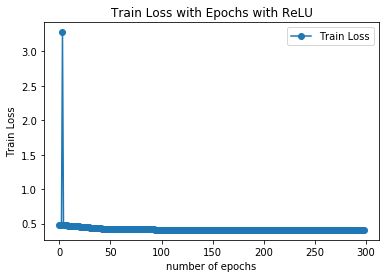

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Train Loss with Epochs with ReLU")
x = np.arange(0,len(costs[1:300]))
ax.plot(x, costs[1:300], marker='o', label='Train Loss')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Train Loss")

plt.legend()
#plt.savefig("relu_trainloss.png", dpi=1000, bbox_inches='tight')
plt.show()